### Basisversion

In [ ]:
import numpy as np
import pandas as pd
import time
import os
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, fcluster
from joblib import Parallel, delayed
import warnings
warnings.filterwarnings("ignore")

# =============================================================================
# Augmentierungsfunktionen
# =============================================================================

def perform_clustering(X_sub, max_clusters=4):
    cols = [col for col in X_sub.columns if col not in ["Verletzungsstatus", "Geschlecht_weiblich"]]
    X_num = X_sub[cols]
    # Absolute Korrelationsmatrix, NA-Werte mit 0 auffüllen und Symmetrie erzwingen
    corr = X_num.corr().abs().fillna(0)
    corr = (corr + corr.T) / 2
    dist = np.clip(1 - corr, a_min=0, a_max=None)
    dists = squareform(dist.values)
    Z = linkage(dists, method='ward')
    cluster_labels = fcluster(Z, max_clusters, criterion='maxclust')
    clusters = {}
    for col, label in zip(cols, cluster_labels):
        clusters.setdefault(label, []).append(col)
    return clusters

def augment_subgroup(X_sub, clusters, p_augment=0.7):
    augmented_rows = []
    cluster_params = {}
    for cl_id, cols in clusters.items():
        cluster_data = X_sub[cols]
        mu = cluster_data.mean().values
        if len(cols) == 1:
            cov = np.cov(cluster_data.values.flatten(), ddof=0)
            cov = np.atleast_2d(cov)
        else:
            cov = np.cov(cluster_data.values, rowvar=False)
        cluster_params[cl_id] = (mu, cov, cols)
    for idx, row in X_sub.iterrows():
        new_row = row.copy()
        for cl_id, (mu, cov, cols) in cluster_params.items():
            if np.random.rand() < p_augment:
                new_values = np.random.multivariate_normal(mu, cov)
                for col, val in zip(cols, new_values):
                    new_row[col] = val
        augmented_rows.append(new_row)
    augmented_df = pd.DataFrame(augmented_rows)
    # Binäre Spalten unverändert übernehmen
    for col in ["Geschlecht_weiblich", "Verletzungsstatus"]:
        if col in augmented_df.columns:
            augmented_df[col] = augmented_df[col].astype(int)
    return augmented_df

def process_group_cluster(group_df, num_new_samples, max_clusters, p_augment):
    group_df = group_df.reset_index(drop=True)
    clusters = perform_clustering(group_df, max_clusters=max_clusters)
    aug_list = []
    for _ in range(num_new_samples):
        aug = augment_subgroup(group_df, clusters, p_augment)
        aug_list.append(aug)
    return pd.concat(aug_list, axis=0)

def augment_training_data_cluster(X_train, y_train, num_new_samples=1, max_clusters=4, p_augment=0.7, n_jobs=-1):
    df_train = X_train.copy()
    df_train["Verletzungsstatus"] = y_train
    groups = [group_df for _, group_df in df_train.groupby(["Verletzungsstatus", "Geschlecht_weiblich"])]
    augmented_groups = Parallel(n_jobs=n_jobs)(
        delayed(process_group_cluster)(group_df, num_new_samples, max_clusters, p_augment)
        for group_df in groups
    )
    augmented_df = pd.concat(augmented_groups, axis=0).reset_index(drop=True)
    y_aug = augmented_df["Verletzungsstatus"]
    X_aug = augmented_df.drop(columns=["Verletzungsstatus"])
    return X_aug, y_aug

def add_noise_to_data(df, noise_factor=0.1):
    df_noisy = df.copy()
    numeric_cols = [col for col in df_noisy.select_dtypes(include=['float64', 'int64']).columns 
                    if col not in ["Geschlecht_weiblich", "Verletzungsstatus"]]
    for col in numeric_cols:
        std = df_noisy[col].std()
        noise = np.random.normal(0, std * noise_factor, size=df_noisy.shape[0])
        df_noisy[col] += noise
    return df_noisy

def add_noise_to_group(df_group, noise_factor=0.1):
    return add_noise_to_data(df_group, noise_factor=noise_factor)

def process_group_cluster_noise(group_df, num_new_samples, max_clusters, p_augment, noise_factor):
    group_df = group_df.reset_index(drop=True)
    clusters = perform_clustering(group_df, max_clusters=max_clusters)
    aug_list = []
    for _ in range(num_new_samples):
        aug = augment_subgroup(group_df, clusters, p_augment)
        aug_list.append(aug)
    aug_group = pd.concat(aug_list, axis=0).reset_index(drop=True)
    n = len(aug_group)
    half = n // 2
    global_noise = add_noise_to_data(aug_group.copy(), noise_factor=noise_factor)
    group_noise = add_noise_to_group(aug_group.copy(), noise_factor=noise_factor)
    aug_noisy = pd.concat([global_noise.iloc[:half], group_noise.iloc[:half]], axis=0)
    return aug_noisy

def augment_training_data_cluster_noise(X_train, y_train, num_new_samples=1, max_clusters=4, 
                                        p_augment=0.7, noise_factor=0.1, n_jobs=-1):
    df_train = X_train.copy()
    df_train["Verletzungsstatus"] = y_train
    groups = [group_df for _, group_df in df_train.groupby(["Verletzungsstatus", "Geschlecht_weiblich"])]
    augmented_groups = Parallel(n_jobs=n_jobs)(
        delayed(process_group_cluster_noise)(group_df, num_new_samples, max_clusters, p_augment, noise_factor)
        for group_df in groups
    )
    augmented_df = pd.concat(augmented_groups, axis=0).reset_index(drop=True)
    y_aug = augmented_df["Verletzungsstatus"]
    X_aug = augmented_df.drop(columns=["Verletzungsstatus"])
    return X_aug, y_aug

def process_group_means(group_df, group_new_samples):
    """Erzeugt neue Samples durch Mittelwertbildung aus zwei zufällig ausgewählten Samples.
       Dabei werden die binären Spalten 'Verletzungsstatus' und 'Geschlecht_weiblich' direkt übernommen."""
    group_df = group_df.reset_index(drop=True)
    new_group_samples = []
    if len(group_df) < 2:
        return None
    numeric_cols = [col for col in group_df.columns if col not in ["Geschlecht_weiblich", "Verletzungsstatus"]]
    pairs = np.random.choice(len(group_df), (group_new_samples, 2), replace=True)
    for i in range(group_new_samples):
        sample1 = group_df.iloc[pairs[i, 0]]
        sample2 = group_df.iloc[pairs[i, 1]]
        mean_sample = sample1.copy()
        for col in numeric_cols:
            mean_sample[col] = (sample1[col] + sample2[col]) / 2
        mean_sample["Verletzungsstatus"] = sample1["Verletzungsstatus"]
        mean_sample["Geschlecht_weiblich"] = sample1["Geschlecht_weiblich"]
        new_group_samples.append(mean_sample)
    if new_group_samples:
        return pd.DataFrame(new_group_samples)
    return None

def augment_data_by_group_means(X_train, y_train, augmentation_factor=2, n_jobs=-1):
    df_train = X_train.copy()
    df_train["Verletzungsstatus"] = y_train
    groups = df_train.groupby(["Verletzungsstatus", "Geschlecht_weiblich"])
    total_original_samples = len(df_train)
    total_new_samples = int(total_original_samples * (augmentation_factor - 1))
    group_sizes = groups.size()
    group_proportions = group_sizes / total_original_samples
    tasks = []
    for (injury_status, is_female), group_df in groups:
        group_new_samples = int(total_new_samples * group_proportions[(injury_status, is_female)])
        tasks.append((group_df, group_new_samples))
    augmented_groups = Parallel(n_jobs=n_jobs)(
        delayed(process_group_means)(group_df, group_new_samples)
        for group_df, group_new_samples in tasks
    )
    augmented_groups = [group for group in augmented_groups if group is not None]
    augmented_df = pd.concat([df_train] + augmented_groups, ignore_index=True)
    y_aug = augmented_df["Verletzungsstatus"]
    X_aug = augmented_df.drop(columns=["Verletzungsstatus"])
    return X_aug, y_aug

def augment_training_data_combined(X_train, y_train, target_size=1000, verbose=True, n_jobs=-1,
                                   max_clusters=4, noise_factor=0.1):
    """
    Führt alle drei Augmentierungsmethoden (Cluster-basiert, Cluster+Rauschen, Mittelwert-basiert)
    parallel aus und kombiniert die Ergebnisse, um den Trainingsdatensatz auf die gewünschte Zielgröße zu bringen.
    """
    start_time = time.time()
    N = len(X_train)
    additional_needed = max(target_size - N, 0)
    per_method_needed = additional_needed // 3
    num_new_samples = max(per_method_needed // N, 1)
    augmentation_factor = 1 + (per_method_needed / N)
    if verbose:
        print(f"Starting combined augmentation to reach target size: {target_size}")
        print(f"Original dataset size: {N}")
        print(f"Samples needed per method: {per_method_needed}")
    funcs_and_params = [
        (augment_training_data_cluster, {"num_new_samples": num_new_samples, "n_jobs": n_jobs}),
        (augment_training_data_cluster_noise, {"num_new_samples": num_new_samples, "n_jobs": n_jobs}),
        (augment_data_by_group_means, {"augmentation_factor": augmentation_factor, "n_jobs": n_jobs})
    ]
    results = Parallel(n_jobs=min(3, n_jobs))(
        delayed(func)(X_train, y_train, **params) for func, params in funcs_and_params
    )
    X_aug_cluster, y_aug_cluster = results[0]
    X_aug_cluster_noise, y_aug_cluster_noise = results[1]
    X_aug_group_means, y_aug_group_means = results[2]
    def subsample(X_aug, y_aug, required):
        if len(X_aug) > required:
            idx = np.random.choice(len(X_aug), required, replace=False)
            return X_aug.iloc[idx].reset_index(drop=True), y_aug.iloc[idx].reset_index(drop=True)
        else:
            return X_aug, y_aug
    X_aug_cluster, y_aug_cluster = subsample(X_aug_cluster, y_aug_cluster, per_method_needed)
    X_aug_cluster_noise, y_aug_cluster_noise = subsample(X_aug_cluster_noise, y_aug_cluster_noise, per_method_needed)
    X_aug_group_means, y_aug_group_means = subsample(X_aug_group_means, y_aug_group_means, per_method_needed)
    X_aug_combined = pd.concat([X_aug_cluster, X_aug_cluster_noise, X_aug_group_means], axis=0).reset_index(drop=True)
    y_aug_combined = pd.concat([y_aug_cluster, y_aug_cluster_noise, y_aug_group_means], axis=0).reset_index(drop=True)
    X_total = pd.concat([X_train.reset_index(drop=True), X_aug_combined], axis=0).reset_index(drop=True)
    y_total = pd.concat([y_train.reset_index(drop=True), y_aug_combined], axis=0).reset_index(drop=True)
    if len(X_total) > target_size:
        idx = np.random.choice(len(X_total), target_size, replace=False)
        X_total = X_total.iloc[idx].reset_index(drop=True)
        y_total = y_total.iloc[idx].reset_index(drop=True)
    elapsed_time = time.time() - start_time
    if verbose:
        print(f"Augmentation completed. Final dataset size: {len(X_total)}")
        print(f"Augmentation took {elapsed_time:.2f} seconds")
    return X_total, y_total

# =============================================================================
# Modellaufbau und Training
# =============================================================================

def create_model(input_dim):
    model = Sequential([
        Dense(256, activation='relu', input_shape=(input_dim,)),
        Dense(64, activation='relu'),
        Dense(8, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# =============================================================================
# CV-Pipeline
# =============================================================================


def run_cv_pipeline(data_path, target_column="Verletzungsstatus", cv_splits=5, cv_repeats=10,
                    target_augmentation_multiplier=11, verbose=True, n_jobs=-1):
    """
    Liest die Daten ein, führt eine stratified Cross-Validation durch, 
    augmentiert in jedem Fold den Trainingsdatensatz und trainiert anschließend ein Modell.
    Aggregiert die Ergebnisse (Mittelwert und Standardabweichung) und gibt diese zurück.
    """
    try:
        df = pd.read_excel(data_path)
    except Exception as e:
        print(f"Error loading data: {e}")
        return None
    if target_column not in df.columns:
        print(f"Target column '{target_column}' not found in data")
        return None
    y = df[target_column]
    X = df.drop(columns=[target_column])
    if verbose:
        print(f"Data loaded: {len(df)} samples, {X.shape[1]} features")
        print(f"Class distribution: {y.value_counts().to_dict()}")
    cv = RepeatedStratifiedKFold(n_splits=cv_splits, n_repeats=cv_repeats, random_state=42)
    metrics_results = []
    for train_index, test_index in cv.split(X, y):
        if verbose:
            print("\n--- New Fold ---")
        X_train, y_train = X.iloc[train_index].copy(), y.iloc[train_index].copy()
        X_test, y_test = X.iloc[test_index].copy(), y.iloc[test_index].copy()
        target_size = int(len(X_train) * target_augmentation_multiplier)
        # Augmentation durchführen
        X_train_aug, y_train_aug = augment_training_data_combined(X_train, y_train,
                                                                   target_size=target_size,
                                                                   verbose=verbose,
                                                                   n_jobs=n_jobs)
        # Skalierung
        scaler = MinMaxScaler()
        X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_aug), columns=X_train.columns)
        X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
        # Modell erstellen und trainieren
        model = create_model(input_dim=X_train_scaled.shape[1])
        early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        history = model.fit(X_train_scaled, y_train_aug,
                            validation_split=0.2,
                            epochs=100,
                            batch_size=16,
                            callbacks=[early_stop],
                            verbose=0)
        # Evaluation auf Trainingsdaten (Train Accuracy)
        y_train_pred_prob = model.predict(X_train_scaled)
        y_train_pred = (y_train_pred_prob > 0.5).astype(int).flatten()
        train_acc = accuracy_score(y_train_aug, y_train_pred)
        # Evaluation auf Testdaten (Test Accuracy und weitere Metriken)
        y_pred_prob = model.predict(X_test_scaled)
        y_pred = (y_pred_prob > 0.5).astype(int).flatten()
        test_acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        try:
            roc = roc_auc_score(y_test, y_pred_prob)
        except Exception:
            roc = None
        metrics_results.append({
            'train_accuracy': train_acc,
            'test_accuracy': test_acc,
            'f1_score': f1,
            'precision': prec,
            'recall': rec,
            'roc_auc': roc
        })
    results_df = pd.DataFrame(metrics_results)
    mean_metrics = results_df.mean(numeric_only=True)
    std_metrics = results_df.std(numeric_only=True)
    aggregated = {"mean": mean_metrics.to_dict(), "std": std_metrics.to_dict()}
    return aggregated

def main():
    data_path = r"C:\Users\boehmer\JupyterProjects\neuronales_netz_motum\data\Basistabelle_ML_neu.xlsx"
    aggregated_results = run_cv_pipeline(data_path, cv_splits=5, cv_repeats=10,
                                         target_augmentation_multiplier=11, verbose=True, n_jobs=-1)
    if aggregated_results is None:
        print("Pipeline failed.")
        return

    print("\n=== Model Performance Summary ===")
    print("{:<15} {:<20} {:<20}".format("Metric", "Mean", "Std"))
    for metric, mean_val in aggregated_results["mean"].items():
        std_val = aggregated_results["std"].get(metric, np.nan)
        print("{:<15} {:<20.4f} {:<20.4f}".format(metric, mean_val, std_val))

if __name__ == "__main__":
    main()



Data loaded: 113 samples, 113 features
Class distribution: {1: 61, 0: 52}

--- New Fold ---
Starting combined augmentation to reach target size: 990
Original dataset size: 90
Samples needed per method: 300
Augmentation completed. Final dataset size: 928
Augmentation took 0.75 seconds
1/1 [==============================] - 0s 43ms/step

--- New Fold ---
Starting combined augmentation to reach target size: 990
Original dataset size: 90
Samples needed per method: 300
Augmentation completed. Final dataset size: 928
Augmentation took 0.76 seconds
1/1 [==============================] - 0s 40ms/step

--- New Fold ---
Starting combined augmentation to reach target size: 990
Original dataset size: 90
Samples needed per method: 300
Augmentation completed. Final dataset size: 928
Augmentation took 0.73 seconds
1/1 [==============================] - 0s 41ms/step

--- New Fold ---
Starting combined augmentation to reach target size: 1001
Original dataset size: 91
Samples needed per method: 303
Augm

### ROC-AUC Kurve 


=== Model Performance Summary ===
Metric          Mean                 Std                 
train_accuracy  0.9940               0.0064              
test_accuracy   0.8744               0.0630              
f1_score        0.8808               0.0669              
precision       0.8954               0.0738              
recall          0.8788               0.1131              
roc_auc         0.9570               0.0416              


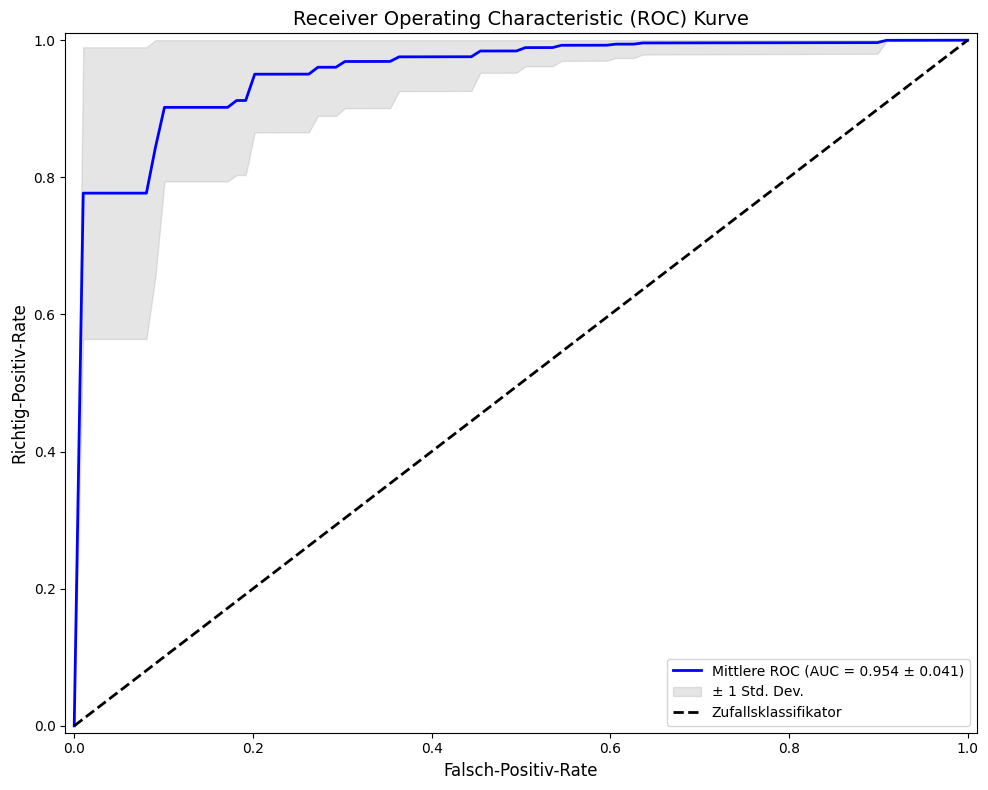


Mean AUC: 0.9540 ± 0.0411


In [ ]:
import os
# Umgebungsvariablen vor dem Import von TensorFlow setzen:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # 0 = alle Meldungen, 1 = Info, 2 = Warnungen, 3 = nur Fehler
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, fcluster
from joblib import Parallel, delayed
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

# =============================================================================
# ROC-AUC Kurve
# =============================================================================

def plot_roc_curves(cv_results, save_path=None):
    """
    Plottet nur die gemittelte ROC-Kurve mit Standardabweichung und Zufallslinie.
    
    Parameter:
    cv_results: Liste von Dictionaries mit 'y_true', 'y_pred_prob' für jeden Fold
    save_path: Pfad zum Speichern der Abbildung (optional)
    """
    plt.figure(figsize=(10, 8))
    
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    aucs = []
    
    # Berechne ROC-Daten für jeden Fold (ohne zu plotten)
    for i, result in enumerate(cv_results):
        y_true = result['y_true']
        y_pred_prob = result['y_pred_prob']
        
        fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
    
    # Plotte nur gemittelte ROC-Kurve
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, 'b-', lw=2, 
             label=f'Mittlere ROC (AUC = {mean_auc:.3f} ± {std_auc:.3f})')
    
    # Plotte Standardabweichung
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.2,
                     label=f'± 1 Std. Dev.')
    
    # Plotte Zufallslinie
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Zufallsklassifikator')
    
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('Falsch-Positiv-Rate', fontsize=12)
    plt.ylabel('Richtig-Positiv-Rate', fontsize=12)
    plt.title('Receiver Operating Characteristic (ROC) Kurve', fontsize=14)
    plt.legend(loc="lower right", fontsize=10)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.tight_layout()
    plt.show()
    
    return mean_auc, std_auc

# =============================================================================
# Augmentierungsfunktionen
# =============================================================================

def perform_clustering(X_sub, max_clusters=4):
    cols = [col for col in X_sub.columns if col not in ["Verletzungsstatus", "Geschlecht_weiblich"]]
    X_num = X_sub[cols]
    # Absolute Korrelationsmatrix, NA-Werte mit 0 auffüllen und Symmetrie erzwingen
    corr = X_num.corr().abs().fillna(0)
    corr = (corr + corr.T) / 2
    dist = np.clip(1 - corr, a_min=0, a_max=None)
    dists = squareform(dist.values)
    Z = linkage(dists, method='ward')
    cluster_labels = fcluster(Z, max_clusters, criterion='maxclust')
    clusters = {}
    for col, label in zip(cols, cluster_labels):
        clusters.setdefault(label, []).append(col)
    return clusters

def augment_subgroup(X_sub, clusters, p_augment=0.7):
    augmented_rows = []
    cluster_params = {}
    for cl_id, cols in clusters.items():
        cluster_data = X_sub[cols]
        mu = cluster_data.mean().values
        if len(cols) == 1:
            cov = np.cov(cluster_data.values.flatten(), ddof=0)
            cov = np.atleast_2d(cov)
        else:
            cov = np.cov(cluster_data.values, rowvar=False)
        cluster_params[cl_id] = (mu, cov, cols)
    for idx, row in X_sub.iterrows():
        new_row = row.copy()
        for cl_id, (mu, cov, cols) in cluster_params.items():
            if np.random.rand() < p_augment:
                new_values = np.random.multivariate_normal(mu, cov)
                for col, val in zip(cols, new_values):
                    new_row[col] = val
        augmented_rows.append(new_row)
    augmented_df = pd.DataFrame(augmented_rows)
    # Binäre Spalten unverändert übernehmen
    for col in ["Geschlecht_weiblich", "Verletzungsstatus"]:
        if col in augmented_df.columns:
            augmented_df[col] = augmented_df[col].astype(int)
    return augmented_df

def process_group_cluster(group_df, num_new_samples, max_clusters, p_augment):
    group_df = group_df.reset_index(drop=True)
    clusters = perform_clustering(group_df, max_clusters=max_clusters)
    aug_list = []
    for _ in range(num_new_samples):
        aug = augment_subgroup(group_df, clusters, p_augment)
        aug_list.append(aug)
    return pd.concat(aug_list, axis=0)

def augment_training_data_cluster(X_train, y_train, num_new_samples=1, max_clusters=4, p_augment=0.7, n_jobs=-1):
    df_train = X_train.copy()
    df_train["Verletzungsstatus"] = y_train
    groups = [group_df for _, group_df in df_train.groupby(["Verletzungsstatus", "Geschlecht_weiblich"])]
    augmented_groups = Parallel(n_jobs=n_jobs)(
        delayed(process_group_cluster)(group_df, num_new_samples, max_clusters, p_augment)
        for group_df in groups
    )
    augmented_df = pd.concat(augmented_groups, axis=0).reset_index(drop=True)
    y_aug = augmented_df["Verletzungsstatus"]
    X_aug = augmented_df.drop(columns=["Verletzungsstatus"])
    return X_aug, y_aug

def add_noise_to_data(df, noise_factor=0.1):
    df_noisy = df.copy()
    numeric_cols = [col for col in df_noisy.select_dtypes(include=['float64', 'int64']).columns 
                    if col not in ["Geschlecht_weiblich", "Verletzungsstatus"]]
    for col in numeric_cols:
        std = df_noisy[col].std()
        noise = np.random.normal(0, std * noise_factor, size=df_noisy.shape[0])
        df_noisy[col] += noise
    return df_noisy

def add_noise_to_group(df_group, noise_factor=0.1):
    return add_noise_to_data(df_group, noise_factor=noise_factor)

def process_group_cluster_noise(group_df, num_new_samples, max_clusters, p_augment, noise_factor):
    group_df = group_df.reset_index(drop=True)
    clusters = perform_clustering(group_df, max_clusters=max_clusters)
    aug_list = []
    for _ in range(num_new_samples):
        aug = augment_subgroup(group_df, clusters, p_augment)
        aug_list.append(aug)
    aug_group = pd.concat(aug_list, axis=0).reset_index(drop=True)
    n = len(aug_group)
    half = n // 2
    global_noise = add_noise_to_data(aug_group.copy(), noise_factor=noise_factor)
    group_noise = add_noise_to_group(aug_group.copy(), noise_factor=noise_factor)
    aug_noisy = pd.concat([global_noise.iloc[:half], group_noise.iloc[:half]], axis=0)
    return aug_noisy

def augment_training_data_cluster_noise(X_train, y_train, num_new_samples=1, max_clusters=4, 
                                        p_augment=0.7, noise_factor=0.1, n_jobs=-1):
    df_train = X_train.copy()
    df_train["Verletzungsstatus"] = y_train
    groups = [group_df for _, group_df in df_train.groupby(["Verletzungsstatus", "Geschlecht_weiblich"])]
    augmented_groups = Parallel(n_jobs=n_jobs)(
        delayed(process_group_cluster_noise)(group_df, num_new_samples, max_clusters, p_augment, noise_factor)
        for group_df in groups
    )
    augmented_df = pd.concat(augmented_groups, axis=0).reset_index(drop=True)
    y_aug = augmented_df["Verletzungsstatus"]
    X_aug = augmented_df.drop(columns=["Verletzungsstatus"])
    return X_aug, y_aug

def process_group_means(group_df, group_new_samples):
    """Erzeugt neue Samples durch Mittelwertbildung aus zwei zufällig ausgewählten Samples.
       Dabei werden die binären Spalten 'Verletzungsstatus' und 'Geschlecht_weiblich' direkt übernommen."""
    group_df = group_df.reset_index(drop=True)
    new_group_samples = []
    if len(group_df) < 2:
        return None
    numeric_cols = [col for col in group_df.columns if col not in ["Geschlecht_weiblich", "Verletzungsstatus"]]
    pairs = np.random.choice(len(group_df), (group_new_samples, 2), replace=True)
    for i in range(group_new_samples):
        sample1 = group_df.iloc[pairs[i, 0]]
        sample2 = group_df.iloc[pairs[i, 1]]
        mean_sample = sample1.copy()
        for col in numeric_cols:
            mean_sample[col] = (sample1[col] + sample2[col]) / 2
        mean_sample["Verletzungsstatus"] = sample1["Verletzungsstatus"]
        mean_sample["Geschlecht_weiblich"] = sample1["Geschlecht_weiblich"]
        new_group_samples.append(mean_sample)
    if new_group_samples:
        return pd.DataFrame(new_group_samples)
    return None

def augment_data_by_group_means(X_train, y_train, augmentation_factor=2, n_jobs=-1):
    df_train = X_train.copy()
    df_train["Verletzungsstatus"] = y_train
    groups = df_train.groupby(["Verletzungsstatus", "Geschlecht_weiblich"])
    total_original_samples = len(df_train)
    total_new_samples = int(total_original_samples * (augmentation_factor - 1))
    group_sizes = groups.size()
    group_proportions = group_sizes / total_original_samples
    tasks = []
    for (injury_status, is_female), group_df in groups:
        group_new_samples = int(total_new_samples * group_proportions[(injury_status, is_female)])
        tasks.append((group_df, group_new_samples))
    augmented_groups = Parallel(n_jobs=n_jobs)(
        delayed(process_group_means)(group_df, group_new_samples)
        for group_df, group_new_samples in tasks
    )
    augmented_groups = [group for group in augmented_groups if group is not None]
    augmented_df = pd.concat([df_train] + augmented_groups, ignore_index=True)
    y_aug = augmented_df["Verletzungsstatus"]
    X_aug = augmented_df.drop(columns=["Verletzungsstatus"])
    return X_aug, y_aug

def augment_training_data_combined(X_train, y_train, target_size=1000, verbose=True, n_jobs=-1,
                                   max_clusters=4, noise_factor=0.1):
    """
    Führt alle drei Augmentierungsmethoden (Cluster-basiert, Cluster+Rauschen, Mittelwert-basiert)
    parallel aus und kombiniert die Ergebnisse, um den Trainingsdatensatz auf die gewünschte Zielgröße zu bringen.
    """
    start_time = time.time()
    N = len(X_train)
    additional_needed = max(target_size - N, 0)
    per_method_needed = additional_needed // 3
    num_new_samples = max(per_method_needed // N, 1)
    augmentation_factor = 1 + (per_method_needed / N)
    if verbose:
        print(f"Starting combined augmentation to reach target size: {target_size}")
        print(f"Original dataset size: {N}")
        print(f"Samples needed per method: {per_method_needed}")
    funcs_and_params = [
        (augment_training_data_cluster, {"num_new_samples": num_new_samples, "n_jobs": n_jobs}),
        (augment_training_data_cluster_noise, {"num_new_samples": num_new_samples, "n_jobs": n_jobs}),
        (augment_data_by_group_means, {"augmentation_factor": augmentation_factor, "n_jobs": n_jobs})
    ]
    results = Parallel(n_jobs=min(3, n_jobs))(
        delayed(func)(X_train, y_train, **params) for func, params in funcs_and_params
    )
    X_aug_cluster, y_aug_cluster = results[0]
    X_aug_cluster_noise, y_aug_cluster_noise = results[1]
    X_aug_group_means, y_aug_group_means = results[2]
    def subsample(X_aug, y_aug, required):
        if len(X_aug) > required:
            idx = np.random.choice(len(X_aug), required, replace=False)
            return X_aug.iloc[idx].reset_index(drop=True), y_aug.iloc[idx].reset_index(drop=True)
        else:
            return X_aug, y_aug
    X_aug_cluster, y_aug_cluster = subsample(X_aug_cluster, y_aug_cluster, per_method_needed)
    X_aug_cluster_noise, y_aug_cluster_noise = subsample(X_aug_cluster_noise, y_aug_cluster_noise, per_method_needed)
    X_aug_group_means, y_aug_group_means = subsample(X_aug_group_means, y_aug_group_means, per_method_needed)
    X_aug_combined = pd.concat([X_aug_cluster, X_aug_cluster_noise, X_aug_group_means], axis=0).reset_index(drop=True)
    y_aug_combined = pd.concat([y_aug_cluster, y_aug_cluster_noise, y_aug_group_means], axis=0).reset_index(drop=True)
    X_total = pd.concat([X_train.reset_index(drop=True), X_aug_combined], axis=0).reset_index(drop=True)
    y_total = pd.concat([y_train.reset_index(drop=True), y_aug_combined], axis=0).reset_index(drop=True)
    if len(X_total) > target_size:
        idx = np.random.choice(len(X_total), target_size, replace=False)
        X_total = X_total.iloc[idx].reset_index(drop=True)
        y_total = y_total.iloc[idx].reset_index(drop=True)
    elapsed_time = time.time() - start_time
    if verbose:
        print(f"Augmentation completed. Final dataset size: {len(X_total)}")
        print(f"Augmentation took {elapsed_time:.2f} seconds")
    return X_total, y_total

# =============================================================================
# Modellaufbau und Training
# =============================================================================

def create_model(input_dim):
    model = Sequential([
        Dense(256, activation='relu', input_shape=(input_dim,)),
        Dense(64, activation='relu'),
        Dense(8, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# =============================================================================
# CV-Pipeline
# =============================================================================


def run_cv_pipeline(data_path, target_column="Verletzungsstatus", cv_splits=5, cv_repeats=10,
                    target_augmentation_multiplier=11, verbose=True, n_jobs=-1):
    """
    Liest die Daten ein, führt eine stratified Cross-Validation durch, 
    augmentiert in jedem Fold den Trainingsdatensatz und trainiert anschließend ein Modell.
    Aggregiert die Ergebnisse (Mittelwert und Standardabweichung) und gibt diese zurück.
    """
    try:
        df = pd.read_excel(data_path)
    except Exception as e:
        print(f"Error loading data: {e}")
        return None
    if target_column not in df.columns:
        print(f"Target column '{target_column}' not found in data")
        return None
    y = df[target_column]
    X = df.drop(columns=[target_column])
    if verbose:
        print(f"Data loaded: {len(df)} samples, {X.shape[1]} features")
        print(f"Class distribution: {y.value_counts().to_dict()}")
    cv = RepeatedStratifiedKFold(n_splits=cv_splits, n_repeats=cv_repeats, random_state=42)
    metrics_results = []
    roc_data = []  # Liste für ROC-Daten
    for train_index, test_index in cv.split(X, y):
        if verbose:
            print("\n--- New Fold ---")
        X_train, y_train = X.iloc[train_index].copy(), y.iloc[train_index].copy()
        X_test, y_test = X.iloc[test_index].copy(), y.iloc[test_index].copy()
        target_size = int(len(X_train) * target_augmentation_multiplier)
        # Augmentation durchführen
        X_train_aug, y_train_aug = augment_training_data_combined(X_train, y_train,
                                                                   target_size=target_size,
                                                                   verbose=verbose,
                                                                   n_jobs=n_jobs)
        # Skalierung
        scaler = MinMaxScaler()
        X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_aug), columns=X_train.columns)
        X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
        # Modell erstellen und trainieren
        model = create_model(input_dim=X_train_scaled.shape[1])
        early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        history = model.fit(X_train_scaled, y_train_aug,
                            validation_split=0.2,
                            epochs=100,
                            batch_size=16,
                            callbacks=[early_stop],
                            verbose=0)
        # Evaluation auf Trainingsdaten (Train Accuracy)
        y_train_pred_prob = model.predict(X_train_scaled, verbose=0)
        y_train_pred = (y_train_pred_prob > 0.5).astype(int).flatten()
        train_acc = accuracy_score(y_train_aug, y_train_pred)
        # Evaluation auf Testdaten (Test Accuracy und weitere Metriken)
        y_pred_prob = model.predict(X_test_scaled, verbose=0)
        y_pred = (y_pred_prob > 0.5).astype(int).flatten()
        test_acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        # ROC-Daten speichern
        roc_data.append({
            'y_true': y_test.values,
            'y_pred_prob': y_pred_prob.flatten()
        })

        try:
            roc = roc_auc_score(y_test, y_pred_prob)
        except Exception:
            roc = None
        metrics_results.append({
            'train_accuracy': train_acc,
            'test_accuracy': test_acc,
            'f1_score': f1,
            'precision': prec,
            'recall': rec,
            'roc_auc': roc
        })
    results_df = pd.DataFrame(metrics_results)
    mean_metrics = results_df.mean(numeric_only=True)
    std_metrics = results_df.std(numeric_only=True)
    aggregated = {"mean": mean_metrics.to_dict(), "std": std_metrics.to_dict()}
    return aggregated, roc_data

def main():
    data_path = r"C:\Users\boehmer\JupyterProjects\neuronales_netz_motum\data\Basistabelle_ML_neu.xlsx"
    aggregated_results, roc_data = run_cv_pipeline(data_path, cv_splits=5, cv_repeats=10,
                                         target_augmentation_multiplier=11, verbose=False, n_jobs=-1)
    if aggregated_results is None:
        print("Pipeline failed.")
        return

    print("\n=== Model Performance Summary ===")
    print("{:<15} {:<20} {:<20}".format("Metric", "Mean", "Std"))
    for metric, mean_val in aggregated_results["mean"].items():
        std_val = aggregated_results["std"].get(metric, np.nan)
        print("{:<15} {:<20.4f} {:<20.4f}".format(metric, mean_val, std_val))
    
    # ROC-Kurven plotten
    mean_auc, std_auc = plot_roc_curves(roc_data, save_path=r"C:\Users\boehmer\JupyterProjects\neuronales_netz_motum\data\roc_curve_results.png")
    print(f"\nMean AUC: {mean_auc:.4f} ± {std_auc:.4f}")

if __name__ == "__main__":
    main()





### Version für die Optimierung

In [ ]:
import os
# Umgebungsvariablen vor dem Import von TensorFlow setzen:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # 0 = alle Meldungen, 1 = Info, 2 = Warnungen, 3 = nur Fehler
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, fcluster
from joblib import Parallel, delayed
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

# =============================================================================
# Augmentierungsfunktionen
# =============================================================================

def perform_clustering(X_sub, max_clusters=4):
    cols = [col for col in X_sub.columns if col not in ["Verletzungsstatus", "Geschlecht_weiblich"]]
    X_num = X_sub[cols]
    # Absolute Korrelationsmatrix, NA-Werte mit 0 auffüllen und Symmetrie erzwingen
    corr = X_num.corr().abs().fillna(0)
    corr = (corr + corr.T) / 2
    dist = np.clip(1 - corr, a_min=0, a_max=None)
    dists = squareform(dist.values)
    Z = linkage(dists, method='ward')
    cluster_labels = fcluster(Z, max_clusters, criterion='maxclust')
    clusters = {}
    for col, label in zip(cols, cluster_labels):
        clusters.setdefault(label, []).append(col)
    return clusters

def augment_subgroup(X_sub, clusters, p_augment=0.7):
    augmented_rows = []
    cluster_params = {}
    for cl_id, cols in clusters.items():
        cluster_data = X_sub[cols]
        mu = cluster_data.mean().values
        if len(cols) == 1:
            cov = np.cov(cluster_data.values.flatten(), ddof=0)
            cov = np.atleast_2d(cov)
        else:
            cov = np.cov(cluster_data.values, rowvar=False)
        cluster_params[cl_id] = (mu, cov, cols)
    for idx, row in X_sub.iterrows():
        new_row = row.copy()
        for cl_id, (mu, cov, cols) in cluster_params.items():
            if np.random.rand() < p_augment:
                new_values = np.random.multivariate_normal(mu, cov)
                for col, val in zip(cols, new_values):
                    new_row[col] = val
        augmented_rows.append(new_row)
    augmented_df = pd.DataFrame(augmented_rows)
    # Binäre Spalten unverändert übernehmen
    for col in ["Geschlecht_weiblich", "Verletzungsstatus"]:
        if col in augmented_df.columns:
            augmented_df[col] = augmented_df[col].astype(int)
    return augmented_df

def process_group_cluster(group_df, num_new_samples, max_clusters, p_augment):
    group_df = group_df.reset_index(drop=True)
    clusters = perform_clustering(group_df, max_clusters=max_clusters)
    aug_list = []
    for _ in range(num_new_samples):
        aug = augment_subgroup(group_df, clusters, p_augment)
        aug_list.append(aug)
    return pd.concat(aug_list, axis=0)

def augment_training_data_cluster(X_train, y_train, num_new_samples=1, max_clusters=4, p_augment=0.7, n_jobs=-1):
    df_train = X_train.copy()
    df_train["Verletzungsstatus"] = y_train
    groups = [group_df for _, group_df in df_train.groupby(["Verletzungsstatus", "Geschlecht_weiblich"])]
    augmented_groups = Parallel(n_jobs=n_jobs)(
        delayed(process_group_cluster)(group_df, num_new_samples, max_clusters, p_augment)
        for group_df in groups
    )
    augmented_df = pd.concat(augmented_groups, axis=0).reset_index(drop=True)
    y_aug = augmented_df["Verletzungsstatus"]
    X_aug = augmented_df.drop(columns=["Verletzungsstatus"])
    return X_aug, y_aug

def add_noise_to_data(df, noise_factor=0.1):
    df_noisy = df.copy()
    numeric_cols = [col for col in df_noisy.select_dtypes(include=['float64', 'int64']).columns 
                    if col not in ["Geschlecht_weiblich", "Verletzungsstatus"]]
    for col in numeric_cols:
        std = df_noisy[col].std()
        noise = np.random.normal(0, std * noise_factor, size=df_noisy.shape[0])
        df_noisy[col] += noise
    return df_noisy

def add_noise_to_group(df_group, noise_factor=0.1):
    return add_noise_to_data(df_group, noise_factor=noise_factor)

def process_group_cluster_noise(group_df, num_new_samples, max_clusters, p_augment, noise_factor):
    group_df = group_df.reset_index(drop=True)
    clusters = perform_clustering(group_df, max_clusters=max_clusters)
    aug_list = []
    for _ in range(num_new_samples):
        aug = augment_subgroup(group_df, clusters, p_augment)
        aug_list.append(aug)
    aug_group = pd.concat(aug_list, axis=0).reset_index(drop=True)
    n = len(aug_group)
    half = n // 2
    global_noise = add_noise_to_data(aug_group.copy(), noise_factor=noise_factor)
    group_noise = add_noise_to_group(aug_group.copy(), noise_factor=noise_factor)
    aug_noisy = pd.concat([global_noise.iloc[:half], group_noise.iloc[:half]], axis=0)
    return aug_noisy

def augment_training_data_cluster_noise(X_train, y_train, num_new_samples=1, max_clusters=4, 
                                        p_augment=0.7, noise_factor=0.1, n_jobs=-1):
    df_train = X_train.copy()
    df_train["Verletzungsstatus"] = y_train
    groups = [group_df for _, group_df in df_train.groupby(["Verletzungsstatus", "Geschlecht_weiblich"])]
    augmented_groups = Parallel(n_jobs=n_jobs)(
        delayed(process_group_cluster_noise)(group_df, num_new_samples, max_clusters, p_augment, noise_factor)
        for group_df in groups
    )
    augmented_df = pd.concat(augmented_groups, axis=0).reset_index(drop=True)
    y_aug = augmented_df["Verletzungsstatus"]
    X_aug = augmented_df.drop(columns=["Verletzungsstatus"])
    return X_aug, y_aug

def process_group_means(group_df, group_new_samples):
    """Erzeugt neue Samples durch Mittelwertbildung aus zwei zufällig ausgewählten Samples.
       Dabei werden die binären Spalten 'Verletzungsstatus' und 'Geschlecht_weiblich' direkt übernommen."""
    group_df = group_df.reset_index(drop=True)
    new_group_samples = []
    if len(group_df) < 2:
        return None
    numeric_cols = [col for col in group_df.columns if col not in ["Geschlecht_weiblich", "Verletzungsstatus"]]
    pairs = np.random.choice(len(group_df), (group_new_samples, 2), replace=True)
    for i in range(group_new_samples):
        sample1 = group_df.iloc[pairs[i, 0]]
        sample2 = group_df.iloc[pairs[i, 1]]
        mean_sample = sample1.copy()
        for col in numeric_cols:
            mean_sample[col] = (sample1[col] + sample2[col]) / 2
        mean_sample["Verletzungsstatus"] = sample1["Verletzungsstatus"]
        mean_sample["Geschlecht_weiblich"] = sample1["Geschlecht_weiblich"]
        new_group_samples.append(mean_sample)
    if new_group_samples:
        return pd.DataFrame(new_group_samples)
    return None

def augment_data_by_group_means(X_train, y_train, augmentation_factor=2, n_jobs=-1):
    df_train = X_train.copy()
    df_train["Verletzungsstatus"] = y_train
    groups = df_train.groupby(["Verletzungsstatus", "Geschlecht_weiblich"])
    total_original_samples = len(df_train)
    total_new_samples = int(total_original_samples * (augmentation_factor - 1))
    group_sizes = groups.size()
    group_proportions = group_sizes / total_original_samples
    tasks = []
    for (injury_status, is_female), group_df in groups:
        group_new_samples = int(total_new_samples * group_proportions[(injury_status, is_female)])
        tasks.append((group_df, group_new_samples))
    augmented_groups = Parallel(n_jobs=n_jobs)(
        delayed(process_group_means)(group_df, group_new_samples)
        for group_df, group_new_samples in tasks
    )
    augmented_groups = [group for group in augmented_groups if group is not None]
    augmented_df = pd.concat([df_train] + augmented_groups, ignore_index=True)
    y_aug = augmented_df["Verletzungsstatus"]
    X_aug = augmented_df.drop(columns=["Verletzungsstatus"])
    return X_aug, y_aug

def augment_training_data_combined(X_train, y_train, target_size=1000, verbose=True, n_jobs=-1,
                                   max_clusters=4, noise_factor=0.1):
    """
    Führt alle drei Augmentierungsmethoden (Cluster-basiert, Cluster+Rauschen, Mittelwert-basiert)
    parallel aus und kombiniert die Ergebnisse, um den Trainingsdatensatz auf die gewünschte Zielgröße zu bringen.
    """
    start_time = time.time()
    N = len(X_train)
    additional_needed = max(target_size - N, 0)
    per_method_needed = additional_needed // 3
    num_new_samples = max(per_method_needed // N, 1)
    augmentation_factor = 1 + (per_method_needed / N)
    if verbose:
        print(f"Starting combined augmentation to reach target size: {target_size}")
        print(f"Original dataset size: {N}")
        print(f"Samples needed per method: {per_method_needed}")
    funcs_and_params = [
        (augment_training_data_cluster, {"num_new_samples": num_new_samples, "n_jobs": n_jobs}),
        (augment_training_data_cluster_noise, {"num_new_samples": num_new_samples, "n_jobs": n_jobs}),
        (augment_data_by_group_means, {"augmentation_factor": augmentation_factor, "n_jobs": n_jobs})
    ]
    results = Parallel(n_jobs=min(3, n_jobs))(
        delayed(func)(X_train, y_train, **params) for func, params in funcs_and_params
    )
    X_aug_cluster, y_aug_cluster = results[0]
    X_aug_cluster_noise, y_aug_cluster_noise = results[1]
    X_aug_group_means, y_aug_group_means = results[2]
    def subsample(X_aug, y_aug, required):
        if len(X_aug) > required:
            idx = np.random.choice(len(X_aug), required, replace=False)
            return X_aug.iloc[idx].reset_index(drop=True), y_aug.iloc[idx].reset_index(drop=True)
        else:
            return X_aug, y_aug
    X_aug_cluster, y_aug_cluster = subsample(X_aug_cluster, y_aug_cluster, per_method_needed)
    X_aug_cluster_noise, y_aug_cluster_noise = subsample(X_aug_cluster_noise, y_aug_cluster_noise, per_method_needed)
    X_aug_group_means, y_aug_group_means = subsample(X_aug_group_means, y_aug_group_means, per_method_needed)
    X_aug_combined = pd.concat([X_aug_cluster, X_aug_cluster_noise, X_aug_group_means], axis=0).reset_index(drop=True)
    y_aug_combined = pd.concat([y_aug_cluster, y_aug_cluster_noise, y_aug_group_means], axis=0).reset_index(drop=True)
    X_total = pd.concat([X_train.reset_index(drop=True), X_aug_combined], axis=0).reset_index(drop=True)
    y_total = pd.concat([y_train.reset_index(drop=True), y_aug_combined], axis=0).reset_index(drop=True)
    if len(X_total) > target_size:
        idx = np.random.choice(len(X_total), target_size, replace=False)
        X_total = X_total.iloc[idx].reset_index(drop=True)
        y_total = y_total.iloc[idx].reset_index(drop=True)
    elapsed_time = time.time() - start_time
    if verbose:
        print(f"Augmentation completed. Final dataset size: {len(X_total)}")
        print(f"Augmentation took {elapsed_time:.2f} seconds")
    return X_total, y_total

# =============================================================================
# Modellaufbau und Training
# =============================================================================

def create_model(input_dim):
    model = Sequential([
        Dense(256, activation='relu', input_shape=(input_dim,)),
        Dense(64, activation='relu'),
        Dense(8, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# =============================================================================
# CV-Pipeline
# =============================================================================


def run_cv_pipeline(data_path, target_column="Verletzungsstatus", cv_splits=5, cv_repeats=10,
                    target_augmentation_multiplier=11, verbose=True, n_jobs=-1):
    """
    Liest die Daten ein, führt eine stratified Cross-Validation durch, 
    augmentiert in jedem Fold den Trainingsdatensatz und trainiert anschließend ein Modell.
    Aggregiert die Ergebnisse (Mittelwert und Standardabweichung) und gibt diese zurück.
    """
    try:
        df = pd.read_excel(data_path)
    except Exception as e:
        print(f"Error loading data: {e}")
        return None
    if target_column not in df.columns:
        print(f"Target column '{target_column}' not found in data")
        return None
    y = df[target_column]
    X = df.drop(columns=[target_column])
    if verbose:
        print(f"Data loaded: {len(df)} samples, {X.shape[1]} features")
        print(f"Class distribution: {y.value_counts().to_dict()}")
    cv = RepeatedStratifiedKFold(n_splits=cv_splits, n_repeats=cv_repeats, random_state=42)
    metrics_results = []
   
    for train_index, test_index in cv.split(X, y):
        if verbose:
            print("\n--- New Fold ---")
        X_train, y_train = X.iloc[train_index].copy(), y.iloc[train_index].copy()
        X_test, y_test = X.iloc[test_index].copy(), y.iloc[test_index].copy()
        target_size = int(len(X_train) * target_augmentation_multiplier)
        # Augmentation durchführen
        X_train_aug, y_train_aug = augment_training_data_combined(X_train, y_train,
                                                                   target_size=target_size,
                                                                   verbose=verbose,
                                                                   n_jobs=n_jobs)
        # Skalierung
        scaler = MinMaxScaler()
        X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_aug), columns=X_train.columns)
        X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
        # Modell erstellen und trainieren
        model = create_model(input_dim=X_train_scaled.shape[1])
        early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        history = model.fit(X_train_scaled, y_train_aug,
                            validation_split=0.2,
                            epochs=100,
                            batch_size=16,
                            callbacks=[early_stop],
                            verbose=0)
        # Evaluation auf Trainingsdaten (Train Accuracy)
        y_train_pred_prob = model.predict(X_train_scaled, verbose=0)
        y_train_pred = (y_train_pred_prob > 0.5).astype(int).flatten()
        train_acc = accuracy_score(y_train_aug, y_train_pred)
        # Evaluation auf Testdaten (Test Accuracy und weitere Metriken)
        y_pred_prob = model.predict(X_test_scaled, verbose=0)
        y_pred = (y_pred_prob > 0.5).astype(int).flatten()
        test_acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)

        try:
            roc = roc_auc_score(y_test, y_pred_prob)
        except Exception:
            roc = None
        metrics_results.append({
            'train_accuracy': train_acc,
            'test_accuracy': test_acc,
            'f1_score': f1,
            'precision': prec,
            'recall': rec,
            'roc_auc': roc
        })
    results_df = pd.DataFrame(metrics_results)
    mean_metrics = results_df.mean(numeric_only=True)
    std_metrics = results_df.std(numeric_only=True)
    aggregated = {"mean": mean_metrics.to_dict(), "std": std_metrics.to_dict()}
    return aggregated

def main():
    data_path = r"C:\Users\boehmer\JupyterProjects\neuronales_netz_motum\data\Basistabelle_ML_neu.xlsx"
    aggregated_results, roc_data = run_cv_pipeline(data_path, cv_splits=5, cv_repeats=10,
                                         target_augmentation_multiplier=11, verbose=False, n_jobs=-1)
    if aggregated_results is None:
        print("Pipeline failed.")
        return

    print("\n=== Model Performance Summary ===")
    print("{:<15} {:<20} {:<20}".format("Metric", "Mean", "Std"))
    for metric, mean_val in aggregated_results["mean"].items():
        std_val = aggregated_results["std"].get(metric, np.nan)
        print("{:<15} {:<20.4f} {:<20.4f}".format(metric, mean_val, std_val))
    

if __name__ == "__main__":
    main()



### Versuch 1 Hyperparameter Optimierung

In [2]:
import os
# Umgebungsvariablen vor dem Import von TensorFlow setzen:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # 0 = alle Meldungen, 1 = Info, 2 = Warnungen, 3 = nur Fehler
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, fcluster
from joblib import Parallel, delayed
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
import optuna
from optuna.visualization import plot_optimization_history, plot_pareto_front
from optuna.importance import get_param_importances

# =============================================================================
# Augmentierungsfunktionen 
# =============================================================================
def perform_clustering(X_sub, max_clusters=4):
    cols = [col for col in X_sub.columns if col not in ["Verletzungsstatus", "Geschlecht_weiblich"]]
    X_num = X_sub[cols]
    corr = X_num.corr().abs().fillna(0)
    corr = (corr + corr.T) / 2
    dist = np.clip(1 - corr, a_min=0, a_max=None)
    dists = squareform(dist.values)
    Z = linkage(dists, method='ward')
    cluster_labels = fcluster(Z, max_clusters, criterion='maxclust')
    clusters = {}
    for col, label in zip(cols, cluster_labels):
        clusters.setdefault(label, []).append(col)
    return clusters

def augment_subgroup(X_sub, clusters, p_augment=0.7):
    augmented_rows = []
    cluster_params = {}
    for cl_id, cols in clusters.items():
        cluster_data = X_sub[cols]
        mu = cluster_data.mean().values
        if len(cols) == 1:
            cov = np.cov(cluster_data.values.flatten(), ddof=0)
            cov = np.atleast_2d(cov)
        else:
            cov = np.cov(cluster_data.values, rowvar=False)
        cluster_params[cl_id] = (mu, cov, cols)
    for idx, row in X_sub.iterrows():
        new_row = row.copy()
        for cl_id, (mu, cov, cols) in cluster_params.items():
            if np.random.rand() < p_augment:
                new_values = np.random.multivariate_normal(mu, cov)
                for col, val in zip(cols, new_values):
                    new_row[col] = val
        augmented_rows.append(new_row)
    augmented_df = pd.DataFrame(augmented_rows)
    for col in ["Geschlecht_weiblich", "Verletzungsstatus"]:
        if col in augmented_df.columns:
            augmented_df[col] = augmented_df[col].astype(int)
    return augmented_df

def process_group_cluster(group_df, num_new_samples, max_clusters, p_augment):
    group_df = group_df.reset_index(drop=True)
    clusters = perform_clustering(group_df, max_clusters=max_clusters)
    aug_list = []
    for _ in range(num_new_samples):
        aug = augment_subgroup(group_df, clusters, p_augment)
        aug_list.append(aug)
    return pd.concat(aug_list, axis=0)

def augment_training_data_cluster(X_train, y_train, num_new_samples=1, max_clusters=4, p_augment=0.7, n_jobs=-1):
    df_train = X_train.copy()
    df_train["Verletzungsstatus"] = y_train
    groups = [group_df for _, group_df in df_train.groupby(["Verletzungsstatus", "Geschlecht_weiblich"])]
    augmented_groups = Parallel(n_jobs=n_jobs)(
        delayed(process_group_cluster)(group_df, num_new_samples, max_clusters, p_augment)
        for group_df in groups
    )
    augmented_df = pd.concat(augmented_groups, axis=0).reset_index(drop=True)
    y_aug = augmented_df["Verletzungsstatus"]
    X_aug = augmented_df.drop(columns=["Verletzungsstatus"])
    return X_aug, y_aug

def add_noise_to_data(df, noise_factor=0.1):
    df_noisy = df.copy()
    numeric_cols = [col for col in df_noisy.select_dtypes(include=['float64', 'int64']).columns 
                    if col not in ["Geschlecht_weiblich", "Verletzungsstatus"]]
    for col in numeric_cols:
        std = df_noisy[col].std()
        noise = np.random.normal(0, std * noise_factor, size=df_noisy.shape[0])
        df_noisy[col] += noise
    return df_noisy

def add_noise_to_group(df_group, noise_factor=0.1):
    return add_noise_to_data(df_group, noise_factor=noise_factor)

def process_group_cluster_noise(group_df, num_new_samples, max_clusters, p_augment, noise_factor):
    group_df = group_df.reset_index(drop=True)
    clusters = perform_clustering(group_df, max_clusters=max_clusters)
    aug_list = []
    for _ in range(num_new_samples):
        aug = augment_subgroup(group_df, clusters, p_augment)
        aug_list.append(aug)
    aug_group = pd.concat(aug_list, axis=0).reset_index(drop=True)
    n = len(aug_group)
    half = n // 2
    global_noise = add_noise_to_data(aug_group.copy(), noise_factor=noise_factor)
    group_noise = add_noise_to_group(aug_group.copy(), noise_factor=noise_factor)
    aug_noisy = pd.concat([global_noise.iloc[:half], group_noise.iloc[:half]], axis=0)
    return aug_noisy

def augment_training_data_cluster_noise(X_train, y_train, num_new_samples=1, max_clusters=4, 
                                        p_augment=0.7, noise_factor=0.1, n_jobs=-1):
    df_train = X_train.copy()
    df_train["Verletzungsstatus"] = y_train
    groups = [group_df for _, group_df in df_train.groupby(["Verletzungsstatus", "Geschlecht_weiblich"])]
    augmented_groups = Parallel(n_jobs=n_jobs)(
        delayed(process_group_cluster_noise)(group_df, num_new_samples, max_clusters, p_augment, noise_factor)
        for group_df in groups
    )
    augmented_df = pd.concat(augmented_groups, axis=0).reset_index(drop=True)
    y_aug = augmented_df["Verletzungsstatus"]
    X_aug = augmented_df.drop(columns=["Verletzungsstatus"])
    return X_aug, y_aug

def process_group_means(group_df, group_new_samples):
    group_df = group_df.reset_index(drop=True)
    new_group_samples = []
    if len(group_df) < 2:
        return None
    numeric_cols = [col for col in group_df.columns if col not in ["Geschlecht_weiblich", "Verletzungsstatus"]]
    pairs = np.random.choice(len(group_df), (group_new_samples, 2), replace=True)
    for i in range(group_new_samples):
        sample1 = group_df.iloc[pairs[i, 0]]
        sample2 = group_df.iloc[pairs[i, 1]]
        mean_sample = sample1.copy()
        for col in numeric_cols:
            mean_sample[col] = (sample1[col] + sample2[col]) / 2
        mean_sample["Verletzungsstatus"] = sample1["Verletzungsstatus"]
        mean_sample["Geschlecht_weiblich"] = sample1["Geschlecht_weiblich"]
        new_group_samples.append(mean_sample)
    if new_group_samples:
        return pd.DataFrame(new_group_samples)
    return None

def augment_data_by_group_means(X_train, y_train, augmentation_factor=2, n_jobs=-1):
    df_train = X_train.copy()
    df_train["Verletzungsstatus"] = y_train
    groups = df_train.groupby(["Verletzungsstatus", "Geschlecht_weiblich"])
    total_original_samples = len(df_train)
    total_new_samples = int(total_original_samples * (augmentation_factor - 1))
    group_sizes = groups.size()
    group_proportions = group_sizes / total_original_samples
    tasks = []
    for (injury_status, is_female), group_df in groups:
        group_new_samples = int(total_new_samples * group_proportions[(injury_status, is_female)])
        tasks.append((group_df, group_new_samples))
    augmented_groups = Parallel(n_jobs=n_jobs)(
        delayed(process_group_means)(group_df, group_new_samples)
        for group_df, group_new_samples in tasks
    )
    augmented_groups = [group for group in augmented_groups if group is not None]
    augmented_df = pd.concat([df_train] + augmented_groups, ignore_index=True)
    y_aug = augmented_df["Verletzungsstatus"]
    X_aug = augmented_df.drop(columns=["Verletzungsstatus"])
    return X_aug, y_aug

def augment_training_data_combined(X_train, y_train, target_size=1000, verbose=True, n_jobs=-1,
                                   max_clusters=4, noise_factor=0.1):
    start_time = time.time()
    N = len(X_train)
    additional_needed = max(target_size - N, 0)
    per_method_needed = additional_needed // 3
    num_new_samples = max(per_method_needed // N, 1)
    augmentation_factor = 1 + (per_method_needed / N)
    if verbose:
        print(f"Starting combined augmentation to reach target size: {target_size}")
        print(f"Original dataset size: {N}")
        print(f"Samples needed per method: {per_method_needed}")
    funcs_and_params = [
        (augment_training_data_cluster, {"num_new_samples": num_new_samples, "n_jobs": n_jobs}),
        (augment_training_data_cluster_noise, {"num_new_samples": num_new_samples, "n_jobs": n_jobs}),
        (augment_data_by_group_means, {"augmentation_factor": augmentation_factor, "n_jobs": n_jobs})
    ]
    results = Parallel(n_jobs=min(3, n_jobs))(
        delayed(lambda f, p: f(X_train, y_train, **p))(func, params) for func, params in funcs_and_params
    )
    X_aug_cluster, y_aug_cluster = results[0]
    X_aug_cluster_noise, y_aug_cluster_noise = results[1]
    X_aug_group_means, y_aug_group_means = results[2]
    def subsample(X_aug, y_aug, required):
        if len(X_aug) > required:
            idx = np.random.choice(len(X_aug), required, replace=False)
            return X_aug.iloc[idx].reset_index(drop=True), y_aug.iloc[idx].reset_index(drop=True)
        else:
            return X_aug, y_aug
    X_aug_cluster, y_aug_cluster = subsample(X_aug_cluster, y_aug_cluster, per_method_needed)
    X_aug_cluster_noise, y_aug_cluster_noise = subsample(X_aug_cluster_noise, y_aug_cluster_noise, per_method_needed)
    X_aug_group_means, y_aug_group_means = subsample(X_aug_group_means, y_aug_group_means, per_method_needed)
    X_aug_combined = pd.concat([X_aug_cluster, X_aug_cluster_noise, X_aug_group_means], axis=0).reset_index(drop=True)
    y_aug_combined = pd.concat([y_aug_cluster, y_aug_cluster_noise, y_aug_group_means], axis=0).reset_index(drop=True)
    X_total = pd.concat([X_train.reset_index(drop=True), X_aug_combined], axis=0).reset_index(drop=True)
    y_total = pd.concat([y_train.reset_index(drop=True), y_aug_combined], axis=0).reset_index(drop=True)
    if len(X_total) > target_size:
        idx = np.random.choice(len(X_total), target_size, replace=False)
        X_total = X_total.iloc[idx].reset_index(drop=True)
        y_total = y_total.iloc[idx].reset_index(drop=True)
    elapsed_time = time.time() - start_time
    if verbose:
        print(f"Augmentation completed. Final dataset size: {len(X_total)}")
        print(f"Augmentation took {elapsed_time:.2f} seconds")
    return X_total, y_total

# =============================================================================
# Modellaufbau (für das finale Training im Outer Fold)
# =============================================================================
def create_model_default(input_dim):
    # Ausgangsnetz: 256, 64, 8, 1, wie bisher
    model = Sequential([
        Dense(256, activation='relu', input_shape=(input_dim,)),
        Dense(64, activation='relu'),
        Dense(8, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# =============================================================================
# Modellaufbau für Hyperparameter-Tuning (in der inneren CV)
# =============================================================================
def create_model_trial(trial, input_dim):
    units_layer1 = trial.suggest_int("units_layer1", 128, 512)
    units_layer2 = trial.suggest_int("units_layer2", 32, 128)
    units_layer3 = trial.suggest_int("units_layer3", 4, 16)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
    model = Sequential([
        Dense(units_layer1, activation='relu', input_shape=(input_dim,)),
        Dropout(dropout_rate),
        Dense(units_layer2, activation='relu'),
        Dropout(dropout_rate),
        Dense(units_layer3, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# =============================================================================
# Innere CV: Objective-Funktion für Optuna (mit Augmentation)
# =============================================================================
def objective_inner_cv(trial, X_train, y_train, target_augmentation_multiplier=11):
    skf_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    roc_auc_scores = []
    recall_scores = []
    # Für jeden inneren Fold:
    for inner_train_idx, inner_val_idx in skf_inner.split(X_train, y_train):
        X_inner_train = X_train.iloc[inner_train_idx].copy()
        y_inner_train = y_train.iloc[inner_train_idx].copy()
        X_inner_val = X_train.iloc[inner_val_idx].copy()
        y_inner_val = y_train.iloc[inner_val_idx].copy()

        # Augmentierung des inneren Trainingsdatensatzes:
        target_size_inner = int(len(X_inner_train) * target_augmentation_multiplier)
        X_inner_train_aug, y_inner_train_aug = augment_training_data_combined(
            X_inner_train, y_inner_train, target_size=target_size_inner, verbose=False, n_jobs=-1)

        # Skalierung:
        scaler = MinMaxScaler()
        X_inner_train_scaled = scaler.fit_transform(X_inner_train_aug)
        X_inner_val_scaled = scaler.transform(X_inner_val)

        input_dim = X_inner_train_scaled.shape[1]
        model = create_model_trial(trial, input_dim)
        batch_size = trial.suggest_categorical("batch_size", [8, 16, 32, 64])
        early_stopping_patience = trial.suggest_int("early_stopping_patience", 3, 10)
        early_stop = EarlyStopping(monitor='val_loss', patience=early_stopping_patience, restore_best_weights=True)
        model.fit(X_inner_train_scaled, y_inner_train_aug,
                  validation_data=(X_inner_val_scaled, y_inner_val),
                  epochs=100, batch_size=batch_size, callbacks=[early_stop], verbose=0)

        y_val_pred_prob = model.predict(X_inner_val_scaled, verbose=0).flatten()
        y_val_pred = (y_val_pred_prob > 0.5).astype(int)
        try:
            roc_auc_val = roc_auc_score(y_inner_val, y_val_pred_prob)
        except Exception:
            roc_auc_val = 0.0
        recall_val = recall_score(y_inner_val, y_val_pred)
        roc_auc_scores.append(roc_auc_val)
        recall_scores.append(recall_val)
    mean_roc_auc = np.mean(roc_auc_scores)
    mean_recall = np.mean(recall_scores)
    return mean_roc_auc, mean_recall

# =============================================================================
# Verarbeitung eines Outer Folds (Nested CV) inkl. innerer Hyperparameter-Optimierung
# =============================================================================
def process_outer_fold(fold_idx, train_index, test_index, X, y, target_augmentation_multiplier=11, n_trials=200):
    print(f"\n--- Processing Outer Fold {fold_idx} ---")
    X_train_outer = X.iloc[train_index].copy()
    y_train_outer = y.iloc[train_index].copy()
    X_test_outer = X.iloc[test_index].copy()
    y_test_outer = y.iloc[test_index].copy()

    # Augmentierung für den Outer Trainingsdatensatz:
    target_size_outer = int(len(X_train_outer) * target_augmentation_multiplier)
    X_train_outer_aug, y_train_outer_aug = augment_training_data_combined(
        X_train_outer, y_train_outer, target_size=target_size_outer, verbose=False, n_jobs=-1)

    # Innere CV: Optuna-Optimierung
    study = optuna.create_study(directions=["maximize", "maximize"], sampler=optuna.samplers.NSGAIISampler(seed=42))
    study.optimize(lambda trial: objective_inner_cv(trial, X_train_outer_aug, y_train_outer_aug, target_augmentation_multiplier), 
                   n_trials=n_trials, show_progress_bar=False)

    # Wähle den besten Trial anhand eines kombinierten Scores (0.7*ROC-AUC + 0.3*Recall)
    best_trial = None
    best_score = -np.inf
    for t in study.trials:
        if t.values is None:
            continue
        composite_score = 0.7 * t.values[0] + 0.3 * t.values[1]
        if composite_score > best_score:
            best_score = composite_score
            best_trial = t
    best_params = best_trial.params

    # Finales Training auf dem gesamten Outer Trainingsdatensatz (augmentiert)
    input_dim = X_train_outer_aug.shape[1]
    final_model = Sequential([
        Dense(best_params["units_layer1"], activation='relu', input_shape=(input_dim,)),
        Dropout(best_params["dropout_rate"]),
        Dense(best_params["units_layer2"], activation='relu'),
        Dropout(best_params["dropout_rate"]),
        Dense(best_params["units_layer3"], activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    optimizer = Adam(learning_rate=best_params["lr"])
    final_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    batch_size = best_params["batch_size"]
    early_stopping_patience = best_params["early_stopping_patience"]

    scaler = MinMaxScaler()
    X_train_outer_scaled = scaler.fit_transform(X_train_outer_aug)
    X_test_outer_scaled = scaler.transform(X_test_outer)
    early_stop = EarlyStopping(monitor='val_loss', patience=early_stopping_patience, restore_best_weights=True)
    final_model.fit(X_train_outer_scaled, y_train_outer_aug,
                    validation_split=0.2, epochs=100, batch_size=batch_size, callbacks=[early_stop], verbose=0)

    # Evaluation
    y_train_pred_prob = final_model.predict(X_train_outer_scaled, verbose=0).flatten()
    y_train_pred = (y_train_pred_prob > 0.5).astype(int)
    train_accuracy = accuracy_score(y_train_outer_aug, y_train_pred)
    y_test_pred_prob = final_model.predict(X_test_outer_scaled, verbose=0).flatten()
    y_test_pred = (y_test_pred_prob > 0.5).astype(int)
    test_accuracy = accuracy_score(y_test_outer, y_test_pred)
    precision = precision_score(y_test_outer, y_test_pred)
    recall_val = recall_score(y_test_outer, y_test_pred)
    f1_val = f1_score(y_test_outer, y_test_pred)
    try:
        roc_auc_val = roc_auc_score(y_test_outer, y_test_pred_prob)
    except Exception:
        roc_auc_val = 0.0

    outer_result = {
        "fold": fold_idx,
        "train_accuracy": train_accuracy,
        "test_accuracy": test_accuracy,
        "precision": precision,
        "recall": recall_val,
        "f1": f1_val,
        "roc_auc": roc_auc_val,
        "best_trial_params": best_params,
        "inner_roc_auc": best_trial.values[0],
        "inner_recall": best_trial.values[1],
        "composite_score": best_score,
        "study": study  # Für spätere Visualisierungen
    }
    print(f"Finished Fold {fold_idx}: Test ROC-AUC = {roc_auc_val:.4f}, Recall = {recall_val:.4f}")
    return outer_result

# =============================================================================
# Nested CV-Pipeline
# =============================================================================
def run_nested_cv(data_path, target_column="Verletzungsstatus", cv_splits=5, cv_repeats=5,
                  target_augmentation_multiplier=11, n_trials=200, verbose=True, n_jobs=-1):
    try:
        df = pd.read_excel(data_path)
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

    if target_column not in df.columns:
        print(f"Target column '{target_column}' not found in data")
        return None

    y = df[target_column]
    X = df.drop(columns=[target_column])
    if verbose:
        print(f"Data loaded: {len(df)} samples, {X.shape[1]} features")
        print(f"Class distribution: {y.value_counts().to_dict()}")

    outer_cv = RepeatedStratifiedKFold(n_splits=cv_splits, n_repeats=cv_repeats, random_state=42)
    folds = list(outer_cv.split(X, y))
    outer_results = Parallel(n_jobs=n_jobs)(
        delayed(process_outer_fold)(i, train_idx, test_idx, X, y, target_augmentation_multiplier, n_trials)
        for i, (train_idx, test_idx) in enumerate(folds, 1)
    )

    df_outer = pd.DataFrame(outer_results)
    metrics_cols = ["train_accuracy", "test_accuracy", "precision", "recall", "f1", "roc_auc"]
    mean_metrics = df_outer[metrics_cols].mean()
    std_metrics = df_outer[metrics_cols].std()

    print("\n=== Aggregierte äußere CV-Metriken (Best Model in each Fold) ===")
    for metric in metrics_cols:
        print(f"{metric}: {mean_metrics[metric]:.4f} ± {std_metrics[metric]:.4f}")

    # Auswahl der besten 5 Modelle basierend auf dem kombinierten Score
    top5 = df_outer.sort_values(by="composite_score", ascending=False).head(5)
    print("\n=== Top 5 Modelle (Outer CV) ===")
    for idx, row in top5.iterrows():
        print(f"Fold {row['fold']}: Composite Score = {row['composite_score']:.4f}, "
              f"Inner ROC-AUC = {row['inner_roc_auc']:.4f}, Inner Recall = {row['inner_recall']:.4f}")
        print(f"Hyperparameters: {row['best_trial_params']}\n")

    # Visualisierungen: Wähle eine repräsentative Studie (z.B. aus dem besten Outer Fold)
    best_study = top5.iloc[0]["study"]
    fig_pareto = plot_pareto_front(best_study)
    fig_pareto.show()

    imp = get_param_importances(best_study)
    plt.figure(figsize=(8, 4))
    plt.bar(imp.keys(), imp.values())
    plt.title("Hyperparameter-Importanz")
    plt.ylabel("Wichtigkeit")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    fig_conv = plot_optimization_history(best_study)
    fig_conv.show()

    return outer_results

# =============================================================================
# Hauptfunktion
# =============================================================================
def main():
    data_path = r"C:\Users\boehmer\neuronales_netz_motum\data\Basistabelle_ML_neu.xlsx"
    start_time = time.time()
    results = run_nested_cv(data_path, cv_splits=5, cv_repeats=5, target_augmentation_multiplier=11,
                            n_trials=200, verbose=True, n_jobs=-1)
    elapsed_time = time.time() - start_time
    print(f"\nGesamtdauer der Nested CV: {elapsed_time/60:.2f} Minuten")

if __name__ == "__main__":
    main()


Data loaded: 113 samples, 113 features
Class distribution: {1: 61, 0: 52}


KeyboardInterrupt: 

## SHAP Methode

In [ ]:
import os
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import shap
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, fcluster
from joblib import Parallel, delayed
import warnings
warnings.filterwarnings("ignore")



# ─── Augmentationsfunktionen ──────────────────────────────────────────────────────────
def perform_clustering(X_sub, max_clusters=4):
            cols = [col for col in X_sub.columns if col not in ["Verletzungsstatus", "Geschlecht_weiblich"]]
            X_num = X_sub[cols]
            corr = X_num.corr().abs().fillna(0)
            corr = (corr + corr.T) / 2
            dist = np.clip(1 - corr, a_min=0, a_max=None)
            dists = squareform(dist.values)
            Z = linkage(dists, method='ward')
            cluster_labels = fcluster(Z, max_clusters, criterion='maxclust')
            clusters = {}
            for col, label in zip(cols, cluster_labels):
                clusters.setdefault(label, []).append(col)
            return clusters

def augment_subgroup(X_sub, clusters, p_augment=0.7):
    augmented_rows = []
    cluster_params = {}
    for cl_id, cols in clusters.items():
        cluster_data = X_sub[cols]
        mu = cluster_data.mean().values
        if len(cols) == 1:
            cov = np.cov(cluster_data.values.flatten(), ddof=0)
            cov = np.atleast_2d(cov)
        else:
            cov = np.cov(cluster_data.values, rowvar=False)
        cluster_params[cl_id] = (mu, cov, cols)
    for idx, row in X_sub.iterrows():
        new_row = row.copy()
        for cl_id, (mu, cov, cols) in cluster_params.items():
            if np.random.rand() < p_augment:
                new_values = np.random.multivariate_normal(mu, cov)
                for col, val in zip(cols, new_values):
                    new_row[col] = val
        augmented_rows.append(new_row)
    augmented_df = pd.DataFrame(augmented_rows)
    for col in ["Geschlecht_weiblich", "Verletzungsstatus"]:
        if col in augmented_df.columns:
            augmented_df[col] = augmented_df[col].astype(int)
    return augmented_df

def process_group_cluster(group_df, num_new_samples, max_clusters, p_augment):
    group_df = group_df.reset_index(drop=True)
    clusters = perform_clustering(group_df, max_clusters=max_clusters)
    aug_list = []
    for _ in range(num_new_samples):
        aug = augment_subgroup(group_df, clusters, p_augment)
        aug_list.append(aug)
    return pd.concat(aug_list, axis=0)

def augment_training_data_cluster(X_train, y_train, num_new_samples=1, max_clusters=4, p_augment=0.7, n_jobs=-1):
    df_train = X_train.copy()
    df_train["Verletzungsstatus"] = y_train
    groups = [group_df for _, group_df in df_train.groupby(["Verletzungsstatus", "Geschlecht_weiblich"])]
    augmented_groups = Parallel(n_jobs=n_jobs)(
        delayed(process_group_cluster)(group_df, num_new_samples, max_clusters, p_augment)
        for group_df in groups
    )
    augmented_df = pd.concat(augmented_groups, axis=0).reset_index(drop=True)
    y_aug = augmented_df["Verletzungsstatus"]
    X_aug = augmented_df.drop(columns=["Verletzungsstatus"])
    return X_aug, y_aug

def add_noise_to_data(df, noise_factor=0.1):
    df_noisy = df.copy()
    numeric_cols = [col for col in df_noisy.select_dtypes(include=['float64', 'int64']).columns 
                    if col not in ["Geschlecht_weiblich", "Verletzungsstatus"]]
    for col in numeric_cols:
        std = df_noisy[col].std()
        noise = np.random.normal(0, std * noise_factor, size=df_noisy.shape[0])
        df_noisy[col] += noise
    return df_noisy

def add_noise_to_group(df_group, noise_factor=0.1):
    return add_noise_to_data(df_group, noise_factor=noise_factor)

def process_group_cluster_noise(group_df, num_new_samples, max_clusters, p_augment, noise_factor):
    group_df = group_df.reset_index(drop=True)
    clusters = perform_clustering(group_df, max_clusters=max_clusters)
    aug_list = []
    for _ in range(num_new_samples):
        aug = augment_subgroup(group_df, clusters, p_augment)
        aug_list.append(aug)
    aug_group = pd.concat(aug_list, axis=0).reset_index(drop=True)
    n = len(aug_group)
    half = n // 2
    global_noise = add_noise_to_data(aug_group.copy(), noise_factor=noise_factor)
    group_noise = add_noise_to_group(aug_group.copy(), noise_factor=noise_factor)
    aug_noisy = pd.concat([global_noise.iloc[:half], group_noise.iloc[:half]], axis=0)
    return aug_noisy

def augment_training_data_cluster_noise(X_train, y_train, num_new_samples=1, max_clusters=4, 
                                        p_augment=0.7, noise_factor=0.1, n_jobs=-1):
    df_train = X_train.copy()
    df_train["Verletzungsstatus"] = y_train
    groups = [group_df for _, group_df in df_train.groupby(["Verletzungsstatus", "Geschlecht_weiblich"])]
    augmented_groups = Parallel(n_jobs=n_jobs)(
        delayed(process_group_cluster_noise)(group_df, num_new_samples, max_clusters, p_augment, noise_factor)
        for group_df in groups
    )
    augmented_df = pd.concat(augmented_groups, axis=0).reset_index(drop=True)
    y_aug = augmented_df["Verletzungsstatus"]
    X_aug = augmented_df.drop(columns=["Verletzungsstatus"])
    return X_aug, y_aug

def process_group_means(group_df, group_new_samples):
    group_df = group_df.reset_index(drop=True)
    new_group_samples = []
    if len(group_df) < 2:
        return None
    numeric_cols = [col for col in group_df.columns if col not in ["Geschlecht_weiblich", "Verletzungsstatus"]]
    pairs = np.random.choice(len(group_df), (group_new_samples, 2), replace=True)
    for i in range(group_new_samples):
        sample1 = group_df.iloc[pairs[i, 0]]
        sample2 = group_df.iloc[pairs[i, 1]]
        mean_sample = sample1.copy()
        for col in numeric_cols:
            mean_sample[col] = (sample1[col] + sample2[col]) / 2
        mean_sample["Verletzungsstatus"] = sample1["Verletzungsstatus"]
        mean_sample["Geschlecht_weiblich"] = sample1["Geschlecht_weiblich"]
        new_group_samples.append(mean_sample)
    if new_group_samples:
        return pd.DataFrame(new_group_samples)
    return None

def augment_data_by_group_means(X_train, y_train, augmentation_factor=2, n_jobs=-1):
    df_train = X_train.copy()
    df_train["Verletzungsstatus"] = y_train
    groups = df_train.groupby(["Verletzungsstatus", "Geschlecht_weiblich"])
    total_original_samples = len(df_train)
    total_new_samples = int(total_original_samples * (augmentation_factor - 1))
    group_sizes = groups.size()
    group_proportions = group_sizes / total_original_samples
    tasks = []
    for (injury_status, is_female), group_df in groups:
        group_new_samples = int(total_new_samples * group_proportions[(injury_status, is_female)])
        tasks.append((group_df, group_new_samples))
    augmented_groups = Parallel(n_jobs=n_jobs)(
        delayed(process_group_means)(group_df, group_new_samples)
        for group_df, group_new_samples in tasks
    )
    augmented_groups = [group for group in augmented_groups if group is not None]
    augmented_df = pd.concat([df_train] + augmented_groups, ignore_index=True)
    y_aug = augmented_df["Verletzungsstatus"]
    X_aug = augmented_df.drop(columns=["Verletzungsstatus"])
    return X_aug, y_aug

def augment_training_data_combined(X_train, y_train, target_size=1000, verbose=True, n_jobs=-1,
                                max_clusters=4, noise_factor=0.1):
    start_time = time.time()
    N = len(X_train)
    additional_needed = max(target_size - N, 0)
    per_method_needed = additional_needed // 3
    num_new_samples = max(per_method_needed // N, 1)
    augmentation_factor = 1 + (per_method_needed / N)
    if verbose:
        print(f"Starting combined augmentation to reach target size: {target_size}")
        print(f"Original dataset size: {N}")
        print(f"Samples needed per method: {per_method_needed}")
    funcs_and_params = [
        (augment_training_data_cluster, {"num_new_samples": num_new_samples, "n_jobs": n_jobs}),
        (augment_training_data_cluster_noise, {"num_new_samples": num_new_samples, "n_jobs": n_jobs}),
        (augment_data_by_group_means, {"augmentation_factor": augmentation_factor, "n_jobs": n_jobs})
    ]
    results = Parallel(n_jobs=min(3, n_jobs))(
        delayed(lambda f, p: f(X_train, y_train, **p))(func, params) for func, params in funcs_and_params
    )
    X_aug_cluster, y_aug_cluster = results[0]
    X_aug_cluster_noise, y_aug_cluster_noise = results[1]
    X_aug_group_means, y_aug_group_means = results[2]
    def subsample(X_aug, y_aug, required):
        if len(X_aug) > required:
            idx = np.random.choice(len(X_aug), required, replace=False)
            return X_aug.iloc[idx].reset_index(drop=True), y_aug.iloc[idx].reset_index(drop=True)
        else:
            return X_aug, y_aug
    X_aug_cluster, y_aug_cluster = subsample(X_aug_cluster, y_aug_cluster, per_method_needed)
    X_aug_cluster_noise, y_aug_cluster_noise = subsample(X_aug_cluster_noise, y_aug_cluster_noise, per_method_needed)
    X_aug_group_means, y_aug_group_means = subsample(X_aug_group_means, y_aug_group_means, per_method_needed)
    X_aug_combined = pd.concat([X_aug_cluster, X_aug_cluster_noise, X_aug_group_means], axis=0).reset_index(drop=True)
    y_aug_combined = pd.concat([y_aug_cluster, y_aug_cluster_noise, y_aug_group_means], axis=0).reset_index(drop=True)
    X_total = pd.concat([X_train.reset_index(drop=True), X_aug_combined], axis=0).reset_index(drop=True)
    y_total = pd.concat([y_train.reset_index(drop=True), y_aug_combined], axis=0).reset_index(drop=True)
    if len(X_total) > target_size:
        idx = np.random.choice(len(X_total), target_size, replace=False)
        X_total = X_total.iloc[idx].reset_index(drop=True)
        y_total = y_total.iloc[idx].reset_index(drop=True)
    elapsed_time = time.time() - start_time
    if verbose:
        print(f"Augmentation completed. Final dataset size: {len(X_total)}")
        print(f"Augmentation took {elapsed_time:.2f} seconds")
    return X_total, y_total


# ─── Modell erstellen ──────────────────────────────────────────────────────────
def create_model(input_dim):
    model = Sequential([
        Dense(256, activation='relu', input_shape=(input_dim,)),
        Dense(64, activation='relu'),
        Dense(8, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# ─── CV-Pipeline mit SHAP ──────────────────────────────────────────────────────
def run_cv_pipeline_with_shap(
    data_path,
    target_column="Verletzungsstatus",
    cv_splits=5,
    cv_repeats=2,             # zum Testen; setze auf 10 für volle Runs
    target_augmentation_multiplier=11,
    shap_background_size=100,
    shap_max_display=20,
    shap_output_dir="shap_plots",
    verbose=True
):
    # Ordner für SHAP-Plots anlegen
    os.makedirs(shap_output_dir, exist_ok=True)

    # Daten laden
    df = pd.read_excel(data_path)
    y = df[target_column]
    X = df.drop(columns=[target_column])
    if verbose:
        print(f"Data: {len(df)} samples, {X.shape[1]} features, target dist: {y.value_counts().to_dict()}")

    # Stratified CV
    cv = RepeatedStratifiedKFold(n_splits=cv_splits, n_repeats=cv_repeats, random_state=42)
    metrics_results = []

    # Initialisiere JS (für interaktive Plots, falls du im Notebook arbeitest)
    shap.initjs()

    for fold_idx, (train_idx, test_idx) in enumerate(cv.split(X, y), start=1):
        if verbose: print(f"\n=== Fold {fold_idx} ===")

        # Split
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Augmentation 
        target_size = int(len(X_train) * target_augmentation_multiplier)
        X_train, y_train = augment_training_data_combined(
            X_train,
            y_train,
            target_size=target_size,
            verbose=verbose,
            n_jobs=-1,
            max_clusters=4, 
            noise_factor=0.1
        )
           

        # Skalierung
        scaler = MinMaxScaler()
        X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
        X_test_scaled  = pd.DataFrame(scaler.transform(X_test),  columns=X_test.columns)

        # Modell
        model = create_model(input_dim=X_train_scaled.shape[1])
        early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        model.fit(
            X_train_scaled, y_train,
            validation_split=0.2,
            epochs=100,
            batch_size=16,
            callbacks=[early_stop],
            verbose=0
        )

        # ─── SHAP: Global & Lokal mit KernelExplainer (1-Ziel) ─────────────────────────

        # 1) Vorhersage-Funktion: nur P(1) zurückgeben
        f = lambda x: model.predict(x).flatten()

        # 2) Hintergrund-Stichprobe
        bg = X_train_scaled.sample(
            n=min(100, len(X_train_scaled)),
            random_state=42
        ).values

        # 3) Explainer initialisieren (approximate=True für Speed)
        explainer = shap.KernelExplainer(
            f,
            bg,
            link="logit",        # optional, liefert SHAP in Logit-Einheiten
            approximate=True     # deutliche Beschleunigung
        )

        # 4) SHAP-Werte für Test-Set berechnen → shape: (n_samples, n_features)
        shap_values = explainer.shap_values(
            X_test_scaled.values,
            nsamples=50         # 50 statt 100, halb so lange Laufzeit
        )

        # 5) Sanity-Check (muss jetzt passen)
        print("→ SHAP:", shap_values.shape, "  DF:", X_test_scaled.shape)
        assert shap_values.shape == X_test_scaled.shape

        # 5b) Globaler Decision-Plot (über alle Test-Samples)
        plt.figure()
        shap.decision_plot(
            explainer.expected_value,
            shap_values,
            X_test_scaled.values,
            feature_names=X_test_scaled.columns.tolist(),
            show=False
        )
        plt.tight_layout()
        plt.savefig(os.path.join(shap_output_dir, f"fold{fold_idx}_shap_decision_global.png"), dpi=150)
        plt.close()

        # 5c) Lokaler Decision-Plot für eine bestimmte Person (z.B. i=5)
        i = 5  # hier kannst du jeden Index 0 ≤ i < len(X_test_scaled) wählen
        plt.figure()
        shap.decision_plot(
            explainer.expected_value,
            shap_values[i:i+1, :],
            X_test_scaled.iloc[i:i+1].values,
            feature_names=X_test_scaled.columns.tolist(),
            show=False
        )
        plt.tight_layout()
        plt.savefig(os.path.join(shap_output_dir, f"fold{fold_idx}_shap_decision_local_{i}.png"), dpi=150)
        plt.close()

        # 6) Globale Bar-Plot
        plt.figure()
        shap.summary_plot(
            shap_values,
            features=X_test_scaled.values,
            feature_names=X_test_scaled.columns.tolist(),
            plot_type="bar",
            max_display=shap_max_display,
            show=False
        )
        plt.tight_layout()
        plt.savefig(os.path.join(shap_output_dir, f"fold{fold_idx}_shap_bar.png"), dpi=150)
        plt.close()

        # 7) Globale Beeswarm-Plot
        plt.figure()
        shap.summary_plot(
            shap_values,
            features=X_test_scaled.values,
            feature_names=X_test_scaled.columns.tolist(),
            max_display=shap_max_display,
            show=False
        )
        plt.tight_layout()
        plt.savefig(os.path.join(shap_output_dir, f"fold{fold_idx}_shap_beeswarm.png"), dpi=150)
        plt.close()

        # 8) Lokaler Force-Plot (für ein Zufalls-Sample)
        sample_idx = np.random.randint(0, X_test_scaled.shape[0])
        plt.figure()
        shap.force_plot(
            explainer.expected_value,  # single expected value für P(1)
            shap_values[sample_idx, :],
            X_test_scaled.iloc[sample_idx, :],
            matplotlib=True,
            show=False
        )
        plt.savefig(os.path.join(shap_output_dir, f"fold{fold_idx}_shap_force_{sample_idx}.png"), dpi=150)
        plt.close()




        # ─── Metriken ───────────────────────────────────────────────────────────
        y_pred_prob = model.predict(X_test_scaled).flatten()
        y_pred      = (y_pred_prob > 0.5).astype(int)

        metrics_results.append({
            'fold': fold_idx,
            'test_accuracy': accuracy_score(y_test, y_pred),
            'f1_score':      f1_score(y_test, y_pred),
            'precision':     precision_score(y_test, y_pred),
            'recall':        recall_score(y_test, y_pred),
            'roc_auc':       roc_auc_score(y_test, y_pred_prob)
        })

    # Ergebnisse aggregieren
    results_df = pd.DataFrame(metrics_results)
    summary = {
        'mean': results_df.drop(columns='fold').mean().to_dict(),
        'std':  results_df.drop(columns='fold').std().to_dict()
    }

    if verbose:
        print("\n=== Performance Summary ===")
        for metric, m in summary['mean'].items():
            s = summary['std'][metric]
            print(f"{metric:<12}: {m:.4f} ± {s:.4f}")

    return summary

# ─── Aufruf ────────────────────────────────────────────────────────────
if __name__ == "__main__":
    summary = run_cv_pipeline_with_shap(
        data_path=r"K:\Team\Böhmer_Michael\TSA\ML\Basistabelle\Basistabelle_ML_neu.xlsx",
        cv_splits=5,
        cv_repeats=10,
        target_augmentation_multiplier=11,
        shap_background_size=100,
        shap_max_display=20,
        shap_output_dir=r"K:\Team\Böhmer_Michael\SHAP",
        verbose=True
    )


Data: 113 samples, 113 features, target dist: {1: 61, 0: 52}



=== Fold 1 ===
Starting combined augmentation to reach target size: 990
Original dataset size: 90
Samples needed per method: 300
Augmentation completed. Final dataset size: 928
Augmentation took 1.46 seconds
4/4 [==============================] - 0s 911us/step


  0%|          | 0/23 [00:00<?, ?it/s]

157/157 [==============================] - 0s 550us/step


  4%|▍         | 1/23 [00:00<00:04,  4.64it/s]

157/157 [==============================] - 0s 646us/step


  9%|▊         | 2/23 [00:00<00:04,  4.39it/s]

157/157 [==============================] - 0s 537us/step


 13%|█▎        | 3/23 [00:00<00:04,  4.51it/s]

157/157 [==============================] - 0s 537us/step


 17%|█▋        | 4/23 [00:00<00:04,  4.59it/s]

157/157 [==============================] - 0s 537us/step


 22%|██▏       | 5/23 [00:01<00:03,  4.61it/s]

157/157 [==============================] - 0s 582us/step


 26%|██▌       | 6/23 [00:01<00:03,  4.56it/s]

157/157 [==============================] - 0s 543us/step


 30%|███       | 7/23 [00:01<00:03,  4.59it/s]

157/157 [==============================] - 0s 531us/step


 35%|███▍      | 8/23 [00:01<00:03,  4.63it/s]

157/157 [==============================] - 0s 546us/step


 39%|███▉      | 9/23 [00:01<00:03,  4.62it/s]

157/157 [==============================] - 0s 569us/step


 43%|████▎     | 10/23 [00:02<00:02,  4.61it/s]

157/157 [==============================] - 0s 554us/step


 48%|████▊     | 11/23 [00:02<00:02,  4.52it/s]

157/157 [==============================] - 0s 558us/step


 52%|█████▏    | 12/23 [00:02<00:02,  4.54it/s]

157/157 [==============================] - 0s 551us/step


 57%|█████▋    | 13/23 [00:02<00:02,  4.55it/s]

157/157 [==============================] - 0s 557us/step


 61%|██████    | 14/23 [00:03<00:01,  4.57it/s]

157/157 [==============================] - 0s 544us/step


 65%|██████▌   | 15/23 [00:03<00:01,  4.58it/s]

157/157 [==============================] - 0s 552us/step


 70%|██████▉   | 16/23 [00:03<00:01,  4.59it/s]

157/157 [==============================] - 0s 583us/step


 74%|███████▍  | 17/23 [00:03<00:01,  4.54it/s]

157/157 [==============================] - 0s 564us/step


 78%|███████▊  | 18/23 [00:03<00:01,  4.53it/s]

157/157 [==============================] - 0s 550us/step


 83%|████████▎ | 19/23 [00:04<00:00,  4.47it/s]

157/157 [==============================] - 0s 552us/step


 87%|████████▋ | 20/23 [00:04<00:00,  4.51it/s]

157/157 [==============================] - 0s 580us/step


 91%|█████████▏| 21/23 [00:04<00:00,  4.45it/s]

157/157 [==============================] - 0s 560us/step


 96%|█████████▌| 22/23 [00:04<00:00,  4.49it/s]

157/157 [==============================] - 0s 574us/step


100%|██████████| 23/23 [00:05<00:00,  4.54it/s]

→ SHAP: (23, 113)   DF: (23, 113)


1/1 [==============================] - 0s 41ms/step

=== Fold 2 ===
Starting combined augmentation to reach target size: 990
Original dataset size: 90
Samples needed per method: 300
Augmentation completed. Final dataset size: 928
Augmentation took 1.40 seconds
4/4 [==============================] - 0s 1ms/step


  0%|          | 0/23 [00:00<?, ?it/s]

157/157 [==============================] - 0s 561us/step


  4%|▍         | 1/23 [00:00<00:04,  4.57it/s]

157/157 [==============================] - 0s 554us/step


  9%|▊         | 2/23 [00:00<00:04,  4.61it/s]

157/157 [==============================] - 0s 542us/step


 13%|█▎        | 3/23 [00:00<00:04,  4.62it/s]

157/157 [==============================] - 0s 537us/step


 17%|█▋        | 4/23 [00:00<00:04,  4.66it/s]

157/157 [==============================] - 0s 607us/step


 22%|██▏       | 5/23 [00:01<00:03,  4.57it/s]

157/157 [==============================] - 0s 546us/step


 26%|██▌       | 6/23 [00:01<00:03,  4.60it/s]

157/157 [==============================] - 0s 546us/step


 30%|███       | 7/23 [00:01<00:03,  4.59it/s]

157/157 [==============================] - 0s 544us/step


 35%|███▍      | 8/23 [00:01<00:03,  4.59it/s]

157/157 [==============================] - 0s 563us/step


 39%|███▉      | 9/23 [00:01<00:03,  4.59it/s]

157/157 [==============================] - 0s 574us/step


 43%|████▎     | 10/23 [00:02<00:02,  4.52it/s]

157/157 [==============================] - 0s 556us/step


 48%|████▊     | 11/23 [00:02<00:02,  4.53it/s]

157/157 [==============================] - 0s 550us/step


 52%|█████▏    | 12/23 [00:02<00:02,  4.57it/s]

157/157 [==============================] - 0s 549us/step


 57%|█████▋    | 13/23 [00:02<00:02,  4.50it/s]

157/157 [==============================] - 0s 543us/step


 61%|██████    | 14/23 [00:03<00:01,  4.55it/s]

157/157 [==============================] - 0s 556us/step


 65%|██████▌   | 15/23 [00:03<00:01,  4.54it/s]

157/157 [==============================] - 0s 545us/step


 70%|██████▉   | 16/23 [00:03<00:01,  4.55it/s]

157/157 [==============================] - 0s 550us/step


 74%|███████▍  | 17/23 [00:03<00:01,  4.53it/s]

157/157 [==============================] - 0s 607us/step


 78%|███████▊  | 18/23 [00:03<00:01,  4.43it/s]

157/157 [==============================] - 0s 543us/step


 83%|████████▎ | 19/23 [00:04<00:00,  4.40it/s]

157/157 [==============================] - 0s 550us/step


 87%|████████▋ | 20/23 [00:04<00:00,  4.45it/s]

157/157 [==============================] - 0s 556us/step


 91%|█████████▏| 21/23 [00:04<00:00,  4.37it/s]

157/157 [==============================] - 0s 568us/step


 96%|█████████▌| 22/23 [00:04<00:00,  4.41it/s]

157/157 [==============================] - 0s 550us/step


100%|██████████| 23/23 [00:05<00:00,  4.51it/s]

→ SHAP: (23, 113)   DF: (23, 113)


1/1 [==============================] - 0s 41ms/step

=== Fold 3 ===
Starting combined augmentation to reach target size: 990
Original dataset size: 90
Samples needed per method: 300
Augmentation completed. Final dataset size: 928
Augmentation took 1.43 seconds
4/4 [==============================] - 0s 953us/step


  0%|          | 0/23 [00:00<?, ?it/s]

157/157 [==============================] - 0s 581us/step


  4%|▍         | 1/23 [00:00<00:04,  4.46it/s]

157/157 [==============================] - 0s 567us/step


  9%|▊         | 2/23 [00:00<00:04,  4.48it/s]

157/157 [==============================] - 0s 572us/step


 13%|█▎        | 3/23 [00:00<00:04,  4.47it/s]

157/157 [==============================] - 0s 565us/step


 17%|█▋        | 4/23 [00:00<00:04,  4.50it/s]

157/157 [==============================] - 0s 601us/step


 22%|██▏       | 5/23 [00:01<00:04,  4.48it/s]

157/157 [==============================] - 0s 580us/step


 26%|██▌       | 6/23 [00:01<00:03,  4.48it/s]

157/157 [==============================] - 0s 564us/step


 30%|███       | 7/23 [00:01<00:03,  4.48it/s]

157/157 [==============================] - 0s 575us/step


 35%|███▍      | 8/23 [00:01<00:03,  4.49it/s]

157/157 [==============================] - 0s 569us/step


 39%|███▉      | 9/23 [00:02<00:03,  4.43it/s]

157/157 [==============================] - 0s 582us/step


 43%|████▎     | 10/23 [00:02<00:02,  4.42it/s]

157/157 [==============================] - 0s 572us/step


 48%|████▊     | 11/23 [00:02<00:02,  4.40it/s]

157/157 [==============================] - 0s 569us/step


 52%|█████▏    | 12/23 [00:02<00:02,  4.44it/s]

157/157 [==============================] - 0s 565us/step


 57%|█████▋    | 13/23 [00:02<00:02,  4.46it/s]

157/157 [==============================] - 0s 582us/step


 61%|██████    | 14/23 [00:03<00:02,  4.46it/s]

157/157 [==============================] - 0s 601us/step


 65%|██████▌   | 15/23 [00:03<00:01,  4.43it/s]

157/157 [==============================] - 0s 655us/step


 70%|██████▉   | 16/23 [00:03<00:01,  4.36it/s]

157/157 [==============================] - 0s 572us/step


 74%|███████▍  | 17/23 [00:03<00:01,  4.39it/s]

157/157 [==============================] - 0s 569us/step


 78%|███████▊  | 18/23 [00:04<00:01,  4.41it/s]

157/157 [==============================] - 0s 607us/step


 83%|████████▎ | 19/23 [00:04<00:00,  4.34it/s]

157/157 [==============================] - 0s 573us/step


 87%|████████▋ | 20/23 [00:04<00:00,  4.38it/s]

157/157 [==============================] - 0s 576us/step


 91%|█████████▏| 21/23 [00:04<00:00,  4.42it/s]

157/157 [==============================] - 0s 582us/step


 96%|█████████▌| 22/23 [00:04<00:00,  4.44it/s]

157/157 [==============================] - 0s 568us/step


100%|██████████| 23/23 [00:05<00:00,  4.44it/s]

→ SHAP: (23, 113)   DF: (23, 113)


1/1 [==============================] - 0s 40ms/step

=== Fold 4 ===
Starting combined augmentation to reach target size: 1001
Original dataset size: 91
Samples needed per method: 303
Augmentation completed. Final dataset size: 937
Augmentation took 1.41 seconds
4/4 [==============================] - 0s 1ms/step


  0%|          | 0/22 [00:00<?, ?it/s]

157/157 [==============================] - 0s 568us/step


  5%|▍         | 1/22 [00:00<00:04,  4.47it/s]

157/157 [==============================] - 0s 574us/step


  9%|▉         | 2/22 [00:00<00:04,  4.50it/s]

157/157 [==============================] - 0s 582us/step


 14%|█▎        | 3/22 [00:00<00:04,  4.49it/s]

157/157 [==============================] - 0s 596us/step


 18%|█▊        | 4/22 [00:00<00:04,  4.47it/s]

157/157 [==============================] - 0s 568us/step


 23%|██▎       | 5/22 [00:01<00:03,  4.50it/s]

157/157 [==============================] - 0s 605us/step


 27%|██▋       | 6/22 [00:01<00:03,  4.39it/s]

157/157 [==============================] - 0s 580us/step


 32%|███▏      | 7/22 [00:01<00:03,  4.41it/s]

157/157 [==============================] - 0s 577us/step


 36%|███▋      | 8/22 [00:01<00:03,  4.41it/s]

157/157 [==============================] - 0s 563us/step


 41%|████      | 9/22 [00:02<00:02,  4.45it/s]

157/157 [==============================] - 0s 566us/step


 45%|████▌     | 10/22 [00:02<00:02,  4.48it/s]

157/157 [==============================] - 0s 571us/step


 50%|█████     | 11/22 [00:02<00:02,  4.48it/s]

157/157 [==============================] - 0s 573us/step


 55%|█████▍    | 12/22 [00:02<00:02,  4.49it/s]

157/157 [==============================] - 0s 601us/step


 59%|█████▉    | 13/22 [00:03<00:02,  3.99it/s]

157/157 [==============================] - 0s 562us/step


 64%|██████▎   | 14/22 [00:03<00:01,  4.14it/s]

157/157 [==============================] - 0s 552us/step


 68%|██████▊   | 15/22 [00:03<00:01,  4.20it/s]

157/157 [==============================] - 0s 587us/step


 73%|███████▎  | 16/22 [00:03<00:01,  4.29it/s]

157/157 [==============================] - 0s 582us/step


 77%|███████▋  | 17/22 [00:03<00:01,  4.33it/s]

157/157 [==============================] - 0s 587us/step


 82%|████████▏ | 18/22 [00:04<00:00,  4.38it/s]

157/157 [==============================] - 0s 550us/step


 86%|████████▋ | 19/22 [00:04<00:00,  4.40it/s]

157/157 [==============================] - 0s 587us/step


 91%|█████████ | 20/22 [00:04<00:00,  4.42it/s]

157/157 [==============================] - 0s 620us/step


 95%|█████████▌| 21/22 [00:04<00:00,  4.42it/s]

157/157 [==============================] - 0s 665us/step


100%|██████████| 22/22 [00:05<00:00,  4.37it/s]

→ SHAP: (22, 113)   DF: (22, 113)


1/1 [==============================] - 0s 41ms/step

=== Fold 5 ===
Starting combined augmentation to reach target size: 1001
Original dataset size: 91
Samples needed per method: 303
Augmentation completed. Final dataset size: 939
Augmentation took 0.87 seconds
4/4 [==============================] - 0s 999us/step


  0%|          | 0/22 [00:00<?, ?it/s]

157/157 [==============================] - 0s 575us/step


  5%|▍         | 1/22 [00:00<00:04,  4.22it/s]

157/157 [==============================] - 0s 560us/step


  9%|▉         | 2/22 [00:00<00:04,  4.35it/s]

157/157 [==============================] - 0s 595us/step


 14%|█▎        | 3/22 [00:00<00:04,  4.37it/s]

157/157 [==============================] - 0s 624us/step


 18%|█▊        | 4/22 [00:00<00:04,  4.36it/s]

157/157 [==============================] - 0s 560us/step


 23%|██▎       | 5/22 [00:01<00:03,  4.42it/s]

157/157 [==============================] - 0s 569us/step


 27%|██▋       | 6/22 [00:01<00:03,  4.47it/s]

157/157 [==============================] - 0s 607us/step


 32%|███▏      | 7/22 [00:01<00:03,  4.43it/s]

157/157 [==============================] - 0s 563us/step


 36%|███▋      | 8/22 [00:01<00:03,  4.47it/s]

157/157 [==============================] - 0s 563us/step


 41%|████      | 9/22 [00:02<00:02,  4.49it/s]

157/157 [==============================] - 0s 556us/step


 45%|████▌     | 10/22 [00:02<00:02,  4.43it/s]

157/157 [==============================] - 0s 556us/step


 50%|█████     | 11/22 [00:02<00:02,  4.46it/s]

157/157 [==============================] - 0s 601us/step


 55%|█████▍    | 12/22 [00:02<00:02,  4.46it/s]

157/157 [==============================] - 0s 572us/step


 59%|█████▉    | 13/22 [00:02<00:02,  4.48it/s]

157/157 [==============================] - 0s 563us/step


 64%|██████▎   | 14/22 [00:03<00:01,  4.51it/s]

157/157 [==============================] - 0s 548us/step


 68%|██████▊   | 15/22 [00:03<00:01,  4.51it/s]

157/157 [==============================] - 0s 563us/step


 73%|███████▎  | 16/22 [00:03<00:01,  4.52it/s]

157/157 [==============================] - 0s 602us/step


 77%|███████▋  | 17/22 [00:03<00:01,  4.44it/s]

157/157 [==============================] - 0s 588us/step


 82%|████████▏ | 18/22 [00:04<00:00,  4.44it/s]

157/157 [==============================] - 0s 563us/step


 86%|████████▋ | 19/22 [00:04<00:00,  4.46it/s]

157/157 [==============================] - 0s 546us/step


 91%|█████████ | 20/22 [00:04<00:00,  4.51it/s]

157/157 [==============================] - 0s 563us/step


 95%|█████████▌| 21/22 [00:04<00:00,  4.51it/s]

157/157 [==============================] - 0s 567us/step


100%|██████████| 22/22 [00:04<00:00,  4.46it/s]

→ SHAP: (22, 113)   DF: (22, 113)


1/1 [==============================] - 0s 42ms/step

=== Fold 6 ===
Starting combined augmentation to reach target size: 990
Original dataset size: 90
Samples needed per method: 300
Augmentation completed. Final dataset size: 928
Augmentation took 0.74 seconds
4/4 [==============================] - 0s 934us/step


  0%|          | 0/23 [00:00<?, ?it/s]

157/157 [==============================] - 0s 576us/step


  4%|▍         | 1/23 [00:00<00:05,  4.36it/s]

157/157 [==============================] - 0s 569us/step


  9%|▊         | 2/23 [00:00<00:04,  4.46it/s]

157/157 [==============================] - 0s 555us/step


 13%|█▎        | 3/23 [00:00<00:04,  4.50it/s]

157/157 [==============================] - 0s 563us/step


 17%|█▋        | 4/23 [00:00<00:04,  4.52it/s]

157/157 [==============================] - 0s 577us/step


 22%|██▏       | 5/23 [00:01<00:05,  3.18it/s]

157/157 [==============================] - 0s 590us/step


 26%|██▌       | 6/23 [00:01<00:04,  3.48it/s]

157/157 [==============================] - 0s 586us/step


 30%|███       | 7/23 [00:01<00:04,  3.75it/s]

157/157 [==============================] - 0s 582us/step


 35%|███▍      | 8/23 [00:02<00:03,  3.97it/s]

157/157 [==============================] - 0s 573us/step


 39%|███▉      | 9/23 [00:02<00:03,  4.14it/s]

157/157 [==============================] - 0s 586us/step


 43%|████▎     | 10/23 [00:02<00:03,  4.24it/s]

157/157 [==============================] - 0s 563us/step


 48%|████▊     | 11/23 [00:02<00:02,  4.34it/s]

157/157 [==============================] - 0s 576us/step


 52%|█████▏    | 12/23 [00:02<00:02,  4.37it/s]

157/157 [==============================] - 0s 692us/step


 57%|█████▋    | 13/23 [00:03<00:02,  4.33it/s]

157/157 [==============================] - 0s 564us/step


 61%|██████    | 14/23 [00:03<00:02,  4.41it/s]

157/157 [==============================] - 0s 566us/step


 65%|██████▌   | 15/23 [00:03<00:01,  4.42it/s]

157/157 [==============================] - 0s 572us/step


 70%|██████▉   | 16/23 [00:03<00:01,  4.43it/s]

157/157 [==============================] - 0s 551us/step


 74%|███████▍  | 17/23 [00:04<00:01,  4.48it/s]

157/157 [==============================] - 0s 565us/step


 78%|███████▊  | 18/23 [00:04<00:01,  4.51it/s]

157/157 [==============================] - 0s 558us/step


 83%|████████▎ | 19/23 [00:04<00:00,  4.51it/s]

157/157 [==============================] - 0s 607us/step


 87%|████████▋ | 20/23 [00:04<00:00,  4.44it/s]

157/157 [==============================] - 0s 619us/step


 91%|█████████▏| 21/23 [00:04<00:00,  4.37it/s]

157/157 [==============================] - 0s 582us/step


 96%|█████████▌| 22/23 [00:05<00:00,  4.42it/s]

157/157 [==============================] - 0s 559us/step


100%|██████████| 23/23 [00:05<00:00,  4.25it/s]

→ SHAP: (23, 113)   DF: (23, 113)


1/1 [==============================] - 0s 41ms/step

=== Fold 7 ===
Starting combined augmentation to reach target size: 990
Original dataset size: 90
Samples needed per method: 300
Augmentation completed. Final dataset size: 928
Augmentation took 0.74 seconds
4/4 [==============================] - 0s 997us/step


  0%|          | 0/23 [00:00<?, ?it/s]

157/157 [==============================] - 0s 575us/step


  4%|▍         | 1/23 [00:00<00:05,  4.11it/s]

157/157 [==============================] - 0s 595us/step


  9%|▊         | 2/23 [00:00<00:04,  4.32it/s]

157/157 [==============================] - 0s 585us/step


 13%|█▎        | 3/23 [00:00<00:04,  4.39it/s]

157/157 [==============================] - 0s 619us/step


 17%|█▋        | 4/23 [00:00<00:04,  4.37it/s]

157/157 [==============================] - 0s 575us/step


 22%|██▏       | 5/23 [00:01<00:04,  4.40it/s]

157/157 [==============================] - 0s 565us/step


 26%|██▌       | 6/23 [00:01<00:03,  4.46it/s]

157/157 [==============================] - 0s 574us/step


 30%|███       | 7/23 [00:01<00:03,  4.45it/s]

157/157 [==============================] - 0s 580us/step


 35%|███▍      | 8/23 [00:01<00:03,  4.47it/s]

157/157 [==============================] - 0s 566us/step


 39%|███▉      | 9/23 [00:02<00:03,  4.32it/s]

157/157 [==============================] - 0s 585us/step


 43%|████▎     | 10/23 [00:02<00:02,  4.35it/s]

157/157 [==============================] - 0s 565us/step


 48%|████▊     | 11/23 [00:02<00:02,  4.41it/s]

157/157 [==============================] - 0s 575us/step


 52%|█████▏    | 12/23 [00:02<00:02,  4.40it/s]

157/157 [==============================] - 0s 613us/step


 57%|█████▋    | 13/23 [00:02<00:02,  4.40it/s]

157/157 [==============================] - 0s 587us/step


 61%|██████    | 14/23 [00:03<00:02,  4.41it/s]

157/157 [==============================] - 0s 575us/step


 65%|██████▌   | 15/23 [00:03<00:01,  4.45it/s]

157/157 [==============================] - 0s 617us/step


 70%|██████▉   | 16/23 [00:03<00:01,  4.37it/s]

157/157 [==============================] - 0s 572us/step


 74%|███████▍  | 17/23 [00:03<00:01,  4.38it/s]

157/157 [==============================] - 0s 575us/step


 78%|███████▊  | 18/23 [00:04<00:01,  4.39it/s]

157/157 [==============================] - 0s 577us/step


 83%|████████▎ | 19/23 [00:04<00:00,  4.41it/s]

157/157 [==============================] - 0s 575us/step


 87%|████████▋ | 20/23 [00:04<00:00,  4.45it/s]

157/157 [==============================] - 0s 576us/step


 91%|█████████▏| 21/23 [00:04<00:00,  4.44it/s]

157/157 [==============================] - 0s 629us/step


 96%|█████████▌| 22/23 [00:04<00:00,  4.41it/s]

157/157 [==============================] - 0s 574us/step


100%|██████████| 23/23 [00:05<00:00,  4.40it/s]

→ SHAP: (23, 113)   DF: (23, 113)


1/1 [==============================] - 0s 42ms/step

=== Fold 8 ===
Starting combined augmentation to reach target size: 990
Original dataset size: 90
Samples needed per method: 300
Augmentation completed. Final dataset size: 928
Augmentation took 0.75 seconds
4/4 [==============================] - 0s 786us/step


  0%|          | 0/23 [00:00<?, ?it/s]

157/157 [==============================] - 0s 570us/step


  4%|▍         | 1/23 [00:00<00:04,  4.47it/s]

157/157 [==============================] - 0s 579us/step


  9%|▊         | 2/23 [00:00<00:04,  4.42it/s]

157/157 [==============================] - 0s 575us/step


 13%|█▎        | 3/23 [00:00<00:04,  4.46it/s]

157/157 [==============================] - 0s 606us/step


 17%|█▋        | 4/23 [00:00<00:04,  4.46it/s]

157/157 [==============================] - 0s 594us/step


 22%|██▏       | 5/23 [00:01<00:04,  4.45it/s]

157/157 [==============================] - 0s 565us/step


 26%|██▌       | 6/23 [00:01<00:03,  4.45it/s]

157/157 [==============================] - 0s 605us/step


 30%|███       | 7/23 [00:01<00:03,  4.43it/s]

157/157 [==============================] - 0s 582us/step


 35%|███▍      | 8/23 [00:01<00:03,  4.44it/s]

157/157 [==============================] - 0s 569us/step


 39%|███▉      | 9/23 [00:02<00:03,  4.39it/s]

157/157 [==============================] - 0s 608us/step


 43%|████▎     | 10/23 [00:02<00:02,  4.38it/s]

157/157 [==============================] - 0s 576us/step


 48%|████▊     | 11/23 [00:02<00:02,  4.42it/s]

157/157 [==============================] - 0s 577us/step


 52%|█████▏    | 12/23 [00:02<00:02,  4.44it/s]

157/157 [==============================] - 0s 564us/step


 57%|█████▋    | 13/23 [00:02<00:02,  4.47it/s]

157/157 [==============================] - 0s 618us/step


 61%|██████    | 14/23 [00:03<00:02,  4.42it/s]

157/157 [==============================] - 0s 633us/step


 65%|██████▌   | 15/23 [00:03<00:01,  4.39it/s]

157/157 [==============================] - 0s 618us/step


 70%|██████▉   | 16/23 [00:03<00:01,  4.33it/s]

157/157 [==============================] - 0s 575us/step


 74%|███████▍  | 17/23 [00:03<00:01,  4.37it/s]

157/157 [==============================] - 0s 606us/step


 78%|███████▊  | 18/23 [00:04<00:01,  4.35it/s]

157/157 [==============================] - 0s 576us/step


 83%|████████▎ | 19/23 [00:04<00:00,  4.40it/s]

157/157 [==============================] - 0s 556us/step


 87%|████████▋ | 20/23 [00:04<00:00,  4.44it/s]

157/157 [==============================] - 0s 573us/step


 91%|█████████▏| 21/23 [00:04<00:00,  4.46it/s]

157/157 [==============================] - 0s 608us/step


 96%|█████████▌| 22/23 [00:04<00:00,  4.41it/s]

157/157 [==============================] - 0s 582us/step


100%|██████████| 23/23 [00:05<00:00,  4.42it/s]

→ SHAP: (23, 113)   DF: (23, 113)


1/1 [==============================] - 0s 41ms/step

=== Fold 9 ===
Starting combined augmentation to reach target size: 1001
Original dataset size: 91
Samples needed per method: 303
Augmentation completed. Final dataset size: 939
Augmentation took 1.37 seconds
4/4 [==============================] - 0s 649us/step


  0%|          | 0/22 [00:00<?, ?it/s]

157/157 [==============================] - 0s 569us/step


  5%|▍         | 1/22 [00:00<00:04,  4.47it/s]

157/157 [==============================] - 0s 562us/step


  9%|▉         | 2/22 [00:00<00:04,  4.48it/s]

157/157 [==============================] - 0s 560us/step


 14%|█▎        | 3/22 [00:00<00:04,  4.50it/s]

157/157 [==============================] - 0s 609us/step


 18%|█▊        | 4/22 [00:00<00:04,  4.43it/s]

157/157 [==============================] - 0s 575us/step


 23%|██▎       | 5/22 [00:01<00:03,  4.45it/s]

157/157 [==============================] - 0s 582us/step


 27%|██▋       | 6/22 [00:01<00:03,  4.46it/s]

157/157 [==============================] - 0s 703us/step


 32%|███▏      | 7/22 [00:01<00:03,  4.27it/s]

157/157 [==============================] - 0s 574us/step


 36%|███▋      | 8/22 [00:01<00:03,  4.31it/s]

157/157 [==============================] - 0s 556us/step


 41%|████      | 9/22 [00:02<00:02,  4.38it/s]

157/157 [==============================] - 0s 565us/step


 45%|████▌     | 10/22 [00:02<00:02,  4.38it/s]

157/157 [==============================] - 0s 563us/step


 50%|█████     | 11/22 [00:02<00:02,  4.39it/s]

157/157 [==============================] - 0s 569us/step


 55%|█████▍    | 12/22 [00:02<00:02,  4.41it/s]

157/157 [==============================] - 0s 610us/step


 59%|█████▉    | 13/22 [00:02<00:02,  4.39it/s]

157/157 [==============================] - 0s 612us/step


 64%|██████▎   | 14/22 [00:03<00:01,  4.34it/s]

157/157 [==============================] - 0s 563us/step


 68%|██████▊   | 15/22 [00:03<00:01,  4.41it/s]

157/157 [==============================] - 0s 575us/step


 73%|███████▎  | 16/22 [00:03<00:01,  4.41it/s]

157/157 [==============================] - 0s 607us/step


 77%|███████▋  | 17/22 [00:03<00:01,  4.35it/s]

157/157 [==============================] - 0s 595us/step


 82%|████████▏ | 18/22 [00:04<00:00,  4.38it/s]

157/157 [==============================] - 0s 601us/step


 86%|████████▋ | 19/22 [00:04<00:00,  4.37it/s]

157/157 [==============================] - 0s 588us/step


 91%|█████████ | 20/22 [00:04<00:00,  4.38it/s]

157/157 [==============================] - 0s 595us/step


 95%|█████████▌| 21/22 [00:04<00:00,  4.36it/s]

157/157 [==============================] - 0s 565us/step


100%|██████████| 22/22 [00:05<00:00,  4.38it/s]

→ SHAP: (22, 113)   DF: (22, 113)


1/1 [==============================] - 0s 41ms/step

=== Fold 10 ===
Starting combined augmentation to reach target size: 1001
Original dataset size: 91
Samples needed per method: 303
Augmentation completed. Final dataset size: 937
Augmentation took 1.40 seconds
4/4 [==============================] - 0s 1ms/step


  0%|          | 0/22 [00:00<?, ?it/s]

157/157 [==============================] - 0s 595us/step


  5%|▍         | 1/22 [00:00<00:04,  4.37it/s]

157/157 [==============================] - 0s 595us/step


  9%|▉         | 2/22 [00:00<00:04,  4.39it/s]

157/157 [==============================] - 0s 569us/step


 14%|█▎        | 3/22 [00:00<00:04,  4.39it/s]

157/157 [==============================] - 0s 582us/step


 18%|█▊        | 4/22 [00:00<00:04,  4.43it/s]

157/157 [==============================] - 0s 628us/step


 23%|██▎       | 5/22 [00:01<00:03,  4.38it/s]

157/157 [==============================] - 0s 582us/step


 27%|██▋       | 6/22 [00:01<00:03,  4.41it/s]

157/157 [==============================] - 0s 579us/step


 32%|███▏      | 7/22 [00:01<00:03,  4.33it/s]

157/157 [==============================] - 0s 620us/step


 36%|███▋      | 8/22 [00:01<00:03,  4.35it/s]

157/157 [==============================] - 0s 575us/step


 41%|████      | 9/22 [00:02<00:02,  4.36it/s]

157/157 [==============================] - 0s 575us/step


 45%|████▌     | 10/22 [00:02<00:02,  4.40it/s]

157/157 [==============================] - 0s 626us/step


 50%|█████     | 11/22 [00:02<00:02,  4.37it/s]

157/157 [==============================] - 0s 601us/step


 55%|█████▍    | 12/22 [00:02<00:02,  4.40it/s]

157/157 [==============================] - 0s 575us/step


 59%|█████▉    | 13/22 [00:02<00:02,  4.42it/s]

157/157 [==============================] - 0s 658us/step


 64%|██████▎   | 14/22 [00:03<00:01,  4.27it/s]

157/157 [==============================] - 0s 594us/step


 68%|██████▊   | 15/22 [00:03<00:01,  4.31it/s]

157/157 [==============================] - 0s 581us/step


 73%|███████▎  | 16/22 [00:03<00:01,  4.36it/s]

157/157 [==============================] - 0s 575us/step


 77%|███████▋  | 17/22 [00:03<00:01,  4.38it/s]

157/157 [==============================] - 0s 569us/step


 82%|████████▏ | 18/22 [00:04<00:00,  4.37it/s]

157/157 [==============================] - 0s 582us/step


 86%|████████▋ | 19/22 [00:04<00:00,  4.42it/s]

157/157 [==============================] - 0s 569us/step


 91%|█████████ | 20/22 [00:04<00:00,  4.44it/s]

157/157 [==============================] - 0s 747us/step


 95%|█████████▌| 21/22 [00:04<00:00,  4.29it/s]

157/157 [==============================] - 0s 562us/step


100%|██████████| 22/22 [00:05<00:00,  4.36it/s]

→ SHAP: (22, 113)   DF: (22, 113)


1/1 [==============================] - 0s 41ms/step

=== Fold 11 ===
Starting combined augmentation to reach target size: 990
Original dataset size: 90
Samples needed per method: 300
Augmentation completed. Final dataset size: 930
Augmentation took 0.75 seconds
4/4 [==============================] - 0s 998us/step


  0%|          | 0/23 [00:00<?, ?it/s]

157/157 [==============================] - 0s 575us/step


  4%|▍         | 1/23 [00:00<00:05,  4.38it/s]

157/157 [==============================] - 0s 633us/step


  9%|▊         | 2/23 [00:00<00:04,  4.32it/s]

157/157 [==============================] - 0s 544us/step


 13%|█▎        | 3/23 [00:00<00:04,  4.46it/s]

157/157 [==============================] - 0s 529us/step


 17%|█▋        | 4/23 [00:00<00:04,  4.59it/s]

157/157 [==============================] - 0s 533us/step


 22%|██▏       | 5/23 [00:01<00:03,  4.65it/s]

157/157 [==============================] - 0s 533us/step


 26%|██▌       | 6/23 [00:01<00:03,  4.70it/s]

157/157 [==============================] - 0s 546us/step


 30%|███       | 7/23 [00:01<00:03,  4.70it/s]

157/157 [==============================] - 0s 567us/step


 35%|███▍      | 8/23 [00:01<00:03,  4.66it/s]

157/157 [==============================] - 0s 530us/step


 39%|███▉      | 9/23 [00:01<00:02,  4.71it/s]

157/157 [==============================] - 0s 532us/step


 43%|████▎     | 10/23 [00:02<00:02,  4.72it/s]

157/157 [==============================] - 0s 550us/step


 48%|████▊     | 11/23 [00:02<00:02,  4.73it/s]

157/157 [==============================] - 0s 524us/step


 52%|█████▏    | 12/23 [00:02<00:02,  4.76it/s]

157/157 [==============================] - 0s 535us/step


 57%|█████▋    | 13/23 [00:02<00:02,  4.77it/s]

157/157 [==============================] - 0s 527us/step


 61%|██████    | 14/23 [00:02<00:01,  4.78it/s]

157/157 [==============================] - 0s 524us/step


 65%|██████▌   | 15/23 [00:03<00:01,  4.76it/s]

157/157 [==============================] - 0s 522us/step


 70%|██████▉   | 16/23 [00:03<00:01,  4.78it/s]

157/157 [==============================] - 0s 530us/step


 74%|███████▍  | 17/23 [00:03<00:01,  4.78it/s]

157/157 [==============================] - 0s 533us/step


 78%|███████▊  | 18/23 [00:03<00:01,  4.79it/s]

157/157 [==============================] - 0s 556us/step


 83%|████████▎ | 19/23 [00:04<00:00,  4.76it/s]

157/157 [==============================] - 0s 607us/step


 87%|████████▋ | 20/23 [00:04<00:00,  4.69it/s]

157/157 [==============================] - 0s 525us/step


 91%|█████████▏| 21/23 [00:04<00:00,  4.73it/s]

157/157 [==============================] - 0s 532us/step


 96%|█████████▌| 22/23 [00:04<00:00,  4.75it/s]

157/157 [==============================] - 0s 553us/step


100%|██████████| 23/23 [00:04<00:00,  4.71it/s]

→ SHAP: (23, 113)   DF: (23, 113)


1/1 [==============================] - 0s 41ms/step

=== Fold 12 ===
Starting combined augmentation to reach target size: 990
Original dataset size: 90
Samples needed per method: 300
Augmentation completed. Final dataset size: 928
Augmentation took 0.72 seconds
4/4 [==============================] - 0s 1ms/step


  0%|          | 0/23 [00:00<?, ?it/s]

157/157 [==============================] - 0s 535us/step


  4%|▍         | 1/23 [00:00<00:04,  4.79it/s]

157/157 [==============================] - 0s 531us/step


  9%|▊         | 2/23 [00:00<00:04,  4.80it/s]

157/157 [==============================] - 0s 537us/step


 13%|█▎        | 3/23 [00:00<00:04,  4.79it/s]

157/157 [==============================] - 0s 533us/step


 17%|█▋        | 4/23 [00:00<00:04,  4.72it/s]

157/157 [==============================] - 0s 532us/step


 22%|██▏       | 5/23 [00:01<00:03,  4.75it/s]

157/157 [==============================] - 0s 531us/step


 26%|██▌       | 6/23 [00:01<00:03,  4.76it/s]

157/157 [==============================] - 0s 533us/step


 30%|███       | 7/23 [00:01<00:03,  4.76it/s]

157/157 [==============================] - 0s 525us/step


 35%|███▍      | 8/23 [00:01<00:03,  4.71it/s]

157/157 [==============================] - 0s 534us/step


 39%|███▉      | 9/23 [00:01<00:02,  4.73it/s]

157/157 [==============================] - 0s 533us/step


 43%|████▎     | 10/23 [00:02<00:02,  4.75it/s]

157/157 [==============================] - 0s 533us/step


 48%|████▊     | 11/23 [00:02<00:02,  4.76it/s]

157/157 [==============================] - 0s 552us/step


 52%|█████▏    | 12/23 [00:02<00:02,  4.75it/s]

157/157 [==============================] - 0s 530us/step


 57%|█████▋    | 13/23 [00:02<00:02,  4.77it/s]

157/157 [==============================] - 0s 530us/step


 61%|██████    | 14/23 [00:02<00:01,  4.77it/s]

157/157 [==============================] - 0s 527us/step


 65%|██████▌   | 15/23 [00:03<00:01,  4.79it/s]

157/157 [==============================] - 0s 554us/step


 70%|██████▉   | 16/23 [00:03<00:01,  4.76it/s]

157/157 [==============================] - 0s 531us/step


 74%|███████▍  | 17/23 [00:03<00:01,  4.77it/s]

157/157 [==============================] - 0s 575us/step


 78%|███████▊  | 18/23 [00:03<00:01,  4.69it/s]

157/157 [==============================] - 0s 532us/step


 83%|████████▎ | 19/23 [00:04<00:00,  4.72it/s]

157/157 [==============================] - 0s 548us/step


 87%|████████▋ | 20/23 [00:04<00:00,  4.72it/s]

157/157 [==============================] - 0s 537us/step


 91%|█████████▏| 21/23 [00:04<00:00,  4.73it/s]

157/157 [==============================] - 0s 537us/step


 96%|█████████▌| 22/23 [00:04<00:00,  4.75it/s]

157/157 [==============================] - 0s 528us/step


100%|██████████| 23/23 [00:04<00:00,  4.75it/s]

→ SHAP: (23, 113)   DF: (23, 113)


1/1 [==============================] - 0s 42ms/step

=== Fold 13 ===
Starting combined augmentation to reach target size: 990
Original dataset size: 90
Samples needed per method: 300
Augmentation completed. Final dataset size: 928
Augmentation took 0.70 seconds
4/4 [==============================] - 0s 998us/step


  0%|          | 0/23 [00:00<?, ?it/s]

157/157 [==============================] - 0s 539us/step


  4%|▍         | 1/23 [00:00<00:04,  4.72it/s]

157/157 [==============================] - 0s 528us/step


  9%|▊         | 2/23 [00:00<00:04,  4.78it/s]

157/157 [==============================] - 0s 541us/step


 13%|█▎        | 3/23 [00:00<00:04,  4.78it/s]

157/157 [==============================] - 0s 527us/step


 17%|█▋        | 4/23 [00:00<00:03,  4.78it/s]

157/157 [==============================] - 0s 554us/step


 22%|██▏       | 5/23 [00:01<00:03,  4.77it/s]

157/157 [==============================] - 0s 531us/step


 26%|██▌       | 6/23 [00:01<00:03,  4.79it/s]

157/157 [==============================] - 0s 534us/step


 30%|███       | 7/23 [00:01<00:03,  4.69it/s]

157/157 [==============================] - 0s 526us/step


 35%|███▍      | 8/23 [00:01<00:03,  4.73it/s]

157/157 [==============================] - 0s 548us/step


 39%|███▉      | 9/23 [00:01<00:02,  4.73it/s]

157/157 [==============================] - 0s 524us/step


 43%|████▎     | 10/23 [00:02<00:02,  4.75it/s]

157/157 [==============================] - 0s 530us/step


 48%|████▊     | 11/23 [00:02<00:02,  4.77it/s]

157/157 [==============================] - 0s 553us/step


 52%|█████▏    | 12/23 [00:02<00:02,  4.72it/s]

157/157 [==============================] - 0s 543us/step


 57%|█████▋    | 13/23 [00:02<00:02,  4.73it/s]

157/157 [==============================] - 0s 529us/step


 61%|██████    | 14/23 [00:02<00:01,  4.76it/s]

157/157 [==============================] - 0s 565us/step


 65%|██████▌   | 15/23 [00:03<00:01,  4.72it/s]

157/157 [==============================] - 0s 735us/step


 70%|██████▉   | 16/23 [00:03<00:01,  4.44it/s]

157/157 [==============================] - 0s 742us/step


 74%|███████▍  | 17/23 [00:03<00:01,  4.20it/s]

157/157 [==============================] - 0s 543us/step


 78%|███████▊  | 18/23 [00:03<00:01,  4.33it/s]

157/157 [==============================] - 0s 537us/step


 83%|████████▎ | 19/23 [00:04<00:00,  4.45it/s]

157/157 [==============================] - 0s 526us/step


 87%|████████▋ | 20/23 [00:04<00:00,  4.56it/s]

157/157 [==============================] - 0s 554us/step


 91%|█████████▏| 21/23 [00:04<00:00,  4.60it/s]

157/157 [==============================] - 0s 531us/step


 96%|█████████▌| 22/23 [00:04<00:00,  4.66it/s]

157/157 [==============================] - 0s 533us/step


100%|██████████| 23/23 [00:04<00:00,  4.65it/s]

→ SHAP: (23, 113)   DF: (23, 113)


1/1 [==============================] - 0s 40ms/step

=== Fold 14 ===
Starting combined augmentation to reach target size: 1001
Original dataset size: 91
Samples needed per method: 303
Augmentation completed. Final dataset size: 939
Augmentation took 0.72 seconds
4/4 [==============================] - 0s 1ms/step


  0%|          | 0/22 [00:00<?, ?it/s]

157/157 [==============================] - 0s 538us/step


  5%|▍         | 1/22 [00:00<00:04,  4.75it/s]

157/157 [==============================] - 0s 531us/step


  9%|▉         | 2/22 [00:00<00:04,  4.73it/s]

157/157 [==============================] - 0s 535us/step


 14%|█▎        | 3/22 [00:00<00:03,  4.77it/s]

157/157 [==============================] - 0s 543us/step


 18%|█▊        | 4/22 [00:00<00:03,  4.74it/s]

157/157 [==============================] - 0s 541us/step


 23%|██▎       | 5/22 [00:01<00:03,  4.72it/s]

157/157 [==============================] - 0s 537us/step


 27%|██▋       | 6/22 [00:01<00:03,  4.73it/s]

157/157 [==============================] - 0s 534us/step


 32%|███▏      | 7/22 [00:01<00:03,  4.74it/s]

157/157 [==============================] - 0s 545us/step


 36%|███▋      | 8/22 [00:01<00:02,  4.74it/s]

157/157 [==============================] - 0s 535us/step


 41%|████      | 9/22 [00:01<00:02,  4.70it/s]

157/157 [==============================] - 0s 550us/step


 45%|████▌     | 10/22 [00:02<00:02,  4.66it/s]

157/157 [==============================] - 0s 542us/step


 50%|█████     | 11/22 [00:02<00:02,  4.69it/s]

157/157 [==============================] - 0s 537us/step


 55%|█████▍    | 12/22 [00:02<00:02,  4.72it/s]

157/157 [==============================] - 0s 541us/step


 59%|█████▉    | 13/22 [00:02<00:01,  4.70it/s]

157/157 [==============================] - 0s 537us/step


 64%|██████▎   | 14/22 [00:02<00:01,  4.73it/s]

157/157 [==============================] - 0s 551us/step


 68%|██████▊   | 15/22 [00:03<00:01,  4.74it/s]

157/157 [==============================] - 0s 543us/step


 73%|███████▎  | 16/22 [00:03<00:01,  4.74it/s]

157/157 [==============================] - 0s 607us/step


 77%|███████▋  | 17/22 [00:03<00:01,  4.65it/s]

157/157 [==============================] - 0s 550us/step


 82%|████████▏ | 18/22 [00:03<00:00,  4.67it/s]

157/157 [==============================] - 0s 550us/step


 86%|████████▋ | 19/22 [00:04<00:00,  4.68it/s]

157/157 [==============================] - 0s 639us/step


 91%|█████████ | 20/22 [00:04<00:00,  4.58it/s]

157/157 [==============================] - 0s 536us/step


 95%|█████████▌| 21/22 [00:04<00:00,  4.61it/s]

157/157 [==============================] - 0s 536us/step


100%|██████████| 22/22 [00:04<00:00,  4.69it/s]

→ SHAP: (22, 113)   DF: (22, 113)


1/1 [==============================] - 0s 41ms/step

=== Fold 15 ===
Starting combined augmentation to reach target size: 1001
Original dataset size: 91
Samples needed per method: 303
Augmentation completed. Final dataset size: 939
Augmentation took 0.76 seconds
4/4 [==============================] - 0s 783us/step


  0%|          | 0/22 [00:00<?, ?it/s]

157/157 [==============================] - 0s 536us/step


  5%|▍         | 1/22 [00:00<00:04,  4.74it/s]

157/157 [==============================] - 0s 537us/step


  9%|▉         | 2/22 [00:00<00:04,  4.75it/s]

157/157 [==============================] - 0s 535us/step


 14%|█▎        | 3/22 [00:00<00:04,  4.74it/s]

157/157 [==============================] - 0s 532us/step


 18%|█▊        | 4/22 [00:00<00:03,  4.74it/s]

157/157 [==============================] - 0s 536us/step


 23%|██▎       | 5/22 [00:01<00:03,  4.76it/s]

157/157 [==============================] - 0s 531us/step


 27%|██▋       | 6/22 [00:01<00:03,  4.77it/s]

157/157 [==============================] - 0s 531us/step


 32%|███▏      | 7/22 [00:01<00:03,  4.75it/s]

157/157 [==============================] - 0s 576us/step


 36%|███▋      | 8/22 [00:01<00:02,  4.68it/s]

157/157 [==============================] - 0s 540us/step


 41%|████      | 9/22 [00:01<00:02,  4.71it/s]

157/157 [==============================] - 0s 531us/step


 45%|████▌     | 10/22 [00:02<00:02,  4.72it/s]

157/157 [==============================] - 0s 536us/step


 50%|█████     | 11/22 [00:02<00:02,  4.73it/s]

157/157 [==============================] - 0s 536us/step


 55%|█████▍    | 12/22 [00:02<00:02,  4.74it/s]

157/157 [==============================] - 0s 541us/step


 59%|█████▉    | 13/22 [00:02<00:01,  4.75it/s]

157/157 [==============================] - 0s 540us/step


 64%|██████▎   | 14/22 [00:02<00:01,  4.75it/s]

157/157 [==============================] - 0s 543us/step


 68%|██████▊   | 15/22 [00:03<00:01,  4.71it/s]

157/157 [==============================] - 0s 535us/step


 73%|███████▎  | 16/22 [00:03<00:01,  4.73it/s]

157/157 [==============================] - 0s 543us/step


 77%|███████▋  | 17/22 [00:03<00:01,  4.73it/s]

157/157 [==============================] - 0s 535us/step


 82%|████████▏ | 18/22 [00:03<00:00,  4.68it/s]

157/157 [==============================] - 0s 537us/step


 86%|████████▋ | 19/22 [00:04<00:00,  4.68it/s]

157/157 [==============================] - 0s 530us/step


 91%|█████████ | 20/22 [00:04<00:00,  4.71it/s]

157/157 [==============================] - 0s 543us/step


 95%|█████████▌| 21/22 [00:04<00:00,  4.69it/s]

157/157 [==============================] - 0s 527us/step


100%|██████████| 22/22 [00:04<00:00,  4.72it/s]

→ SHAP: (22, 113)   DF: (22, 113)


1/1 [==============================] - 0s 40ms/step

=== Fold 16 ===
Starting combined augmentation to reach target size: 990
Original dataset size: 90
Samples needed per method: 300
Augmentation completed. Final dataset size: 928
Augmentation took 0.73 seconds
4/4 [==============================] - 0s 947us/step


  0%|          | 0/23 [00:00<?, ?it/s]

157/157 [==============================] - 0s 536us/step


  4%|▍         | 1/23 [00:00<00:04,  4.80it/s]

157/157 [==============================] - 0s 526us/step


  9%|▊         | 2/23 [00:00<00:04,  4.81it/s]

157/157 [==============================] - 0s 528us/step


 13%|█▎        | 3/23 [00:00<00:04,  4.82it/s]

157/157 [==============================] - 0s 528us/step


 17%|█▋        | 4/23 [00:00<00:03,  4.80it/s]

157/157 [==============================] - 0s 528us/step


 22%|██▏       | 5/23 [00:01<00:03,  4.78it/s]

157/157 [==============================] - 0s 521us/step


 26%|██▌       | 6/23 [00:01<00:03,  4.80it/s]

157/157 [==============================] - 0s 563us/step


 30%|███       | 7/23 [00:01<00:03,  4.68it/s]

157/157 [==============================] - 0s 531us/step


 35%|███▍      | 8/23 [00:01<00:03,  4.72it/s]

157/157 [==============================] - 0s 523us/step


 39%|███▉      | 9/23 [00:01<00:02,  4.73it/s]

157/157 [==============================] - 0s 527us/step


 43%|████▎     | 10/23 [00:02<00:02,  4.75it/s]

157/157 [==============================] - 0s 528us/step


 48%|████▊     | 11/23 [00:02<00:02,  4.76it/s]

157/157 [==============================] - 0s 536us/step


 52%|█████▏    | 12/23 [00:02<00:02,  4.76it/s]

157/157 [==============================] - 0s 556us/step


 57%|█████▋    | 13/23 [00:02<00:02,  4.74it/s]

157/157 [==============================] - 0s 529us/step


 61%|██████    | 14/23 [00:02<00:01,  4.75it/s]

157/157 [==============================] - 0s 524us/step


 65%|██████▌   | 15/23 [00:03<00:01,  4.77it/s]

157/157 [==============================] - 0s 531us/step


 70%|██████▉   | 16/23 [00:03<00:01,  4.77it/s]

157/157 [==============================] - 0s 559us/step


 74%|███████▍  | 17/23 [00:03<00:01,  4.67it/s]

157/157 [==============================] - 0s 525us/step


 78%|███████▊  | 18/23 [00:03<00:01,  4.71it/s]

157/157 [==============================] - 0s 558us/step


 83%|████████▎ | 19/23 [00:04<00:00,  4.71it/s]

157/157 [==============================] - 0s 531us/step


 87%|████████▋ | 20/23 [00:04<00:00,  4.74it/s]

157/157 [==============================] - 0s 548us/step


 91%|█████████▏| 21/23 [00:04<00:00,  4.74it/s]

157/157 [==============================] - 0s 527us/step


 96%|█████████▌| 22/23 [00:04<00:00,  4.76it/s]

157/157 [==============================] - 0s 527us/step


100%|██████████| 23/23 [00:04<00:00,  4.75it/s]

→ SHAP: (23, 113)   DF: (23, 113)


1/1 [==============================] - 0s 40ms/step

=== Fold 17 ===
Starting combined augmentation to reach target size: 990
Original dataset size: 90
Samples needed per method: 300
Augmentation completed. Final dataset size: 928
Augmentation took 0.74 seconds
4/4 [==============================] - 0s 1ms/step


  0%|          | 0/23 [00:00<?, ?it/s]

157/157 [==============================] - 0s 543us/step


  4%|▍         | 1/23 [00:00<00:04,  4.76it/s]

157/157 [==============================] - 0s 531us/step


  9%|▊         | 2/23 [00:00<00:04,  4.77it/s]

157/157 [==============================] - 0s 539us/step


 13%|█▎        | 3/23 [00:00<00:04,  4.76it/s]

157/157 [==============================] - 0s 533us/step


 17%|█▋        | 4/23 [00:00<00:03,  4.77it/s]

157/157 [==============================] - 0s 555us/step


 22%|██▏       | 5/23 [00:01<00:03,  4.74it/s]

157/157 [==============================] - 0s 541us/step


 26%|██▌       | 6/23 [00:01<00:03,  4.75it/s]

157/157 [==============================] - 0s 550us/step


 30%|███       | 7/23 [00:01<00:03,  4.66it/s]

157/157 [==============================] - 0s 544us/step


 35%|███▍      | 8/23 [00:01<00:03,  4.69it/s]

157/157 [==============================] - 0s 574us/step


 39%|███▉      | 9/23 [00:01<00:02,  4.68it/s]

157/157 [==============================] - 0s 547us/step


 43%|████▎     | 10/23 [00:02<00:02,  4.70it/s]

157/157 [==============================] - 0s 547us/step


 48%|████▊     | 11/23 [00:02<00:02,  4.70it/s]

157/157 [==============================] - 0s 540us/step


 52%|█████▏    | 12/23 [00:02<00:02,  4.71it/s]

157/157 [==============================] - 0s 571us/step


 57%|█████▋    | 13/23 [00:02<00:02,  4.70it/s]

157/157 [==============================] - 0s 545us/step


 61%|██████    | 14/23 [00:02<00:01,  4.71it/s]

157/157 [==============================] - 0s 538us/step


 65%|██████▌   | 15/23 [00:03<00:01,  4.71it/s]

157/157 [==============================] - 0s 563us/step


 70%|██████▉   | 16/23 [00:03<00:01,  4.70it/s]

157/157 [==============================] - 0s 564us/step


 74%|███████▍  | 17/23 [00:03<00:01,  4.65it/s]

157/157 [==============================] - 0s 546us/step


 78%|███████▊  | 18/23 [00:03<00:01,  4.68it/s]

157/157 [==============================] - 0s 538us/step


 83%|████████▎ | 19/23 [00:04<00:00,  4.71it/s]

157/157 [==============================] - 0s 532us/step


 87%|████████▋ | 20/23 [00:04<00:00,  4.73it/s]

157/157 [==============================] - 0s 554us/step


 91%|█████████▏| 21/23 [00:04<00:00,  4.72it/s]

157/157 [==============================] - 0s 532us/step


 96%|█████████▌| 22/23 [00:04<00:00,  4.73it/s]

157/157 [==============================] - 0s 535us/step


100%|██████████| 23/23 [00:04<00:00,  4.71it/s]

→ SHAP: (23, 113)   DF: (23, 113)


1/1 [==============================] - 0s 41ms/step

=== Fold 18 ===
Starting combined augmentation to reach target size: 990
Original dataset size: 90
Samples needed per method: 300
Augmentation completed. Final dataset size: 928
Augmentation took 0.73 seconds
4/4 [==============================] - 0s 723us/step


  0%|          | 0/23 [00:00<?, ?it/s]

157/157 [==============================] - 0s 545us/step


  4%|▍         | 1/23 [00:00<00:04,  4.78it/s]

157/157 [==============================] - 0s 529us/step


  9%|▊         | 2/23 [00:00<00:04,  4.79it/s]

157/157 [==============================] - 0s 525us/step


 13%|█▎        | 3/23 [00:00<00:04,  4.77it/s]

157/157 [==============================] - 0s 534us/step


 17%|█▋        | 4/23 [00:00<00:03,  4.77it/s]

157/157 [==============================] - 0s 537us/step


 22%|██▏       | 5/23 [00:01<00:03,  4.76it/s]

157/157 [==============================] - 0s 535us/step


 26%|██▌       | 6/23 [00:01<00:03,  4.76it/s]

157/157 [==============================] - 0s 541us/step


 30%|███       | 7/23 [00:01<00:03,  4.74it/s]

157/157 [==============================] - 0s 544us/step


 35%|███▍      | 8/23 [00:01<00:03,  4.73it/s]

157/157 [==============================] - 0s 576us/step


 39%|███▉      | 9/23 [00:01<00:03,  4.58it/s]

157/157 [==============================] - 0s 537us/step


 43%|████▎     | 10/23 [00:02<00:02,  4.62it/s]

157/157 [==============================] - 0s 539us/step


 48%|████▊     | 11/23 [00:02<00:02,  4.64it/s]

157/157 [==============================] - 0s 534us/step


 52%|█████▏    | 12/23 [00:02<00:02,  4.68it/s]

157/157 [==============================] - 0s 537us/step


 57%|█████▋    | 13/23 [00:02<00:02,  4.71it/s]

157/157 [==============================] - 0s 541us/step


 61%|██████    | 14/23 [00:02<00:01,  4.73it/s]

157/157 [==============================] - 0s 531us/step


 65%|██████▌   | 15/23 [00:03<00:01,  4.72it/s]

157/157 [==============================] - 0s 533us/step


 70%|██████▉   | 16/23 [00:03<00:01,  4.74it/s]

157/157 [==============================] - 0s 569us/step


 74%|███████▍  | 17/23 [00:03<00:01,  4.68it/s]

157/157 [==============================] - 0s 526us/step


 78%|███████▊  | 18/23 [00:03<00:01,  4.71it/s]

157/157 [==============================] - 0s 530us/step


 83%|████████▎ | 19/23 [00:04<00:00,  4.71it/s]

157/157 [==============================] - 0s 531us/step


 87%|████████▋ | 20/23 [00:04<00:00,  4.72it/s]

157/157 [==============================] - 0s 531us/step


 91%|█████████▏| 21/23 [00:04<00:00,  4.74it/s]

157/157 [==============================] - 0s 550us/step


 96%|█████████▌| 22/23 [00:04<00:00,  4.71it/s]

157/157 [==============================] - 0s 545us/step


100%|██████████| 23/23 [00:04<00:00,  4.71it/s]

→ SHAP: (23, 113)   DF: (23, 113)


1/1 [==============================] - 0s 41ms/step

=== Fold 19 ===
Starting combined augmentation to reach target size: 1001
Original dataset size: 91
Samples needed per method: 303
Augmentation completed. Final dataset size: 939
Augmentation took 0.72 seconds
4/4 [==============================] - 0s 960us/step


  0%|          | 0/22 [00:00<?, ?it/s]

157/157 [==============================] - 0s 541us/step


  5%|▍         | 1/22 [00:00<00:04,  4.75it/s]

157/157 [==============================] - 0s 529us/step


  9%|▉         | 2/22 [00:00<00:04,  4.78it/s]

157/157 [==============================] - 0s 531us/step


 14%|█▎        | 3/22 [00:00<00:03,  4.78it/s]

157/157 [==============================] - 0s 550us/step


 18%|█▊        | 4/22 [00:00<00:03,  4.75it/s]

157/157 [==============================] - 0s 527us/step


 23%|██▎       | 5/22 [00:01<00:03,  4.77it/s]

157/157 [==============================] - 0s 534us/step


 27%|██▋       | 6/22 [00:01<00:03,  4.70it/s]

157/157 [==============================] - 0s 540us/step


 32%|███▏      | 7/22 [00:01<00:03,  4.72it/s]

157/157 [==============================] - 0s 557us/step


 36%|███▋      | 8/22 [00:01<00:02,  4.71it/s]

157/157 [==============================] - 0s 533us/step


 41%|████      | 9/22 [00:01<00:02,  4.73it/s]

157/157 [==============================] - 0s 536us/step


 45%|████▌     | 10/22 [00:02<00:02,  4.74it/s]

157/157 [==============================] - 0s 531us/step


 50%|█████     | 11/22 [00:02<00:02,  4.75it/s]

157/157 [==============================] - 0s 558us/step


 55%|█████▍    | 12/22 [00:02<00:02,  4.73it/s]

157/157 [==============================] - 0s 570us/step


 59%|█████▉    | 13/22 [00:02<00:01,  4.68it/s]

157/157 [==============================] - 0s 533us/step


 64%|██████▎   | 14/22 [00:02<00:01,  4.72it/s]

157/157 [==============================] - 0s 533us/step


 68%|██████▊   | 15/22 [00:03<00:01,  4.74it/s]

157/157 [==============================] - 0s 582us/step


 73%|███████▎  | 16/22 [00:03<00:01,  4.68it/s]

157/157 [==============================] - 0s 532us/step


 77%|███████▋  | 17/22 [00:03<00:01,  4.71it/s]

157/157 [==============================] - 0s 534us/step


 82%|████████▏ | 18/22 [00:03<00:00,  4.72it/s]

157/157 [==============================] - 0s 555us/step


 86%|████████▋ | 19/22 [00:04<00:00,  4.72it/s]

157/157 [==============================] - 0s 620us/step


 91%|█████████ | 20/22 [00:04<00:00,  4.62it/s]

157/157 [==============================] - 0s 537us/step


 95%|█████████▌| 21/22 [00:04<00:00,  4.65it/s]

157/157 [==============================] - 0s 543us/step


100%|██████████| 22/22 [00:04<00:00,  4.71it/s]

→ SHAP: (22, 113)   DF: (22, 113)


1/1 [==============================] - 0s 40ms/step

=== Fold 20 ===
Starting combined augmentation to reach target size: 1001
Original dataset size: 91
Samples needed per method: 303
Augmentation completed. Final dataset size: 939
Augmentation took 0.73 seconds
4/4 [==============================] - 0s 930us/step


  0%|          | 0/22 [00:00<?, ?it/s]

157/157 [==============================] - 0s 573us/step


  5%|▍         | 1/22 [00:00<00:04,  4.55it/s]

157/157 [==============================] - 0s 552us/step


  9%|▉         | 2/22 [00:00<00:04,  4.62it/s]

157/157 [==============================] - 0s 531us/step


 14%|█▎        | 3/22 [00:00<00:04,  4.69it/s]

157/157 [==============================] - 0s 536us/step


 18%|█▊        | 4/22 [00:00<00:03,  4.74it/s]

157/157 [==============================] - 0s 535us/step


 23%|██▎       | 5/22 [00:01<00:03,  4.76it/s]

157/157 [==============================] - 0s 538us/step


 27%|██▋       | 6/22 [00:01<00:03,  4.74it/s]

157/157 [==============================] - 0s 529us/step


 32%|███▏      | 7/22 [00:01<00:03,  4.76it/s]

157/157 [==============================] - 0s 531us/step


 36%|███▋      | 8/22 [00:01<00:02,  4.77it/s]

157/157 [==============================] - 0s 529us/step


 41%|████      | 9/22 [00:01<00:02,  4.78it/s]

157/157 [==============================] - 0s 525us/step


 45%|████▌     | 10/22 [00:02<00:02,  4.71it/s]

157/157 [==============================] - 0s 533us/step


 50%|█████     | 11/22 [00:02<00:02,  4.74it/s]

157/157 [==============================] - 0s 552us/step


 55%|█████▍    | 12/22 [00:02<00:02,  4.74it/s]

157/157 [==============================] - 0s 530us/step


 59%|█████▉    | 13/22 [00:02<00:01,  4.75it/s]

157/157 [==============================] - 0s 529us/step


 64%|██████▎   | 14/22 [00:02<00:01,  4.74it/s]

157/157 [==============================] - 0s 532us/step


 68%|██████▊   | 15/22 [00:03<00:01,  4.75it/s]

157/157 [==============================] - 0s 524us/step


 73%|███████▎  | 16/22 [00:03<00:01,  4.77it/s]

157/157 [==============================] - 0s 531us/step


 77%|███████▋  | 17/22 [00:03<00:01,  4.78it/s]

157/157 [==============================] - 0s 526us/step


 82%|████████▏ | 18/22 [00:03<00:00,  4.67it/s]

157/157 [==============================] - 0s 531us/step


 86%|████████▋ | 19/22 [00:04<00:00,  4.70it/s]

157/157 [==============================] - 0s 533us/step


 91%|█████████ | 20/22 [00:04<00:00,  4.73it/s]

157/157 [==============================] - 0s 518us/step


 95%|█████████▌| 21/22 [00:04<00:00,  4.75it/s]

157/157 [==============================] - 0s 523us/step


100%|██████████| 22/22 [00:04<00:00,  4.74it/s]

→ SHAP: (22, 113)   DF: (22, 113)


1/1 [==============================] - 0s 41ms/step

=== Fold 21 ===
Starting combined augmentation to reach target size: 990
Original dataset size: 90
Samples needed per method: 300
Augmentation completed. Final dataset size: 926
Augmentation took 0.74 seconds
4/4 [==============================] - 0s 695us/step


  0%|          | 0/23 [00:00<?, ?it/s]

157/157 [==============================] - 0s 546us/step


  4%|▍         | 1/23 [00:00<00:04,  4.76it/s]

157/157 [==============================] - 0s 548us/step


  9%|▊         | 2/23 [00:00<00:04,  4.76it/s]

157/157 [==============================] - 0s 539us/step


 13%|█▎        | 3/23 [00:00<00:04,  4.72it/s]

157/157 [==============================] - 0s 542us/step


 17%|█▋        | 4/23 [00:00<00:04,  4.72it/s]

157/157 [==============================] - 0s 545us/step


 22%|██▏       | 5/23 [00:01<00:03,  4.73it/s]

157/157 [==============================] - 0s 541us/step


 26%|██▌       | 6/23 [00:01<00:03,  4.72it/s]

157/157 [==============================] - 0s 566us/step


 30%|███       | 7/23 [00:01<00:03,  4.62it/s]

157/157 [==============================] - 0s 550us/step


 35%|███▍      | 8/23 [00:01<00:03,  4.62it/s]

157/157 [==============================] - 0s 540us/step


 39%|███▉      | 9/23 [00:01<00:03,  4.65it/s]

157/157 [==============================] - 0s 533us/step


 43%|████▎     | 10/23 [00:02<00:02,  4.68it/s]

157/157 [==============================] - 0s 567us/step


 48%|████▊     | 11/23 [00:02<00:02,  4.67it/s]

157/157 [==============================] - 0s 546us/step


 52%|█████▏    | 12/23 [00:02<00:02,  4.69it/s]

157/157 [==============================] - 0s 546us/step


 57%|█████▋    | 13/23 [00:02<00:02,  4.69it/s]

157/157 [==============================] - 0s 543us/step


 61%|██████    | 14/23 [00:02<00:01,  4.70it/s]

157/157 [==============================] - 0s 587us/step


 65%|██████▌   | 15/23 [00:03<00:01,  4.64it/s]

157/157 [==============================] - 0s 548us/step


 70%|██████▉   | 16/23 [00:03<00:01,  4.67it/s]

157/157 [==============================] - 0s 550us/step


 74%|███████▍  | 17/23 [00:03<00:01,  4.68it/s]

157/157 [==============================] - 0s 541us/step


 78%|███████▊  | 18/23 [00:03<00:01,  4.70it/s]

157/157 [==============================] - 0s 565us/step


 83%|████████▎ | 19/23 [00:04<00:00,  4.68it/s]

157/157 [==============================] - 0s 547us/step


 87%|████████▋ | 20/23 [00:04<00:00,  4.69it/s]

157/157 [==============================] - 0s 550us/step


 91%|█████████▏| 21/23 [00:04<00:00,  4.70it/s]

157/157 [==============================] - 0s 538us/step


 96%|█████████▌| 22/23 [00:04<00:00,  4.72it/s]

157/157 [==============================] - 0s 565us/step


100%|██████████| 23/23 [00:04<00:00,  4.69it/s]

→ SHAP: (23, 113)   DF: (23, 113)


1/1 [==============================] - 0s 40ms/step

=== Fold 22 ===
Starting combined augmentation to reach target size: 990
Original dataset size: 90
Samples needed per method: 300
Augmentation completed. Final dataset size: 928
Augmentation took 0.72 seconds
4/4 [==============================] - 0s 998us/step


  0%|          | 0/23 [00:00<?, ?it/s]

157/157 [==============================] - 0s 563us/step


  4%|▍         | 1/23 [00:00<00:04,  4.44it/s]

157/157 [==============================] - 0s 545us/step


  9%|▊         | 2/23 [00:00<00:04,  4.59it/s]

157/157 [==============================] - 0s 543us/step


 13%|█▎        | 3/23 [00:00<00:04,  4.65it/s]

157/157 [==============================] - 0s 541us/step


 17%|█▋        | 4/23 [00:00<00:04,  4.70it/s]

157/157 [==============================] - 0s 547us/step


 22%|██▏       | 5/23 [00:01<00:03,  4.68it/s]

157/157 [==============================] - 0s 545us/step


 26%|██▌       | 6/23 [00:01<00:03,  4.69it/s]

157/157 [==============================] - 0s 597us/step


 30%|███       | 7/23 [00:01<00:03,  4.65it/s]

157/157 [==============================] - 0s 540us/step


 35%|███▍      | 8/23 [00:01<00:03,  4.67it/s]

157/157 [==============================] - 0s 559us/step


 39%|███▉      | 9/23 [00:01<00:02,  4.67it/s]

157/157 [==============================] - 0s 548us/step


 43%|████▎     | 10/23 [00:02<00:02,  4.70it/s]

157/157 [==============================] - 0s 542us/step


 48%|████▊     | 11/23 [00:02<00:02,  4.71it/s]

157/157 [==============================] - 0s 550us/step


 52%|█████▏    | 12/23 [00:02<00:02,  4.68it/s]

157/157 [==============================] - 0s 564us/step


 57%|█████▋    | 13/23 [00:02<00:02,  4.70it/s]

157/157 [==============================] - 0s 538us/step


 61%|██████    | 14/23 [00:02<00:01,  4.66it/s]

157/157 [==============================] - 0s 536us/step


 65%|██████▌   | 15/23 [00:03<00:01,  4.69it/s]

157/157 [==============================] - 0s 544us/step


 70%|██████▉   | 16/23 [00:03<00:01,  4.71it/s]

157/157 [==============================] - 0s 568us/step


 74%|███████▍  | 17/23 [00:03<00:01,  4.68it/s]

157/157 [==============================] - 0s 538us/step


 78%|███████▊  | 18/23 [00:03<00:01,  4.71it/s]

157/157 [==============================] - 0s 540us/step


 83%|████████▎ | 19/23 [00:04<00:00,  4.73it/s]

157/157 [==============================] - 0s 541us/step


 87%|████████▋ | 20/23 [00:04<00:00,  4.73it/s]

157/157 [==============================] - 0s 591us/step


 91%|█████████▏| 21/23 [00:04<00:00,  4.57it/s]

157/157 [==============================] - 0s 531us/step


 96%|█████████▌| 22/23 [00:04<00:00,  4.64it/s]

157/157 [==============================] - 0s 538us/step


100%|██████████| 23/23 [00:04<00:00,  4.67it/s]

→ SHAP: (23, 113)   DF: (23, 113)


1/1 [==============================] - 0s 41ms/step

=== Fold 23 ===
Starting combined augmentation to reach target size: 990
Original dataset size: 90
Samples needed per method: 300
Augmentation completed. Final dataset size: 928
Augmentation took 0.72 seconds
4/4 [==============================] - 0s 1ms/step


  0%|          | 0/23 [00:00<?, ?it/s]

157/157 [==============================] - 0s 582us/step


  4%|▍         | 1/23 [00:00<00:04,  4.48it/s]

157/157 [==============================] - 0s 582us/step


  9%|▊         | 2/23 [00:00<00:04,  4.37it/s]

157/157 [==============================] - 0s 556us/step


 13%|█▎        | 3/23 [00:00<00:04,  4.46it/s]

157/157 [==============================] - 0s 537us/step


 17%|█▋        | 4/23 [00:00<00:04,  4.57it/s]

157/157 [==============================] - 0s 547us/step


 22%|██▏       | 5/23 [00:01<00:03,  4.63it/s]

157/157 [==============================] - 0s 578us/step


 26%|██▌       | 6/23 [00:01<00:03,  4.61it/s]

157/157 [==============================] - 0s 542us/step


 30%|███       | 7/23 [00:01<00:03,  4.63it/s]

157/157 [==============================] - 0s 535us/step


 35%|███▍      | 8/23 [00:01<00:03,  4.67it/s]

157/157 [==============================] - 0s 537us/step


 39%|███▉      | 9/23 [00:01<00:02,  4.70it/s]

157/157 [==============================] - 0s 541us/step


 43%|████▎     | 10/23 [00:02<00:02,  4.72it/s]

157/157 [==============================] - 0s 539us/step


 48%|████▊     | 11/23 [00:02<00:02,  4.72it/s]

157/157 [==============================] - 0s 537us/step


 52%|█████▏    | 12/23 [00:02<00:02,  4.72it/s]

157/157 [==============================] - 0s 538us/step


 57%|█████▋    | 13/23 [00:02<00:02,  4.73it/s]

157/157 [==============================] - 0s 537us/step


 61%|██████    | 14/23 [00:03<00:01,  4.73it/s]

157/157 [==============================] - 0s 545us/step


 65%|██████▌   | 15/23 [00:03<00:01,  4.65it/s]

157/157 [==============================] - 0s 543us/step


 70%|██████▉   | 16/23 [00:03<00:01,  4.68it/s]

157/157 [==============================] - 0s 537us/step


 74%|███████▍  | 17/23 [00:03<00:01,  4.70it/s]

157/157 [==============================] - 0s 543us/step


 78%|███████▊  | 18/23 [00:03<00:01,  4.72it/s]

157/157 [==============================] - 0s 559us/step


 83%|████████▎ | 19/23 [00:04<00:00,  4.71it/s]

157/157 [==============================] - 0s 576us/step


 87%|████████▋ | 20/23 [00:04<00:00,  4.68it/s]

157/157 [==============================] - 0s 537us/step


 91%|█████████▏| 21/23 [00:04<00:00,  4.71it/s]

157/157 [==============================] - 0s 531us/step


 96%|█████████▌| 22/23 [00:04<00:00,  4.65it/s]

157/157 [==============================] - 0s 562us/step


100%|██████████| 23/23 [00:04<00:00,  4.66it/s]

→ SHAP: (23, 113)   DF: (23, 113)


1/1 [==============================] - 0s 41ms/step

=== Fold 24 ===
Starting combined augmentation to reach target size: 1001
Original dataset size: 91
Samples needed per method: 303
Augmentation completed. Final dataset size: 939
Augmentation took 0.73 seconds
4/4 [==============================] - 0s 1ms/step


  0%|          | 0/22 [00:00<?, ?it/s]

157/157 [==============================] - 0s 582us/step


  5%|▍         | 1/22 [00:00<00:04,  4.54it/s]

157/157 [==============================] - 0s 549us/step


  9%|▉         | 2/22 [00:00<00:04,  4.66it/s]

157/157 [==============================] - 0s 547us/step


 14%|█▎        | 3/22 [00:00<00:04,  4.69it/s]

157/157 [==============================] - 0s 538us/step


 18%|█▊        | 4/22 [00:00<00:03,  4.70it/s]

157/157 [==============================] - 0s 564us/step


 23%|██▎       | 5/22 [00:01<00:03,  4.69it/s]

157/157 [==============================] - 0s 534us/step


 27%|██▋       | 6/22 [00:01<00:03,  4.73it/s]

157/157 [==============================] - 0s 545us/step


 32%|███▏      | 7/22 [00:01<00:03,  4.71it/s]

157/157 [==============================] - 0s 533us/step


 36%|███▋      | 8/22 [00:01<00:02,  4.71it/s]

157/157 [==============================] - 0s 594us/step


 41%|████      | 9/22 [00:01<00:02,  4.61it/s]

157/157 [==============================] - 0s 531us/step


 45%|████▌     | 10/22 [00:02<00:02,  4.63it/s]

157/157 [==============================] - 0s 545us/step


 50%|█████     | 11/22 [00:02<00:02,  4.65it/s]

157/157 [==============================] - 0s 544us/step


 55%|█████▍    | 12/22 [00:02<00:02,  4.68it/s]

157/157 [==============================] - 0s 563us/step


 59%|█████▉    | 13/22 [00:02<00:01,  4.68it/s]

157/157 [==============================] - 0s 538us/step


 64%|██████▎   | 14/22 [00:02<00:01,  4.71it/s]

157/157 [==============================] - 0s 540us/step


 68%|██████▊   | 15/22 [00:03<00:01,  4.72it/s]

157/157 [==============================] - 0s 539us/step


 73%|███████▎  | 16/22 [00:03<00:01,  4.72it/s]

157/157 [==============================] - 0s 582us/step


 77%|███████▋  | 17/22 [00:03<00:01,  4.61it/s]

157/157 [==============================] - 0s 538us/step


 82%|████████▏ | 18/22 [00:03<00:00,  4.65it/s]

157/157 [==============================] - 0s 553us/step


 86%|████████▋ | 19/22 [00:04<00:00,  4.67it/s]

157/157 [==============================] - 0s 537us/step


 91%|█████████ | 20/22 [00:04<00:00,  4.69it/s]

157/157 [==============================] - 0s 571us/step


 95%|█████████▌| 21/22 [00:04<00:00,  4.67it/s]

157/157 [==============================] - 0s 537us/step


100%|██████████| 22/22 [00:04<00:00,  4.68it/s]

→ SHAP: (22, 113)   DF: (22, 113)


1/1 [==============================] - 0s 41ms/step

=== Fold 25 ===
Starting combined augmentation to reach target size: 1001
Original dataset size: 91
Samples needed per method: 303
Augmentation completed. Final dataset size: 937
Augmentation took 0.71 seconds
4/4 [==============================] - 0s 997us/step


  0%|          | 0/22 [00:00<?, ?it/s]

157/157 [==============================] - 0s 556us/step


  5%|▍         | 1/22 [00:00<00:04,  4.72it/s]

157/157 [==============================] - 0s 537us/step


  9%|▉         | 2/22 [00:00<00:04,  4.75it/s]

157/157 [==============================] - 0s 541us/step


 14%|█▎        | 3/22 [00:00<00:04,  4.71it/s]

157/157 [==============================] - 0s 542us/step


 18%|█▊        | 4/22 [00:00<00:03,  4.72it/s]

157/157 [==============================] - 0s 539us/step


 23%|██▎       | 5/22 [00:01<00:03,  4.73it/s]

157/157 [==============================] - 0s 543us/step


 27%|██▋       | 6/22 [00:01<00:03,  4.74it/s]

157/157 [==============================] - 0s 566us/step


 32%|███▏      | 7/22 [00:01<00:03,  4.61it/s]

157/157 [==============================] - 0s 545us/step


 36%|███▋      | 8/22 [00:01<00:03,  4.65it/s]

157/157 [==============================] - 0s 538us/step


 41%|████      | 9/22 [00:01<00:02,  4.68it/s]

157/157 [==============================] - 0s 539us/step


 45%|████▌     | 10/22 [00:02<00:02,  4.69it/s]

157/157 [==============================] - 0s 536us/step


 50%|█████     | 11/22 [00:02<00:02,  4.68it/s]

157/157 [==============================] - 0s 532us/step


 55%|█████▍    | 12/22 [00:02<00:02,  4.69it/s]

157/157 [==============================] - 0s 543us/step


 59%|█████▉    | 13/22 [00:02<00:01,  4.72it/s]

157/157 [==============================] - 0s 539us/step


 64%|██████▎   | 14/22 [00:02<00:01,  4.73it/s]

157/157 [==============================] - 0s 533us/step


 68%|██████▊   | 15/22 [00:03<00:01,  4.65it/s]

157/157 [==============================] - 0s 545us/step


 73%|███████▎  | 16/22 [00:03<00:01,  4.67it/s]

157/157 [==============================] - 0s 539us/step


 77%|███████▋  | 17/22 [00:03<00:01,  4.70it/s]

157/157 [==============================] - 0s 537us/step


 82%|████████▏ | 18/22 [00:03<00:00,  4.71it/s]

157/157 [==============================] - 0s 542us/step


 86%|████████▋ | 19/22 [00:04<00:00,  4.69it/s]

157/157 [==============================] - 0s 550us/step


 91%|█████████ | 20/22 [00:04<00:00,  4.69it/s]

157/157 [==============================] - 0s 545us/step


 95%|█████████▌| 21/22 [00:04<00:00,  4.70it/s]

157/157 [==============================] - 0s 569us/step


100%|██████████| 22/22 [00:04<00:00,  4.69it/s]

→ SHAP: (22, 113)   DF: (22, 113)


1/1 [==============================] - 0s 41ms/step

=== Fold 26 ===
Starting combined augmentation to reach target size: 990
Original dataset size: 90
Samples needed per method: 300
Augmentation completed. Final dataset size: 926
Augmentation took 0.71 seconds
4/4 [==============================] - 0s 905us/step


  0%|          | 0/23 [00:00<?, ?it/s]

157/157 [==============================] - 0s 548us/step


  4%|▍         | 1/23 [00:00<00:04,  4.75it/s]

157/157 [==============================] - 0s 540us/step


  9%|▊         | 2/23 [00:00<00:04,  4.71it/s]

157/157 [==============================] - 0s 535us/step


 13%|█▎        | 3/23 [00:00<00:04,  4.72it/s]

157/157 [==============================] - 0s 542us/step


 17%|█▋        | 4/23 [00:00<00:04,  4.73it/s]

157/157 [==============================] - 0s 543us/step


 22%|██▏       | 5/23 [00:01<00:03,  4.74it/s]

157/157 [==============================] - 0s 531us/step


 26%|██▌       | 6/23 [00:01<00:03,  4.72it/s]

157/157 [==============================] - 0s 550us/step


 30%|███       | 7/23 [00:01<00:03,  4.71it/s]

157/157 [==============================] - 0s 550us/step


 35%|███▍      | 8/23 [00:01<00:03,  4.58it/s]

157/157 [==============================] - 0s 550us/step


 39%|███▉      | 9/23 [00:01<00:03,  4.60it/s]

157/157 [==============================] - 0s 550us/step


 43%|████▎     | 10/23 [00:02<00:02,  4.58it/s]

157/157 [==============================] - 0s 537us/step


 48%|████▊     | 11/23 [00:02<00:02,  4.61it/s]

157/157 [==============================] - 0s 550us/step


 52%|█████▏    | 12/23 [00:02<00:02,  4.63it/s]

157/157 [==============================] - 0s 639us/step


 57%|█████▋    | 13/23 [00:02<00:02,  4.55it/s]

157/157 [==============================] - 0s 537us/step


 61%|██████    | 14/23 [00:03<00:01,  4.57it/s]

157/157 [==============================] - 0s 550us/step


 65%|██████▌   | 15/23 [00:03<00:01,  4.52it/s]

157/157 [==============================] - 0s 537us/step


 70%|██████▉   | 16/23 [00:03<00:01,  4.56it/s]

157/157 [==============================] - 0s 550us/step


 74%|███████▍  | 17/23 [00:03<00:01,  4.60it/s]

157/157 [==============================] - 0s 537us/step


 78%|███████▊  | 18/23 [00:03<00:01,  4.63it/s]

157/157 [==============================] - 0s 552us/step


 83%|████████▎ | 19/23 [00:04<00:00,  4.56it/s]

157/157 [==============================] - 0s 529us/step


 87%|████████▋ | 20/23 [00:04<00:00,  4.62it/s]

157/157 [==============================] - 0s 540us/step


 91%|█████████▏| 21/23 [00:04<00:00,  4.65it/s]

157/157 [==============================] - 0s 532us/step


 96%|█████████▌| 22/23 [00:04<00:00,  4.66it/s]

157/157 [==============================] - 0s 540us/step


100%|██████████| 23/23 [00:04<00:00,  4.63it/s]

→ SHAP: (23, 113)   DF: (23, 113)


1/1 [==============================] - 0s 41ms/step

=== Fold 27 ===
Starting combined augmentation to reach target size: 990
Original dataset size: 90
Samples needed per method: 300
Augmentation completed. Final dataset size: 928
Augmentation took 0.72 seconds
4/4 [==============================] - 0s 812us/step


  0%|          | 0/23 [00:00<?, ?it/s]

157/157 [==============================] - 0s 546us/step


  4%|▍         | 1/23 [00:00<00:04,  4.71it/s]

157/157 [==============================] - 0s 537us/step


  9%|▊         | 2/23 [00:00<00:04,  4.71it/s]

157/157 [==============================] - 0s 556us/step


 13%|█▎        | 3/23 [00:00<00:04,  4.70it/s]

157/157 [==============================] - 0s 528us/step


 17%|█▋        | 4/23 [00:00<00:04,  4.72it/s]

157/157 [==============================] - 0s 542us/step


 22%|██▏       | 5/23 [00:01<00:03,  4.74it/s]

157/157 [==============================] - 0s 528us/step


 26%|██▌       | 6/23 [00:01<00:03,  4.75it/s]

157/157 [==============================] - 0s 566us/step


 30%|███       | 7/23 [00:01<00:03,  4.72it/s]

157/157 [==============================] - 0s 535us/step


 35%|███▍      | 8/23 [00:01<00:03,  4.63it/s]

157/157 [==============================] - 0s 543us/step


 39%|███▉      | 9/23 [00:01<00:03,  4.65it/s]

157/157 [==============================] - 0s 533us/step


 43%|████▎     | 10/23 [00:02<00:02,  4.68it/s]

157/157 [==============================] - 0s 567us/step


 48%|████▊     | 11/23 [00:02<00:02,  4.66it/s]

157/157 [==============================] - 0s 537us/step


 52%|█████▏    | 12/23 [00:02<00:02,  4.70it/s]

157/157 [==============================] - 0s 530us/step


 57%|█████▋    | 13/23 [00:02<00:02,  4.72it/s]

157/157 [==============================] - 0s 539us/step


 61%|██████    | 14/23 [00:02<00:01,  4.74it/s]

157/157 [==============================] - 0s 565us/step


 65%|██████▌   | 15/23 [00:03<00:01,  4.64it/s]

157/157 [==============================] - 0s 536us/step


 70%|██████▉   | 16/23 [00:03<00:01,  4.68it/s]

157/157 [==============================] - 0s 540us/step


 74%|███████▍  | 17/23 [00:03<00:01,  4.70it/s]

157/157 [==============================] - 0s 543us/step


 78%|███████▊  | 18/23 [00:03<00:01,  4.71it/s]

157/157 [==============================] - 0s 550us/step


 83%|████████▎ | 19/23 [00:04<00:00,  4.72it/s]

157/157 [==============================] - 0s 535us/step


 87%|████████▋ | 20/23 [00:04<00:00,  4.72it/s]

157/157 [==============================] - 0s 551us/step


 91%|█████████▏| 21/23 [00:04<00:00,  4.66it/s]

157/157 [==============================] - 0s 536us/step


 96%|█████████▌| 22/23 [00:04<00:00,  4.68it/s]

157/157 [==============================] - 0s 559us/step


100%|██████████| 23/23 [00:04<00:00,  4.69it/s]

→ SHAP: (23, 113)   DF: (23, 113)


1/1 [==============================] - 0s 42ms/step

=== Fold 28 ===
Starting combined augmentation to reach target size: 990
Original dataset size: 90
Samples needed per method: 300
Augmentation completed. Final dataset size: 928
Augmentation took 0.73 seconds
4/4 [==============================] - 0s 1ms/step


  0%|          | 0/23 [00:00<?, ?it/s]

157/157 [==============================] - 0s 545us/step


  4%|▍         | 1/23 [00:00<00:04,  4.63it/s]

157/157 [==============================] - 0s 537us/step


  9%|▊         | 2/23 [00:00<00:04,  4.71it/s]

157/157 [==============================] - 0s 532us/step


 13%|█▎        | 3/23 [00:00<00:04,  4.71it/s]

157/157 [==============================] - 0s 528us/step


 17%|█▋        | 4/23 [00:00<00:04,  4.74it/s]

157/157 [==============================] - 0s 557us/step


 22%|██▏       | 5/23 [00:01<00:03,  4.73it/s]

157/157 [==============================] - 0s 537us/step


 26%|██▌       | 6/23 [00:01<00:03,  4.75it/s]

157/157 [==============================] - 0s 533us/step


 30%|███       | 7/23 [00:01<00:03,  4.76it/s]

157/157 [==============================] - 0s 535us/step


 35%|███▍      | 8/23 [00:01<00:03,  4.76it/s]

157/157 [==============================] - 0s 582us/step


 39%|███▉      | 9/23 [00:01<00:03,  4.66it/s]

157/157 [==============================] - 0s 536us/step


 43%|████▎     | 10/23 [00:02<00:02,  4.69it/s]

157/157 [==============================] - 0s 528us/step


 48%|████▊     | 11/23 [00:02<00:02,  4.72it/s]

157/157 [==============================] - 0s 540us/step


 52%|█████▏    | 12/23 [00:02<00:02,  4.73it/s]

157/157 [==============================] - 0s 550us/step


 57%|█████▋    | 13/23 [00:02<00:02,  4.71it/s]

157/157 [==============================] - 0s 533us/step


 61%|██████    | 14/23 [00:02<00:01,  4.74it/s]

157/157 [==============================] - 0s 535us/step


 65%|██████▌   | 15/23 [00:03<00:01,  4.74it/s]

157/157 [==============================] - 0s 527us/step


 70%|██████▉   | 16/23 [00:03<00:01,  4.76it/s]

157/157 [==============================] - 0s 525us/step


 74%|███████▍  | 17/23 [00:03<00:01,  4.67it/s]

157/157 [==============================] - 0s 532us/step


 78%|███████▊  | 18/23 [00:03<00:01,  4.71it/s]

157/157 [==============================] - 0s 550us/step


 83%|████████▎ | 19/23 [00:04<00:00,  4.68it/s]

157/157 [==============================] - 0s 536us/step


 87%|████████▋ | 20/23 [00:04<00:00,  4.70it/s]

157/157 [==============================] - 0s 555us/step


 91%|█████████▏| 21/23 [00:04<00:00,  4.70it/s]

157/157 [==============================] - 0s 535us/step


 96%|█████████▌| 22/23 [00:04<00:00,  4.73it/s]

157/157 [==============================] - 0s 534us/step


100%|██████████| 23/23 [00:04<00:00,  4.71it/s]

→ SHAP: (23, 113)   DF: (23, 113)


1/1 [==============================] - 0s 40ms/step

=== Fold 29 ===
Starting combined augmentation to reach target size: 1001
Original dataset size: 91
Samples needed per method: 303
Augmentation completed. Final dataset size: 937
Augmentation took 0.70 seconds
4/4 [==============================] - 0s 1ms/step


  0%|          | 0/22 [00:00<?, ?it/s]

157/157 [==============================] - 0s 553us/step


  5%|▍         | 1/22 [00:00<00:04,  4.76it/s]

157/157 [==============================] - 0s 554us/step


  9%|▉         | 2/22 [00:00<00:04,  4.71it/s]

157/157 [==============================] - 0s 543us/step


 14%|█▎        | 3/22 [00:00<00:04,  4.71it/s]

157/157 [==============================] - 0s 554us/step


 18%|█▊        | 4/22 [00:00<00:03,  4.71it/s]

157/157 [==============================] - 0s 551us/step


 23%|██▎       | 5/22 [00:01<00:03,  4.72it/s]

157/157 [==============================] - 0s 551us/step


 27%|██▋       | 6/22 [00:01<00:03,  4.69it/s]

157/157 [==============================] - 0s 574us/step


 32%|███▏      | 7/22 [00:01<00:03,  4.60it/s]

157/157 [==============================] - 0s 559us/step


 36%|███▋      | 8/22 [00:01<00:03,  4.63it/s]

157/157 [==============================] - 0s 554us/step


 41%|████      | 9/22 [00:01<00:02,  4.64it/s]

157/157 [==============================] - 0s 554us/step


 45%|████▌     | 10/22 [00:02<00:02,  4.63it/s]

157/157 [==============================] - 0s 554us/step


 50%|█████     | 11/22 [00:02<00:02,  4.65it/s]

157/157 [==============================] - 0s 554us/step


 55%|█████▍    | 12/22 [00:02<00:02,  4.65it/s]

157/157 [==============================] - 0s 545us/step


 59%|█████▉    | 13/22 [00:02<00:01,  4.65it/s]

157/157 [==============================] - 0s 546us/step


 64%|██████▎   | 14/22 [00:03<00:01,  4.65it/s]

157/157 [==============================] - 0s 549us/step


 68%|██████▊   | 15/22 [00:03<00:01,  4.59it/s]

157/157 [==============================] - 0s 555us/step


 73%|███████▎  | 16/22 [00:03<00:01,  4.61it/s]

157/157 [==============================] - 0s 559us/step


 77%|███████▋  | 17/22 [00:03<00:01,  4.63it/s]

157/157 [==============================] - 0s 562us/step


 82%|████████▏ | 18/22 [00:03<00:00,  4.59it/s]

157/157 [==============================] - 0s 543us/step


 86%|████████▋ | 19/22 [00:04<00:00,  4.62it/s]

157/157 [==============================] - 0s 555us/step


 91%|█████████ | 20/22 [00:04<00:00,  4.63it/s]

157/157 [==============================] - 0s 547us/step


 95%|█████████▌| 21/22 [00:04<00:00,  4.65it/s]

157/157 [==============================] - 0s 568us/step


100%|██████████| 22/22 [00:04<00:00,  4.63it/s]

→ SHAP: (22, 113)   DF: (22, 113)


1/1 [==============================] - 0s 42ms/step

=== Fold 30 ===
Starting combined augmentation to reach target size: 1001
Original dataset size: 91
Samples needed per method: 303
Augmentation completed. Final dataset size: 937
Augmentation took 0.71 seconds
4/4 [==============================] - 0s 1ms/step


  0%|          | 0/22 [00:00<?, ?it/s]

157/157 [==============================] - 0s 551us/step


  5%|▍         | 1/22 [00:00<00:04,  4.68it/s]

157/157 [==============================] - 0s 542us/step


  9%|▉         | 2/22 [00:00<00:04,  4.70it/s]

157/157 [==============================] - 0s 550us/step


 14%|█▎        | 3/22 [00:00<00:04,  4.69it/s]

157/157 [==============================] - 0s 564us/step


 18%|█▊        | 4/22 [00:00<00:03,  4.69it/s]

157/157 [==============================] - 0s 569us/step


 23%|██▎       | 5/22 [00:01<00:03,  4.62it/s]

157/157 [==============================] - 0s 543us/step


 27%|██▋       | 6/22 [00:01<00:03,  4.63it/s]

157/157 [==============================] - 0s 543us/step


 32%|███▏      | 7/22 [00:01<00:03,  4.66it/s]

157/157 [==============================] - 0s 570us/step


 36%|███▋      | 8/22 [00:01<00:03,  4.66it/s]

157/157 [==============================] - 0s 543us/step


 41%|████      | 9/22 [00:01<00:02,  4.68it/s]

157/157 [==============================] - 0s 550us/step


 45%|████▌     | 10/22 [00:02<00:02,  4.70it/s]

157/157 [==============================] - 0s 542us/step


 50%|█████     | 11/22 [00:02<00:02,  4.64it/s]

157/157 [==============================] - 0s 574us/step


 55%|█████▍    | 12/22 [00:02<00:02,  4.64it/s]

157/157 [==============================] - 0s 544us/step


 59%|█████▉    | 13/22 [00:02<00:01,  4.67it/s]

157/157 [==============================] - 0s 550us/step


 64%|██████▎   | 14/22 [00:03<00:01,  4.67it/s]

157/157 [==============================] - 0s 550us/step


 68%|██████▊   | 15/22 [00:03<00:01,  4.67it/s]

157/157 [==============================] - 0s 614us/step


 73%|███████▎  | 16/22 [00:03<00:01,  4.57it/s]

157/157 [==============================] - 0s 563us/step


 77%|███████▋  | 17/22 [00:03<00:01,  4.59it/s]

157/157 [==============================] - 0s 582us/step


 82%|████████▏ | 18/22 [00:03<00:00,  4.55it/s]

157/157 [==============================] - 0s 537us/step


 86%|████████▋ | 19/22 [00:04<00:00,  4.58it/s]

157/157 [==============================] - 0s 569us/step


 91%|█████████ | 20/22 [00:04<00:00,  4.60it/s]

157/157 [==============================] - 0s 556us/step


 95%|█████████▌| 21/22 [00:04<00:00,  4.63it/s]

157/157 [==============================] - 0s 544us/step


100%|██████████| 22/22 [00:04<00:00,  4.62it/s]

→ SHAP: (22, 113)   DF: (22, 113)


1/1 [==============================] - 0s 41ms/step

=== Fold 31 ===
Starting combined augmentation to reach target size: 990
Original dataset size: 90
Samples needed per method: 300
Augmentation completed. Final dataset size: 930
Augmentation took 0.72 seconds
4/4 [==============================] - 0s 1ms/step


  0%|          | 0/23 [00:00<?, ?it/s]

157/157 [==============================] - 0s 556us/step


  4%|▍         | 1/23 [00:00<00:04,  4.54it/s]

157/157 [==============================] - 0s 537us/step


  9%|▊         | 2/23 [00:00<00:04,  4.68it/s]

157/157 [==============================] - 0s 537us/step


 13%|█▎        | 3/23 [00:00<00:04,  4.69it/s]

157/157 [==============================] - 0s 538us/step


 17%|█▋        | 4/23 [00:00<00:04,  4.72it/s]

157/157 [==============================] - 0s 539us/step


 22%|██▏       | 5/23 [00:01<00:03,  4.73it/s]

157/157 [==============================] - 0s 545us/step


 26%|██▌       | 6/23 [00:01<00:03,  4.74it/s]

157/157 [==============================] - 0s 541us/step


 30%|███       | 7/23 [00:01<00:03,  4.73it/s]

157/157 [==============================] - 0s 556us/step


 35%|███▍      | 8/23 [00:01<00:03,  4.65it/s]

157/157 [==============================] - 0s 545us/step


 39%|███▉      | 9/23 [00:01<00:02,  4.68it/s]

157/157 [==============================] - 0s 543us/step


 43%|████▎     | 10/23 [00:02<00:02,  4.69it/s]

157/157 [==============================] - 0s 546us/step


 48%|████▊     | 11/23 [00:02<00:02,  4.69it/s]

157/157 [==============================] - 0s 534us/step


 52%|█████▏    | 12/23 [00:02<00:02,  4.72it/s]

157/157 [==============================] - 0s 540us/step


 57%|█████▋    | 13/23 [00:02<00:02,  4.72it/s]

157/157 [==============================] - 0s 540us/step


 61%|██████    | 14/23 [00:02<00:01,  4.72it/s]

157/157 [==============================] - 0s 562us/step


 65%|██████▌   | 15/23 [00:03<00:01,  4.67it/s]

157/157 [==============================] - 0s 541us/step


 70%|██████▉   | 16/23 [00:03<00:01,  4.70it/s]

157/157 [==============================] - 0s 543us/step


 74%|███████▍  | 17/23 [00:03<00:01,  4.68it/s]

157/157 [==============================] - 0s 541us/step


 78%|███████▊  | 18/23 [00:03<00:01,  4.69it/s]

157/157 [==============================] - 0s 538us/step


 83%|████████▎ | 19/23 [00:04<00:00,  4.70it/s]

157/157 [==============================] - 0s 548us/step


 87%|████████▋ | 20/23 [00:04<00:00,  4.69it/s]

157/157 [==============================] - 0s 543us/step


 91%|█████████▏| 21/23 [00:04<00:00,  4.70it/s]

157/157 [==============================] - 0s 588us/step


 96%|█████████▌| 22/23 [00:04<00:00,  4.66it/s]

157/157 [==============================] - 0s 549us/step


100%|██████████| 23/23 [00:04<00:00,  4.69it/s]

→ SHAP: (23, 113)   DF: (23, 113)


1/1 [==============================] - 0s 50ms/step

=== Fold 32 ===
Starting combined augmentation to reach target size: 990
Original dataset size: 90
Samples needed per method: 300
Augmentation completed. Final dataset size: 928
Augmentation took 0.73 seconds
4/4 [==============================] - 0s 1ms/step


  0%|          | 0/23 [00:00<?, ?it/s]

157/157 [==============================] - 0s 550us/step


  4%|▍         | 1/23 [00:00<00:04,  4.71it/s]

157/157 [==============================] - 0s 531us/step


  9%|▊         | 2/23 [00:00<00:04,  4.74it/s]

157/157 [==============================] - 0s 543us/step


 13%|█▎        | 3/23 [00:00<00:04,  4.74it/s]

157/157 [==============================] - 0s 574us/step


 17%|█▋        | 4/23 [00:00<00:04,  4.71it/s]

157/157 [==============================] - 0s 536us/step


 22%|██▏       | 5/23 [00:01<00:03,  4.73it/s]

157/157 [==============================] - 0s 537us/step


 26%|██▌       | 6/23 [00:01<00:03,  4.75it/s]

157/157 [==============================] - 0s 576us/step


 30%|███       | 7/23 [00:01<00:03,  4.65it/s]

157/157 [==============================] - 0s 567us/step


 35%|███▍      | 8/23 [00:01<00:03,  4.65it/s]

157/157 [==============================] - 0s 542us/step


 39%|███▉      | 9/23 [00:01<00:03,  4.66it/s]

157/157 [==============================] - 0s 539us/step


 43%|████▎     | 10/23 [00:02<00:02,  4.69it/s]

157/157 [==============================] - 0s 537us/step


 48%|████▊     | 11/23 [00:02<00:02,  4.70it/s]

157/157 [==============================] - 0s 538us/step


 52%|█████▏    | 12/23 [00:02<00:02,  4.69it/s]

157/157 [==============================] - 0s 532us/step


 57%|█████▋    | 13/23 [00:02<00:02,  4.72it/s]

157/157 [==============================] - 0s 608us/step


 61%|██████    | 14/23 [00:02<00:01,  4.65it/s]

157/157 [==============================] - 0s 547us/step


 65%|██████▌   | 15/23 [00:03<00:01,  4.68it/s]

157/157 [==============================] - 0s 559us/step


 70%|██████▉   | 16/23 [00:03<00:01,  4.68it/s]

157/157 [==============================] - 0s 539us/step


 74%|███████▍  | 17/23 [00:03<00:01,  4.70it/s]

157/157 [==============================] - 0s 541us/step


 78%|███████▊  | 18/23 [00:03<00:01,  4.70it/s]

157/157 [==============================] - 0s 536us/step


 83%|████████▎ | 19/23 [00:04<00:00,  4.72it/s]

157/157 [==============================] - 0s 543us/step


 87%|████████▋ | 20/23 [00:04<00:00,  4.70it/s]

157/157 [==============================] - 0s 569us/step


 91%|█████████▏| 21/23 [00:04<00:00,  4.68it/s]

157/157 [==============================] - 0s 534us/step


 96%|█████████▌| 22/23 [00:04<00:00,  4.70it/s]

157/157 [==============================] - 0s 536us/step


100%|██████████| 23/23 [00:04<00:00,  4.70it/s]

→ SHAP: (23, 113)   DF: (23, 113)


1/1 [==============================] - 0s 41ms/step

=== Fold 33 ===
Starting combined augmentation to reach target size: 990
Original dataset size: 90
Samples needed per method: 300
Augmentation completed. Final dataset size: 928
Augmentation took 0.73 seconds
4/4 [==============================] - 0s 997us/step


  0%|          | 0/23 [00:00<?, ?it/s]

157/157 [==============================] - 0s 551us/step


  4%|▍         | 1/23 [00:00<00:04,  4.69it/s]

157/157 [==============================] - 0s 544us/step


  9%|▊         | 2/23 [00:00<00:04,  4.69it/s]

157/157 [==============================] - 0s 552us/step


 13%|█▎        | 3/23 [00:00<00:04,  4.70it/s]

157/157 [==============================] - 0s 542us/step


 17%|█▋        | 4/23 [00:00<00:04,  4.72it/s]

157/157 [==============================] - 0s 545us/step


 22%|██▏       | 5/23 [00:01<00:03,  4.70it/s]

157/157 [==============================] - 0s 543us/step


 26%|██▌       | 6/23 [00:01<00:03,  4.70it/s]

157/157 [==============================] - 0s 630us/step


 30%|███       | 7/23 [00:01<00:03,  4.62it/s]

157/157 [==============================] - 0s 562us/step


 35%|███▍      | 8/23 [00:01<00:03,  4.63it/s]

157/157 [==============================] - 0s 537us/step


 39%|███▉      | 9/23 [00:01<00:03,  4.63it/s]

157/157 [==============================] - 0s 549us/step


 43%|████▎     | 10/23 [00:02<00:02,  4.65it/s]

157/157 [==============================] - 0s 547us/step


 48%|████▊     | 11/23 [00:02<00:02,  4.67it/s]

157/157 [==============================] - 0s 541us/step


 52%|█████▏    | 12/23 [00:02<00:02,  4.69it/s]

157/157 [==============================] - 0s 565us/step


 57%|█████▋    | 13/23 [00:02<00:02,  4.58it/s]

157/157 [==============================] - 0s 544us/step


 61%|██████    | 14/23 [00:03<00:01,  4.62it/s]

157/157 [==============================] - 0s 546us/step


 65%|██████▌   | 15/23 [00:03<00:01,  4.66it/s]

157/157 [==============================] - 0s 545us/step


 70%|██████▉   | 16/23 [00:03<00:01,  4.67it/s]

157/157 [==============================] - 0s 540us/step


 74%|███████▍  | 17/23 [00:03<00:01,  4.67it/s]

157/157 [==============================] - 0s 581us/step


 78%|███████▊  | 18/23 [00:03<00:01,  4.59it/s]

157/157 [==============================] - 0s 569us/step


 83%|████████▎ | 19/23 [00:04<00:00,  4.61it/s]

157/157 [==============================] - 0s 551us/step


 87%|████████▋ | 20/23 [00:04<00:00,  4.63it/s]

157/157 [==============================] - 0s 545us/step


 91%|█████████▏| 21/23 [00:04<00:00,  4.62it/s]

157/157 [==============================] - 0s 556us/step


 96%|█████████▌| 22/23 [00:04<00:00,  4.64it/s]

157/157 [==============================] - 0s 600us/step


100%|██████████| 23/23 [00:04<00:00,  4.64it/s]

→ SHAP: (23, 113)   DF: (23, 113)


1/1 [==============================] - 0s 41ms/step

=== Fold 34 ===
Starting combined augmentation to reach target size: 1001
Original dataset size: 91
Samples needed per method: 303
Augmentation completed. Final dataset size: 939
Augmentation took 0.73 seconds
4/4 [==============================] - 0s 1ms/step


  0%|          | 0/22 [00:00<?, ?it/s]

157/157 [==============================] - 0s 547us/step


  5%|▍         | 1/22 [00:00<00:04,  4.74it/s]

157/157 [==============================] - 0s 543us/step


  9%|▉         | 2/22 [00:00<00:04,  4.74it/s]

157/157 [==============================] - 0s 545us/step


 14%|█▎        | 3/22 [00:00<00:04,  4.73it/s]

157/157 [==============================] - 0s 540us/step


 18%|█▊        | 4/22 [00:00<00:03,  4.73it/s]

157/157 [==============================] - 0s 601us/step


 23%|██▎       | 5/22 [00:01<00:03,  4.57it/s]

157/157 [==============================] - 0s 543us/step


 27%|██▋       | 6/22 [00:01<00:03,  4.63it/s]

157/157 [==============================] - 0s 541us/step


 32%|███▏      | 7/22 [00:01<00:03,  4.64it/s]

157/157 [==============================] - 0s 540us/step


 36%|███▋      | 8/22 [00:01<00:02,  4.67it/s]

157/157 [==============================] - 0s 547us/step


 41%|████      | 9/22 [00:01<00:02,  4.67it/s]

157/157 [==============================] - 0s 544us/step


 45%|████▌     | 10/22 [00:02<00:02,  4.69it/s]

157/157 [==============================] - 0s 539us/step


 50%|█████     | 11/22 [00:02<00:02,  4.67it/s]

157/157 [==============================] - 0s 535us/step


 55%|█████▍    | 12/22 [00:02<00:02,  4.63it/s]

157/157 [==============================] - 0s 543us/step


 59%|█████▉    | 13/22 [00:02<00:01,  4.66it/s]

157/157 [==============================] - 0s 541us/step


 64%|██████▎   | 14/22 [00:02<00:01,  4.68it/s]

157/157 [==============================] - 0s 537us/step


 68%|██████▊   | 15/22 [00:03<00:01,  4.68it/s]

157/157 [==============================] - 0s 540us/step


 73%|███████▎  | 16/22 [00:03<00:01,  4.69it/s]

157/157 [==============================] - 0s 540us/step


 77%|███████▋  | 17/22 [00:03<00:01,  4.71it/s]

157/157 [==============================] - 0s 538us/step


 82%|████████▏ | 18/22 [00:03<00:00,  4.72it/s]

157/157 [==============================] - 0s 539us/step


 86%|████████▋ | 19/22 [00:04<00:00,  4.63it/s]

157/157 [==============================] - 0s 537us/step


 91%|█████████ | 20/22 [00:04<00:00,  4.66it/s]

157/157 [==============================] - 0s 543us/step


 95%|█████████▌| 21/22 [00:04<00:00,  4.67it/s]

157/157 [==============================] - 0s 545us/step


100%|██████████| 22/22 [00:04<00:00,  4.68it/s]

→ SHAP: (22, 113)   DF: (22, 113)


1/1 [==============================] - 0s 42ms/step

=== Fold 35 ===
Starting combined augmentation to reach target size: 1001
Original dataset size: 91
Samples needed per method: 303
Augmentation completed. Final dataset size: 937
Augmentation took 0.73 seconds
4/4 [==============================] - 0s 959us/step


  0%|          | 0/22 [00:00<?, ?it/s]

157/157 [==============================] - 0s 549us/step


  5%|▍         | 1/22 [00:00<00:04,  4.73it/s]

157/157 [==============================] - 0s 541us/step


  9%|▉         | 2/22 [00:00<00:04,  4.72it/s]

157/157 [==============================] - 0s 547us/step


 14%|█▎        | 3/22 [00:00<00:04,  4.74it/s]

157/157 [==============================] - 0s 541us/step


 18%|█▊        | 4/22 [00:00<00:03,  4.74it/s]

157/157 [==============================] - 0s 538us/step


 23%|██▎       | 5/22 [00:01<00:03,  4.76it/s]

157/157 [==============================] - 0s 540us/step


 27%|██▋       | 6/22 [00:01<00:03,  4.73it/s]

157/157 [==============================] - 0s 535us/step


 32%|███▏      | 7/22 [00:01<00:03,  4.67it/s]

157/157 [==============================] - 0s 542us/step


 36%|███▋      | 8/22 [00:01<00:02,  4.69it/s]

157/157 [==============================] - 0s 540us/step


 41%|████      | 9/22 [00:01<00:02,  4.71it/s]

157/157 [==============================] - 0s 544us/step


 45%|████▌     | 10/22 [00:02<00:02,  4.70it/s]

157/157 [==============================] - 0s 547us/step


 50%|█████     | 11/22 [00:02<00:02,  4.70it/s]

157/157 [==============================] - 0s 602us/step


 55%|█████▍    | 12/22 [00:02<00:02,  4.66it/s]

157/157 [==============================] - 0s 537us/step


 59%|█████▉    | 13/22 [00:02<00:01,  4.68it/s]

157/157 [==============================] - 0s 537us/step


 64%|██████▎   | 14/22 [00:02<00:01,  4.68it/s]

157/157 [==============================] - 0s 542us/step


 68%|██████▊   | 15/22 [00:03<00:01,  4.70it/s]

157/157 [==============================] - 0s 550us/step


 73%|███████▎  | 16/22 [00:03<00:01,  4.70it/s]

157/157 [==============================] - 0s 543us/step


 77%|███████▋  | 17/22 [00:03<00:01,  4.71it/s]

157/157 [==============================] - 0s 539us/step


 82%|████████▏ | 18/22 [00:03<00:00,  4.70it/s]

157/157 [==============================] - 0s 556us/step


 86%|████████▋ | 19/22 [00:04<00:00,  4.59it/s]

157/157 [==============================] - 0s 546us/step


 91%|█████████ | 20/22 [00:04<00:00,  4.61it/s]

157/157 [==============================] - 0s 539us/step


 95%|█████████▌| 21/22 [00:04<00:00,  4.65it/s]

157/157 [==============================] - 0s 541us/step


100%|██████████| 22/22 [00:04<00:00,  4.68it/s]

→ SHAP: (22, 113)   DF: (22, 113)


1/1 [==============================] - 0s 45ms/step

=== Fold 36 ===
Starting combined augmentation to reach target size: 990
Original dataset size: 90
Samples needed per method: 300
Augmentation completed. Final dataset size: 930
Augmentation took 0.70 seconds
4/4 [==============================] - 0s 929us/step


  0%|          | 0/23 [00:00<?, ?it/s]

157/157 [==============================] - 0s 562us/step


  4%|▍         | 1/23 [00:00<00:10,  2.18it/s]

157/157 [==============================] - 0s 539us/step


  9%|▊         | 2/23 [00:00<00:06,  3.17it/s]

157/157 [==============================] - 0s 555us/step


 13%|█▎        | 3/23 [00:00<00:05,  3.71it/s]

157/157 [==============================] - 0s 553us/step


 17%|█▋        | 4/23 [00:01<00:04,  4.04it/s]

157/157 [==============================] - 0s 546us/step


 22%|██▏       | 5/23 [00:01<00:04,  4.25it/s]

157/157 [==============================] - 0s 573us/step


 26%|██▌       | 6/23 [00:01<00:03,  4.34it/s]

157/157 [==============================] - 0s 548us/step


 30%|███       | 7/23 [00:01<00:03,  4.46it/s]

157/157 [==============================] - 0s 550us/step


 35%|███▍      | 8/23 [00:01<00:03,  4.51it/s]

157/157 [==============================] - 0s 550us/step


 39%|███▉      | 9/23 [00:02<00:03,  4.56it/s]

157/157 [==============================] - 0s 557us/step


 43%|████▎     | 10/23 [00:02<00:02,  4.60it/s]

157/157 [==============================] - 0s 545us/step


 48%|████▊     | 11/23 [00:02<00:02,  4.56it/s]

157/157 [==============================] - 0s 546us/step


 52%|█████▏    | 12/23 [00:02<00:02,  4.57it/s]

157/157 [==============================] - 0s 550us/step


 57%|█████▋    | 13/23 [00:03<00:02,  4.61it/s]

157/157 [==============================] - 0s 547us/step


 61%|██████    | 14/23 [00:03<00:01,  4.64it/s]

157/157 [==============================] - 0s 550us/step


 65%|██████▌   | 15/23 [00:03<00:01,  4.66it/s]

157/157 [==============================] - 0s 556us/step


 70%|██████▉   | 16/23 [00:03<00:01,  4.63it/s]

157/157 [==============================] - 0s 545us/step


 74%|███████▍  | 17/23 [00:03<00:01,  4.64it/s]

157/157 [==============================] - 0s 552us/step


 78%|███████▊  | 18/23 [00:04<00:01,  4.60it/s]

157/157 [==============================] - 0s 548us/step


 83%|████████▎ | 19/23 [00:04<00:00,  4.62it/s]

157/157 [==============================] - 0s 550us/step


 87%|████████▋ | 20/23 [00:04<00:00,  4.62it/s]

157/157 [==============================] - 0s 553us/step


 91%|█████████▏| 21/23 [00:04<00:00,  4.63it/s]

157/157 [==============================] - 0s 547us/step


 96%|█████████▌| 22/23 [00:04<00:00,  4.64it/s]

157/157 [==============================] - 0s 552us/step


100%|██████████| 23/23 [00:05<00:00,  4.42it/s]

→ SHAP: (23, 113)   DF: (23, 113)


1/1 [==============================] - 0s 42ms/step

=== Fold 37 ===
Starting combined augmentation to reach target size: 990
Original dataset size: 90
Samples needed per method: 300
Augmentation completed. Final dataset size: 928
Augmentation took 0.71 seconds
4/4 [==============================] - 0s 705us/step


  0%|          | 0/23 [00:00<?, ?it/s]

157/157 [==============================] - 0s 559us/step


  4%|▍         | 1/23 [00:00<00:04,  4.69it/s]

157/157 [==============================] - 0s 547us/step


  9%|▊         | 2/23 [00:00<00:04,  4.68it/s]

157/157 [==============================] - 0s 557us/step


 13%|█▎        | 3/23 [00:00<00:04,  4.69it/s]

157/157 [==============================] - 0s 547us/step


 17%|█▋        | 4/23 [00:00<00:04,  4.68it/s]

157/157 [==============================] - 0s 549us/step


 22%|██▏       | 5/23 [00:01<00:03,  4.69it/s]

157/157 [==============================] - 0s 550us/step


 26%|██▌       | 6/23 [00:01<00:03,  4.66it/s]

157/157 [==============================] - 0s 553us/step


 30%|███       | 7/23 [00:01<00:03,  4.56it/s]

157/157 [==============================] - 0s 558us/step


 35%|███▍      | 8/23 [00:01<00:03,  4.59it/s]

157/157 [==============================] - 0s 555us/step


 39%|███▉      | 9/23 [00:01<00:03,  4.61it/s]

157/157 [==============================] - 0s 551us/step


 43%|████▎     | 10/23 [00:02<00:02,  4.60it/s]

157/157 [==============================] - 0s 556us/step


 48%|████▊     | 11/23 [00:02<00:02,  4.54it/s]

157/157 [==============================] - 0s 550us/step


 52%|█████▏    | 12/23 [00:02<00:02,  4.59it/s]

157/157 [==============================] - 0s 543us/step


 57%|█████▋    | 13/23 [00:02<00:02,  4.62it/s]

157/157 [==============================] - 0s 552us/step


 61%|██████    | 14/23 [00:03<00:01,  4.61it/s]

157/157 [==============================] - 0s 549us/step


 65%|██████▌   | 15/23 [00:03<00:01,  4.63it/s]

157/157 [==============================] - 0s 574us/step


 70%|██████▉   | 16/23 [00:03<00:01,  4.55it/s]

157/157 [==============================] - 0s 555us/step


 74%|███████▍  | 17/23 [00:03<00:01,  4.59it/s]

157/157 [==============================] - 0s 550us/step


 78%|███████▊  | 18/23 [00:03<00:01,  4.59it/s]

157/157 [==============================] - 0s 551us/step


 83%|████████▎ | 19/23 [00:04<00:00,  4.60it/s]

157/157 [==============================] - 0s 550us/step


 87%|████████▋ | 20/23 [00:04<00:00,  4.63it/s]

157/157 [==============================] - 0s 555us/step


 91%|█████████▏| 21/23 [00:04<00:00,  4.56it/s]

157/157 [==============================] - 0s 544us/step


 96%|█████████▌| 22/23 [00:04<00:00,  4.56it/s]

157/157 [==============================] - 0s 556us/step


100%|██████████| 23/23 [00:04<00:00,  4.61it/s]

→ SHAP: (23, 113)   DF: (23, 113)


1/1 [==============================] - 0s 41ms/step

=== Fold 38 ===
Starting combined augmentation to reach target size: 990
Original dataset size: 90
Samples needed per method: 300
Augmentation completed. Final dataset size: 928
Augmentation took 0.73 seconds
4/4 [==============================] - 0s 968us/step


  0%|          | 0/23 [00:00<?, ?it/s]

157/157 [==============================] - 0s 554us/step


  4%|▍         | 1/23 [00:00<00:04,  4.68it/s]

157/157 [==============================] - 0s 556us/step


  9%|▊         | 2/23 [00:00<00:04,  4.70it/s]

157/157 [==============================] - 0s 544us/step


 13%|█▎        | 3/23 [00:00<00:04,  4.70it/s]

157/157 [==============================] - 0s 556us/step


 17%|█▋        | 4/23 [00:00<00:04,  4.65it/s]

157/157 [==============================] - 0s 547us/step


 22%|██▏       | 5/23 [00:01<00:03,  4.67it/s]

157/157 [==============================] - 0s 544us/step


 26%|██▌       | 6/23 [00:01<00:03,  4.68it/s]

157/157 [==============================] - 0s 558us/step


 30%|███       | 7/23 [00:01<00:03,  4.58it/s]

157/157 [==============================] - 0s 550us/step


 35%|███▍      | 8/23 [00:01<00:03,  4.60it/s]

157/157 [==============================] - 0s 566us/step


 39%|███▉      | 9/23 [00:01<00:03,  4.60it/s]

157/157 [==============================] - 0s 541us/step


 43%|████▎     | 10/23 [00:02<00:02,  4.64it/s]

157/157 [==============================] - 0s 634us/step


 48%|████▊     | 11/23 [00:02<00:02,  4.58it/s]

157/157 [==============================] - 0s 585us/step


 52%|█████▏    | 12/23 [00:02<00:02,  4.51it/s]

157/157 [==============================] - 0s 544us/step


 57%|█████▋    | 13/23 [00:02<00:02,  4.57it/s]

157/157 [==============================] - 0s 547us/step


 61%|██████    | 14/23 [00:03<00:01,  4.61it/s]

157/157 [==============================] - 0s 552us/step


 65%|██████▌   | 15/23 [00:03<00:01,  4.63it/s]

157/157 [==============================] - 0s 550us/step


 70%|██████▉   | 16/23 [00:03<00:01,  4.63it/s]

157/157 [==============================] - 0s 556us/step


 74%|███████▍  | 17/23 [00:03<00:01,  4.58it/s]

157/157 [==============================] - 0s 549us/step


 78%|███████▊  | 18/23 [00:03<00:01,  4.61it/s]

157/157 [==============================] - 0s 539us/step


 83%|████████▎ | 19/23 [00:04<00:00,  4.64it/s]

157/157 [==============================] - 0s 550us/step


 87%|████████▋ | 20/23 [00:04<00:00,  4.64it/s]

157/157 [==============================] - 0s 544us/step


 91%|█████████▏| 21/23 [00:04<00:00,  4.66it/s]

157/157 [==============================] - 0s 562us/step


 96%|█████████▌| 22/23 [00:04<00:00,  4.58it/s]

157/157 [==============================] - 0s 548us/step


100%|██████████| 23/23 [00:04<00:00,  4.62it/s]

→ SHAP: (23, 113)   DF: (23, 113)


1/1 [==============================] - 0s 51ms/step

=== Fold 39 ===
Starting combined augmentation to reach target size: 1001
Original dataset size: 91
Samples needed per method: 303
Augmentation completed. Final dataset size: 939
Augmentation took 0.74 seconds
4/4 [==============================] - 0s 876us/step


  0%|          | 0/22 [00:00<?, ?it/s]

157/157 [==============================] - 0s 550us/step


  5%|▍         | 1/22 [00:00<00:04,  4.68it/s]

157/157 [==============================] - 0s 551us/step


  9%|▉         | 2/22 [00:00<00:04,  4.69it/s]

157/157 [==============================] - 0s 550us/step


 14%|█▎        | 3/22 [00:00<00:04,  4.65it/s]

157/157 [==============================] - 0s 537us/step


 18%|█▊        | 4/22 [00:00<00:03,  4.67it/s]

157/157 [==============================] - 0s 573us/step


 23%|██▎       | 5/22 [00:01<00:03,  4.66it/s]

157/157 [==============================] - 0s 609us/step


 27%|██▋       | 6/22 [00:01<00:03,  4.62it/s]

157/157 [==============================] - 0s 544us/step


 32%|███▏      | 7/22 [00:01<00:03,  4.65it/s]

157/157 [==============================] - 0s 531us/step


 36%|███▋      | 8/22 [00:01<00:02,  4.68it/s]

157/157 [==============================] - 0s 566us/step


 41%|████      | 9/22 [00:01<00:02,  4.67it/s]

157/157 [==============================] - 0s 537us/step


 45%|████▌     | 10/22 [00:02<00:02,  4.69it/s]

157/157 [==============================] - 0s 569us/step


 50%|█████     | 11/22 [00:02<00:02,  4.63it/s]

157/157 [==============================] - 0s 548us/step


 55%|█████▍    | 12/22 [00:02<00:02,  4.65it/s]

157/157 [==============================] - 0s 563us/step


 59%|█████▉    | 13/22 [00:02<00:01,  4.65it/s]

157/157 [==============================] - 0s 540us/step


 64%|██████▎   | 14/22 [00:03<00:01,  4.67it/s]

157/157 [==============================] - 0s 537us/step


 68%|██████▊   | 15/22 [00:03<00:01,  4.70it/s]

157/157 [==============================] - 0s 535us/step


 73%|███████▎  | 16/22 [00:03<00:01,  4.71it/s]

157/157 [==============================] - 0s 590us/step


 77%|███████▋  | 17/22 [00:03<00:01,  4.64it/s]

157/157 [==============================] - 0s 541us/step


 82%|████████▏ | 18/22 [00:03<00:00,  4.67it/s]

157/157 [==============================] - 0s 550us/step


 86%|████████▋ | 19/22 [00:04<00:00,  4.66it/s]

157/157 [==============================] - 0s 534us/step


 91%|█████████ | 20/22 [00:04<00:00,  4.69it/s]

157/157 [==============================] - 0s 564us/step


 95%|█████████▌| 21/22 [00:04<00:00,  4.68it/s]

157/157 [==============================] - 0s 565us/step


100%|██████████| 22/22 [00:04<00:00,  4.66it/s]

→ SHAP: (22, 113)   DF: (22, 113)


1/1 [==============================] - 0s 40ms/step

=== Fold 40 ===
Starting combined augmentation to reach target size: 1001
Original dataset size: 91
Samples needed per method: 303
Augmentation completed. Final dataset size: 939
Augmentation took 0.71 seconds
4/4 [==============================] - 0s 897us/step


  0%|          | 0/22 [00:00<?, ?it/s]

157/157 [==============================] - 0s 565us/step


  5%|▍         | 1/22 [00:00<00:04,  4.68it/s]

157/157 [==============================] - 0s 563us/step


  9%|▉         | 2/22 [00:00<00:04,  4.68it/s]

157/157 [==============================] - 0s 558us/step


 14%|█▎        | 3/22 [00:00<00:04,  4.65it/s]

157/157 [==============================] - 0s 559us/step


 18%|█▊        | 4/22 [00:00<00:03,  4.65it/s]

157/157 [==============================] - 0s 558us/step


 23%|██▎       | 5/22 [00:01<00:03,  4.65it/s]

157/157 [==============================] - 0s 560us/step


 27%|██▋       | 6/22 [00:01<00:03,  4.66it/s]

157/157 [==============================] - 0s 579us/step


 32%|███▏      | 7/22 [00:01<00:03,  4.53it/s]

157/157 [==============================] - 0s 557us/step


 36%|███▋      | 8/22 [00:01<00:03,  4.56it/s]

157/157 [==============================] - 0s 560us/step


 41%|████      | 9/22 [00:01<00:02,  4.59it/s]

157/157 [==============================] - 0s 551us/step


 45%|████▌     | 10/22 [00:02<00:02,  4.61it/s]

157/157 [==============================] - 0s 563us/step


 50%|█████     | 11/22 [00:02<00:02,  4.60it/s]

157/157 [==============================] - 0s 552us/step


 55%|█████▍    | 12/22 [00:02<00:02,  4.56it/s]

157/157 [==============================] - 0s 552us/step


 59%|█████▉    | 13/22 [00:02<00:01,  4.58it/s]

157/157 [==============================] - 0s 552us/step


 64%|██████▎   | 14/22 [00:03<00:01,  4.60it/s]

157/157 [==============================] - 0s 550us/step


 68%|██████▊   | 15/22 [00:03<00:01,  4.61it/s]

157/157 [==============================] - 0s 563us/step


 73%|███████▎  | 16/22 [00:03<00:01,  4.63it/s]

157/157 [==============================] - 0s 556us/step


 77%|███████▋  | 17/22 [00:03<00:01,  4.64it/s]

157/157 [==============================] - 0s 602us/step


 82%|████████▏ | 18/22 [00:03<00:00,  4.59it/s]

157/157 [==============================] - 0s 560us/step


 86%|████████▋ | 19/22 [00:04<00:00,  4.59it/s]

157/157 [==============================] - 0s 563us/step


 91%|█████████ | 20/22 [00:04<00:00,  4.61it/s]

157/157 [==============================] - 0s 564us/step


 95%|█████████▌| 21/22 [00:04<00:00,  4.62it/s]

157/157 [==============================] - 0s 560us/step


100%|██████████| 22/22 [00:04<00:00,  4.61it/s]

→ SHAP: (22, 113)   DF: (22, 113)


1/1 [==============================] - 0s 42ms/step

=== Fold 41 ===
Starting combined augmentation to reach target size: 990
Original dataset size: 90
Samples needed per method: 300
Augmentation completed. Final dataset size: 928
Augmentation took 0.72 seconds
4/4 [==============================] - 0s 997us/step


  0%|          | 0/23 [00:00<?, ?it/s]

157/157 [==============================] - 0s 563us/step


  4%|▍         | 1/23 [00:00<00:04,  4.64it/s]

157/157 [==============================] - 0s 549us/step


  9%|▊         | 2/23 [00:00<00:04,  4.63it/s]

157/157 [==============================] - 0s 556us/step


 13%|█▎        | 3/23 [00:00<00:04,  4.65it/s]

157/157 [==============================] - 0s 561us/step


 17%|█▋        | 4/23 [00:00<00:04,  4.65it/s]

157/157 [==============================] - 0s 569us/step


 22%|██▏       | 5/23 [00:01<00:03,  4.62it/s]

157/157 [==============================] - 0s 582us/step


 26%|██▌       | 6/23 [00:01<00:03,  4.49it/s]

157/157 [==============================] - 0s 556us/step


 30%|███       | 7/23 [00:01<00:03,  4.53it/s]

157/157 [==============================] - 0s 550us/step


 35%|███▍      | 8/23 [00:01<00:03,  4.58it/s]

157/157 [==============================] - 0s 547us/step


 39%|███▉      | 9/23 [00:01<00:03,  4.62it/s]

157/157 [==============================] - 0s 558us/step


 43%|████▎     | 10/23 [00:02<00:02,  4.62it/s]

157/157 [==============================] - 0s 595us/step


 48%|████▊     | 11/23 [00:02<00:02,  4.57it/s]

157/157 [==============================] - 0s 554us/step


 52%|█████▏    | 12/23 [00:02<00:02,  4.60it/s]

157/157 [==============================] - 0s 551us/step


 57%|█████▋    | 13/23 [00:02<00:02,  4.62it/s]

157/157 [==============================] - 0s 559us/step


 61%|██████    | 14/23 [00:03<00:01,  4.61it/s]

157/157 [==============================] - 0s 556us/step


 65%|██████▌   | 15/23 [00:03<00:01,  4.63it/s]

157/157 [==============================] - 0s 558us/step


 70%|██████▉   | 16/23 [00:03<00:01,  4.63it/s]

157/157 [==============================] - 0s 595us/step


 74%|███████▍  | 17/23 [00:03<00:01,  4.58it/s]

157/157 [==============================] - 0s 557us/step


 78%|███████▊  | 18/23 [00:03<00:01,  4.58it/s]

157/157 [==============================] - 0s 550us/step


 83%|████████▎ | 19/23 [00:04<00:00,  4.61it/s]

157/157 [==============================] - 0s 553us/step


 87%|████████▋ | 20/23 [00:04<00:00,  4.65it/s]

157/157 [==============================] - 0s 550us/step


 91%|█████████▏| 21/23 [00:04<00:00,  4.66it/s]

157/157 [==============================] - 0s 550us/step


 96%|█████████▌| 22/23 [00:04<00:00,  4.58it/s]

157/157 [==============================] - 0s 547us/step


100%|██████████| 23/23 [00:04<00:00,  4.60it/s]

→ SHAP: (23, 113)   DF: (23, 113)


1/1 [==============================] - 0s 41ms/step

=== Fold 42 ===
Starting combined augmentation to reach target size: 990
Original dataset size: 90
Samples needed per method: 300
Augmentation completed. Final dataset size: 928
Augmentation took 0.71 seconds
4/4 [==============================] - 0s 1ms/step


  0%|          | 0/23 [00:00<?, ?it/s]

157/157 [==============================] - 0s 561us/step


  4%|▍         | 1/23 [00:00<00:04,  4.69it/s]

157/157 [==============================] - 0s 553us/step


  9%|▊         | 2/23 [00:00<00:04,  4.68it/s]

157/157 [==============================] - 0s 568us/step


 13%|█▎        | 3/23 [00:00<00:04,  4.65it/s]

157/157 [==============================] - 0s 550us/step


 17%|█▋        | 4/23 [00:00<00:04,  4.65it/s]

157/157 [==============================] - 0s 556us/step


 22%|██▏       | 5/23 [00:01<00:03,  4.66it/s]

157/157 [==============================] - 0s 607us/step


 26%|██▌       | 6/23 [00:01<00:03,  4.59it/s]

157/157 [==============================] - 0s 580us/step


 30%|███       | 7/23 [00:01<00:03,  4.59it/s]

157/157 [==============================] - 0s 555us/step


 35%|███▍      | 8/23 [00:01<00:03,  4.62it/s]

157/157 [==============================] - 0s 553us/step


 39%|███▉      | 9/23 [00:01<00:03,  4.64it/s]

157/157 [==============================] - 0s 555us/step


 43%|████▎     | 10/23 [00:02<00:02,  4.65it/s]

157/157 [==============================] - 0s 572us/step


 48%|████▊     | 11/23 [00:02<00:02,  4.64it/s]

157/157 [==============================] - 0s 569us/step


 52%|█████▏    | 12/23 [00:02<00:02,  4.56it/s]

157/157 [==============================] - 0s 556us/step


 57%|█████▋    | 13/23 [00:02<00:02,  4.58it/s]

157/157 [==============================] - 0s 563us/step


 61%|██████    | 14/23 [00:03<00:01,  4.57it/s]

157/157 [==============================] - 0s 575us/step


 65%|██████▌   | 15/23 [00:03<00:01,  4.58it/s]

157/157 [==============================] - 0s 553us/step


 70%|██████▉   | 16/23 [00:03<00:01,  4.61it/s]

157/157 [==============================] - 0s 563us/step


 74%|███████▍  | 17/23 [00:03<00:01,  4.62it/s]

157/157 [==============================] - 0s 596us/step


 78%|███████▊  | 18/23 [00:03<00:01,  4.57it/s]

157/157 [==============================] - 0s 572us/step


 83%|████████▎ | 19/23 [00:04<00:00,  4.59it/s]

157/157 [==============================] - 0s 539us/step


 87%|████████▋ | 20/23 [00:04<00:00,  4.62it/s]

157/157 [==============================] - 0s 553us/step


 91%|█████████▏| 21/23 [00:04<00:00,  4.64it/s]

157/157 [==============================] - 0s 550us/step


 96%|█████████▌| 22/23 [00:04<00:00,  4.67it/s]

157/157 [==============================] - 0s 571us/step


100%|██████████| 23/23 [00:04<00:00,  4.62it/s]

→ SHAP: (23, 113)   DF: (23, 113)


1/1 [==============================] - 0s 41ms/step

=== Fold 43 ===
Starting combined augmentation to reach target size: 990
Original dataset size: 90
Samples needed per method: 300
Augmentation completed. Final dataset size: 928
Augmentation took 0.76 seconds
4/4 [==============================] - 0s 998us/step


  0%|          | 0/23 [00:00<?, ?it/s]

157/157 [==============================] - 0s 553us/step


  4%|▍         | 1/23 [00:00<00:04,  4.68it/s]

157/157 [==============================] - 0s 551us/step


  9%|▊         | 2/23 [00:00<00:04,  4.69it/s]

157/157 [==============================] - 0s 546us/step


 13%|█▎        | 3/23 [00:00<00:04,  4.69it/s]

157/157 [==============================] - 0s 543us/step


 17%|█▋        | 4/23 [00:00<00:04,  4.70it/s]

157/157 [==============================] - 0s 539us/step


 22%|██▏       | 5/23 [00:01<00:03,  4.68it/s]

157/157 [==============================] - 0s 582us/step


 26%|██▌       | 6/23 [00:01<00:03,  4.62it/s]

157/157 [==============================] - 0s 539us/step


 30%|███       | 7/23 [00:01<00:03,  4.66it/s]

157/157 [==============================] - 0s 542us/step


 35%|███▍      | 8/23 [00:01<00:03,  4.68it/s]

157/157 [==============================] - 0s 543us/step


 39%|███▉      | 9/23 [00:01<00:03,  4.66it/s]

157/157 [==============================] - 0s 540us/step


 43%|████▎     | 10/23 [00:02<00:02,  4.66it/s]

157/157 [==============================] - 0s 544us/step


 48%|████▊     | 11/23 [00:02<00:02,  4.67it/s]

157/157 [==============================] - 0s 557us/step


 52%|█████▏    | 12/23 [00:02<00:02,  4.61it/s]

157/157 [==============================] - 0s 545us/step


 57%|█████▋    | 13/23 [00:02<00:02,  4.63it/s]

157/157 [==============================] - 0s 537us/step


 61%|██████    | 14/23 [00:03<00:01,  4.67it/s]

157/157 [==============================] - 0s 536us/step


 65%|██████▌   | 15/23 [00:03<00:01,  4.69it/s]

157/157 [==============================] - 0s 543us/step


 70%|██████▉   | 16/23 [00:03<00:01,  4.69it/s]

157/157 [==============================] - 0s 537us/step


 74%|███████▍  | 17/23 [00:03<00:01,  4.61it/s]

157/157 [==============================] - 0s 550us/step


 78%|███████▊  | 18/23 [00:03<00:01,  4.63it/s]

157/157 [==============================] - 0s 539us/step


 83%|████████▎ | 19/23 [00:04<00:00,  4.67it/s]

157/157 [==============================] - 0s 542us/step


 87%|████████▋ | 20/23 [00:04<00:00,  4.68it/s]

157/157 [==============================] - 0s 540us/step


 91%|█████████▏| 21/23 [00:04<00:00,  4.68it/s]

157/157 [==============================] - 0s 537us/step


 96%|█████████▌| 22/23 [00:04<00:00,  4.70it/s]

157/157 [==============================] - 0s 544us/step


100%|██████████| 23/23 [00:04<00:00,  4.66it/s]

→ SHAP: (23, 113)   DF: (23, 113)


1/1 [==============================] - 0s 41ms/step

=== Fold 44 ===
Starting combined augmentation to reach target size: 1001
Original dataset size: 91
Samples needed per method: 303
Augmentation completed. Final dataset size: 939
Augmentation took 0.73 seconds
4/4 [==============================] - 0s 1ms/step


  0%|          | 0/22 [00:00<?, ?it/s]

157/157 [==============================] - 0s 563us/step


  5%|▍         | 1/22 [00:00<00:04,  4.68it/s]

157/157 [==============================] - 0s 571us/step


  9%|▉         | 2/22 [00:00<00:04,  4.64it/s]

157/157 [==============================] - 0s 563us/step


 14%|█▎        | 3/22 [00:00<00:04,  4.63it/s]

157/157 [==============================] - 0s 557us/step


 18%|█▊        | 4/22 [00:00<00:03,  4.64it/s]

157/157 [==============================] - 0s 557us/step


 23%|██▎       | 5/22 [00:01<00:03,  4.64it/s]

157/157 [==============================] - 0s 550us/step


 27%|██▋       | 6/22 [00:01<00:03,  4.62it/s]

157/157 [==============================] - 0s 583us/step


 32%|███▏      | 7/22 [00:01<00:03,  4.56it/s]

157/157 [==============================] - 0s 556us/step


 36%|███▋      | 8/22 [00:01<00:03,  4.59it/s]

157/157 [==============================] - 0s 559us/step


 41%|████      | 9/22 [00:01<00:02,  4.60it/s]

157/157 [==============================] - 0s 564us/step


 45%|████▌     | 10/22 [00:02<00:02,  4.59it/s]

157/157 [==============================] - 0s 550us/step


 50%|█████     | 11/22 [00:02<00:02,  4.61it/s]

157/157 [==============================] - 0s 555us/step


 55%|█████▍    | 12/22 [00:02<00:02,  4.63it/s]

157/157 [==============================] - 0s 589us/step


 59%|█████▉    | 13/22 [00:02<00:01,  4.56it/s]

157/157 [==============================] - 0s 556us/step


 64%|██████▎   | 14/22 [00:03<00:01,  4.57it/s]

157/157 [==============================] - 0s 557us/step


 68%|██████▊   | 15/22 [00:03<00:01,  4.58it/s]

157/157 [==============================] - 0s 552us/step


 73%|███████▎  | 16/22 [00:03<00:01,  4.62it/s]

157/157 [==============================] - 0s 558us/step


 77%|███████▋  | 17/22 [00:03<00:01,  4.62it/s]

157/157 [==============================] - 0s 556us/step


 82%|████████▏ | 18/22 [00:03<00:00,  4.61it/s]

157/157 [==============================] - 0s 589us/step


 86%|████████▋ | 19/22 [00:04<00:00,  4.55it/s]

157/157 [==============================] - 0s 556us/step


 91%|█████████ | 20/22 [00:04<00:00,  4.58it/s]

157/157 [==============================] - 0s 557us/step


 95%|█████████▌| 21/22 [00:04<00:00,  4.61it/s]

157/157 [==============================] - 0s 559us/step


100%|██████████| 22/22 [00:04<00:00,  4.60it/s]

→ SHAP: (22, 113)   DF: (22, 113)


1/1 [==============================] - 0s 40ms/step

=== Fold 45 ===
Starting combined augmentation to reach target size: 1001
Original dataset size: 91
Samples needed per method: 303
Augmentation completed. Final dataset size: 939
Augmentation took 0.74 seconds
4/4 [==============================] - 0s 811us/step


  0%|          | 0/22 [00:00<?, ?it/s]

157/157 [==============================] - 0s 563us/step


  5%|▍         | 1/22 [00:00<00:04,  4.66it/s]

157/157 [==============================] - 0s 550us/step


  9%|▉         | 2/22 [00:00<00:04,  4.68it/s]

157/157 [==============================] - 0s 549us/step


 14%|█▎        | 3/22 [00:00<00:04,  4.68it/s]

157/157 [==============================] - 0s 569us/step


 18%|█▊        | 4/22 [00:00<00:03,  4.66it/s]

157/157 [==============================] - 0s 563us/step


 23%|██▎       | 5/22 [00:01<00:03,  4.62it/s]

157/157 [==============================] - 0s 546us/step


 27%|██▋       | 6/22 [00:01<00:03,  4.64it/s]

157/157 [==============================] - 0s 543us/step


 32%|███▏      | 7/22 [00:01<00:03,  4.58it/s]

157/157 [==============================] - 0s 568us/step


 36%|███▋      | 8/22 [00:01<00:03,  4.60it/s]

157/157 [==============================] - 0s 550us/step


 41%|████      | 9/22 [00:01<00:02,  4.63it/s]

157/157 [==============================] - 0s 551us/step


 45%|████▌     | 10/22 [00:02<00:02,  4.63it/s]

157/157 [==============================] - 0s 547us/step


 50%|█████     | 11/22 [00:02<00:02,  4.65it/s]

157/157 [==============================] - 0s 572us/step


 55%|█████▍    | 12/22 [00:02<00:02,  4.64it/s]

157/157 [==============================] - 0s 550us/step


 59%|█████▉    | 13/22 [00:02<00:01,  4.64it/s]

157/157 [==============================] - 0s 551us/step


 64%|██████▎   | 14/22 [00:03<00:01,  4.59it/s]

157/157 [==============================] - 0s 554us/step


 68%|██████▊   | 15/22 [00:03<00:01,  4.63it/s]

157/157 [==============================] - 0s 567us/step


 73%|███████▎  | 16/22 [00:03<00:01,  4.63it/s]

157/157 [==============================] - 0s 544us/step


 77%|███████▋  | 17/22 [00:03<00:01,  4.65it/s]

157/157 [==============================] - 0s 557us/step


 82%|████████▏ | 18/22 [00:03<00:00,  4.66it/s]

157/157 [==============================] - 0s 552us/step


 86%|████████▋ | 19/22 [00:04<00:00,  4.66it/s]

157/157 [==============================] - 0s 548us/step


 91%|█████████ | 20/22 [00:04<00:00,  4.59it/s]

157/157 [==============================] - 0s 547us/step


 95%|█████████▌| 21/22 [00:04<00:00,  4.63it/s]

157/157 [==============================] - 0s 551us/step


100%|██████████| 22/22 [00:04<00:00,  4.63it/s]

→ SHAP: (22, 113)   DF: (22, 113)


1/1 [==============================] - 0s 42ms/step

=== Fold 46 ===
Starting combined augmentation to reach target size: 990
Original dataset size: 90
Samples needed per method: 300
Augmentation completed. Final dataset size: 926
Augmentation took 0.72 seconds
4/4 [==============================] - 0s 1ms/step


  0%|          | 0/23 [00:00<?, ?it/s]

157/157 [==============================] - 0s 562us/step


  4%|▍         | 1/23 [00:00<00:04,  4.65it/s]

157/157 [==============================] - 0s 556us/step


  9%|▊         | 2/23 [00:00<00:04,  4.68it/s]

157/157 [==============================] - 0s 562us/step


 13%|█▎        | 3/23 [00:00<00:04,  4.65it/s]

157/157 [==============================] - 0s 559us/step


 17%|█▋        | 4/23 [00:00<00:04,  4.64it/s]

157/157 [==============================] - 0s 553us/step


 22%|██▏       | 5/23 [00:01<00:03,  4.66it/s]

157/157 [==============================] - 0s 580us/step


 26%|██▌       | 6/23 [00:01<00:03,  4.58it/s]

157/157 [==============================] - 0s 556us/step


 30%|███       | 7/23 [00:01<00:03,  4.59it/s]

157/157 [==============================] - 0s 553us/step


 35%|███▍      | 8/23 [00:01<00:03,  4.61it/s]

157/157 [==============================] - 0s 565us/step


 39%|███▉      | 9/23 [00:01<00:03,  4.63it/s]

157/157 [==============================] - 0s 562us/step


 43%|████▎     | 10/23 [00:02<00:02,  4.64it/s]

157/157 [==============================] - 0s 557us/step


 48%|████▊     | 11/23 [00:02<00:02,  4.63it/s]

157/157 [==============================] - 0s 576us/step


 52%|█████▏    | 12/23 [00:02<00:02,  4.60it/s]

157/157 [==============================] - 0s 549us/step


 57%|█████▋    | 13/23 [00:02<00:02,  4.62it/s]

157/157 [==============================] - 0s 553us/step


 61%|██████    | 14/23 [00:03<00:01,  4.64it/s]

157/157 [==============================] - 0s 557us/step


 65%|██████▌   | 15/23 [00:03<00:01,  4.62it/s]

157/157 [==============================] - 0s 551us/step


 70%|██████▉   | 16/23 [00:03<00:01,  4.64it/s]

157/157 [==============================] - 0s 556us/step


 74%|███████▍  | 17/23 [00:03<00:01,  4.65it/s]

157/157 [==============================] - 0s 568us/step


 78%|███████▊  | 18/23 [00:03<00:01,  4.58it/s]

157/157 [==============================] - 0s 549us/step


 83%|████████▎ | 19/23 [00:04<00:00,  4.59it/s]

157/157 [==============================] - 0s 550us/step


 87%|████████▋ | 20/23 [00:04<00:00,  4.62it/s]

157/157 [==============================] - 0s 569us/step


 91%|█████████▏| 21/23 [00:04<00:00,  4.61it/s]

157/157 [==============================] - 0s 549us/step


 96%|█████████▌| 22/23 [00:04<00:00,  4.64it/s]

157/157 [==============================] - 0s 553us/step


100%|██████████| 23/23 [00:04<00:00,  4.62it/s]

→ SHAP: (23, 113)   DF: (23, 113)


1/1 [==============================] - 0s 44ms/step

=== Fold 47 ===
Starting combined augmentation to reach target size: 990
Original dataset size: 90
Samples needed per method: 300
Augmentation completed. Final dataset size: 928
Augmentation took 0.73 seconds
4/4 [==============================] - 0s 754us/step


  0%|          | 0/23 [00:00<?, ?it/s]

157/157 [==============================] - 0s 561us/step


  4%|▍         | 1/23 [00:00<00:04,  4.64it/s]

157/157 [==============================] - 0s 556us/step


  9%|▊         | 2/23 [00:00<00:04,  4.64it/s]

157/157 [==============================] - 0s 551us/step


 13%|█▎        | 3/23 [00:00<00:04,  4.66it/s]

157/157 [==============================] - 0s 567us/step


 17%|█▋        | 4/23 [00:00<00:04,  4.63it/s]

157/157 [==============================] - 0s 582us/step


 22%|██▏       | 5/23 [00:01<00:03,  4.57it/s]

157/157 [==============================] - 0s 569us/step


 26%|██▌       | 6/23 [00:01<00:03,  4.57it/s]

157/157 [==============================] - 0s 581us/step


 30%|███       | 7/23 [00:01<00:03,  4.47it/s]

157/157 [==============================] - 0s 550us/step


 35%|███▍      | 8/23 [00:01<00:03,  4.52it/s]

157/157 [==============================] - 0s 548us/step


 39%|███▉      | 9/23 [00:01<00:03,  4.58it/s]

157/157 [==============================] - 0s 555us/step


 43%|████▎     | 10/23 [00:02<00:02,  4.60it/s]

157/157 [==============================] - 0s 550us/step


 48%|████▊     | 11/23 [00:02<00:02,  4.63it/s]

157/157 [==============================] - 0s 552us/step


 52%|█████▏    | 12/23 [00:02<00:02,  4.62it/s]

157/157 [==============================] - 0s 547us/step


 57%|█████▋    | 13/23 [00:02<00:02,  4.65it/s]

157/157 [==============================] - 0s 547us/step


 61%|██████    | 14/23 [00:03<00:01,  4.59it/s]

157/157 [==============================] - 0s 550us/step


 65%|██████▌   | 15/23 [00:03<00:01,  4.61it/s]

157/157 [==============================] - 0s 550us/step


 70%|██████▉   | 16/23 [00:03<00:01,  4.61it/s]

157/157 [==============================] - 0s 556us/step


 74%|███████▍  | 17/23 [00:03<00:01,  4.62it/s]

157/157 [==============================] - 0s 555us/step


 78%|███████▊  | 18/23 [00:03<00:01,  4.64it/s]

157/157 [==============================] - 0s 547us/step


 83%|████████▎ | 19/23 [00:04<00:00,  4.65it/s]

157/157 [==============================] - 0s 556us/step


 87%|████████▋ | 20/23 [00:04<00:00,  4.57it/s]

157/157 [==============================] - 0s 556us/step


 91%|█████████▏| 21/23 [00:04<00:00,  4.59it/s]

157/157 [==============================] - 0s 556us/step


 96%|█████████▌| 22/23 [00:04<00:00,  4.61it/s]

157/157 [==============================] - 0s 557us/step


100%|██████████| 23/23 [00:04<00:00,  4.60it/s]

→ SHAP: (23, 113)   DF: (23, 113)


1/1 [==============================] - 0s 40ms/step

=== Fold 48 ===
Starting combined augmentation to reach target size: 990
Original dataset size: 90
Samples needed per method: 300
Augmentation completed. Final dataset size: 928
Augmentation took 0.72 seconds
4/4 [==============================] - 0s 1ms/step


  0%|          | 0/23 [00:00<?, ?it/s]

157/157 [==============================] - 0s 582us/step


  4%|▍         | 1/23 [00:00<00:04,  4.59it/s]

157/157 [==============================] - 0s 580us/step


  9%|▊         | 2/23 [00:00<00:04,  4.59it/s]

157/157 [==============================] - 0s 583us/step


 13%|█▎        | 3/23 [00:00<00:04,  4.59it/s]

157/157 [==============================] - 0s 579us/step


 17%|█▋        | 4/23 [00:00<00:04,  4.55it/s]

157/157 [==============================] - 0s 586us/step


 22%|██▏       | 5/23 [00:01<00:03,  4.56it/s]

157/157 [==============================] - 0s 673us/step


 26%|██▌       | 6/23 [00:01<00:03,  4.47it/s]

157/157 [==============================] - 0s 582us/step


 30%|███       | 7/23 [00:01<00:03,  4.50it/s]

157/157 [==============================] - 0s 607us/step


 35%|███▍      | 8/23 [00:01<00:03,  4.50it/s]

157/157 [==============================] - 0s 583us/step


 39%|███▉      | 9/23 [00:01<00:03,  4.52it/s]

157/157 [==============================] - 0s 588us/step


 43%|████▎     | 10/23 [00:02<00:02,  4.51it/s]

157/157 [==============================] - 0s 588us/step


 48%|████▊     | 11/23 [00:02<00:02,  4.50it/s]

157/157 [==============================] - 0s 610us/step


 52%|█████▏    | 12/23 [00:02<00:02,  4.49it/s]

157/157 [==============================] - 0s 604us/step


 57%|█████▋    | 13/23 [00:02<00:02,  4.42it/s]

157/157 [==============================] - 0s 584us/step


 61%|██████    | 14/23 [00:03<00:02,  4.47it/s]

157/157 [==============================] - 0s 588us/step


 65%|██████▌   | 15/23 [00:03<00:01,  4.51it/s]

157/157 [==============================] - 0s 610us/step


 70%|██████▉   | 16/23 [00:03<00:01,  4.51it/s]

157/157 [==============================] - 0s 623us/step


 74%|███████▍  | 17/23 [00:03<00:01,  4.45it/s]

157/157 [==============================] - 0s 588us/step


 78%|███████▊  | 18/23 [00:03<00:01,  4.49it/s]

157/157 [==============================] - 0s 592us/step


 83%|████████▎ | 19/23 [00:04<00:00,  4.50it/s]

157/157 [==============================] - 0s 607us/step


 87%|████████▋ | 20/23 [00:04<00:00,  4.49it/s]

157/157 [==============================] - 0s 596us/step


 91%|█████████▏| 21/23 [00:04<00:00,  4.45it/s]

157/157 [==============================] - 0s 582us/step


 96%|█████████▌| 22/23 [00:04<00:00,  4.49it/s]

157/157 [==============================] - 0s 588us/step


100%|██████████| 23/23 [00:05<00:00,  4.50it/s]

→ SHAP: (23, 113)   DF: (23, 113)


1/1 [==============================] - 0s 41ms/step

=== Fold 49 ===
Starting combined augmentation to reach target size: 1001
Original dataset size: 91
Samples needed per method: 303
Augmentation completed. Final dataset size: 937
Augmentation took 0.71 seconds
4/4 [==============================] - 0s 1ms/step


  0%|          | 0/22 [00:00<?, ?it/s]

157/157 [==============================] - 0s 568us/step


  5%|▍         | 1/22 [00:00<00:04,  4.67it/s]

157/157 [==============================] - 0s 575us/step


  9%|▉         | 2/22 [00:00<00:04,  4.61it/s]

157/157 [==============================] - 0s 568us/step


 14%|█▎        | 3/22 [00:00<00:04,  4.63it/s]

157/157 [==============================] - 0s 565us/step


 18%|█▊        | 4/22 [00:00<00:03,  4.63it/s]

157/157 [==============================] - 0s 570us/step


 23%|██▎       | 5/22 [00:01<00:03,  4.65it/s]

157/157 [==============================] - 0s 562us/step


 27%|██▋       | 6/22 [00:01<00:03,  4.61it/s]

157/157 [==============================] - 0s 571us/step


 32%|███▏      | 7/22 [00:01<00:03,  4.52it/s]

157/157 [==============================] - 0s 563us/step


 36%|███▋      | 8/22 [00:01<00:03,  4.55it/s]

157/157 [==============================] - 0s 563us/step


 41%|████      | 9/22 [00:01<00:02,  4.58it/s]

157/157 [==============================] - 0s 562us/step


 45%|████▌     | 10/22 [00:02<00:02,  4.58it/s]

157/157 [==============================] - 0s 558us/step


 50%|█████     | 11/22 [00:02<00:02,  4.60it/s]

157/157 [==============================] - 0s 572us/step


 55%|█████▍    | 12/22 [00:02<00:02,  4.53it/s]

157/157 [==============================] - 0s 566us/step


 59%|█████▉    | 13/22 [00:02<00:01,  4.58it/s]

157/157 [==============================] - 0s 573us/step


 64%|██████▎   | 14/22 [00:03<00:01,  4.57it/s]

157/157 [==============================] - 0s 554us/step


 68%|██████▊   | 15/22 [00:03<00:01,  4.59it/s]

157/157 [==============================] - 0s 601us/step


 73%|███████▎  | 16/22 [00:03<00:01,  4.53it/s]

157/157 [==============================] - 0s 562us/step


 77%|███████▋  | 17/22 [00:03<00:01,  4.57it/s]

157/157 [==============================] - 0s 560us/step


 82%|████████▏ | 18/22 [00:03<00:00,  4.56it/s]

157/157 [==============================] - 0s 571us/step


 86%|████████▋ | 19/22 [00:04<00:00,  4.57it/s]

157/157 [==============================] - 0s 606us/step


 91%|█████████ | 20/22 [00:04<00:00,  4.52it/s]

157/157 [==============================] - 0s 556us/step


 95%|█████████▌| 21/22 [00:04<00:00,  4.56it/s]

157/157 [==============================] - 0s 563us/step


100%|██████████| 22/22 [00:04<00:00,  4.57it/s]

→ SHAP: (22, 113)   DF: (22, 113)


1/1 [==============================] - 0s 41ms/step

=== Fold 50 ===
Starting combined augmentation to reach target size: 1001
Original dataset size: 91
Samples needed per method: 303
Augmentation completed. Final dataset size: 939
Augmentation took 0.74 seconds
4/4 [==============================] - 0s 1ms/step


  0%|          | 0/22 [00:00<?, ?it/s]

157/157 [==============================] - 0s 578us/step


  5%|▍         | 1/22 [00:00<00:04,  4.61it/s]

157/157 [==============================] - 0s 572us/step


  9%|▉         | 2/22 [00:00<00:04,  4.59it/s]

157/157 [==============================] - 0s 556us/step


 14%|█▎        | 3/22 [00:00<00:04,  4.60it/s]

157/157 [==============================] - 0s 586us/step


 18%|█▊        | 4/22 [00:00<00:03,  4.59it/s]

157/157 [==============================] - 0s 577us/step


 23%|██▎       | 5/22 [00:01<00:03,  4.60it/s]

157/157 [==============================] - 0s 614us/step


 27%|██▋       | 6/22 [00:01<00:03,  4.52it/s]

157/157 [==============================] - 0s 563us/step


 32%|███▏      | 7/22 [00:01<00:03,  4.55it/s]

157/157 [==============================] - 0s 588us/step


 36%|███▋      | 8/22 [00:01<00:03,  4.55it/s]

157/157 [==============================] - 0s 569us/step


 41%|████      | 9/22 [00:01<00:02,  4.57it/s]

157/157 [==============================] - 0s 565us/step


 45%|████▌     | 10/22 [00:02<00:02,  4.59it/s]

157/157 [==============================] - 0s 563us/step


 50%|█████     | 11/22 [00:02<00:02,  4.60it/s]

157/157 [==============================] - 0s 646us/step


 55%|█████▍    | 12/22 [00:02<00:02,  4.50it/s]

157/157 [==============================] - 0s 575us/step


 59%|█████▉    | 13/22 [00:02<00:01,  4.53it/s]

157/157 [==============================] - 0s 595us/step


 64%|██████▎   | 14/22 [00:03<00:01,  4.54it/s]

157/157 [==============================] - 0s 582us/step


 68%|██████▊   | 15/22 [00:03<00:01,  4.55it/s]

157/157 [==============================] - 0s 583us/step


 73%|███████▎  | 16/22 [00:03<00:01,  4.55it/s]

157/157 [==============================] - 0s 595us/step


 77%|███████▋  | 17/22 [00:03<00:01,  4.44it/s]

157/157 [==============================] - 0s 567us/step


 82%|████████▏ | 18/22 [00:03<00:00,  4.49it/s]

157/157 [==============================] - 0s 569us/step


 86%|████████▋ | 19/22 [00:04<00:00,  4.53it/s]

157/157 [==============================] - 0s 588us/step


 91%|█████████ | 20/22 [00:04<00:00,  4.54it/s]

157/157 [==============================] - 0s 669us/step


 95%|█████████▌| 21/22 [00:04<00:00,  4.48it/s]

157/157 [==============================] - 0s 556us/step


100%|██████████| 22/22 [00:04<00:00,  4.54it/s]

→ SHAP: (22, 113)   DF: (22, 113)


1/1 [==============================] - 0s 41ms/step

=== Performance Summary ===
test_accuracy: 0.8896 ± 0.0610
f1_score    : 0.8948 ± 0.0627
precision   : 0.9105 ± 0.0732
recall      : 0.8885 ± 0.1004
roc_auc     : 0.9534 ± 0.0430


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

## SHAP Bilder Fix

In [19]:
import os
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import shap
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, fcluster
from joblib import Parallel, delayed
import warnings
warnings.filterwarnings("ignore")



# ─── Augmentationsfunktionen ──────────────────────────────────────────────────────────
def perform_clustering(X_sub, max_clusters=4):
            cols = [col for col in X_sub.columns if col not in ["Verletzungsstatus", "Geschlecht_weiblich"]]
            X_num = X_sub[cols]
            corr = X_num.corr().abs().fillna(0)
            corr = (corr + corr.T) / 2
            dist = np.clip(1 - corr, a_min=0, a_max=None)
            dists = squareform(dist.values)
            Z = linkage(dists, method='ward')
            cluster_labels = fcluster(Z, max_clusters, criterion='maxclust')
            clusters = {}
            for col, label in zip(cols, cluster_labels):
                clusters.setdefault(label, []).append(col)
            return clusters

def augment_subgroup(X_sub, clusters, p_augment=0.7):
    augmented_rows = []
    cluster_params = {}
    for cl_id, cols in clusters.items():
        cluster_data = X_sub[cols]
        mu = cluster_data.mean().values
        if len(cols) == 1:
            cov = np.cov(cluster_data.values.flatten(), ddof=0)
            cov = np.atleast_2d(cov)
        else:
            cov = np.cov(cluster_data.values, rowvar=False)
        cluster_params[cl_id] = (mu, cov, cols)
    for idx, row in X_sub.iterrows():
        new_row = row.copy()
        for cl_id, (mu, cov, cols) in cluster_params.items():
            if np.random.rand() < p_augment:
                new_values = np.random.multivariate_normal(mu, cov)
                for col, val in zip(cols, new_values):
                    new_row[col] = val
        augmented_rows.append(new_row)
    augmented_df = pd.DataFrame(augmented_rows)
    for col in ["Geschlecht_weiblich", "Verletzungsstatus"]:
        if col in augmented_df.columns:
            augmented_df[col] = augmented_df[col].astype(int)
    return augmented_df

def process_group_cluster(group_df, num_new_samples, max_clusters, p_augment):
    group_df = group_df.reset_index(drop=True)
    clusters = perform_clustering(group_df, max_clusters=max_clusters)
    aug_list = []
    for _ in range(num_new_samples):
        aug = augment_subgroup(group_df, clusters, p_augment)
        aug_list.append(aug)
    return pd.concat(aug_list, axis=0)

def augment_training_data_cluster(X_train, y_train, num_new_samples=1, max_clusters=4, p_augment=0.7, n_jobs=-1):
    df_train = X_train.copy()
    df_train["Verletzungsstatus"] = y_train
    groups = [group_df for _, group_df in df_train.groupby(["Verletzungsstatus", "Geschlecht_weiblich"])]
    augmented_groups = Parallel(n_jobs=n_jobs)(
        delayed(process_group_cluster)(group_df, num_new_samples, max_clusters, p_augment)
        for group_df in groups
    )
    augmented_df = pd.concat(augmented_groups, axis=0).reset_index(drop=True)
    y_aug = augmented_df["Verletzungsstatus"]
    X_aug = augmented_df.drop(columns=["Verletzungsstatus"])
    return X_aug, y_aug

def add_noise_to_data(df, noise_factor=0.1):
    df_noisy = df.copy()
    numeric_cols = [col for col in df_noisy.select_dtypes(include=['float64', 'int64']).columns 
                    if col not in ["Geschlecht_weiblich", "Verletzungsstatus"]]
    for col in numeric_cols:
        std = df_noisy[col].std()
        noise = np.random.normal(0, std * noise_factor, size=df_noisy.shape[0])
        df_noisy[col] += noise
    return df_noisy

def add_noise_to_group(df_group, noise_factor=0.1):
    return add_noise_to_data(df_group, noise_factor=noise_factor)

def process_group_cluster_noise(group_df, num_new_samples, max_clusters, p_augment, noise_factor):
    group_df = group_df.reset_index(drop=True)
    clusters = perform_clustering(group_df, max_clusters=max_clusters)
    aug_list = []
    for _ in range(num_new_samples):
        aug = augment_subgroup(group_df, clusters, p_augment)
        aug_list.append(aug)
    aug_group = pd.concat(aug_list, axis=0).reset_index(drop=True)
    n = len(aug_group)
    half = n // 2
    global_noise = add_noise_to_data(aug_group.copy(), noise_factor=noise_factor)
    group_noise = add_noise_to_group(aug_group.copy(), noise_factor=noise_factor)
    aug_noisy = pd.concat([global_noise.iloc[:half], group_noise.iloc[:half]], axis=0)
    return aug_noisy

def augment_training_data_cluster_noise(X_train, y_train, num_new_samples=1, max_clusters=4, 
                                        p_augment=0.7, noise_factor=0.1, n_jobs=-1):
    df_train = X_train.copy()
    df_train["Verletzungsstatus"] = y_train
    groups = [group_df for _, group_df in df_train.groupby(["Verletzungsstatus", "Geschlecht_weiblich"])]
    augmented_groups = Parallel(n_jobs=n_jobs)(
        delayed(process_group_cluster_noise)(group_df, num_new_samples, max_clusters, p_augment, noise_factor)
        for group_df in groups
    )
    augmented_df = pd.concat(augmented_groups, axis=0).reset_index(drop=True)
    y_aug = augmented_df["Verletzungsstatus"]
    X_aug = augmented_df.drop(columns=["Verletzungsstatus"])
    return X_aug, y_aug

def process_group_means(group_df, group_new_samples):
    group_df = group_df.reset_index(drop=True)
    new_group_samples = []
    if len(group_df) < 2:
        return None
    numeric_cols = [col for col in group_df.columns if col not in ["Geschlecht_weiblich", "Verletzungsstatus"]]
    pairs = np.random.choice(len(group_df), (group_new_samples, 2), replace=True)
    for i in range(group_new_samples):
        sample1 = group_df.iloc[pairs[i, 0]]
        sample2 = group_df.iloc[pairs[i, 1]]
        mean_sample = sample1.copy()
        for col in numeric_cols:
            mean_sample[col] = (sample1[col] + sample2[col]) / 2
        mean_sample["Verletzungsstatus"] = sample1["Verletzungsstatus"]
        mean_sample["Geschlecht_weiblich"] = sample1["Geschlecht_weiblich"]
        new_group_samples.append(mean_sample)
    if new_group_samples:
        return pd.DataFrame(new_group_samples)
    return None

def augment_data_by_group_means(X_train, y_train, augmentation_factor=2, n_jobs=-1):
    df_train = X_train.copy()
    df_train["Verletzungsstatus"] = y_train
    groups = df_train.groupby(["Verletzungsstatus", "Geschlecht_weiblich"])
    total_original_samples = len(df_train)
    total_new_samples = int(total_original_samples * (augmentation_factor - 1))
    group_sizes = groups.size()
    group_proportions = group_sizes / total_original_samples
    tasks = []
    for (injury_status, is_female), group_df in groups:
        group_new_samples = int(total_new_samples * group_proportions[(injury_status, is_female)])
        tasks.append((group_df, group_new_samples))
    augmented_groups = Parallel(n_jobs=n_jobs)(
        delayed(process_group_means)(group_df, group_new_samples)
        for group_df, group_new_samples in tasks
    )
    augmented_groups = [group for group in augmented_groups if group is not None]
    augmented_df = pd.concat([df_train] + augmented_groups, ignore_index=True)
    y_aug = augmented_df["Verletzungsstatus"]
    X_aug = augmented_df.drop(columns=["Verletzungsstatus"])
    return X_aug, y_aug

def augment_training_data_combined(X_train, y_train, target_size=1000, verbose=True, n_jobs=-1,
                                max_clusters=4, noise_factor=0.1):
    start_time = time.time()
    N = len(X_train)
    additional_needed = max(target_size - N, 0)
    per_method_needed = additional_needed // 3
    num_new_samples = max(per_method_needed // N, 1)
    augmentation_factor = 1 + (per_method_needed / N)
    if verbose:
        print(f"Starting combined augmentation to reach target size: {target_size}")
        print(f"Original dataset size: {N}")
        print(f"Samples needed per method: {per_method_needed}")
    funcs_and_params = [
        (augment_training_data_cluster, {"num_new_samples": num_new_samples, "n_jobs": n_jobs}),
        (augment_training_data_cluster_noise, {"num_new_samples": num_new_samples, "n_jobs": n_jobs}),
        (augment_data_by_group_means, {"augmentation_factor": augmentation_factor, "n_jobs": n_jobs})
    ]
    results = Parallel(n_jobs=min(3, n_jobs))(
        delayed(lambda f, p: f(X_train, y_train, **p))(func, params) for func, params in funcs_and_params
    )
    X_aug_cluster, y_aug_cluster = results[0]
    X_aug_cluster_noise, y_aug_cluster_noise = results[1]
    X_aug_group_means, y_aug_group_means = results[2]
    def subsample(X_aug, y_aug, required):
        if len(X_aug) > required:
            idx = np.random.choice(len(X_aug), required, replace=False)
            return X_aug.iloc[idx].reset_index(drop=True), y_aug.iloc[idx].reset_index(drop=True)
        else:
            return X_aug, y_aug
    X_aug_cluster, y_aug_cluster = subsample(X_aug_cluster, y_aug_cluster, per_method_needed)
    X_aug_cluster_noise, y_aug_cluster_noise = subsample(X_aug_cluster_noise, y_aug_cluster_noise, per_method_needed)
    X_aug_group_means, y_aug_group_means = subsample(X_aug_group_means, y_aug_group_means, per_method_needed)
    X_aug_combined = pd.concat([X_aug_cluster, X_aug_cluster_noise, X_aug_group_means], axis=0).reset_index(drop=True)
    y_aug_combined = pd.concat([y_aug_cluster, y_aug_cluster_noise, y_aug_group_means], axis=0).reset_index(drop=True)
    X_total = pd.concat([X_train.reset_index(drop=True), X_aug_combined], axis=0).reset_index(drop=True)
    y_total = pd.concat([y_train.reset_index(drop=True), y_aug_combined], axis=0).reset_index(drop=True)
    if len(X_total) > target_size:
        idx = np.random.choice(len(X_total), target_size, replace=False)
        X_total = X_total.iloc[idx].reset_index(drop=True)
        y_total = y_total.iloc[idx].reset_index(drop=True)
    elapsed_time = time.time() - start_time
    if verbose:
        print(f"Augmentation completed. Final dataset size: {len(X_total)}")
        print(f"Augmentation took {elapsed_time:.2f} seconds")
    return X_total, y_total


# ─── Modell erstellen ──────────────────────────────────────────────────────────
def create_model(input_dim):
    model = Sequential([
        Dense(256, activation='relu', input_shape=(input_dim,)),
        Dense(64, activation='relu'),
        Dense(8, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# ─── CV-Pipeline mit SHAP ──────────────────────────────────────────────────────
def run_cv_pipeline_with_shap(
    data_path,
    target_column="Verletzungsstatus",
    cv_splits=5,
    cv_repeats=2,             # zum Testen; setze auf 10 für volle Runs
    target_augmentation_multiplier=11,
    shap_background_size=100,
    shap_max_display=20,
    shap_output_dir="shap_plots",
    verbose=True
):
    # Ordner für SHAP-Plots anlegen
    os.makedirs(shap_output_dir, exist_ok=True)

    # Daten laden
    df = pd.read_excel(data_path)
    y = df[target_column]
    X = df.drop(columns=[target_column])
    if verbose:
        print(f"Data: {len(df)} samples, {X.shape[1]} features, target dist: {y.value_counts().to_dict()}")

    # Stratified CV
    cv = RepeatedStratifiedKFold(n_splits=cv_splits, n_repeats=cv_repeats, random_state=42)
    metrics_results = []

    # Initialisiere JS (für interaktive Plots, falls du im Notebook arbeitest)
    shap.initjs()

    for fold_idx, (train_idx, test_idx) in enumerate(cv.split(X, y), start=1):
        if verbose: print(f"\n=== Fold {fold_idx} ===")

        # Split
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Augmentation 
        target_size = int(len(X_train) * target_augmentation_multiplier)
        X_train, y_train = augment_training_data_combined(
            X_train,
            y_train,
            target_size=target_size,
            verbose=verbose,
            n_jobs=-1,
            max_clusters=4, 
            noise_factor=0.1
        )
           

        # Skalierung
        scaler = MinMaxScaler()
        X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
        X_test_scaled  = pd.DataFrame(scaler.transform(X_test),  columns=X_test.columns)

        # Modell
        model = create_model(input_dim=X_train_scaled.shape[1])
        early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        model.fit(
            X_train_scaled, y_train,
            validation_split=0.2,
            epochs=100,
            batch_size=16,
            callbacks=[early_stop],
            verbose=0
        )

        # ─── SHAP: Global & Lokal mit KernelExplainer (1-Ziel) ─────────────────────────

        # 1) Vorhersage-Funktion: nur P(1) zurückgeben
        f = lambda x: model.predict(x).flatten()

        # 2) Hintergrund-Stichprobe
        bg = X_train_scaled.sample(
            n=min(100, len(X_train_scaled)),
            random_state=42
        ).values

        # 3) Explainer initialisieren (approximate=True für Speed)
        explainer = shap.KernelExplainer(
            f,
            bg,
            link="logit",        # optional, liefert SHAP in Logit-Einheiten
            approximate=True     # deutliche Beschleunigung
        )

        # 4) SHAP-Werte für Test-Set berechnen → shape: (n_samples, n_features)
        shap_values = explainer.shap_values(
            X_test_scaled.values,
            nsamples=50         # 50 statt 100, halb so lange Laufzeit
        )

        # 5) Sanity-Check (muss jetzt passen)
        print("→ SHAP:", shap_values.shape, "  DF:", X_test_scaled.shape)
        assert shap_values.shape == X_test_scaled.shape

        # ─── 5b) Globaler Decision-Plot (über alle Test-Samples) ────────────────────
        fig, ax = plt.subplots(figsize=(16, 10))
        shap.decision_plot(
            explainer.expected_value,
            shap_values,
            X_test_scaled.values,
            feature_names=X_test_scaled.columns.tolist(),
            show=False
        )
        plt.tight_layout(pad=2)
        fig.savefig(
            os.path.join(shap_output_dir, f"fold{fold_idx}_shap_decision_global.png"),
            dpi=200
        )
        plt.close(fig)

        # ─── 5c) Lokaler Decision-Plot für eine bestimmte Person (z.B. i=5) ─────────
        i = 5  # hier Index nach Bedarf anpassen
        fig, ax = plt.subplots(figsize=(16, 10))
        shap.decision_plot(
            explainer.expected_value,
            shap_values[i:i+1, :],
            X_test_scaled.iloc[i:i+1].values,
            feature_names=X_test_scaled.columns.tolist(),
            show=False
        )
        plt.tight_layout(pad=2)
        fig.savefig(
            os.path.join(shap_output_dir, f"fold{fold_idx}_shap_decision_local_{i}.png"),
            dpi=200
        )
        plt.close(fig)

        # ─── 6) Globaler Bar-Plot ────────────────────────────────────────────────────
        fig, ax = plt.subplots(figsize=(16, 8))
        shap.summary_plot(
            shap_values,
            features=X_test_scaled.values,
            feature_names=X_test_scaled.columns.tolist(),
            plot_type="bar",
            max_display=shap_max_display,
            show=False
        )
        plt.tight_layout(pad=2)
        fig.savefig(
            os.path.join(shap_output_dir, f"fold{fold_idx}_shap_bar.png"),
            dpi=200
        )
        plt.close(fig)

        # ─── 7) Globaler Beeswarm-Plot ───────────────────────────────────────────────
        fig, ax = plt.subplots(figsize=(16, 12))
        shap.summary_plot(
            shap_values,
            features=X_test_scaled.values,
            feature_names=X_test_scaled.columns.tolist(),
            max_display=shap_max_display,
            show=False
        )
        plt.tight_layout(pad=2)
        fig.savefig(
            os.path.join(shap_output_dir, f"fold{fold_idx}_shap_beeswarm.png"),
            dpi=200
        )
        plt.close(fig)

        # ─── 8) Lokaler Force-Plot (für ein Zufalls-Sample) ──────────────────────────
        sample_idx = np.random.randint(0, X_test_scaled.shape[0])
        fig, ax = plt.subplots(figsize=(16, 8))
        shap.force_plot(
            explainer.expected_value,
            shap_values[sample_idx, :],
            X_test_scaled.iloc[sample_idx, :],
            matplotlib=True,
            show=False
        )
        plt.tight_layout(pad=2)
        fig.savefig(
            os.path.join(shap_output_dir, f"fold{fold_idx}_shap_force_{sample_idx}.png"),
            dpi=200
        )
        plt.close(fig)



        # ─── Metriken ───────────────────────────────────────────────────────────
        y_pred_prob = model.predict(X_test_scaled).flatten()
        y_pred      = (y_pred_prob > 0.5).astype(int)

        metrics_results.append({
            'fold': fold_idx,
            'test_accuracy': accuracy_score(y_test, y_pred),
            'f1_score':      f1_score(y_test, y_pred),
            'precision':     precision_score(y_test, y_pred),
            'recall':        recall_score(y_test, y_pred),
            'roc_auc':       roc_auc_score(y_test, y_pred_prob)
        })

    # Ergebnisse aggregieren
    results_df = pd.DataFrame(metrics_results)
    summary = {
        'mean': results_df.drop(columns='fold').mean().to_dict(),
        'std':  results_df.drop(columns='fold').std().to_dict()
    }

    if verbose:
        print("\n=== Performance Summary ===")
        for metric, m in summary['mean'].items():
            s = summary['std'][metric]
            print(f"{metric:<12}: {m:.4f} ± {s:.4f}")

    return summary

# ─── Aufruf ────────────────────────────────────────────────────────────
if __name__ == "__main__":
    summary = run_cv_pipeline_with_shap(
        data_path=r"K:\Team\Böhmer_Michael\TSA\ML\Basistabelle\Basistabelle_ML_neu.xlsx",
        cv_splits=5,
        cv_repeats=10,
        target_augmentation_multiplier=11,
        shap_background_size=100,
        shap_max_display=20,
        shap_output_dir=r"K:\Team\Böhmer_Michael\SHAP",
        verbose=True
    )


Data: 113 samples, 113 features, target dist: {1: 61, 0: 52}



=== Fold 1 ===
Starting combined augmentation to reach target size: 990
Original dataset size: 90
Samples needed per method: 300
Augmentation completed. Final dataset size: 928
Augmentation took 3.50 seconds
4/4 [==============================] - 0s 1ms/step


  0%|          | 0/23 [00:00<?, ?it/s]

157/157 [==============================] - 0s 612us/step


  4%|▍         | 1/23 [00:00<00:05,  4.39it/s]

157/157 [==============================] - 0s 588us/step


  9%|▊         | 2/23 [00:00<00:04,  4.35it/s]

157/157 [==============================] - 0s 593us/step


 13%|█▎        | 3/23 [00:00<00:04,  4.40it/s]

157/157 [==============================] - 0s 614us/step


 17%|█▋        | 4/23 [00:00<00:04,  4.38it/s]

157/157 [==============================] - 0s 595us/step


 22%|██▏       | 5/23 [00:01<00:04,  4.39it/s]

157/157 [==============================] - 0s 596us/step


 26%|██▌       | 6/23 [00:01<00:03,  4.40it/s]

157/157 [==============================] - 0s 601us/step


 30%|███       | 7/23 [00:01<00:03,  4.40it/s]

157/157 [==============================] - 0s 620us/step


 35%|███▍      | 8/23 [00:01<00:03,  4.38it/s]

157/157 [==============================] - 0s 591us/step


 39%|███▉      | 9/23 [00:02<00:03,  4.39it/s]

157/157 [==============================] - 0s 646us/step


 43%|████▎     | 10/23 [00:02<00:03,  4.22it/s]

157/157 [==============================] - 0s 606us/step


 48%|████▊     | 11/23 [00:02<00:02,  4.26it/s]

157/157 [==============================] - 0s 622us/step


 52%|█████▏    | 12/23 [00:02<00:02,  4.28it/s]

157/157 [==============================] - 0s 602us/step


 57%|█████▋    | 13/23 [00:02<00:02,  4.31it/s]

157/157 [==============================] - 0s 601us/step


 61%|██████    | 14/23 [00:03<00:02,  4.32it/s]

157/157 [==============================] - 0s 588us/step


 65%|██████▌   | 15/23 [00:03<00:01,  4.34it/s]

157/157 [==============================] - 0s 614us/step


 70%|██████▉   | 16/23 [00:03<00:01,  4.35it/s]

157/157 [==============================] - 0s 594us/step


 74%|███████▍  | 17/23 [00:03<00:01,  4.35it/s]

157/157 [==============================] - 0s 622us/step


 78%|███████▊  | 18/23 [00:04<00:01,  4.32it/s]

157/157 [==============================] - 0s 627us/step


 83%|████████▎ | 19/23 [00:04<00:00,  4.24it/s]

157/157 [==============================] - 0s 614us/step


 87%|████████▋ | 20/23 [00:04<00:00,  4.27it/s]

157/157 [==============================] - 0s 590us/step


 91%|█████████▏| 21/23 [00:04<00:00,  4.31it/s]

157/157 [==============================] - 0s 646us/step


 96%|█████████▌| 22/23 [00:05<00:00,  4.30it/s]

157/157 [==============================] - 0s 595us/step


100%|██████████| 23/23 [00:05<00:00,  4.33it/s]

→ SHAP: (23, 113)   DF: (23, 113)


1/1 [==============================] - 0s 43ms/step

=== Fold 2 ===
Starting combined augmentation to reach target size: 990
Original dataset size: 90
Samples needed per method: 300
Augmentation completed. Final dataset size: 928
Augmentation took 1.46 seconds
4/4 [==============================] - 0s 986us/step


  0%|          | 0/23 [00:00<?, ?it/s]

157/157 [==============================] - 0s 607us/step


  4%|▍         | 1/23 [00:00<00:05,  4.32it/s]

157/157 [==============================] - 0s 595us/step


  9%|▊         | 2/23 [00:00<00:04,  4.37it/s]

157/157 [==============================] - 0s 608us/step


 13%|█▎        | 3/23 [00:00<00:04,  4.36it/s]

157/157 [==============================] - 0s 620us/step


 17%|█▋        | 4/23 [00:00<00:04,  4.35it/s]

157/157 [==============================] - 0s 607us/step


 22%|██▏       | 5/23 [00:01<00:04,  4.36it/s]

157/157 [==============================] - 0s 603us/step


 26%|██▌       | 6/23 [00:01<00:03,  4.35it/s]

157/157 [==============================] - 0s 614us/step


 30%|███       | 7/23 [00:01<00:03,  4.32it/s]

157/157 [==============================] - 0s 601us/step


 35%|███▍      | 8/23 [00:01<00:03,  4.34it/s]

157/157 [==============================] - 0s 646us/step


 39%|███▉      | 9/23 [00:02<00:03,  4.31it/s]

157/157 [==============================] - 0s 646us/step


 43%|████▎     | 10/23 [00:02<00:03,  4.20it/s]

157/157 [==============================] - 0s 601us/step


 48%|████▊     | 11/23 [00:02<00:02,  4.24it/s]

157/157 [==============================] - 0s 600us/step


 52%|█████▏    | 12/23 [00:02<00:02,  4.28it/s]

157/157 [==============================] - 0s 601us/step


 57%|█████▋    | 13/23 [00:03<00:02,  4.33it/s]

157/157 [==============================] - 0s 607us/step


 61%|██████    | 14/23 [00:03<00:02,  4.34it/s]

157/157 [==============================] - 0s 627us/step


 65%|██████▌   | 15/23 [00:03<00:01,  4.29it/s]

157/157 [==============================] - 0s 587us/step


 70%|██████▉   | 16/23 [00:03<00:01,  4.33it/s]

157/157 [==============================] - 0s 620us/step


 74%|███████▍  | 17/23 [00:03<00:01,  4.34it/s]

157/157 [==============================] - 0s 595us/step


 78%|███████▊  | 18/23 [00:04<00:01,  4.34it/s]

157/157 [==============================] - 0s 678us/step


 83%|████████▎ | 19/23 [00:04<00:00,  4.23it/s]

157/157 [==============================] - 0s 620us/step


 87%|████████▋ | 20/23 [00:04<00:00,  4.26it/s]

157/157 [==============================] - 0s 646us/step


 91%|█████████▏| 21/23 [00:04<00:00,  4.26it/s]

157/157 [==============================] - 0s 615us/step


 96%|█████████▌| 22/23 [00:05<00:00,  4.29it/s]

157/157 [==============================] - 0s 620us/step


100%|██████████| 23/23 [00:05<00:00,  4.30it/s]

→ SHAP: (23, 113)   DF: (23, 113)


1/1 [==============================] - 0s 43ms/step

=== Fold 3 ===
Starting combined augmentation to reach target size: 990
Original dataset size: 90
Samples needed per method: 300
Augmentation completed. Final dataset size: 928
Augmentation took 1.47 seconds
4/4 [==============================] - 0s 2ms/step


  0%|          | 0/23 [00:00<?, ?it/s]

157/157 [==============================] - 0s 601us/step


  4%|▍         | 1/23 [00:00<00:05,  4.16it/s]

157/157 [==============================] - 0s 599us/step


  9%|▊         | 2/23 [00:00<00:04,  4.29it/s]

157/157 [==============================] - 0s 588us/step


 13%|█▎        | 3/23 [00:00<00:04,  4.32it/s]

157/157 [==============================] - 0s 588us/step


 17%|█▋        | 4/23 [00:00<00:04,  4.33it/s]

157/157 [==============================] - 0s 582us/step


 22%|██▏       | 5/23 [00:01<00:04,  4.32it/s]

157/157 [==============================] - 0s 627us/step


 26%|██▌       | 6/23 [00:01<00:03,  4.31it/s]

157/157 [==============================] - 0s 614us/step


 30%|███       | 7/23 [00:01<00:03,  4.32it/s]

157/157 [==============================] - 0s 660us/step


 35%|███▍      | 8/23 [00:01<00:03,  4.22it/s]

157/157 [==============================] - 0s 595us/step


 39%|███▉      | 9/23 [00:02<00:03,  4.21it/s]

157/157 [==============================] - 0s 588us/step


 43%|████▎     | 10/23 [00:02<00:03,  4.28it/s]

157/157 [==============================] - 0s 601us/step


 48%|████▊     | 11/23 [00:02<00:02,  4.33it/s]

157/157 [==============================] - 0s 595us/step


 52%|█████▏    | 12/23 [00:02<00:02,  4.35it/s]

157/157 [==============================] - 0s 582us/step


 57%|█████▋    | 13/23 [00:03<00:03,  3.17it/s]

157/157 [==============================] - 0s 642us/step


 61%|██████    | 14/23 [00:03<00:02,  3.44it/s]

157/157 [==============================] - 0s 825us/step


 65%|██████▌   | 15/23 [00:03<00:02,  3.31it/s]

157/157 [==============================] - 0s 605us/step


 70%|██████▉   | 16/23 [00:04<00:01,  3.56it/s]

157/157 [==============================] - 0s 614us/step


 74%|███████▍  | 17/23 [00:04<00:01,  3.67it/s]

157/157 [==============================] - 0s 595us/step


 78%|███████▊  | 18/23 [00:04<00:01,  3.87it/s]

157/157 [==============================] - 0s 679us/step


 83%|████████▎ | 19/23 [00:04<00:01,  3.95it/s]

157/157 [==============================] - 0s 639us/step


 87%|████████▋ | 20/23 [00:05<00:00,  4.05it/s]

157/157 [==============================] - 0s 684us/step


 91%|█████████▏| 21/23 [00:05<00:00,  4.07it/s]

157/157 [==============================] - 0s 632us/step


 96%|█████████▌| 22/23 [00:05<00:00,  4.11it/s]

157/157 [==============================] - 0s 638us/step


100%|██████████| 23/23 [00:05<00:00,  3.99it/s]

→ SHAP: (23, 113)   DF: (23, 113)


1/1 [==============================] - 0s 41ms/step

=== Fold 4 ===
Starting combined augmentation to reach target size: 1001
Original dataset size: 91
Samples needed per method: 303
Augmentation completed. Final dataset size: 937
Augmentation took 1.42 seconds
4/4 [==============================] - 0s 995us/step


  0%|          | 0/22 [00:00<?, ?it/s]

157/157 [==============================] - 0s 620us/step


  5%|▍         | 1/22 [00:00<00:04,  4.27it/s]

157/157 [==============================] - 0s 595us/step


  9%|▉         | 2/22 [00:00<00:04,  4.35it/s]

157/157 [==============================] - 0s 595us/step


 14%|█▎        | 3/22 [00:00<00:04,  4.35it/s]

157/157 [==============================] - 0s 594us/step


 18%|█▊        | 4/22 [00:00<00:04,  4.38it/s]

157/157 [==============================] - 0s 607us/step


 23%|██▎       | 5/22 [00:01<00:03,  4.38it/s]

157/157 [==============================] - 0s 697us/step


 27%|██▋       | 6/22 [00:01<00:03,  4.29it/s]

157/157 [==============================] - 0s 607us/step


 32%|███▏      | 7/22 [00:01<00:03,  4.29it/s]

157/157 [==============================] - 0s 627us/step


 36%|███▋      | 8/22 [00:01<00:03,  4.26it/s]

157/157 [==============================] - 0s 626us/step


 41%|████      | 9/22 [00:02<00:03,  4.27it/s]

157/157 [==============================] - 0s 602us/step


 45%|████▌     | 10/22 [00:02<00:02,  4.22it/s]

157/157 [==============================] - 0s 602us/step


 50%|█████     | 11/22 [00:02<00:02,  4.25it/s]

157/157 [==============================] - 0s 595us/step


 55%|█████▍    | 12/22 [00:02<00:02,  4.32it/s]

157/157 [==============================] - 0s 631us/step


 59%|█████▉    | 13/22 [00:03<00:02,  4.33it/s]

157/157 [==============================] - 0s 599us/step


 64%|██████▎   | 14/22 [00:03<00:01,  4.34it/s]

157/157 [==============================] - 0s 601us/step


 68%|██████▊   | 15/22 [00:03<00:01,  4.34it/s]

157/157 [==============================] - 0s 595us/step


 73%|███████▎  | 16/22 [00:03<00:01,  4.38it/s]

157/157 [==============================] - 0s 595us/step


 77%|███████▋  | 17/22 [00:03<00:01,  4.40it/s]

157/157 [==============================] - 0s 597us/step


 82%|████████▏ | 18/22 [00:04<00:00,  4.41it/s]

157/157 [==============================] - 0s 598us/step


 86%|████████▋ | 19/22 [00:04<00:00,  4.40it/s]

157/157 [==============================] - 0s 607us/step


 91%|█████████ | 20/22 [00:04<00:00,  4.23it/s]

157/157 [==============================] - 0s 605us/step


 95%|█████████▌| 21/22 [00:04<00:00,  4.28it/s]

157/157 [==============================] - 0s 598us/step


100%|██████████| 22/22 [00:05<00:00,  4.32it/s]

→ SHAP: (22, 113)   DF: (22, 113)


1/1 [==============================] - 0s 42ms/step

=== Fold 5 ===
Starting combined augmentation to reach target size: 1001
Original dataset size: 91
Samples needed per method: 303
Augmentation completed. Final dataset size: 939
Augmentation took 1.42 seconds
4/4 [==============================] - 0s 1ms/step


  0%|          | 0/22 [00:00<?, ?it/s]

157/157 [==============================] - 0s 620us/step


  5%|▍         | 1/22 [00:00<00:04,  4.35it/s]

157/157 [==============================] - 0s 633us/step


  9%|▉         | 2/22 [00:00<00:04,  4.36it/s]

157/157 [==============================] - 0s 598us/step


 14%|█▎        | 3/22 [00:00<00:04,  4.36it/s]

157/157 [==============================] - 0s 608us/step


 18%|█▊        | 4/22 [00:00<00:04,  4.38it/s]

157/157 [==============================] - 0s 633us/step


 23%|██▎       | 5/22 [00:01<00:03,  4.36it/s]

157/157 [==============================] - 0s 595us/step


 27%|██▋       | 6/22 [00:01<00:03,  4.37it/s]

157/157 [==============================] - 0s 595us/step


 32%|███▏      | 7/22 [00:01<00:03,  4.37it/s]

157/157 [==============================] - 0s 607us/step


 36%|███▋      | 8/22 [00:01<00:03,  4.38it/s]

157/157 [==============================] - 0s 601us/step


 41%|████      | 9/22 [00:02<00:02,  4.37it/s]

157/157 [==============================] - 0s 629us/step


 45%|████▌     | 10/22 [00:02<00:02,  4.25it/s]

157/157 [==============================] - 0s 593us/step


 50%|█████     | 11/22 [00:02<00:02,  4.28it/s]

157/157 [==============================] - 0s 601us/step


 55%|█████▍    | 12/22 [00:02<00:02,  4.30it/s]

157/157 [==============================] - 0s 588us/step


 59%|█████▉    | 13/22 [00:02<00:02,  4.35it/s]

157/157 [==============================] - 0s 601us/step


 64%|██████▎   | 14/22 [00:03<00:01,  4.37it/s]

157/157 [==============================] - 0s 601us/step


 68%|██████▊   | 15/22 [00:03<00:01,  4.37it/s]

157/157 [==============================] - 0s 591us/step


 73%|███████▎  | 16/22 [00:03<00:01,  4.39it/s]

157/157 [==============================] - 0s 646us/step


 77%|███████▋  | 17/22 [00:03<00:01,  4.36it/s]

157/157 [==============================] - 0s 589us/step


 82%|████████▏ | 18/22 [00:04<00:00,  4.39it/s]

157/157 [==============================] - 0s 697us/step


 86%|████████▋ | 19/22 [00:04<00:00,  4.29it/s]

157/157 [==============================] - 0s 588us/step


 91%|█████████ | 20/22 [00:04<00:00,  4.34it/s]

157/157 [==============================] - 0s 602us/step


 95%|█████████▌| 21/22 [00:04<00:00,  4.35it/s]

157/157 [==============================] - 0s 588us/step


100%|██████████| 22/22 [00:05<00:00,  4.35it/s]

→ SHAP: (22, 113)   DF: (22, 113)


1/1 [==============================] - 0s 43ms/step

=== Fold 6 ===
Starting combined augmentation to reach target size: 990
Original dataset size: 90
Samples needed per method: 300
Augmentation completed. Final dataset size: 928
Augmentation took 1.10 seconds
4/4 [==============================] - 0s 890us/step


  0%|          | 0/23 [00:00<?, ?it/s]

157/157 [==============================] - 0s 604us/step


  4%|▍         | 1/23 [00:00<00:05,  4.36it/s]

157/157 [==============================] - 0s 601us/step


  9%|▊         | 2/23 [00:00<00:04,  4.35it/s]

157/157 [==============================] - 0s 600us/step


 13%|█▎        | 3/23 [00:00<00:04,  4.38it/s]

157/157 [==============================] - 0s 607us/step


 17%|█▋        | 4/23 [00:00<00:04,  4.34it/s]

157/157 [==============================] - 0s 601us/step


 22%|██▏       | 5/23 [00:01<00:04,  4.37it/s]

157/157 [==============================] - 0s 596us/step


 26%|██▌       | 6/23 [00:01<00:03,  4.36it/s]

157/157 [==============================] - 0s 597us/step


 30%|███       | 7/23 [00:01<00:03,  4.39it/s]

157/157 [==============================] - 0s 602us/step


 35%|███▍      | 8/23 [00:01<00:03,  4.39it/s]

157/157 [==============================] - 0s 787us/step


 39%|███▉      | 9/23 [00:02<00:03,  4.23it/s]

157/157 [==============================] - 0s 601us/step


 43%|████▎     | 10/23 [00:02<00:03,  4.26it/s]

157/157 [==============================] - 0s 595us/step


 48%|████▊     | 11/23 [00:02<00:02,  4.30it/s]

157/157 [==============================] - 0s 601us/step


 52%|█████▏    | 12/23 [00:02<00:02,  4.34it/s]

157/157 [==============================] - 0s 611us/step


 57%|█████▋    | 13/23 [00:02<00:02,  4.34it/s]

157/157 [==============================] - 0s 608us/step


 61%|██████    | 14/23 [00:03<00:02,  4.34it/s]

157/157 [==============================] - 0s 607us/step


 65%|██████▌   | 15/23 [00:03<00:01,  4.37it/s]

157/157 [==============================] - 0s 613us/step


 70%|██████▉   | 16/23 [00:03<00:01,  4.34it/s]

157/157 [==============================] - 0s 633us/step


 74%|███████▍  | 17/23 [00:03<00:01,  4.25it/s]

157/157 [==============================] - 0s 595us/step


 78%|███████▊  | 18/23 [00:04<00:01,  4.29it/s]

157/157 [==============================] - 0s 595us/step


 83%|████████▎ | 19/23 [00:04<00:00,  4.33it/s]

157/157 [==============================] - 0s 614us/step


 87%|████████▋ | 20/23 [00:04<00:00,  4.34it/s]

157/157 [==============================] - 0s 607us/step


 91%|█████████▏| 21/23 [00:04<00:00,  4.35it/s]

157/157 [==============================] - 0s 595us/step


 96%|█████████▌| 22/23 [00:05<00:00,  4.31it/s]

157/157 [==============================] - 0s 595us/step


100%|██████████| 23/23 [00:05<00:00,  4.33it/s]

→ SHAP: (23, 113)   DF: (23, 113)


1/1 [==============================] - 0s 41ms/step

=== Fold 7 ===
Starting combined augmentation to reach target size: 990
Original dataset size: 90
Samples needed per method: 300
Augmentation completed. Final dataset size: 928
Augmentation took 0.99 seconds
4/4 [==============================] - 0s 1ms/step


  0%|          | 0/23 [00:00<?, ?it/s]

157/157 [==============================] - 0s 671us/step


  4%|▍         | 1/23 [00:00<00:05,  4.14it/s]

157/157 [==============================] - 0s 608us/step


  9%|▊         | 2/23 [00:00<00:04,  4.29it/s]

157/157 [==============================] - 0s 607us/step


 13%|█▎        | 3/23 [00:00<00:04,  4.33it/s]

157/157 [==============================] - 0s 594us/step


 17%|█▋        | 4/23 [00:00<00:04,  4.36it/s]

157/157 [==============================] - 0s 601us/step


 22%|██▏       | 5/23 [00:01<00:04,  4.35it/s]

157/157 [==============================] - 0s 607us/step


 26%|██▌       | 6/23 [00:01<00:03,  4.37it/s]

157/157 [==============================] - 0s 606us/step


 30%|███       | 7/23 [00:01<00:03,  4.35it/s]

157/157 [==============================] - 0s 617us/step


 35%|███▍      | 8/23 [00:01<00:03,  4.28it/s]

157/157 [==============================] - 0s 607us/step


 39%|███▉      | 9/23 [00:02<00:03,  4.31it/s]

157/157 [==============================] - 0s 595us/step


 43%|████▎     | 10/23 [00:02<00:02,  4.35it/s]

157/157 [==============================] - 0s 608us/step


 48%|████▊     | 11/23 [00:02<00:02,  4.38it/s]

157/157 [==============================] - 0s 684us/step


 52%|█████▏    | 12/23 [00:02<00:02,  4.31it/s]

157/157 [==============================] - 0s 595us/step


 57%|█████▋    | 13/23 [00:03<00:02,  4.34it/s]

157/157 [==============================] - 0s 601us/step


 61%|██████    | 14/23 [00:03<00:02,  4.36it/s]

157/157 [==============================] - 0s 601us/step


 65%|██████▌   | 15/23 [00:03<00:01,  4.36it/s]

157/157 [==============================] - 0s 601us/step


 70%|██████▉   | 16/23 [00:03<00:01,  4.38it/s]

157/157 [==============================] - 0s 703us/step


 74%|███████▍  | 17/23 [00:03<00:01,  4.26it/s]

157/157 [==============================] - 0s 607us/step


 78%|███████▊  | 18/23 [00:04<00:01,  4.28it/s]

157/157 [==============================] - 0s 620us/step


 83%|████████▎ | 19/23 [00:04<00:00,  4.32it/s]

157/157 [==============================] - 0s 601us/step


 87%|████████▋ | 20/23 [00:04<00:00,  4.35it/s]

157/157 [==============================] - 0s 601us/step


 91%|█████████▏| 21/23 [00:04<00:00,  4.34it/s]

157/157 [==============================] - 0s 595us/step


 96%|█████████▌| 22/23 [00:05<00:00,  4.32it/s]

157/157 [==============================] - 0s 592us/step


100%|██████████| 23/23 [00:05<00:00,  4.33it/s]

→ SHAP: (23, 113)   DF: (23, 113)


1/1 [==============================] - 0s 40ms/step

=== Fold 8 ===
Starting combined augmentation to reach target size: 990
Original dataset size: 90
Samples needed per method: 300
Augmentation completed. Final dataset size: 928
Augmentation took 0.97 seconds
4/4 [==============================] - 0s 1ms/step


  0%|          | 0/23 [00:00<?, ?it/s]

157/157 [==============================] - 0s 617us/step


  4%|▍         | 1/23 [00:00<00:05,  4.35it/s]

157/157 [==============================] - 0s 630us/step


  9%|▊         | 2/23 [00:00<00:04,  4.25it/s]

157/157 [==============================] - 0s 607us/step


 13%|█▎        | 3/23 [00:00<00:04,  4.29it/s]

157/157 [==============================] - 0s 614us/step


 17%|█▋        | 4/23 [00:00<00:04,  4.30it/s]

157/157 [==============================] - 0s 627us/step


 22%|██▏       | 5/23 [00:01<00:04,  4.28it/s]

157/157 [==============================] - 0s 614us/step


 26%|██▌       | 6/23 [00:01<00:03,  4.28it/s]

157/157 [==============================] - 0s 615us/step


 30%|███       | 7/23 [00:01<00:03,  4.30it/s]

157/157 [==============================] - 0s 613us/step


 35%|███▍      | 8/23 [00:01<00:03,  4.30it/s]

157/157 [==============================] - 0s 684us/step


 39%|███▉      | 9/23 [00:02<00:03,  4.14it/s]

157/157 [==============================] - 0s 614us/step


 43%|████▎     | 10/23 [00:02<00:03,  4.21it/s]

157/157 [==============================] - 0s 614us/step


 48%|████▊     | 11/23 [00:02<00:02,  4.23it/s]

157/157 [==============================] - 0s 618us/step


 52%|█████▏    | 12/23 [00:02<00:02,  4.27it/s]

157/157 [==============================] - 0s 627us/step


 57%|█████▋    | 13/23 [00:03<00:02,  4.29it/s]

157/157 [==============================] - 0s 691us/step


 61%|██████    | 14/23 [00:03<00:02,  4.25it/s]

157/157 [==============================] - 0s 614us/step


 65%|██████▌   | 15/23 [00:03<00:01,  4.27it/s]

157/157 [==============================] - 0s 620us/step


 70%|██████▉   | 16/23 [00:03<00:01,  4.29it/s]

157/157 [==============================] - 0s 639us/step


 74%|███████▍  | 17/23 [00:03<00:01,  4.28it/s]

157/157 [==============================] - 0s 676us/step


 78%|███████▊  | 18/23 [00:04<00:01,  4.20it/s]

157/157 [==============================] - 0s 694us/step


 83%|████████▎ | 19/23 [00:04<00:00,  4.14it/s]

157/157 [==============================] - 0s 620us/step


 87%|████████▋ | 20/23 [00:04<00:00,  4.21it/s]

157/157 [==============================] - 0s 612us/step


 91%|█████████▏| 21/23 [00:04<00:00,  4.27it/s]

157/157 [==============================] - 0s 607us/step


 96%|█████████▌| 22/23 [00:05<00:00,  4.31it/s]

157/157 [==============================] - 0s 664us/step


100%|██████████| 23/23 [00:05<00:00,  4.26it/s]

→ SHAP: (23, 113)   DF: (23, 113)


1/1 [==============================] - 0s 44ms/step

=== Fold 9 ===
Starting combined augmentation to reach target size: 1001
Original dataset size: 91
Samples needed per method: 303
Augmentation completed. Final dataset size: 939
Augmentation took 0.99 seconds
4/4 [==============================] - 0s 1ms/step


  0%|          | 0/22 [00:00<?, ?it/s]

157/157 [==============================] - 0s 646us/step


  5%|▍         | 1/22 [00:00<00:05,  4.19it/s]

157/157 [==============================] - 0s 614us/step


  9%|▉         | 2/22 [00:00<00:04,  4.29it/s]

157/157 [==============================] - 0s 682us/step


 14%|█▎        | 3/22 [00:00<00:04,  4.23it/s]

157/157 [==============================] - 0s 616us/step


 18%|█▊        | 4/22 [00:00<00:04,  4.28it/s]

157/157 [==============================] - 0s 651us/step


 23%|██▎       | 5/22 [00:01<00:03,  4.26it/s]

157/157 [==============================] - 0s 735us/step


 27%|██▋       | 6/22 [00:01<00:03,  4.20it/s]

157/157 [==============================] - 0s 614us/step


 32%|███▏      | 7/22 [00:01<00:03,  4.26it/s]

157/157 [==============================] - 0s 742us/step


 36%|███▋      | 8/22 [00:01<00:03,  4.16it/s]

157/157 [==============================] - 0s 644us/step


 41%|████      | 9/22 [00:02<00:03,  4.19it/s]

157/157 [==============================] - 0s 614us/step


 45%|████▌     | 10/22 [00:02<00:02,  4.19it/s]

157/157 [==============================] - 0s 608us/step


 50%|█████     | 11/22 [00:02<00:02,  4.24it/s]

157/157 [==============================] - 0s 614us/step


 55%|█████▍    | 12/22 [00:02<00:02,  4.27it/s]

157/157 [==============================] - 0s 661us/step


 59%|█████▉    | 13/22 [00:03<00:02,  4.26it/s]

157/157 [==============================] - 0s 678us/step


 64%|██████▎   | 14/22 [00:03<00:01,  4.25it/s]

157/157 [==============================] - 0s 620us/step


 68%|██████▊   | 15/22 [00:03<00:01,  4.25it/s]

157/157 [==============================] - 0s 620us/step


 73%|███████▎  | 16/22 [00:03<00:01,  4.27it/s]

157/157 [==============================] - 0s 671us/step


 77%|███████▋  | 17/22 [00:04<00:01,  4.18it/s]

157/157 [==============================] - 0s 630us/step


 82%|████████▏ | 18/22 [00:04<00:00,  4.20it/s]

157/157 [==============================] - 0s 697us/step


 86%|████████▋ | 19/22 [00:04<00:00,  4.18it/s]

157/157 [==============================] - 0s 617us/step


 91%|█████████ | 20/22 [00:04<00:00,  4.22it/s]

157/157 [==============================] - 0s 646us/step


 95%|█████████▌| 21/22 [00:04<00:00,  4.24it/s]

157/157 [==============================] - 0s 622us/step


100%|██████████| 22/22 [00:05<00:00,  4.23it/s]

→ SHAP: (22, 113)   DF: (22, 113)


1/1 [==============================] - 0s 41ms/step

=== Fold 10 ===
Starting combined augmentation to reach target size: 1001
Original dataset size: 91
Samples needed per method: 303
Augmentation completed. Final dataset size: 937
Augmentation took 0.99 seconds
4/4 [==============================] - 0s 1ms/step


  0%|          | 0/22 [00:00<?, ?it/s]

157/157 [==============================] - 0s 614us/step


  5%|▍         | 1/22 [00:00<00:05,  4.14it/s]

157/157 [==============================] - 0s 608us/step


  9%|▉         | 2/22 [00:00<00:04,  4.27it/s]

157/157 [==============================] - 0s 592us/step


 14%|█▎        | 3/22 [00:00<00:04,  4.32it/s]

157/157 [==============================] - 0s 588us/step


 18%|█▊        | 4/22 [00:00<00:04,  4.37it/s]

157/157 [==============================] - 0s 595us/step


 23%|██▎       | 5/22 [00:01<00:03,  4.36it/s]

157/157 [==============================] - 0s 671us/step


 27%|██▋       | 6/22 [00:01<00:03,  4.30it/s]

157/157 [==============================] - 0s 607us/step


 32%|███▏      | 7/22 [00:01<00:03,  4.33it/s]

157/157 [==============================] - 0s 684us/step


 36%|███▋      | 8/22 [00:01<00:03,  4.25it/s]

157/157 [==============================] - 0s 665us/step


 41%|████      | 9/22 [00:02<00:03,  4.22it/s]

157/157 [==============================] - 0s 610us/step


 45%|████▌     | 10/22 [00:02<00:02,  4.26it/s]

157/157 [==============================] - 0s 595us/step


 50%|█████     | 11/22 [00:02<00:02,  4.31it/s]

157/157 [==============================] - 0s 607us/step


 55%|█████▍    | 12/22 [00:02<00:02,  4.33it/s]

157/157 [==============================] - 0s 606us/step


 59%|█████▉    | 13/22 [00:03<00:02,  4.33it/s]

157/157 [==============================] - 0s 633us/step


 64%|██████▎   | 14/22 [00:03<00:01,  4.29it/s]

157/157 [==============================] - 0s 614us/step


 68%|██████▊   | 15/22 [00:03<00:01,  4.32it/s]

157/157 [==============================] - 0s 719us/step


 73%|███████▎  | 16/22 [00:03<00:01,  4.20it/s]

157/157 [==============================] - 0s 607us/step


 77%|███████▋  | 17/22 [00:03<00:01,  4.23it/s]

157/157 [==============================] - 0s 601us/step


 82%|████████▏ | 18/22 [00:04<00:00,  4.28it/s]

157/157 [==============================] - 0s 601us/step


 86%|████████▋ | 19/22 [00:04<00:00,  4.31it/s]

157/157 [==============================] - 0s 665us/step


 91%|█████████ | 20/22 [00:04<00:00,  4.29it/s]

157/157 [==============================] - 0s 620us/step


 95%|█████████▌| 21/22 [00:04<00:00,  4.29it/s]

157/157 [==============================] - 0s 627us/step


100%|██████████| 22/22 [00:05<00:00,  4.29it/s]

→ SHAP: (22, 113)   DF: (22, 113)


1/1 [==============================] - 0s 41ms/step

=== Fold 11 ===
Starting combined augmentation to reach target size: 990
Original dataset size: 90
Samples needed per method: 300
Augmentation completed. Final dataset size: 930
Augmentation took 0.73 seconds
4/4 [==============================] - 0s 1ms/step


  0%|          | 0/23 [00:00<?, ?it/s]

157/157 [==============================] - 0s 627us/step


  4%|▍         | 1/23 [00:00<00:05,  4.28it/s]

157/157 [==============================] - 0s 633us/step


  9%|▊         | 2/23 [00:00<00:04,  4.30it/s]

157/157 [==============================] - 0s 620us/step


 13%|█▎        | 3/23 [00:00<00:04,  4.35it/s]

157/157 [==============================] - 0s 593us/step


 17%|█▋        | 4/23 [00:00<00:04,  4.43it/s]

157/157 [==============================] - 0s 595us/step


 22%|██▏       | 5/23 [00:01<00:04,  4.46it/s]

157/157 [==============================] - 0s 604us/step


 26%|██▌       | 6/23 [00:01<00:03,  4.47it/s]

157/157 [==============================] - 0s 620us/step


 30%|███       | 7/23 [00:01<00:03,  4.45it/s]

157/157 [==============================] - 0s 611us/step


 35%|███▍      | 8/23 [00:01<00:03,  4.38it/s]

157/157 [==============================] - 0s 606us/step


 39%|███▉      | 9/23 [00:02<00:03,  4.41it/s]

157/157 [==============================] - 0s 605us/step


 43%|████▎     | 10/23 [00:02<00:02,  4.44it/s]

157/157 [==============================] - 0s 615us/step


 48%|████▊     | 11/23 [00:02<00:02,  4.44it/s]

157/157 [==============================] - 0s 585us/step


 52%|█████▏    | 12/23 [00:02<00:02,  4.47it/s]

157/157 [==============================] - 0s 586us/step


 57%|█████▋    | 13/23 [00:02<00:02,  4.49it/s]

157/157 [==============================] - 0s 590us/step


 61%|██████    | 14/23 [00:03<00:01,  4.51it/s]

157/157 [==============================] - 0s 611us/step


 65%|██████▌   | 15/23 [00:03<00:01,  4.50it/s]

157/157 [==============================] - 0s 588us/step


 70%|██████▉   | 16/23 [00:03<00:01,  4.51it/s]

157/157 [==============================] - 0s 588us/step


 74%|███████▍  | 17/23 [00:03<00:01,  4.53it/s]

157/157 [==============================] - 0s 589us/step


 78%|███████▊  | 18/23 [00:04<00:01,  4.54it/s]

157/157 [==============================] - 0s 617us/step


 83%|████████▎ | 19/23 [00:04<00:00,  4.53it/s]

157/157 [==============================] - 0s 628us/step


 87%|████████▋ | 20/23 [00:04<00:00,  4.47it/s]

157/157 [==============================] - 0s 620us/step


 91%|█████████▏| 21/23 [00:04<00:00,  4.46it/s]

157/157 [==============================] - 0s 588us/step


 96%|█████████▌| 22/23 [00:04<00:00,  4.48it/s]

157/157 [==============================] - 0s 620us/step


100%|██████████| 23/23 [00:05<00:00,  4.46it/s]

→ SHAP: (23, 113)   DF: (23, 113)


1/1 [==============================] - 0s 41ms/step

=== Fold 12 ===
Starting combined augmentation to reach target size: 990
Original dataset size: 90
Samples needed per method: 300
Augmentation completed. Final dataset size: 928
Augmentation took 0.72 seconds
4/4 [==============================] - 0s 1ms/step


  0%|          | 0/23 [00:00<?, ?it/s]

157/157 [==============================] - 0s 601us/step


  4%|▍         | 1/23 [00:00<00:04,  4.54it/s]

157/157 [==============================] - 0s 561us/step


  9%|▊         | 2/23 [00:00<00:04,  4.59it/s]

157/157 [==============================] - 0s 582us/step


 13%|█▎        | 3/23 [00:00<00:04,  4.59it/s]

157/157 [==============================] - 0s 580us/step


 17%|█▋        | 4/23 [00:00<00:04,  4.60it/s]

157/157 [==============================] - 0s 569us/step


 22%|██▏       | 5/23 [00:01<00:03,  4.61it/s]

157/157 [==============================] - 0s 576us/step


 26%|██▌       | 6/23 [00:01<00:03,  4.59it/s]

157/157 [==============================] - 0s 572us/step


 30%|███       | 7/23 [00:01<00:03,  4.58it/s]

157/157 [==============================] - 0s 567us/step


 35%|███▍      | 8/23 [00:01<00:03,  4.60it/s]

157/157 [==============================] - 0s 583us/step


 39%|███▉      | 9/23 [00:01<00:03,  4.58it/s]

157/157 [==============================] - 0s 577us/step


 43%|████▎     | 10/23 [00:02<00:02,  4.57it/s]

157/157 [==============================] - 0s 556us/step


 48%|████▊     | 11/23 [00:02<00:02,  4.61it/s]

157/157 [==============================] - 0s 582us/step


 52%|█████▏    | 12/23 [00:02<00:02,  4.52it/s]

157/157 [==============================] - 0s 559us/step


 57%|█████▋    | 13/23 [00:02<00:02,  4.56it/s]

157/157 [==============================] - 0s 556us/step


 61%|██████    | 14/23 [00:03<00:01,  4.57it/s]

157/157 [==============================] - 0s 569us/step


 65%|██████▌   | 15/23 [00:03<00:01,  4.59it/s]

157/157 [==============================] - 0s 569us/step


 70%|██████▉   | 16/23 [00:03<00:01,  4.60it/s]

157/157 [==============================] - 0s 561us/step


 74%|███████▍  | 17/23 [00:03<00:01,  4.62it/s]

157/157 [==============================] - 0s 575us/step


 78%|███████▊  | 18/23 [00:03<00:01,  4.61it/s]

157/157 [==============================] - 0s 563us/step


 83%|████████▎ | 19/23 [00:04<00:00,  4.64it/s]

157/157 [==============================] - 0s 574us/step


 87%|████████▋ | 20/23 [00:04<00:00,  4.63it/s]

157/157 [==============================] - 0s 572us/step


 91%|█████████▏| 21/23 [00:04<00:00,  4.53it/s]

157/157 [==============================] - 0s 582us/step


 96%|█████████▌| 22/23 [00:04<00:00,  4.52it/s]

157/157 [==============================] - 0s 588us/step


100%|██████████| 23/23 [00:05<00:00,  4.58it/s]

→ SHAP: (23, 113)   DF: (23, 113)


1/1 [==============================] - 0s 41ms/step

=== Fold 13 ===
Starting combined augmentation to reach target size: 990
Original dataset size: 90
Samples needed per method: 300
Augmentation completed. Final dataset size: 928
Augmentation took 0.71 seconds
4/4 [==============================] - 0s 1ms/step


  0%|          | 0/23 [00:00<?, ?it/s]

157/157 [==============================] - 0s 587us/step


  4%|▍         | 1/23 [00:00<00:04,  4.57it/s]

157/157 [==============================] - 0s 567us/step


  9%|▊         | 2/23 [00:00<00:04,  4.60it/s]

157/157 [==============================] - 0s 588us/step


 13%|█▎        | 3/23 [00:00<00:04,  4.58it/s]

157/157 [==============================] - 0s 560us/step


 17%|█▋        | 4/23 [00:00<00:04,  4.60it/s]

157/157 [==============================] - 0s 562us/step


 22%|██▏       | 5/23 [00:01<00:03,  4.59it/s]

157/157 [==============================] - 0s 563us/step


 26%|██▌       | 6/23 [00:01<00:03,  4.63it/s]

157/157 [==============================] - 0s 562us/step


 30%|███       | 7/23 [00:01<00:03,  4.64it/s]

157/157 [==============================] - 0s 562us/step


 35%|███▍      | 8/23 [00:01<00:03,  4.64it/s]

157/157 [==============================] - 0s 571us/step


 39%|███▉      | 9/23 [00:01<00:03,  4.62it/s]

157/157 [==============================] - 0s 571us/step


 43%|████▎     | 10/23 [00:02<00:02,  4.63it/s]

157/157 [==============================] - 0s 562us/step


 48%|████▊     | 11/23 [00:02<00:02,  4.64it/s]

157/157 [==============================] - 0s 585us/step


 52%|█████▏    | 12/23 [00:02<00:02,  4.58it/s]

157/157 [==============================] - 0s 559us/step


 57%|█████▋    | 13/23 [00:02<00:02,  4.59it/s]

157/157 [==============================] - 0s 566us/step


 61%|██████    | 14/23 [00:03<00:01,  4.61it/s]

157/157 [==============================] - 0s 567us/step


 65%|██████▌   | 15/23 [00:03<00:01,  4.62it/s]

157/157 [==============================] - 0s 563us/step


 70%|██████▉   | 16/23 [00:03<00:01,  4.62it/s]

157/157 [==============================] - 0s 570us/step


 74%|███████▍  | 17/23 [00:03<00:01,  4.62it/s]

157/157 [==============================] - 0s 594us/step


 78%|███████▊  | 18/23 [00:03<00:01,  4.57it/s]

157/157 [==============================] - 0s 568us/step


 83%|████████▎ | 19/23 [00:04<00:00,  4.60it/s]

157/157 [==============================] - 0s 565us/step


 87%|████████▋ | 20/23 [00:04<00:00,  4.61it/s]

157/157 [==============================] - 0s 572us/step


 91%|█████████▏| 21/23 [00:04<00:00,  4.60it/s]

157/157 [==============================] - 0s 563us/step


 96%|█████████▌| 22/23 [00:04<00:00,  4.61it/s]

157/157 [==============================] - 0s 569us/step


100%|██████████| 23/23 [00:05<00:00,  4.60it/s]

→ SHAP: (23, 113)   DF: (23, 113)


1/1 [==============================] - 0s 41ms/step

=== Fold 14 ===
Starting combined augmentation to reach target size: 1001
Original dataset size: 91
Samples needed per method: 303
Augmentation completed. Final dataset size: 939
Augmentation took 0.72 seconds
4/4 [==============================] - 0s 1ms/step


  0%|          | 0/22 [00:00<?, ?it/s]

157/157 [==============================] - 0s 594us/step


  5%|▍         | 1/22 [00:00<00:04,  4.56it/s]

157/157 [==============================] - 0s 588us/step


  9%|▉         | 2/22 [00:00<00:04,  4.55it/s]

157/157 [==============================] - 0s 591us/step


 14%|█▎        | 3/22 [00:00<00:04,  4.53it/s]

157/157 [==============================] - 0s 589us/step


 18%|█▊        | 4/22 [00:00<00:03,  4.52it/s]

157/157 [==============================] - 0s 594us/step


 23%|██▎       | 5/22 [00:01<00:03,  4.53it/s]

157/157 [==============================] - 0s 601us/step


 27%|██▋       | 6/22 [00:01<00:03,  4.54it/s]

157/157 [==============================] - 0s 588us/step


 32%|███▏      | 7/22 [00:01<00:03,  4.53it/s]

157/157 [==============================] - 0s 589us/step


 36%|███▋      | 8/22 [00:01<00:03,  4.55it/s]

157/157 [==============================] - 0s 591us/step


 41%|████      | 9/22 [00:01<00:02,  4.56it/s]

157/157 [==============================] - 0s 589us/step


 45%|████▌     | 10/22 [00:02<00:02,  4.56it/s]

157/157 [==============================] - 0s 584us/step


 50%|█████     | 11/22 [00:02<00:02,  4.55it/s]

157/157 [==============================] - 0s 592us/step


 55%|█████▍    | 12/22 [00:02<00:02,  4.45it/s]

157/157 [==============================] - 0s 587us/step


 59%|█████▉    | 13/22 [00:02<00:02,  4.46it/s]

157/157 [==============================] - 0s 593us/step


 64%|██████▎   | 14/22 [00:03<00:01,  4.49it/s]

157/157 [==============================] - 0s 590us/step


 68%|██████▊   | 15/22 [00:03<00:01,  4.49it/s]

157/157 [==============================] - 0s 594us/step


 73%|███████▎  | 16/22 [00:03<00:01,  4.51it/s]

157/157 [==============================] - 0s 583us/step


 77%|███████▋  | 17/22 [00:03<00:01,  4.53it/s]

157/157 [==============================] - 0s 597us/step


 82%|████████▏ | 18/22 [00:03<00:00,  4.53it/s]

157/157 [==============================] - 0s 600us/step


 86%|████████▋ | 19/22 [00:04<00:00,  4.51it/s]

157/157 [==============================] - 0s 599us/step


 91%|█████████ | 20/22 [00:04<00:00,  4.51it/s]

157/157 [==============================] - 0s 585us/step


 95%|█████████▌| 21/22 [00:04<00:00,  4.52it/s]

157/157 [==============================] - 0s 579us/step


100%|██████████| 22/22 [00:04<00:00,  4.52it/s]

→ SHAP: (22, 113)   DF: (22, 113)


1/1 [==============================] - 0s 42ms/step

=== Fold 15 ===
Starting combined augmentation to reach target size: 1001
Original dataset size: 91
Samples needed per method: 303
Augmentation completed. Final dataset size: 939
Augmentation took 0.74 seconds
4/4 [==============================] - 0s 998us/step


  0%|          | 0/22 [00:00<?, ?it/s]

157/157 [==============================] - 0s 598us/step


  5%|▍         | 1/22 [00:00<00:04,  4.53it/s]

157/157 [==============================] - 0s 575us/step


  9%|▉         | 2/22 [00:00<00:04,  4.55it/s]

157/157 [==============================] - 0s 571us/step


 14%|█▎        | 3/22 [00:00<00:04,  4.58it/s]

157/157 [==============================] - 0s 570us/step


 18%|█▊        | 4/22 [00:00<00:03,  4.60it/s]

157/157 [==============================] - 0s 563us/step


 23%|██▎       | 5/22 [00:01<00:03,  4.62it/s]

157/157 [==============================] - 0s 567us/step


 27%|██▋       | 6/22 [00:01<00:03,  4.59it/s]

157/157 [==============================] - 0s 568us/step


 32%|███▏      | 7/22 [00:01<00:03,  4.61it/s]

157/157 [==============================] - 0s 573us/step


 36%|███▋      | 8/22 [00:01<00:03,  4.62it/s]

157/157 [==============================] - 0s 601us/step


 41%|████      | 9/22 [00:01<00:02,  4.56it/s]

157/157 [==============================] - 0s 566us/step


 45%|████▌     | 10/22 [00:02<00:02,  4.57it/s]

157/157 [==============================] - 0s 596us/step


 50%|█████     | 11/22 [00:02<00:02,  4.50it/s]

157/157 [==============================] - 0s 565us/step


 55%|█████▍    | 12/22 [00:02<00:02,  4.53it/s]

157/157 [==============================] - 0s 601us/step


 59%|█████▉    | 13/22 [00:02<00:02,  4.50it/s]

157/157 [==============================] - 0s 562us/step


 64%|██████▎   | 14/22 [00:03<00:01,  4.52it/s]

157/157 [==============================] - 0s 620us/step


 68%|██████▊   | 15/22 [00:03<00:01,  4.50it/s]

157/157 [==============================] - 0s 588us/step


 73%|███████▎  | 16/22 [00:03<00:01,  4.50it/s]

157/157 [==============================] - 0s 574us/step


 77%|███████▋  | 17/22 [00:03<00:01,  4.53it/s]

157/157 [==============================] - 0s 575us/step


 82%|████████▏ | 18/22 [00:03<00:00,  4.54it/s]

157/157 [==============================] - 0s 573us/step


 86%|████████▋ | 19/22 [00:04<00:00,  4.56it/s]

157/157 [==============================] - 0s 572us/step


 91%|█████████ | 20/22 [00:04<00:00,  4.55it/s]

157/157 [==============================] - 0s 563us/step


 95%|█████████▌| 21/22 [00:04<00:00,  4.58it/s]

157/157 [==============================] - 0s 561us/step


100%|██████████| 22/22 [00:04<00:00,  4.54it/s]

→ SHAP: (22, 113)   DF: (22, 113)


1/1 [==============================] - 0s 42ms/step

=== Fold 16 ===
Starting combined augmentation to reach target size: 990
Original dataset size: 90
Samples needed per method: 300
Augmentation completed. Final dataset size: 928
Augmentation took 0.70 seconds
4/4 [==============================] - 0s 1ms/step


  0%|          | 0/23 [00:00<?, ?it/s]

157/157 [==============================] - 0s 605us/step


  4%|▍         | 1/23 [00:00<00:04,  4.54it/s]

157/157 [==============================] - 0s 584us/step


  9%|▊         | 2/23 [00:00<00:04,  4.55it/s]

157/157 [==============================] - 0s 589us/step


 13%|█▎        | 3/23 [00:00<00:04,  4.54it/s]

157/157 [==============================] - 0s 595us/step


 17%|█▋        | 4/23 [00:00<00:04,  4.52it/s]

157/157 [==============================] - 0s 595us/step


 22%|██▏       | 5/23 [00:01<00:03,  4.52it/s]

157/157 [==============================] - 0s 584us/step


 26%|██▌       | 6/23 [00:01<00:03,  4.53it/s]

157/157 [==============================] - 0s 597us/step


 30%|███       | 7/23 [00:01<00:03,  4.54it/s]

157/157 [==============================] - 0s 582us/step


 35%|███▍      | 8/23 [00:01<00:03,  4.55it/s]

157/157 [==============================] - 0s 589us/step


 39%|███▉      | 9/23 [00:01<00:03,  4.53it/s]

157/157 [==============================] - 0s 614us/step


 43%|████▎     | 10/23 [00:02<00:02,  4.43it/s]

157/157 [==============================] - 0s 592us/step


 48%|████▊     | 11/23 [00:02<00:02,  4.47it/s]

157/157 [==============================] - 0s 595us/step


 52%|█████▏    | 12/23 [00:02<00:02,  4.49it/s]

157/157 [==============================] - 0s 586us/step


 57%|█████▋    | 13/23 [00:02<00:02,  4.48it/s]

157/157 [==============================] - 0s 587us/step


 61%|██████    | 14/23 [00:03<00:01,  4.51it/s]

157/157 [==============================] - 0s 590us/step


 65%|██████▌   | 15/23 [00:03<00:01,  4.53it/s]

157/157 [==============================] - 0s 588us/step


 70%|██████▉   | 16/23 [00:03<00:01,  4.53it/s]

157/157 [==============================] - 0s 656us/step


 74%|███████▍  | 17/23 [00:03<00:01,  4.42it/s]

157/157 [==============================] - 0s 581us/step


 78%|███████▊  | 18/23 [00:04<00:01,  4.47it/s]

157/157 [==============================] - 0s 591us/step


 83%|████████▎ | 19/23 [00:04<00:00,  4.49it/s]

157/157 [==============================] - 0s 592us/step


 87%|████████▋ | 20/23 [00:04<00:00,  4.51it/s]

157/157 [==============================] - 0s 582us/step


 91%|█████████▏| 21/23 [00:04<00:00,  4.50it/s]

157/157 [==============================] - 0s 584us/step


 96%|█████████▌| 22/23 [00:04<00:00,  4.53it/s]

157/157 [==============================] - 0s 587us/step


100%|██████████| 23/23 [00:05<00:00,  4.51it/s]

→ SHAP: (23, 113)   DF: (23, 113)


1/1 [==============================] - 0s 40ms/step

=== Fold 17 ===
Starting combined augmentation to reach target size: 990
Original dataset size: 90
Samples needed per method: 300
Augmentation completed. Final dataset size: 928
Augmentation took 0.72 seconds
4/4 [==============================] - 0s 1ms/step


  0%|          | 0/23 [00:00<?, ?it/s]

157/157 [==============================] - 0s 586us/step


  4%|▍         | 1/23 [00:00<00:04,  4.58it/s]

157/157 [==============================] - 0s 592us/step


  9%|▊         | 2/23 [00:00<00:04,  4.56it/s]

157/157 [==============================] - 0s 588us/step


 13%|█▎        | 3/23 [00:00<00:04,  4.59it/s]

157/157 [==============================] - 0s 596us/step


 17%|█▋        | 4/23 [00:00<00:04,  4.55it/s]

157/157 [==============================] - 0s 594us/step


 22%|██▏       | 5/23 [00:01<00:03,  4.55it/s]

157/157 [==============================] - 0s 595us/step


 26%|██▌       | 6/23 [00:01<00:03,  4.54it/s]

157/157 [==============================] - 0s 588us/step


 30%|███       | 7/23 [00:01<00:03,  4.55it/s]

157/157 [==============================] - 0s 588us/step


 35%|███▍      | 8/23 [00:01<00:03,  4.53it/s]

157/157 [==============================] - 0s 592us/step


 39%|███▉      | 9/23 [00:01<00:03,  4.54it/s]

157/157 [==============================] - 0s 633us/step


 43%|████▎     | 10/23 [00:02<00:02,  4.39it/s]

157/157 [==============================] - 0s 607us/step


 48%|████▊     | 11/23 [00:02<00:02,  4.40it/s]

157/157 [==============================] - 0s 594us/step


 52%|█████▏    | 12/23 [00:02<00:02,  4.42it/s]

157/157 [==============================] - 0s 595us/step


 57%|█████▋    | 13/23 [00:02<00:02,  4.45it/s]

157/157 [==============================] - 0s 607us/step


 61%|██████    | 14/23 [00:03<00:02,  4.45it/s]

157/157 [==============================] - 0s 595us/step


 65%|██████▌   | 15/23 [00:03<00:01,  4.46it/s]

157/157 [==============================] - 0s 588us/step


 70%|██████▉   | 16/23 [00:03<00:01,  4.47it/s]

157/157 [==============================] - 0s 601us/step


 74%|███████▍  | 17/23 [00:03<00:01,  4.46it/s]

157/157 [==============================] - 0s 588us/step


 78%|███████▊  | 18/23 [00:04<00:01,  4.48it/s]

157/157 [==============================] - 0s 595us/step


 83%|████████▎ | 19/23 [00:04<00:00,  4.49it/s]

157/157 [==============================] - 0s 627us/step


 87%|████████▋ | 20/23 [00:04<00:00,  4.38it/s]

157/157 [==============================] - 0s 578us/step


 91%|█████████▏| 21/23 [00:04<00:00,  4.43it/s]

157/157 [==============================] - 0s 583us/step


 96%|█████████▌| 22/23 [00:04<00:00,  4.46it/s]

157/157 [==============================] - 0s 588us/step


100%|██████████| 23/23 [00:05<00:00,  4.48it/s]

→ SHAP: (23, 113)   DF: (23, 113)


1/1 [==============================] - 0s 41ms/step

=== Fold 18 ===
Starting combined augmentation to reach target size: 990
Original dataset size: 90
Samples needed per method: 300
Augmentation completed. Final dataset size: 928
Augmentation took 0.71 seconds
4/4 [==============================] - 0s 961us/step


  0%|          | 0/23 [00:00<?, ?it/s]

157/157 [==============================] - 0s 587us/step


  4%|▍         | 1/23 [00:00<00:04,  4.62it/s]

157/157 [==============================] - 0s 583us/step


  9%|▊         | 2/23 [00:00<00:04,  4.60it/s]

157/157 [==============================] - 0s 567us/step


 13%|█▎        | 3/23 [00:00<00:04,  4.61it/s]

157/157 [==============================] - 0s 569us/step


 17%|█▋        | 4/23 [00:00<00:04,  4.62it/s]

157/157 [==============================] - 0s 573us/step


 22%|██▏       | 5/23 [00:01<00:03,  4.63it/s]

157/157 [==============================] - 0s 569us/step


 26%|██▌       | 6/23 [00:01<00:03,  4.60it/s]

157/157 [==============================] - 0s 569us/step


 30%|███       | 7/23 [00:01<00:03,  4.62it/s]

157/157 [==============================] - 0s 567us/step


 35%|███▍      | 8/23 [00:01<00:03,  4.62it/s]

157/157 [==============================] - 0s 574us/step


 39%|███▉      | 9/23 [00:01<00:03,  4.62it/s]

157/157 [==============================] - 0s 586us/step


 43%|████▎     | 10/23 [00:02<00:02,  4.60it/s]

157/157 [==============================] - 0s 658us/step


 48%|████▊     | 11/23 [00:02<00:02,  4.52it/s]

157/157 [==============================] - 0s 578us/step


 52%|█████▏    | 12/23 [00:02<00:02,  4.54it/s]

157/157 [==============================] - 0s 582us/step


 57%|█████▋    | 13/23 [00:02<00:02,  4.56it/s]

157/157 [==============================] - 0s 592us/step


 61%|██████    | 14/23 [00:03<00:01,  4.56it/s]

157/157 [==============================] - 0s 561us/step


 65%|██████▌   | 15/23 [00:03<00:01,  4.58it/s]

157/157 [==============================] - 0s 563us/step


 70%|██████▉   | 16/23 [00:03<00:01,  4.59it/s]

157/157 [==============================] - 0s 575us/step


 74%|███████▍  | 17/23 [00:03<00:01,  4.60it/s]

157/157 [==============================] - 0s 596us/step


 78%|███████▊  | 18/23 [00:03<00:01,  4.58it/s]

157/157 [==============================] - 0s 602us/step


 83%|████████▎ | 19/23 [00:04<00:00,  4.50it/s]

157/157 [==============================] - 0s 570us/step


 87%|████████▋ | 20/23 [00:04<00:00,  4.53it/s]

157/157 [==============================] - 0s 581us/step


 91%|█████████▏| 21/23 [00:04<00:00,  4.56it/s]

157/157 [==============================] - 0s 593us/step


 96%|█████████▌| 22/23 [00:04<00:00,  4.55it/s]

157/157 [==============================] - 0s 567us/step


100%|██████████| 23/23 [00:05<00:00,  4.58it/s]

→ SHAP: (23, 113)   DF: (23, 113)


1/1 [==============================] - 0s 41ms/step

=== Fold 19 ===
Starting combined augmentation to reach target size: 1001
Original dataset size: 91
Samples needed per method: 303
Augmentation completed. Final dataset size: 939
Augmentation took 0.71 seconds
4/4 [==============================] - 0s 984us/step


  0%|          | 0/22 [00:00<?, ?it/s]

157/157 [==============================] - 0s 588us/step


  5%|▍         | 1/22 [00:00<00:04,  4.58it/s]

157/157 [==============================] - 0s 582us/step


  9%|▉         | 2/22 [00:00<00:04,  4.57it/s]

157/157 [==============================] - 0s 588us/step


 14%|█▎        | 3/22 [00:00<00:04,  4.58it/s]

157/157 [==============================] - 0s 579us/step


 18%|█▊        | 4/22 [00:00<00:03,  4.54it/s]

157/157 [==============================] - 0s 583us/step


 23%|██▎       | 5/22 [00:01<00:03,  4.56it/s]

157/157 [==============================] - 0s 586us/step


 27%|██▋       | 6/22 [00:01<00:03,  4.56it/s]

157/157 [==============================] - 0s 582us/step


 32%|███▏      | 7/22 [00:01<00:03,  4.56it/s]

157/157 [==============================] - 0s 581us/step


 36%|███▋      | 8/22 [00:01<00:03,  4.52it/s]

157/157 [==============================] - 0s 632us/step


 41%|████      | 9/22 [00:01<00:02,  4.45it/s]

157/157 [==============================] - 0s 587us/step


 45%|████▌     | 10/22 [00:02<00:02,  4.49it/s]

157/157 [==============================] - 0s 595us/step


 50%|█████     | 11/22 [00:02<00:02,  4.50it/s]

157/157 [==============================] - 0s 584us/step


 55%|█████▍    | 12/22 [00:02<00:02,  4.50it/s]

157/157 [==============================] - 0s 586us/step


 59%|█████▉    | 13/22 [00:02<00:01,  4.52it/s]

157/157 [==============================] - 0s 584us/step


 64%|██████▎   | 14/22 [00:03<00:01,  4.53it/s]

157/157 [==============================] - 0s 585us/step


 68%|██████▊   | 15/22 [00:03<00:01,  4.54it/s]

157/157 [==============================] - 0s 614us/step


 73%|███████▎  | 16/22 [00:03<00:01,  4.47it/s]

157/157 [==============================] - 0s 582us/step


 77%|███████▋  | 17/22 [00:03<00:01,  4.51it/s]

157/157 [==============================] - 0s 582us/step


 82%|████████▏ | 18/22 [00:03<00:00,  4.52it/s]

157/157 [==============================] - 0s 582us/step


 86%|████████▋ | 19/22 [00:04<00:00,  4.54it/s]

157/157 [==============================] - 0s 584us/step


 91%|█████████ | 20/22 [00:04<00:00,  4.52it/s]

157/157 [==============================] - 0s 584us/step


 95%|█████████▌| 21/22 [00:04<00:00,  4.53it/s]

157/157 [==============================] - 0s 582us/step


100%|██████████| 22/22 [00:04<00:00,  4.52it/s]

→ SHAP: (22, 113)   DF: (22, 113)


1/1 [==============================] - 0s 42ms/step

=== Fold 20 ===
Starting combined augmentation to reach target size: 1001
Original dataset size: 91
Samples needed per method: 303
Augmentation completed. Final dataset size: 939
Augmentation took 0.71 seconds
4/4 [==============================] - 0s 1ms/step


  0%|          | 0/22 [00:00<?, ?it/s]

157/157 [==============================] - 0s 608us/step


  5%|▍         | 1/22 [00:00<00:04,  4.51it/s]

157/157 [==============================] - 0s 584us/step


  9%|▉         | 2/22 [00:00<00:04,  4.56it/s]

157/157 [==============================] - 0s 631us/step


 14%|█▎        | 3/22 [00:00<00:04,  4.49it/s]

157/157 [==============================] - 0s 569us/step


 18%|█▊        | 4/22 [00:00<00:03,  4.51it/s]

157/157 [==============================] - 0s 591us/step


 23%|██▎       | 5/22 [00:01<00:03,  4.54it/s]

157/157 [==============================] - 0s 570us/step


 27%|██▋       | 6/22 [00:01<00:03,  4.56it/s]

157/157 [==============================] - 0s 577us/step


 32%|███▏      | 7/22 [00:01<00:03,  4.57it/s]

157/157 [==============================] - 0s 576us/step


 36%|███▋      | 8/22 [00:01<00:03,  4.54it/s]

157/157 [==============================] - 0s 576us/step


 41%|████      | 9/22 [00:01<00:02,  4.56it/s]

157/157 [==============================] - 0s 612us/step


 45%|████▌     | 10/22 [00:02<00:02,  4.50it/s]

157/157 [==============================] - 0s 576us/step


 50%|█████     | 11/22 [00:02<00:02,  4.53it/s]

157/157 [==============================] - 0s 571us/step


 55%|█████▍    | 12/22 [00:02<00:02,  4.53it/s]

157/157 [==============================] - 0s 570us/step


 59%|█████▉    | 13/22 [00:02<00:01,  4.56it/s]

157/157 [==============================] - 0s 573us/step


 64%|██████▎   | 14/22 [00:03<00:01,  4.57it/s]

157/157 [==============================] - 0s 578us/step


 68%|██████▊   | 15/22 [00:03<00:01,  4.57it/s]

157/157 [==============================] - 0s 575us/step


 73%|███████▎  | 16/22 [00:03<00:01,  4.57it/s]

157/157 [==============================] - 0s 576us/step


 77%|███████▋  | 17/22 [00:03<00:01,  4.58it/s]

157/157 [==============================] - 0s 615us/step


 82%|████████▏ | 18/22 [00:03<00:00,  4.53it/s]

157/157 [==============================] - 0s 571us/step


 86%|████████▋ | 19/22 [00:04<00:00,  4.55it/s]

157/157 [==============================] - 0s 572us/step


 91%|█████████ | 20/22 [00:04<00:00,  4.55it/s]

157/157 [==============================] - 0s 568us/step


 95%|█████████▌| 21/22 [00:04<00:00,  4.58it/s]

157/157 [==============================] - 0s 575us/step


100%|██████████| 22/22 [00:04<00:00,  4.55it/s]

→ SHAP: (22, 113)   DF: (22, 113)


1/1 [==============================] - 0s 41ms/step

=== Fold 21 ===
Starting combined augmentation to reach target size: 990
Original dataset size: 90
Samples needed per method: 300
Augmentation completed. Final dataset size: 926
Augmentation took 0.72 seconds
4/4 [==============================] - 0s 1ms/step


  0%|          | 0/23 [00:00<?, ?it/s]

157/157 [==============================] - 0s 597us/step


  4%|▍         | 1/23 [00:00<00:04,  4.56it/s]

157/157 [==============================] - 0s 589us/step


  9%|▊         | 2/23 [00:00<00:04,  4.58it/s]

157/157 [==============================] - 0s 588us/step


 13%|█▎        | 3/23 [00:00<00:04,  4.57it/s]

157/157 [==============================] - 0s 566us/step


 17%|█▋        | 4/23 [00:00<00:04,  4.60it/s]

157/157 [==============================] - 0s 576us/step


 22%|██▏       | 5/23 [00:01<00:03,  4.60it/s]

157/157 [==============================] - 0s 578us/step


 26%|██▌       | 6/23 [00:01<00:03,  4.60it/s]

157/157 [==============================] - 0s 588us/step


 30%|███       | 7/23 [00:01<00:03,  4.60it/s]

157/157 [==============================] - 0s 569us/step


 35%|███▍      | 8/23 [00:01<00:03,  4.60it/s]

157/157 [==============================] - 0s 605us/step


 39%|███▉      | 9/23 [00:01<00:03,  4.51it/s]

157/157 [==============================] - 0s 569us/step


 43%|████▎     | 10/23 [00:02<00:02,  4.54it/s]

157/157 [==============================] - 0s 589us/step


 48%|████▊     | 11/23 [00:02<00:02,  4.55it/s]

157/157 [==============================] - 0s 577us/step


 52%|█████▏    | 12/23 [00:02<00:02,  4.56it/s]

157/157 [==============================] - 0s 575us/step


 57%|█████▋    | 13/23 [00:02<00:02,  4.56it/s]

157/157 [==============================] - 0s 583us/step


 61%|██████    | 14/23 [00:03<00:01,  4.57it/s]

157/157 [==============================] - 0s 614us/step


 65%|██████▌   | 15/23 [00:03<00:01,  4.55it/s]

157/157 [==============================] - 0s 586us/step


 70%|██████▉   | 16/23 [00:03<00:01,  4.52it/s]

157/157 [==============================] - 0s 571us/step


 74%|███████▍  | 17/23 [00:03<00:01,  4.54it/s]

157/157 [==============================] - 0s 580us/step


 78%|███████▊  | 18/23 [00:03<00:01,  4.55it/s]

157/157 [==============================] - 0s 605us/step


 83%|████████▎ | 19/23 [00:04<00:00,  4.54it/s]

157/157 [==============================] - 0s 574us/step


 87%|████████▋ | 20/23 [00:04<00:00,  4.56it/s]

157/157 [==============================] - 0s 570us/step


 91%|█████████▏| 21/23 [00:04<00:00,  4.58it/s]

157/157 [==============================] - 0s 575us/step


 96%|█████████▌| 22/23 [00:04<00:00,  4.58it/s]

157/157 [==============================] - 0s 634us/step


100%|██████████| 23/23 [00:05<00:00,  4.55it/s]

→ SHAP: (23, 113)   DF: (23, 113)


1/1 [==============================] - 0s 40ms/step

=== Fold 22 ===
Starting combined augmentation to reach target size: 990
Original dataset size: 90
Samples needed per method: 300
Augmentation completed. Final dataset size: 928
Augmentation took 0.72 seconds
4/4 [==============================] - 0s 1ms/step


  0%|          | 0/23 [00:00<?, ?it/s]

157/157 [==============================] - 0s 600us/step


  4%|▍         | 1/23 [00:00<00:04,  4.51it/s]

157/157 [==============================] - 0s 601us/step


  9%|▊         | 2/23 [00:00<00:04,  4.49it/s]

157/157 [==============================] - 0s 595us/step


 13%|█▎        | 3/23 [00:00<00:04,  4.49it/s]

157/157 [==============================] - 0s 601us/step


 17%|█▋        | 4/23 [00:00<00:04,  4.49it/s]

157/157 [==============================] - 0s 607us/step


 22%|██▏       | 5/23 [00:01<00:04,  4.45it/s]

157/157 [==============================] - 0s 607us/step


 26%|██▌       | 6/23 [00:01<00:03,  4.45it/s]

157/157 [==============================] - 0s 607us/step


 30%|███       | 7/23 [00:01<00:03,  4.46it/s]

157/157 [==============================] - 0s 595us/step


 35%|███▍      | 8/23 [00:01<00:03,  4.47it/s]

157/157 [==============================] - 0s 618us/step


 39%|███▉      | 9/23 [00:02<00:03,  4.36it/s]

157/157 [==============================] - 0s 594us/step


 43%|████▎     | 10/23 [00:02<00:02,  4.40it/s]

157/157 [==============================] - 0s 605us/step


 48%|████▊     | 11/23 [00:02<00:02,  4.44it/s]

157/157 [==============================] - 0s 590us/step


 52%|█████▏    | 12/23 [00:02<00:02,  4.46it/s]

157/157 [==============================] - 0s 592us/step


 57%|█████▋    | 13/23 [00:02<00:02,  4.46it/s]

157/157 [==============================] - 0s 592us/step


 61%|██████    | 14/23 [00:03<00:02,  4.47it/s]

157/157 [==============================] - 0s 610us/step


 65%|██████▌   | 15/23 [00:03<00:01,  4.47it/s]

157/157 [==============================] - 0s 596us/step


 70%|██████▉   | 16/23 [00:03<00:01,  4.49it/s]

157/157 [==============================] - 0s 594us/step


 74%|███████▍  | 17/23 [00:03<00:01,  4.49it/s]

157/157 [==============================] - 0s 624us/step


 78%|███████▊  | 18/23 [00:04<00:01,  4.40it/s]

157/157 [==============================] - 0s 596us/step


 83%|████████▎ | 19/23 [00:04<00:00,  4.45it/s]

157/157 [==============================] - 0s 597us/step


 87%|████████▋ | 20/23 [00:04<00:00,  4.47it/s]

157/157 [==============================] - 0s 597us/step


 91%|█████████▏| 21/23 [00:04<00:00,  4.45it/s]

157/157 [==============================] - 0s 591us/step


 96%|█████████▌| 22/23 [00:04<00:00,  4.48it/s]

157/157 [==============================] - 0s 605us/step


100%|██████████| 23/23 [00:05<00:00,  4.46it/s]

→ SHAP: (23, 113)   DF: (23, 113)


1/1 [==============================] - 0s 41ms/step

=== Fold 23 ===
Starting combined augmentation to reach target size: 990
Original dataset size: 90
Samples needed per method: 300
Augmentation completed. Final dataset size: 928
Augmentation took 0.73 seconds
4/4 [==============================] - 0s 787us/step


  0%|          | 0/23 [00:00<?, ?it/s]

157/157 [==============================] - 0s 590us/step


  4%|▍         | 1/23 [00:00<00:04,  4.54it/s]

157/157 [==============================] - 0s 607us/step


  9%|▊         | 2/23 [00:00<00:04,  4.53it/s]

157/157 [==============================] - 0s 579us/step


 13%|█▎        | 3/23 [00:00<00:04,  4.54it/s]

157/157 [==============================] - 0s 588us/step


 17%|█▋        | 4/23 [00:00<00:04,  4.55it/s]

157/157 [==============================] - 0s 588us/step


 22%|██▏       | 5/23 [00:01<00:03,  4.56it/s]

157/157 [==============================] - 0s 587us/step


 26%|██▌       | 6/23 [00:01<00:03,  4.57it/s]

157/157 [==============================] - 0s 595us/step


 30%|███       | 7/23 [00:01<00:03,  4.56it/s]

157/157 [==============================] - 0s 607us/step


 35%|███▍      | 8/23 [00:01<00:03,  4.54it/s]

157/157 [==============================] - 0s 582us/step


 39%|███▉      | 9/23 [00:01<00:03,  4.55it/s]

157/157 [==============================] - 0s 593us/step


 43%|████▎     | 10/23 [00:02<00:02,  4.47it/s]

157/157 [==============================] - 0s 613us/step


 48%|████▊     | 11/23 [00:02<00:02,  4.47it/s]

157/157 [==============================] - 0s 658us/step


 52%|█████▏    | 12/23 [00:02<00:02,  4.41it/s]

157/157 [==============================] - 0s 607us/step


 57%|█████▋    | 13/23 [00:02<00:02,  4.42it/s]

157/157 [==============================] - 0s 601us/step


 61%|██████    | 14/23 [00:03<00:02,  4.44it/s]

157/157 [==============================] - 0s 601us/step


 65%|██████▌   | 15/23 [00:03<00:01,  4.44it/s]

157/157 [==============================] - 0s 627us/step


 70%|██████▉   | 16/23 [00:03<00:01,  4.42it/s]

157/157 [==============================] - 0s 869us/step


 74%|███████▍  | 17/23 [00:03<00:01,  4.09it/s]

157/157 [==============================] - 0s 703us/step


 78%|███████▊  | 18/23 [00:04<00:01,  4.04it/s]

157/157 [==============================] - 0s 646us/step


 83%|████████▎ | 19/23 [00:04<00:00,  4.08it/s]

157/157 [==============================] - 0s 646us/step


 87%|████████▋ | 20/23 [00:04<00:00,  4.03it/s]

157/157 [==============================] - 0s 607us/step


 91%|█████████▏| 21/23 [00:04<00:00,  4.16it/s]

157/157 [==============================] - 0s 601us/step


 96%|█████████▌| 22/23 [00:05<00:00,  4.24it/s]

157/157 [==============================] - 0s 646us/step


100%|██████████| 23/23 [00:05<00:00,  4.35it/s]

→ SHAP: (23, 113)   DF: (23, 113)


1/1 [==============================] - 0s 41ms/step

=== Fold 24 ===
Starting combined augmentation to reach target size: 1001
Original dataset size: 91
Samples needed per method: 303
Augmentation completed. Final dataset size: 939
Augmentation took 0.72 seconds
4/4 [==============================] - 0s 987us/step


  0%|          | 0/22 [00:00<?, ?it/s]

157/157 [==============================] - 0s 601us/step


  5%|▍         | 1/22 [00:00<00:04,  4.44it/s]

157/157 [==============================] - 0s 601us/step


  9%|▉         | 2/22 [00:00<00:04,  4.44it/s]

157/157 [==============================] - 0s 627us/step


 14%|█▎        | 3/22 [00:00<00:04,  4.38it/s]

157/157 [==============================] - 0s 581us/step


 18%|█▊        | 4/22 [00:00<00:04,  4.45it/s]

157/157 [==============================] - 0s 582us/step


 23%|██▎       | 5/22 [00:01<00:03,  4.49it/s]

157/157 [==============================] - 0s 598us/step


 27%|██▋       | 6/22 [00:01<00:03,  4.49it/s]

157/157 [==============================] - 0s 596us/step


 32%|███▏      | 7/22 [00:01<00:03,  4.51it/s]

157/157 [==============================] - 0s 579us/step


 36%|███▋      | 8/22 [00:01<00:03,  4.53it/s]

157/157 [==============================] - 0s 575us/step


 41%|████      | 9/22 [00:02<00:02,  4.55it/s]

157/157 [==============================] - 0s 581us/step


 45%|████▌     | 10/22 [00:02<00:02,  4.48it/s]

157/157 [==============================] - 0s 607us/step


 50%|█████     | 11/22 [00:02<00:02,  4.48it/s]

157/157 [==============================] - 0s 583us/step


 55%|█████▍    | 12/22 [00:02<00:02,  4.52it/s]

157/157 [==============================] - 0s 588us/step


 59%|█████▉    | 13/22 [00:02<00:01,  4.52it/s]

157/157 [==============================] - 0s 584us/step


 64%|██████▎   | 14/22 [00:03<00:01,  4.53it/s]

157/157 [==============================] - 0s 608us/step


 68%|██████▊   | 15/22 [00:03<00:01,  4.52it/s]

157/157 [==============================] - 0s 575us/step


 73%|███████▎  | 16/22 [00:03<00:01,  4.55it/s]

157/157 [==============================] - 0s 590us/step


 77%|███████▋  | 17/22 [00:03<00:01,  4.56it/s]

157/157 [==============================] - 0s 595us/step


 82%|████████▏ | 18/22 [00:03<00:00,  4.55it/s]

157/157 [==============================] - 0s 652us/step


 86%|████████▋ | 19/22 [00:04<00:00,  4.44it/s]

157/157 [==============================] - 0s 582us/step


 91%|█████████ | 20/22 [00:04<00:00,  4.48it/s]

157/157 [==============================] - 0s 585us/step


 95%|█████████▌| 21/22 [00:04<00:00,  4.50it/s]

157/157 [==============================] - 0s 584us/step


100%|██████████| 22/22 [00:04<00:00,  4.50it/s]

→ SHAP: (22, 113)   DF: (22, 113)


1/1 [==============================] - 0s 42ms/step

=== Fold 25 ===
Starting combined augmentation to reach target size: 1001
Original dataset size: 91
Samples needed per method: 303
Augmentation completed. Final dataset size: 937
Augmentation took 0.71 seconds
4/4 [==============================] - 0s 1ms/step


  0%|          | 0/22 [00:00<?, ?it/s]

157/157 [==============================] - 0s 592us/step


  5%|▍         | 1/22 [00:00<00:04,  4.60it/s]

157/157 [==============================] - 0s 579us/step


  9%|▉         | 2/22 [00:00<00:04,  4.56it/s]

157/157 [==============================] - 0s 576us/step


 14%|█▎        | 3/22 [00:00<00:04,  4.56it/s]

157/157 [==============================] - 0s 567us/step


 18%|█▊        | 4/22 [00:00<00:03,  4.59it/s]

157/157 [==============================] - 0s 575us/step


 23%|██▎       | 5/22 [00:01<00:03,  4.60it/s]

157/157 [==============================] - 0s 577us/step


 27%|██▋       | 6/22 [00:01<00:03,  4.60it/s]

157/157 [==============================] - 0s 576us/step


 32%|███▏      | 7/22 [00:01<00:03,  4.58it/s]

157/157 [==============================] - 0s 569us/step


 36%|███▋      | 8/22 [00:01<00:03,  4.58it/s]

157/157 [==============================] - 0s 575us/step


 41%|████      | 9/22 [00:01<00:02,  4.58it/s]

157/157 [==============================] - 0s 625us/step


 45%|████▌     | 10/22 [00:02<00:02,  4.50it/s]

157/157 [==============================] - 0s 571us/step


 50%|█████     | 11/22 [00:02<00:02,  4.48it/s]

157/157 [==============================] - 0s 575us/step


 55%|█████▍    | 12/22 [00:02<00:02,  4.51it/s]

157/157 [==============================] - 0s 590us/step


 59%|█████▉    | 13/22 [00:02<00:01,  4.51it/s]

157/157 [==============================] - 0s 595us/step


 64%|██████▎   | 14/22 [00:03<00:01,  4.52it/s]

157/157 [==============================] - 0s 589us/step


 68%|██████▊   | 15/22 [00:03<00:01,  4.51it/s]

157/157 [==============================] - 0s 588us/step


 73%|███████▎  | 16/22 [00:03<00:01,  4.53it/s]

157/157 [==============================] - 0s 588us/step


 77%|███████▋  | 17/22 [00:03<00:01,  4.54it/s]

157/157 [==============================] - 0s 584us/step


 82%|████████▏ | 18/22 [00:03<00:00,  4.55it/s]

157/157 [==============================] - 0s 611us/step


 86%|████████▋ | 19/22 [00:04<00:00,  4.45it/s]

157/157 [==============================] - 0s 591us/step


 91%|█████████ | 20/22 [00:04<00:00,  4.48it/s]

157/157 [==============================] - 0s 593us/step


 95%|█████████▌| 21/22 [00:04<00:00,  4.50it/s]

157/157 [==============================] - 0s 589us/step


100%|██████████| 22/22 [00:04<00:00,  4.53it/s]

→ SHAP: (22, 113)   DF: (22, 113)


1/1 [==============================] - 0s 42ms/step

=== Fold 26 ===
Starting combined augmentation to reach target size: 990
Original dataset size: 90
Samples needed per method: 300
Augmentation completed. Final dataset size: 926
Augmentation took 0.71 seconds
4/4 [==============================] - 0s 1ms/step


  0%|          | 0/23 [00:00<?, ?it/s]

157/157 [==============================] - 0s 595us/step


  4%|▍         | 1/23 [00:00<00:04,  4.56it/s]

157/157 [==============================] - 0s 597us/step


  9%|▊         | 2/23 [00:00<00:04,  4.54it/s]

157/157 [==============================] - 0s 592us/step


 13%|█▎        | 3/23 [00:00<00:04,  4.52it/s]

157/157 [==============================] - 0s 592us/step


 17%|█▋        | 4/23 [00:00<00:04,  4.53it/s]

157/157 [==============================] - 0s 583us/step


 22%|██▏       | 5/23 [00:01<00:03,  4.55it/s]

157/157 [==============================] - 0s 582us/step


 26%|██▌       | 6/23 [00:01<00:03,  4.56it/s]

157/157 [==============================] - 0s 603us/step


 30%|███       | 7/23 [00:01<00:03,  4.52it/s]

157/157 [==============================] - 0s 585us/step


 35%|███▍      | 8/23 [00:01<00:03,  4.53it/s]

157/157 [==============================] - 0s 580us/step


 39%|███▉      | 9/23 [00:01<00:03,  4.47it/s]

157/157 [==============================] - 0s 589us/step


 43%|████▎     | 10/23 [00:02<00:02,  4.49it/s]

157/157 [==============================] - 0s 595us/step


 48%|████▊     | 11/23 [00:02<00:02,  4.46it/s]

157/157 [==============================] - 0s 596us/step


 52%|█████▏    | 12/23 [00:02<00:02,  4.48it/s]

157/157 [==============================] - 0s 587us/step


 57%|█████▋    | 13/23 [00:02<00:02,  4.50it/s]

157/157 [==============================] - 0s 583us/step


 61%|██████    | 14/23 [00:03<00:01,  4.52it/s]

157/157 [==============================] - 0s 583us/step


 65%|██████▌   | 15/23 [00:03<00:01,  4.53it/s]

157/157 [==============================] - 0s 584us/step


 70%|██████▉   | 16/23 [00:03<00:01,  4.54it/s]

157/157 [==============================] - 0s 586us/step


 74%|███████▍  | 17/23 [00:03<00:01,  4.48it/s]

157/157 [==============================] - 0s 588us/step


 78%|███████▊  | 18/23 [00:03<00:01,  4.50it/s]

157/157 [==============================] - 0s 587us/step


 83%|████████▎ | 19/23 [00:04<00:00,  4.50it/s]

157/157 [==============================] - 0s 586us/step


 87%|████████▋ | 20/23 [00:04<00:00,  4.51it/s]

157/157 [==============================] - 0s 582us/step


 91%|█████████▏| 21/23 [00:04<00:00,  4.54it/s]

157/157 [==============================] - 0s 581us/step


 96%|█████████▌| 22/23 [00:04<00:00,  4.55it/s]

157/157 [==============================] - 0s 579us/step


100%|██████████| 23/23 [00:05<00:00,  4.50it/s]

→ SHAP: (23, 113)   DF: (23, 113)


1/1 [==============================] - 0s 42ms/step

=== Fold 27 ===
Starting combined augmentation to reach target size: 990
Original dataset size: 90
Samples needed per method: 300
Augmentation completed. Final dataset size: 928
Augmentation took 0.71 seconds
4/4 [==============================] - 0s 1ms/step


  0%|          | 0/23 [00:00<?, ?it/s]

157/157 [==============================] - 0s 793us/step


  4%|▍         | 1/23 [00:00<00:05,  3.95it/s]

157/157 [==============================] - 0s 627us/step


  9%|▊         | 2/23 [00:00<00:05,  4.10it/s]

157/157 [==============================] - 0s 614us/step


 13%|█▎        | 3/23 [00:00<00:04,  4.24it/s]

157/157 [==============================] - 0s 620us/step


 17%|█▋        | 4/23 [00:00<00:04,  4.31it/s]

157/157 [==============================] - 0s 633us/step


 22%|██▏       | 5/23 [00:01<00:04,  4.33it/s]

157/157 [==============================] - 0s 620us/step


 26%|██▌       | 6/23 [00:01<00:03,  4.34it/s]

157/157 [==============================] - 0s 633us/step


 30%|███       | 7/23 [00:01<00:03,  4.33it/s]

157/157 [==============================] - 0s 607us/step


 35%|███▍      | 8/23 [00:01<00:03,  4.35it/s]

157/157 [==============================] - 0s 678us/step


 39%|███▉      | 9/23 [00:02<00:03,  4.26it/s]

157/157 [==============================] - 0s 620us/step


 43%|████▎     | 10/23 [00:02<00:03,  4.28it/s]

157/157 [==============================] - 0s 614us/step


 48%|████▊     | 11/23 [00:02<00:02,  4.33it/s]

157/157 [==============================] - 0s 684us/step


 52%|█████▏    | 12/23 [00:02<00:02,  4.30it/s]

157/157 [==============================] - 0s 633us/step


 57%|█████▋    | 13/23 [00:03<00:02,  4.32it/s]

157/157 [==============================] - 0s 620us/step


 61%|██████    | 14/23 [00:03<00:02,  4.33it/s]

157/157 [==============================] - 0s 735us/step


 65%|██████▌   | 15/23 [00:03<00:01,  4.26it/s]

157/157 [==============================] - 0s 614us/step


 70%|██████▉   | 16/23 [00:03<00:01,  4.30it/s]

157/157 [==============================] - 0s 614us/step


 74%|███████▍  | 17/23 [00:03<00:01,  4.35it/s]

157/157 [==============================] - 0s 614us/step


 78%|███████▊  | 18/23 [00:04<00:01,  4.36it/s]

157/157 [==============================] - 0s 607us/step


 83%|████████▎ | 19/23 [00:04<00:00,  4.38it/s]

157/157 [==============================] - 0s 614us/step


 87%|████████▋ | 20/23 [00:04<00:00,  4.39it/s]

157/157 [==============================] - 0s 620us/step


 91%|█████████▏| 21/23 [00:04<00:00,  4.36it/s]

157/157 [==============================] - 0s 614us/step


 96%|█████████▌| 22/23 [00:05<00:00,  4.36it/s]

157/157 [==============================] - 0s 639us/step


100%|██████████| 23/23 [00:05<00:00,  4.31it/s]

→ SHAP: (23, 113)   DF: (23, 113)


1/1 [==============================] - 0s 42ms/step

=== Fold 28 ===
Starting combined augmentation to reach target size: 990
Original dataset size: 90
Samples needed per method: 300
Augmentation completed. Final dataset size: 928
Augmentation took 0.75 seconds
4/4 [==============================] - 0s 997us/step


  0%|          | 0/23 [00:00<?, ?it/s]

157/157 [==============================] - 0s 627us/step


  4%|▍         | 1/23 [00:00<00:05,  4.38it/s]

157/157 [==============================] - 0s 686us/step


  9%|▊         | 2/23 [00:00<00:04,  4.25it/s]

157/157 [==============================] - 0s 614us/step


 13%|█▎        | 3/23 [00:00<00:04,  4.33it/s]

157/157 [==============================] - 0s 607us/step


 17%|█▋        | 4/23 [00:00<00:04,  4.33it/s]

157/157 [==============================] - 0s 614us/step


 22%|██▏       | 5/23 [00:01<00:04,  4.37it/s]

157/157 [==============================] - 0s 678us/step


 26%|██▌       | 6/23 [00:01<00:03,  4.26it/s]

157/157 [==============================] - 0s 680us/step


 30%|███       | 7/23 [00:01<00:03,  4.25it/s]

157/157 [==============================] - 0s 665us/step


 35%|███▍      | 8/23 [00:01<00:03,  4.18it/s]

157/157 [==============================] - 0s 637us/step


 39%|███▉      | 9/23 [00:02<00:03,  4.09it/s]

157/157 [==============================] - 0s 671us/step


 43%|████▎     | 10/23 [00:02<00:03,  4.14it/s]

157/157 [==============================] - 0s 634us/step


 48%|████▊     | 11/23 [00:02<00:02,  4.16it/s]

157/157 [==============================] - 0s 680us/step


 52%|█████▏    | 12/23 [00:02<00:02,  4.12it/s]

157/157 [==============================] - 0s 659us/step


 57%|█████▋    | 13/23 [00:03<00:02,  4.12it/s]

157/157 [==============================] - 0s 620us/step


 61%|██████    | 14/23 [00:03<00:02,  4.19it/s]

157/157 [==============================] - 0s 627us/step


 65%|██████▌   | 15/23 [00:03<00:01,  4.22it/s]

157/157 [==============================] - 0s 620us/step


 70%|██████▉   | 16/23 [00:03<00:01,  4.25it/s]

157/157 [==============================] - 0s 742us/step


 74%|███████▍  | 17/23 [00:04<00:01,  4.18it/s]

157/157 [==============================] - 0s 620us/step


 78%|███████▊  | 18/23 [00:04<00:01,  4.16it/s]

157/157 [==============================] - 0s 627us/step


 83%|████████▎ | 19/23 [00:04<00:00,  4.23it/s]

157/157 [==============================] - 0s 673us/step


 87%|████████▋ | 20/23 [00:04<00:00,  4.21it/s]

157/157 [==============================] - 0s 614us/step


 91%|█████████▏| 21/23 [00:04<00:00,  4.28it/s]

157/157 [==============================] - 0s 671us/step


 96%|█████████▌| 22/23 [00:05<00:00,  4.24it/s]

157/157 [==============================] - 0s 703us/step


100%|██████████| 23/23 [00:05<00:00,  4.20it/s]

→ SHAP: (23, 113)   DF: (23, 113)


1/1 [==============================] - 0s 43ms/step

=== Fold 29 ===
Starting combined augmentation to reach target size: 1001
Original dataset size: 91
Samples needed per method: 303
Augmentation completed. Final dataset size: 937
Augmentation took 0.75 seconds
4/4 [==============================] - 0s 984us/step


  0%|          | 0/22 [00:00<?, ?it/s]

157/157 [==============================] - 0s 620us/step


  5%|▍         | 1/22 [00:00<00:04,  4.44it/s]

157/157 [==============================] - 0s 658us/step


  9%|▉         | 2/22 [00:00<00:04,  4.28it/s]

157/157 [==============================] - 0s 620us/step


 14%|█▎        | 3/22 [00:00<00:04,  4.27it/s]

157/157 [==============================] - 0s 614us/step


 18%|█▊        | 4/22 [00:00<00:04,  4.30it/s]

157/157 [==============================] - 0s 607us/step


 23%|██▎       | 5/22 [00:01<00:03,  4.36it/s]

157/157 [==============================] - 0s 614us/step


 27%|██▋       | 6/22 [00:01<00:03,  4.37it/s]

157/157 [==============================] - 0s 601us/step


 32%|███▏      | 7/22 [00:01<00:03,  4.37it/s]

157/157 [==============================] - 0s 729us/step


 36%|███▋      | 8/22 [00:01<00:03,  4.26it/s]

157/157 [==============================] - 0s 620us/step


 41%|████      | 9/22 [00:02<00:03,  4.30it/s]

157/157 [==============================] - 0s 601us/step


 45%|████▌     | 10/22 [00:02<00:02,  4.35it/s]

157/157 [==============================] - 0s 601us/step


 50%|█████     | 11/22 [00:02<00:02,  4.38it/s]

157/157 [==============================] - 0s 620us/step


 55%|█████▍    | 12/22 [00:02<00:02,  4.39it/s]

157/157 [==============================] - 0s 608us/step


 59%|█████▉    | 13/22 [00:02<00:02,  4.40it/s]

157/157 [==============================] - 0s 620us/step


 64%|██████▎   | 14/22 [00:03<00:01,  4.40it/s]

157/157 [==============================] - 0s 607us/step


 68%|██████▊   | 15/22 [00:03<00:01,  4.38it/s]

157/157 [==============================] - 0s 837us/step


 73%|███████▎  | 16/22 [00:03<00:01,  4.05it/s]

157/157 [==============================] - 0s 614us/step


 77%|███████▋  | 17/22 [00:03<00:01,  4.06it/s]

157/157 [==============================] - 0s 620us/step


 82%|████████▏ | 18/22 [00:04<00:00,  4.15it/s]

157/157 [==============================] - 0s 607us/step


 86%|████████▋ | 19/22 [00:04<00:00,  4.23it/s]

157/157 [==============================] - 0s 614us/step


 91%|█████████ | 20/22 [00:04<00:00,  4.28it/s]

157/157 [==============================] - 0s 627us/step


 95%|█████████▌| 21/22 [00:04<00:00,  4.31it/s]

157/157 [==============================] - 0s 608us/step


100%|██████████| 22/22 [00:05<00:00,  4.30it/s]

→ SHAP: (22, 113)   DF: (22, 113)


1/1 [==============================] - 0s 43ms/step

=== Fold 30 ===
Starting combined augmentation to reach target size: 1001
Original dataset size: 91
Samples needed per method: 303
Augmentation completed. Final dataset size: 937
Augmentation took 0.73 seconds
4/4 [==============================] - 0s 997us/step


  0%|          | 0/22 [00:00<?, ?it/s]

157/157 [==============================] - 0s 633us/step


  5%|▍         | 1/22 [00:00<00:04,  4.28it/s]

157/157 [==============================] - 0s 639us/step


  9%|▉         | 2/22 [00:00<00:04,  4.34it/s]

157/157 [==============================] - 0s 640us/step


 14%|█▎        | 3/22 [00:00<00:04,  4.31it/s]

157/157 [==============================] - 0s 614us/step


 18%|█▊        | 4/22 [00:00<00:04,  4.33it/s]

157/157 [==============================] - 0s 620us/step


 23%|██▎       | 5/22 [00:01<00:03,  4.33it/s]

157/157 [==============================] - 0s 633us/step


 27%|██▋       | 6/22 [00:01<00:03,  4.34it/s]

157/157 [==============================] - 0s 627us/step


 32%|███▏      | 7/22 [00:01<00:03,  4.35it/s]

157/157 [==============================] - 0s 614us/step


 36%|███▋      | 8/22 [00:01<00:03,  4.34it/s]

157/157 [==============================] - 0s 614us/step


 41%|████      | 9/22 [00:02<00:03,  4.30it/s]

157/157 [==============================] - 0s 633us/step


 45%|████▌     | 10/22 [00:02<00:02,  4.32it/s]

157/157 [==============================] - 0s 633us/step


 50%|█████     | 11/22 [00:02<00:02,  4.34it/s]

157/157 [==============================] - 0s 620us/step


 55%|█████▍    | 12/22 [00:02<00:02,  4.36it/s]

157/157 [==============================] - 0s 671us/step


 59%|█████▉    | 13/22 [00:03<00:02,  4.30it/s]

157/157 [==============================] - 0s 640us/step


 64%|██████▎   | 14/22 [00:03<00:01,  4.32it/s]

157/157 [==============================] - 0s 627us/step


 68%|██████▊   | 15/22 [00:03<00:01,  4.33it/s]

157/157 [==============================] - 0s 671us/step


 73%|███████▎  | 16/22 [00:03<00:01,  4.24it/s]

157/157 [==============================] - 0s 633us/step


 77%|███████▋  | 17/22 [00:03<00:01,  4.28it/s]

157/157 [==============================] - 0s 646us/step


 82%|████████▏ | 18/22 [00:04<00:00,  4.30it/s]

157/157 [==============================] - 0s 620us/step


 86%|████████▋ | 19/22 [00:04<00:00,  4.33it/s]

157/157 [==============================] - 0s 620us/step


 91%|█████████ | 20/22 [00:04<00:00,  4.35it/s]

157/157 [==============================] - 0s 633us/step


 95%|█████████▌| 21/22 [00:04<00:00,  4.33it/s]

157/157 [==============================] - 0s 665us/step


100%|██████████| 22/22 [00:05<00:00,  4.30it/s]

→ SHAP: (22, 113)   DF: (22, 113)


1/1 [==============================] - 0s 41ms/step

=== Fold 31 ===
Starting combined augmentation to reach target size: 990
Original dataset size: 90
Samples needed per method: 300
Augmentation completed. Final dataset size: 930
Augmentation took 0.71 seconds
4/4 [==============================] - 0s 862us/step


  0%|          | 0/23 [00:00<?, ?it/s]

157/157 [==============================] - 0s 610us/step


  4%|▍         | 1/23 [00:00<00:04,  4.44it/s]

157/157 [==============================] - 0s 614us/step


  9%|▊         | 2/23 [00:00<00:04,  4.47it/s]

157/157 [==============================] - 0s 588us/step


 13%|█▎        | 3/23 [00:00<00:04,  4.47it/s]

157/157 [==============================] - 0s 608us/step


 17%|█▋        | 4/23 [00:00<00:04,  4.46it/s]

157/157 [==============================] - 0s 594us/step


 22%|██▏       | 5/23 [00:01<00:04,  4.45it/s]

157/157 [==============================] - 0s 591us/step


 26%|██▌       | 6/23 [00:01<00:03,  4.49it/s]

157/157 [==============================] - 0s 614us/step


 30%|███       | 7/23 [00:01<00:03,  4.47it/s]

157/157 [==============================] - 0s 664us/step


 35%|███▍      | 8/23 [00:01<00:03,  4.37it/s]

157/157 [==============================] - 0s 595us/step


 39%|███▉      | 9/23 [00:02<00:03,  4.39it/s]

157/157 [==============================] - 0s 595us/step


 43%|████▎     | 10/23 [00:02<00:02,  4.42it/s]

157/157 [==============================] - 0s 593us/step


 48%|████▊     | 11/23 [00:02<00:02,  4.43it/s]

157/157 [==============================] - 0s 595us/step


 52%|█████▏    | 12/23 [00:02<00:02,  4.46it/s]

157/157 [==============================] - 0s 588us/step


 57%|█████▋    | 13/23 [00:02<00:02,  4.46it/s]

157/157 [==============================] - 0s 587us/step


 61%|██████    | 14/23 [00:03<00:02,  4.49it/s]

157/157 [==============================] - 0s 631us/step


 65%|██████▌   | 15/23 [00:03<00:01,  4.43it/s]

157/157 [==============================] - 0s 593us/step


 70%|██████▉   | 16/23 [00:03<00:01,  4.44it/s]

157/157 [==============================] - 0s 580us/step


 74%|███████▍  | 17/23 [00:03<00:01,  4.46it/s]

157/157 [==============================] - 0s 589us/step


 78%|███████▊  | 18/23 [00:04<00:01,  4.48it/s]

157/157 [==============================] - 0s 583us/step


 83%|████████▎ | 19/23 [00:04<00:00,  4.49it/s]

157/157 [==============================] - 0s 594us/step


 87%|████████▋ | 20/23 [00:04<00:00,  4.50it/s]

157/157 [==============================] - 0s 581us/step


 91%|█████████▏| 21/23 [00:04<00:00,  4.50it/s]

157/157 [==============================] - 0s 594us/step


 96%|█████████▌| 22/23 [00:04<00:00,  4.48it/s]

157/157 [==============================] - 0s 596us/step


100%|██████████| 23/23 [00:05<00:00,  4.45it/s]

→ SHAP: (23, 113)   DF: (23, 113)


1/1 [==============================] - 0s 42ms/step

=== Fold 32 ===
Starting combined augmentation to reach target size: 990
Original dataset size: 90
Samples needed per method: 300
Augmentation completed. Final dataset size: 928
Augmentation took 0.74 seconds
4/4 [==============================] - 0s 844us/step


  0%|          | 0/23 [00:00<?, ?it/s]

157/157 [==============================] - 0s 622us/step


  4%|▍         | 1/23 [00:00<00:04,  4.46it/s]

157/157 [==============================] - 0s 611us/step


  9%|▊         | 2/23 [00:00<00:04,  4.48it/s]

157/157 [==============================] - 0s 608us/step


 13%|█▎        | 3/23 [00:00<00:04,  4.49it/s]

157/157 [==============================] - 0s 633us/step


 17%|█▋        | 4/23 [00:00<00:04,  4.46it/s]

157/157 [==============================] - 0s 658us/step


 22%|██▏       | 5/23 [00:01<00:04,  4.40it/s]

157/157 [==============================] - 0s 599us/step


 26%|██▌       | 6/23 [00:01<00:03,  4.43it/s]

157/157 [==============================] - 0s 610us/step


 30%|███       | 7/23 [00:01<00:03,  4.44it/s]

157/157 [==============================] - 0s 615us/step


 35%|███▍      | 8/23 [00:01<00:03,  4.44it/s]

157/157 [==============================] - 0s 595us/step


 39%|███▉      | 9/23 [00:02<00:03,  4.45it/s]

157/157 [==============================] - 0s 595us/step


 43%|████▎     | 10/23 [00:02<00:02,  4.44it/s]

157/157 [==============================] - 0s 601us/step


 48%|████▊     | 11/23 [00:02<00:02,  4.45it/s]

157/157 [==============================] - 0s 663us/step


 52%|█████▏    | 12/23 [00:02<00:02,  4.39it/s]

157/157 [==============================] - 0s 604us/step


 57%|█████▋    | 13/23 [00:02<00:02,  4.42it/s]

157/157 [==============================] - 0s 597us/step


 61%|██████    | 14/23 [00:03<00:02,  4.45it/s]

157/157 [==============================] - 0s 601us/step


 65%|██████▌   | 15/23 [00:03<00:01,  4.45it/s]

157/157 [==============================] - 0s 619us/step


 70%|██████▉   | 16/23 [00:03<00:01,  4.45it/s]

157/157 [==============================] - 0s 617us/step


 74%|███████▍  | 17/23 [00:03<00:01,  4.45it/s]

157/157 [==============================] - 0s 599us/step


 78%|███████▊  | 18/23 [00:04<00:01,  4.47it/s]

157/157 [==============================] - 0s 601us/step


 83%|████████▎ | 19/23 [00:04<00:00,  4.48it/s]

157/157 [==============================] - 0s 620us/step


 87%|████████▋ | 20/23 [00:04<00:00,  4.39it/s]

157/157 [==============================] - 0s 598us/step


 91%|█████████▏| 21/23 [00:04<00:00,  4.44it/s]

157/157 [==============================] - 0s 595us/step


 96%|█████████▌| 22/23 [00:04<00:00,  4.45it/s]

157/157 [==============================] - 0s 597us/step


100%|██████████| 23/23 [00:05<00:00,  4.44it/s]

→ SHAP: (23, 113)   DF: (23, 113)


1/1 [==============================] - 0s 44ms/step

=== Fold 33 ===
Starting combined augmentation to reach target size: 990
Original dataset size: 90
Samples needed per method: 300
Augmentation completed. Final dataset size: 928
Augmentation took 0.74 seconds
4/4 [==============================] - 0s 997us/step


  0%|          | 0/23 [00:00<?, ?it/s]

157/157 [==============================] - 0s 600us/step


  4%|▍         | 1/23 [00:00<00:04,  4.46it/s]

157/157 [==============================] - 0s 577us/step


  9%|▊         | 2/23 [00:00<00:04,  4.53it/s]

157/157 [==============================] - 0s 615us/step


 13%|█▎        | 3/23 [00:00<00:04,  4.51it/s]

157/157 [==============================] - 0s 585us/step


 17%|█▋        | 4/23 [00:00<00:04,  4.53it/s]

157/157 [==============================] - 0s 627us/step


 22%|██▏       | 5/23 [00:01<00:04,  4.41it/s]

157/157 [==============================] - 0s 583us/step


 26%|██▌       | 6/23 [00:01<00:03,  4.45it/s]

157/157 [==============================] - 0s 605us/step


 30%|███       | 7/23 [00:01<00:03,  4.44it/s]

157/157 [==============================] - 0s 590us/step


 35%|███▍      | 8/23 [00:01<00:03,  4.40it/s]

157/157 [==============================] - 0s 580us/step


 39%|███▉      | 9/23 [00:02<00:03,  4.44it/s]

157/157 [==============================] - 0s 579us/step


 43%|████▎     | 10/23 [00:02<00:02,  4.46it/s]

157/157 [==============================] - 0s 595us/step


 48%|████▊     | 11/23 [00:02<00:02,  4.48it/s]

157/157 [==============================] - 0s 592us/step


 52%|█████▏    | 12/23 [00:02<00:02,  4.51it/s]

157/157 [==============================] - 0s 575us/step


 57%|█████▋    | 13/23 [00:02<00:02,  4.50it/s]

157/157 [==============================] - 0s 570us/step


 61%|██████    | 14/23 [00:03<00:01,  4.53it/s]

157/157 [==============================] - 0s 659us/step


 65%|██████▌   | 15/23 [00:03<00:01,  4.43it/s]

157/157 [==============================] - 0s 582us/step


 70%|██████▉   | 16/23 [00:03<00:01,  4.48it/s]

157/157 [==============================] - 0s 583us/step


 74%|███████▍  | 17/23 [00:03<00:01,  4.50it/s]

157/157 [==============================] - 0s 588us/step


 78%|███████▊  | 18/23 [00:04<00:01,  4.52it/s]

157/157 [==============================] - 0s 576us/step


 83%|████████▎ | 19/23 [00:04<00:00,  4.47it/s]

157/157 [==============================] - 0s 584us/step


 87%|████████▋ | 20/23 [00:04<00:00,  4.47it/s]

157/157 [==============================] - 0s 587us/step


 91%|█████████▏| 21/23 [00:04<00:00,  4.49it/s]

157/157 [==============================] - 0s 678us/step


 96%|█████████▌| 22/23 [00:04<00:00,  4.42it/s]

157/157 [==============================] - 0s 633us/step


100%|██████████| 23/23 [00:05<00:00,  4.46it/s]

→ SHAP: (23, 113)   DF: (23, 113)


1/1 [==============================] - 0s 42ms/step

=== Fold 34 ===
Starting combined augmentation to reach target size: 1001
Original dataset size: 91
Samples needed per method: 303
Augmentation completed. Final dataset size: 939
Augmentation took 0.75 seconds
4/4 [==============================] - 0s 1ms/step


  0%|          | 0/22 [00:00<?, ?it/s]

157/157 [==============================] - 0s 610us/step


  5%|▍         | 1/22 [00:00<00:04,  4.48it/s]

157/157 [==============================] - 0s 614us/step


  9%|▉         | 2/22 [00:00<00:04,  4.43it/s]

157/157 [==============================] - 0s 604us/step


 14%|█▎        | 3/22 [00:00<00:04,  4.42it/s]

157/157 [==============================] - 0s 618us/step


 18%|█▊        | 4/22 [00:00<00:04,  4.41it/s]

157/157 [==============================] - 0s 619us/step


 23%|██▎       | 5/22 [00:01<00:03,  4.39it/s]

157/157 [==============================] - 0s 617us/step


 27%|██▋       | 6/22 [00:01<00:03,  4.42it/s]

157/157 [==============================] - 0s 659us/step


 32%|███▏      | 7/22 [00:01<00:03,  4.34it/s]

157/157 [==============================] - 0s 611us/step


 36%|███▋      | 8/22 [00:01<00:03,  4.38it/s]

157/157 [==============================] - 0s 614us/step


 41%|████      | 9/22 [00:02<00:02,  4.36it/s]

157/157 [==============================] - 0s 615us/step


 45%|████▌     | 10/22 [00:02<00:02,  4.39it/s]

157/157 [==============================] - 0s 614us/step


 50%|█████     | 11/22 [00:02<00:02,  4.41it/s]

157/157 [==============================] - 0s 613us/step


 55%|█████▍    | 12/22 [00:02<00:02,  4.43it/s]

157/157 [==============================] - 0s 617us/step


 59%|█████▉    | 13/22 [00:02<00:02,  4.40it/s]

157/157 [==============================] - 0s 663us/step


 64%|██████▎   | 14/22 [00:03<00:01,  4.34it/s]

157/157 [==============================] - 0s 620us/step


 68%|██████▊   | 15/22 [00:03<00:01,  4.36it/s]

157/157 [==============================] - 0s 628us/step


 73%|███████▎  | 16/22 [00:03<00:01,  4.37it/s]

157/157 [==============================] - 0s 614us/step


 77%|███████▋  | 17/22 [00:03<00:01,  4.37it/s]

157/157 [==============================] - 0s 614us/step


 82%|████████▏ | 18/22 [00:04<00:00,  4.38it/s]

157/157 [==============================] - 0s 620us/step


 86%|████████▋ | 19/22 [00:04<00:00,  4.38it/s]

157/157 [==============================] - 0s 614us/step


 91%|█████████ | 20/22 [00:04<00:00,  4.37it/s]

157/157 [==============================] - 0s 729us/step


 95%|█████████▌| 21/22 [00:04<00:00,  4.25it/s]

157/157 [==============================] - 0s 614us/step


100%|██████████| 22/22 [00:05<00:00,  4.37it/s]

→ SHAP: (22, 113)   DF: (22, 113)


1/1 [==============================] - 0s 42ms/step

=== Fold 35 ===
Starting combined augmentation to reach target size: 1001
Original dataset size: 91
Samples needed per method: 303
Augmentation completed. Final dataset size: 937
Augmentation took 0.73 seconds
4/4 [==============================] - 0s 997us/step


  0%|          | 0/22 [00:00<?, ?it/s]

157/157 [==============================] - 0s 620us/step


  5%|▍         | 1/22 [00:00<00:04,  4.40it/s]

157/157 [==============================] - 0s 617us/step


  9%|▉         | 2/22 [00:00<00:04,  4.43it/s]

157/157 [==============================] - 0s 612us/step


 14%|█▎        | 3/22 [00:00<00:04,  4.44it/s]

157/157 [==============================] - 0s 615us/step


 18%|█▊        | 4/22 [00:00<00:04,  4.44it/s]

157/157 [==============================] - 0s 615us/step


 23%|██▎       | 5/22 [00:01<00:03,  4.42it/s]

157/157 [==============================] - 0s 608us/step


 27%|██▋       | 6/22 [00:01<00:03,  4.34it/s]

157/157 [==============================] - 0s 611us/step


 32%|███▏      | 7/22 [00:01<00:03,  4.38it/s]

157/157 [==============================] - 0s 610us/step


 36%|███▋      | 8/22 [00:01<00:03,  4.41it/s]

157/157 [==============================] - 0s 617us/step


 41%|████      | 9/22 [00:02<00:02,  4.40it/s]

157/157 [==============================] - 0s 614us/step


 45%|████▌     | 10/22 [00:02<00:02,  4.42it/s]

157/157 [==============================] - 0s 607us/step


 50%|█████     | 11/22 [00:02<00:02,  4.43it/s]

157/157 [==============================] - 0s 620us/step


 55%|█████▍    | 12/22 [00:02<00:02,  4.41it/s]

157/157 [==============================] - 0s 627us/step


 59%|█████▉    | 13/22 [00:02<00:02,  4.28it/s]

157/157 [==============================] - 0s 620us/step


 64%|██████▎   | 14/22 [00:03<00:01,  4.32it/s]

157/157 [==============================] - 0s 627us/step


 68%|██████▊   | 15/22 [00:03<00:01,  4.33it/s]

157/157 [==============================] - 0s 665us/step


 73%|███████▎  | 16/22 [00:03<00:01,  4.28it/s]

157/157 [==============================] - 0s 614us/step


 77%|███████▋  | 17/22 [00:03<00:01,  4.29it/s]

157/157 [==============================] - 0s 614us/step


 82%|████████▏ | 18/22 [00:04<00:00,  4.30it/s]

157/157 [==============================] - 0s 614us/step


 86%|████████▋ | 19/22 [00:04<00:00,  4.32it/s]

157/157 [==============================] - 0s 620us/step


 91%|█████████ | 20/22 [00:04<00:00,  4.22it/s]

157/157 [==============================] - 0s 614us/step


 95%|█████████▌| 21/22 [00:04<00:00,  4.20it/s]

157/157 [==============================] - 0s 614us/step


100%|██████████| 22/22 [00:05<00:00,  4.33it/s]

→ SHAP: (22, 113)   DF: (22, 113)


1/1 [==============================] - 0s 43ms/step

=== Fold 36 ===
Starting combined augmentation to reach target size: 990
Original dataset size: 90
Samples needed per method: 300
Augmentation completed. Final dataset size: 930
Augmentation took 0.73 seconds
4/4 [==============================] - 0s 1ms/step


  0%|          | 0/23 [00:00<?, ?it/s]

157/157 [==============================] - 0s 614us/step


  4%|▍         | 1/23 [00:00<00:05,  4.36it/s]

157/157 [==============================] - 0s 601us/step


  9%|▊         | 2/23 [00:00<00:04,  4.35it/s]

157/157 [==============================] - 0s 607us/step


 13%|█▎        | 3/23 [00:00<00:04,  4.36it/s]

157/157 [==============================] - 0s 601us/step


 17%|█▋        | 4/23 [00:00<00:04,  4.40it/s]

157/157 [==============================] - 0s 601us/step


 22%|██▏       | 5/23 [00:01<00:04,  4.41it/s]

157/157 [==============================] - 0s 607us/step


 26%|██▌       | 6/23 [00:01<00:03,  4.43it/s]

157/157 [==============================] - 0s 678us/step


 30%|███       | 7/23 [00:01<00:03,  4.33it/s]

157/157 [==============================] - 0s 607us/step


 35%|███▍      | 8/23 [00:01<00:03,  4.35it/s]

157/157 [==============================] - 0s 607us/step


 39%|███▉      | 9/23 [00:02<00:03,  4.35it/s]

157/157 [==============================] - 0s 588us/step


 43%|████▎     | 10/23 [00:02<00:02,  4.37it/s]

157/157 [==============================] - 0s 620us/step


 48%|████▊     | 11/23 [00:02<00:02,  4.37it/s]

157/157 [==============================] - 0s 614us/step


 52%|█████▏    | 12/23 [00:02<00:02,  4.38it/s]

157/157 [==============================] - 0s 607us/step


 57%|█████▋    | 13/23 [00:02<00:02,  4.31it/s]

157/157 [==============================] - 0s 607us/step


 61%|██████    | 14/23 [00:03<00:02,  4.35it/s]

157/157 [==============================] - 0s 601us/step


 65%|██████▌   | 15/23 [00:03<00:01,  4.38it/s]

157/157 [==============================] - 0s 595us/step


 70%|██████▉   | 16/23 [00:03<00:01,  4.42it/s]

157/157 [==============================] - 0s 607us/step


 74%|███████▍  | 17/23 [00:03<00:01,  4.41it/s]

157/157 [==============================] - 0s 607us/step


 78%|███████▊  | 18/23 [00:04<00:01,  4.41it/s]

157/157 [==============================] - 0s 729us/step


 83%|████████▎ | 19/23 [00:04<00:00,  4.31it/s]

157/157 [==============================] - 0s 601us/step


 87%|████████▋ | 20/23 [00:04<00:00,  4.36it/s]

157/157 [==============================] - 0s 601us/step


 91%|█████████▏| 21/23 [00:04<00:00,  4.37it/s]

157/157 [==============================] - 0s 607us/step


 96%|█████████▌| 22/23 [00:05<00:00,  4.40it/s]

157/157 [==============================] - 0s 608us/step


100%|██████████| 23/23 [00:05<00:00,  4.38it/s]

→ SHAP: (23, 113)   DF: (23, 113)


1/1 [==============================] - 0s 42ms/step

=== Fold 37 ===
Starting combined augmentation to reach target size: 990
Original dataset size: 90
Samples needed per method: 300
Augmentation completed. Final dataset size: 928
Augmentation took 0.73 seconds
4/4 [==============================] - 0s 1ms/step


  0%|          | 0/23 [00:00<?, ?it/s]

157/157 [==============================] - 0s 633us/step


  4%|▍         | 1/23 [00:00<00:05,  4.36it/s]

157/157 [==============================] - 0s 608us/step


  9%|▊         | 2/23 [00:00<00:04,  4.40it/s]

157/157 [==============================] - 0s 601us/step


 13%|█▎        | 3/23 [00:00<00:04,  4.45it/s]

157/157 [==============================] - 0s 588us/step


 17%|█▋        | 4/23 [00:01<00:07,  2.66it/s]

157/157 [==============================] - 0s 595us/step


 22%|██▏       | 5/23 [00:01<00:05,  3.08it/s]

157/157 [==============================] - 0s 602us/step


 26%|██▌       | 6/23 [00:01<00:04,  3.44it/s]

157/157 [==============================] - 0s 607us/step


 30%|███       | 7/23 [00:01<00:04,  3.73it/s]

157/157 [==============================] - 0s 597us/step


 35%|███▍      | 8/23 [00:02<00:03,  3.92it/s]

157/157 [==============================] - 0s 600us/step


 39%|███▉      | 9/23 [00:02<00:03,  4.08it/s]

157/157 [==============================] - 0s 602us/step


 43%|████▎     | 10/23 [00:02<00:03,  4.19it/s]

157/157 [==============================] - 0s 627us/step


 48%|████▊     | 11/23 [00:02<00:02,  4.25it/s]

157/157 [==============================] - 0s 608us/step


 52%|█████▏    | 12/23 [00:03<00:02,  4.26it/s]

157/157 [==============================] - 0s 617us/step


 57%|█████▋    | 13/23 [00:03<00:02,  4.29it/s]

157/157 [==============================] - 0s 603us/step


 61%|██████    | 14/23 [00:03<00:02,  4.34it/s]

157/157 [==============================] - 0s 619us/step


 65%|██████▌   | 15/23 [00:03<00:01,  4.36it/s]

157/157 [==============================] - 0s 600us/step


 70%|██████▉   | 16/23 [00:04<00:01,  4.39it/s]

157/157 [==============================] - 0s 609us/step


 74%|███████▍  | 17/23 [00:04<00:01,  4.34it/s]

157/157 [==============================] - 0s 607us/step


 78%|███████▊  | 18/23 [00:04<00:01,  4.36it/s]

157/157 [==============================] - 0s 619us/step


 83%|████████▎ | 19/23 [00:04<00:00,  4.38it/s]

157/157 [==============================] - 0s 608us/step


 87%|████████▋ | 20/23 [00:04<00:00,  4.41it/s]

157/157 [==============================] - 0s 602us/step


 91%|█████████▏| 21/23 [00:05<00:00,  4.43it/s]

157/157 [==============================] - 0s 604us/step


 96%|█████████▌| 22/23 [00:05<00:00,  4.35it/s]

157/157 [==============================] - 0s 615us/step


100%|██████████| 23/23 [00:05<00:00,  4.10it/s]

→ SHAP: (23, 113)   DF: (23, 113)


1/1 [==============================] - 0s 42ms/step

=== Fold 38 ===
Starting combined augmentation to reach target size: 990
Original dataset size: 90
Samples needed per method: 300
Augmentation completed. Final dataset size: 928
Augmentation took 0.73 seconds
4/4 [==============================] - 0s 1ms/step


  0%|          | 0/23 [00:00<?, ?it/s]

157/157 [==============================] - 0s 597us/step


  4%|▍         | 1/23 [00:00<00:04,  4.47it/s]

157/157 [==============================] - 0s 607us/step


  9%|▊         | 2/23 [00:00<00:04,  4.47it/s]

157/157 [==============================] - 0s 601us/step


 13%|█▎        | 3/23 [00:00<00:04,  4.48it/s]

157/157 [==============================] - 0s 602us/step


 17%|█▋        | 4/23 [00:00<00:04,  4.48it/s]

157/157 [==============================] - 0s 620us/step


 22%|██▏       | 5/23 [00:01<00:04,  4.44it/s]

157/157 [==============================] - 0s 600us/step


 26%|██▌       | 6/23 [00:01<00:03,  4.44it/s]

157/157 [==============================] - 0s 634us/step


 30%|███       | 7/23 [00:01<00:03,  4.35it/s]

157/157 [==============================] - 0s 606us/step


 35%|███▍      | 8/23 [00:01<00:03,  4.37it/s]

157/157 [==============================] - 0s 610us/step


 39%|███▉      | 9/23 [00:02<00:03,  4.39it/s]

157/157 [==============================] - 0s 597us/step


 43%|████▎     | 10/23 [00:02<00:02,  4.42it/s]

157/157 [==============================] - 0s 593us/step


 48%|████▊     | 11/23 [00:02<00:02,  4.46it/s]

157/157 [==============================] - 0s 601us/step


 52%|█████▏    | 12/23 [00:02<00:02,  4.47it/s]

157/157 [==============================] - 0s 616us/step


 57%|█████▋    | 13/23 [00:02<00:02,  4.36it/s]

157/157 [==============================] - 0s 595us/step


 61%|██████    | 14/23 [00:03<00:02,  4.42it/s]

157/157 [==============================] - 0s 601us/step


 65%|██████▌   | 15/23 [00:03<00:01,  4.43it/s]

157/157 [==============================] - 0s 597us/step


 70%|██████▉   | 16/23 [00:03<00:01,  4.45it/s]

157/157 [==============================] - 0s 618us/step


 74%|███████▍  | 17/23 [00:03<00:01,  4.45it/s]

157/157 [==============================] - 0s 597us/step


 78%|███████▊  | 18/23 [00:04<00:01,  4.45it/s]

157/157 [==============================] - 0s 595us/step


 83%|████████▎ | 19/23 [00:04<00:00,  4.44it/s]

157/157 [==============================] - 0s 603us/step


 87%|████████▋ | 20/23 [00:04<00:00,  4.36it/s]

157/157 [==============================] - 0s 628us/step


 91%|█████████▏| 21/23 [00:04<00:00,  4.36it/s]

157/157 [==============================] - 0s 590us/step


 96%|█████████▌| 22/23 [00:04<00:00,  4.41it/s]

157/157 [==============================] - 0s 602us/step


100%|██████████| 23/23 [00:05<00:00,  4.42it/s]

→ SHAP: (23, 113)   DF: (23, 113)


1/1 [==============================] - 0s 42ms/step

=== Fold 39 ===
Starting combined augmentation to reach target size: 1001
Original dataset size: 91
Samples needed per method: 303
Augmentation completed. Final dataset size: 939
Augmentation took 0.73 seconds
4/4 [==============================] - 0s 997us/step


  0%|          | 0/22 [00:00<?, ?it/s]

157/157 [==============================] - 0s 620us/step


  5%|▍         | 1/22 [00:00<00:04,  4.42it/s]

157/157 [==============================] - 0s 611us/step


  9%|▉         | 2/22 [00:00<00:04,  4.45it/s]

157/157 [==============================] - 0s 595us/step


 14%|█▎        | 3/22 [00:00<00:04,  4.47it/s]

157/157 [==============================] - 0s 604us/step


 18%|█▊        | 4/22 [00:00<00:04,  4.46it/s]

157/157 [==============================] - 0s 601us/step


 23%|██▎       | 5/22 [00:01<00:03,  4.46it/s]

157/157 [==============================] - 0s 607us/step


 27%|██▋       | 6/22 [00:01<00:03,  4.47it/s]

157/157 [==============================] - 0s 607us/step


 32%|███▏      | 7/22 [00:01<00:03,  4.47it/s]

157/157 [==============================] - 0s 712us/step


 36%|███▋      | 8/22 [00:01<00:03,  4.35it/s]

157/157 [==============================] - 0s 633us/step


 41%|████      | 9/22 [00:02<00:02,  4.37it/s]

157/157 [==============================] - 0s 608us/step


 45%|████▌     | 10/22 [00:02<00:02,  4.40it/s]

157/157 [==============================] - 0s 620us/step


 50%|█████     | 11/22 [00:02<00:02,  4.40it/s]

157/157 [==============================] - 0s 605us/step


 55%|█████▍    | 12/22 [00:02<00:02,  4.40it/s]

157/157 [==============================] - 0s 595us/step


 59%|█████▉    | 13/22 [00:02<00:02,  4.42it/s]

157/157 [==============================] - 0s 600us/step


 64%|██████▎   | 14/22 [00:03<00:01,  4.36it/s]

157/157 [==============================] - 0s 608us/step


 68%|██████▊   | 15/22 [00:03<00:01,  4.39it/s]

157/157 [==============================] - 0s 592us/step


 73%|███████▎  | 16/22 [00:03<00:01,  4.39it/s]

157/157 [==============================] - 0s 602us/step


 77%|███████▋  | 17/22 [00:03<00:01,  4.40it/s]

157/157 [==============================] - 0s 618us/step


 82%|████████▏ | 18/22 [00:04<00:00,  4.42it/s]

157/157 [==============================] - 0s 597us/step


 86%|████████▋ | 19/22 [00:04<00:00,  4.44it/s]

157/157 [==============================] - 0s 593us/step


 91%|█████████ | 20/22 [00:04<00:00,  4.45it/s]

157/157 [==============================] - 0s 633us/step


 95%|█████████▌| 21/22 [00:04<00:00,  4.37it/s]

157/157 [==============================] - 0s 597us/step


100%|██████████| 22/22 [00:04<00:00,  4.41it/s]

→ SHAP: (22, 113)   DF: (22, 113)


1/1 [==============================] - 0s 41ms/step

=== Fold 40 ===
Starting combined augmentation to reach target size: 1001
Original dataset size: 91
Samples needed per method: 303
Augmentation completed. Final dataset size: 939
Augmentation took 0.72 seconds
4/4 [==============================] - 0s 987us/step


  0%|          | 0/22 [00:00<?, ?it/s]

157/157 [==============================] - 0s 620us/step


  5%|▍         | 1/22 [00:00<00:04,  4.40it/s]

157/157 [==============================] - 0s 627us/step


  9%|▉         | 2/22 [00:00<00:04,  4.39it/s]

157/157 [==============================] - 0s 607us/step


 14%|█▎        | 3/22 [00:00<00:04,  4.41it/s]

157/157 [==============================] - 0s 614us/step


 18%|█▊        | 4/22 [00:00<00:04,  4.40it/s]

157/157 [==============================] - 0s 614us/step


 23%|██▎       | 5/22 [00:01<00:03,  4.39it/s]

157/157 [==============================] - 0s 620us/step


 27%|██▋       | 6/22 [00:01<00:03,  4.29it/s]

157/157 [==============================] - 0s 608us/step


 32%|███▏      | 7/22 [00:01<00:03,  4.34it/s]

157/157 [==============================] - 0s 614us/step


 36%|███▋      | 8/22 [00:01<00:03,  4.36it/s]

157/157 [==============================] - 0s 601us/step


 41%|████      | 9/22 [00:02<00:02,  4.39it/s]

157/157 [==============================] - 0s 608us/step


 45%|████▌     | 10/22 [00:02<00:02,  4.42it/s]

157/157 [==============================] - 0s 620us/step


 50%|█████     | 11/22 [00:02<00:02,  4.33it/s]

157/157 [==============================] - 0s 620us/step


 55%|█████▍    | 12/22 [00:02<00:02,  4.35it/s]

157/157 [==============================] - 0s 620us/step


 59%|█████▉    | 13/22 [00:02<00:02,  4.37it/s]

157/157 [==============================] - 0s 614us/step


 64%|██████▎   | 14/22 [00:03<00:01,  4.40it/s]

157/157 [==============================] - 0s 614us/step


 68%|██████▊   | 15/22 [00:03<00:01,  4.40it/s]

157/157 [==============================] - 0s 608us/step


 73%|███████▎  | 16/22 [00:03<00:01,  4.40it/s]

157/157 [==============================] - 0s 748us/step


 77%|███████▋  | 17/22 [00:03<00:01,  4.29it/s]

157/157 [==============================] - 0s 639us/step


 82%|████████▏ | 18/22 [00:04<00:00,  4.29it/s]

157/157 [==============================] - 0s 614us/step


 86%|████████▋ | 19/22 [00:04<00:00,  4.34it/s]

157/157 [==============================] - 0s 646us/step


 91%|█████████ | 20/22 [00:04<00:00,  4.29it/s]

157/157 [==============================] - 0s 620us/step


 95%|█████████▌| 21/22 [00:04<00:00,  4.29it/s]

157/157 [==============================] - 0s 614us/step


100%|██████████| 22/22 [00:05<00:00,  4.35it/s]

→ SHAP: (22, 113)   DF: (22, 113)


1/1 [==============================] - 0s 42ms/step

=== Fold 41 ===
Starting combined augmentation to reach target size: 990
Original dataset size: 90
Samples needed per method: 300
Augmentation completed. Final dataset size: 928
Augmentation took 0.72 seconds
4/4 [==============================] - 0s 1ms/step


  0%|          | 0/23 [00:00<?, ?it/s]

157/157 [==============================] - 0s 633us/step


  4%|▍         | 1/23 [00:00<00:05,  4.38it/s]

157/157 [==============================] - 0s 640us/step


  9%|▊         | 2/23 [00:00<00:04,  4.36it/s]

157/157 [==============================] - 0s 639us/step


 13%|█▎        | 3/23 [00:00<00:04,  4.37it/s]

157/157 [==============================] - 0s 627us/step


 17%|█▋        | 4/23 [00:00<00:04,  4.37it/s]

157/157 [==============================] - 0s 633us/step


 22%|██▏       | 5/23 [00:01<00:04,  4.36it/s]

157/157 [==============================] - 0s 646us/step


 26%|██▌       | 6/23 [00:01<00:03,  4.35it/s]

157/157 [==============================] - 0s 735us/step


 30%|███       | 7/23 [00:01<00:03,  4.26it/s]

157/157 [==============================] - 0s 620us/step


 35%|███▍      | 8/23 [00:01<00:03,  4.30it/s]

157/157 [==============================] - 0s 627us/step


 39%|███▉      | 9/23 [00:02<00:03,  4.33it/s]

157/157 [==============================] - 0s 658us/step


 43%|████▎     | 10/23 [00:02<00:03,  4.33it/s]

157/157 [==============================] - 0s 620us/step


 48%|████▊     | 11/23 [00:02<00:02,  4.36it/s]

157/157 [==============================] - 0s 627us/step


 52%|█████▏    | 12/23 [00:02<00:02,  4.36it/s]

157/157 [==============================] - 0s 620us/step


 57%|█████▋    | 13/23 [00:03<00:02,  4.31it/s]

157/157 [==============================] - 0s 646us/step


 61%|██████    | 14/23 [00:03<00:02,  4.31it/s]

157/157 [==============================] - 0s 614us/step


 65%|██████▌   | 15/23 [00:03<00:01,  4.34it/s]

157/157 [==============================] - 0s 620us/step


 70%|██████▉   | 16/23 [00:03<00:01,  4.34it/s]

157/157 [==============================] - 0s 691us/step


 74%|███████▍  | 17/23 [00:03<00:01,  4.27it/s]

157/157 [==============================] - 0s 639us/step


 78%|███████▊  | 18/23 [00:04<00:01,  4.29it/s]

157/157 [==============================] - 0s 620us/step


 83%|████████▎ | 19/23 [00:04<00:00,  4.31it/s]

157/157 [==============================] - 0s 697us/step


 87%|████████▋ | 20/23 [00:04<00:00,  4.23it/s]

157/157 [==============================] - 0s 627us/step


 91%|█████████▏| 21/23 [00:04<00:00,  4.27it/s]

157/157 [==============================] - 0s 658us/step


 96%|█████████▌| 22/23 [00:05<00:00,  4.27it/s]

157/157 [==============================] - 0s 629us/step


100%|██████████| 23/23 [00:05<00:00,  4.31it/s]

→ SHAP: (23, 113)   DF: (23, 113)


1/1 [==============================] - 0s 42ms/step

=== Fold 42 ===
Starting combined augmentation to reach target size: 990
Original dataset size: 90
Samples needed per method: 300
Augmentation completed. Final dataset size: 928
Augmentation took 0.72 seconds
4/4 [==============================] - 0s 997us/step


  0%|          | 0/23 [00:00<?, ?it/s]

157/157 [==============================] - 0s 646us/step


  4%|▍         | 1/23 [00:00<00:05,  4.30it/s]

157/157 [==============================] - 0s 639us/step


  9%|▊         | 2/23 [00:00<00:04,  4.32it/s]

157/157 [==============================] - 0s 614us/step


 13%|█▎        | 3/23 [00:00<00:04,  4.37it/s]

157/157 [==============================] - 0s 627us/step


 17%|█▋        | 4/23 [00:00<00:04,  4.38it/s]

157/157 [==============================] - 0s 646us/step


 22%|██▏       | 5/23 [00:01<00:04,  4.35it/s]

157/157 [==============================] - 0s 620us/step


 26%|██▌       | 6/23 [00:01<00:03,  4.36it/s]

157/157 [==============================] - 0s 620us/step


 30%|███       | 7/23 [00:01<00:03,  4.25it/s]

157/157 [==============================] - 0s 633us/step


 35%|███▍      | 8/23 [00:01<00:03,  4.28it/s]

157/157 [==============================] - 0s 640us/step


 39%|███▉      | 9/23 [00:02<00:03,  4.31it/s]

157/157 [==============================] - 0s 614us/step


 43%|████▎     | 10/23 [00:02<00:02,  4.34it/s]

157/157 [==============================] - 0s 620us/step


 48%|████▊     | 11/23 [00:02<00:02,  4.37it/s]

157/157 [==============================] - 0s 614us/step


 52%|█████▏    | 12/23 [00:02<00:02,  4.39it/s]

157/157 [==============================] - 0s 761us/step


 57%|█████▋    | 13/23 [00:03<00:02,  4.27it/s]

157/157 [==============================] - 0s 620us/step


 61%|██████    | 14/23 [00:03<00:02,  4.32it/s]

157/157 [==============================] - 0s 627us/step


 65%|██████▌   | 15/23 [00:03<00:01,  4.35it/s]

157/157 [==============================] - 0s 627us/step


 70%|██████▉   | 16/23 [00:03<00:01,  4.36it/s]

157/157 [==============================] - 0s 658us/step


 74%|███████▍  | 17/23 [00:03<00:01,  4.36it/s]

157/157 [==============================] - 0s 620us/step


 78%|███████▊  | 18/23 [00:04<00:01,  4.36it/s]

157/157 [==============================] - 0s 684us/step


 83%|████████▎ | 19/23 [00:04<00:00,  4.25it/s]

157/157 [==============================] - 0s 614us/step


 87%|████████▋ | 20/23 [00:04<00:00,  4.29it/s]

157/157 [==============================] - 0s 658us/step


 91%|█████████▏| 21/23 [00:04<00:00,  4.29it/s]

157/157 [==============================] - 0s 620us/step


 96%|█████████▌| 22/23 [00:05<00:00,  4.33it/s]

157/157 [==============================] - 0s 627us/step


100%|██████████| 23/23 [00:05<00:00,  4.33it/s]

→ SHAP: (23, 113)   DF: (23, 113)


1/1 [==============================] - 0s 43ms/step

=== Fold 43 ===
Starting combined augmentation to reach target size: 990
Original dataset size: 90
Samples needed per method: 300
Augmentation completed. Final dataset size: 928
Augmentation took 0.72 seconds
4/4 [==============================] - 0s 1ms/step


  0%|          | 0/23 [00:00<?, ?it/s]

157/157 [==============================] - 0s 639us/step


  4%|▍         | 1/23 [00:00<00:05,  4.38it/s]

157/157 [==============================] - 0s 620us/step


  9%|▊         | 2/23 [00:00<00:04,  4.39it/s]

157/157 [==============================] - 0s 614us/step


 13%|█▎        | 3/23 [00:00<00:04,  4.39it/s]

157/157 [==============================] - 0s 614us/step


 17%|█▋        | 4/23 [00:00<00:04,  4.36it/s]

157/157 [==============================] - 0s 601us/step


 22%|██▏       | 5/23 [00:01<00:04,  4.39it/s]

157/157 [==============================] - 0s 607us/step


 26%|██▌       | 6/23 [00:01<00:03,  4.43it/s]

157/157 [==============================] - 0s 691us/step


 30%|███       | 7/23 [00:01<00:03,  4.29it/s]

157/157 [==============================] - 0s 607us/step


 35%|███▍      | 8/23 [00:01<00:03,  4.33it/s]

157/157 [==============================] - 0s 614us/step


 39%|███▉      | 9/23 [00:02<00:03,  4.36it/s]

157/157 [==============================] - 0s 595us/step


 43%|████▎     | 10/23 [00:02<00:02,  4.40it/s]

157/157 [==============================] - 0s 608us/step


 48%|████▊     | 11/23 [00:02<00:02,  4.41it/s]

157/157 [==============================] - 0s 607us/step


 52%|█████▏    | 12/23 [00:02<00:02,  4.40it/s]

157/157 [==============================] - 0s 620us/step


 57%|█████▋    | 13/23 [00:02<00:02,  4.41it/s]

157/157 [==============================] - 0s 614us/step


 61%|██████    | 14/23 [00:03<00:02,  4.42it/s]

157/157 [==============================] - 0s 607us/step


 65%|██████▌   | 15/23 [00:03<00:01,  4.33it/s]

157/157 [==============================] - 0s 614us/step


 70%|██████▉   | 16/23 [00:03<00:01,  4.34it/s]

157/157 [==============================] - 0s 620us/step


 74%|███████▍  | 17/23 [00:03<00:01,  4.36it/s]

157/157 [==============================] - 0s 601us/step


 78%|███████▊  | 18/23 [00:04<00:01,  4.38it/s]

157/157 [==============================] - 0s 601us/step


 83%|████████▎ | 19/23 [00:04<00:00,  4.40it/s]

157/157 [==============================] - 0s 595us/step


 87%|████████▋ | 20/23 [00:04<00:00,  4.39it/s]

157/157 [==============================] - 0s 614us/step


 91%|█████████▏| 21/23 [00:04<00:00,  4.40it/s]

157/157 [==============================] - 0s 627us/step


 96%|█████████▌| 22/23 [00:05<00:00,  4.29it/s]

157/157 [==============================] - 0s 588us/step


100%|██████████| 23/23 [00:05<00:00,  4.37it/s]

→ SHAP: (23, 113)   DF: (23, 113)


1/1 [==============================] - 0s 42ms/step

=== Fold 44 ===
Starting combined augmentation to reach target size: 1001
Original dataset size: 91
Samples needed per method: 303
Augmentation completed. Final dataset size: 939
Augmentation took 0.73 seconds
4/4 [==============================] - 0s 1ms/step


  0%|          | 0/22 [00:00<?, ?it/s]

157/157 [==============================] - 0s 646us/step


  5%|▍         | 1/22 [00:00<00:04,  4.40it/s]

157/157 [==============================] - 0s 633us/step


  9%|▉         | 2/22 [00:00<00:04,  4.36it/s]

157/157 [==============================] - 0s 627us/step


 14%|█▎        | 3/22 [00:00<00:04,  4.36it/s]

157/157 [==============================] - 0s 633us/step


 18%|█▊        | 4/22 [00:00<00:04,  4.38it/s]

157/157 [==============================] - 0s 620us/step


 23%|██▎       | 5/22 [00:01<00:03,  4.38it/s]

157/157 [==============================] - 0s 671us/step


 27%|██▋       | 6/22 [00:01<00:03,  4.24it/s]

157/157 [==============================] - 0s 620us/step


 32%|███▏      | 7/22 [00:01<00:03,  4.30it/s]

157/157 [==============================] - 0s 639us/step


 36%|███▋      | 8/22 [00:01<00:03,  4.32it/s]

157/157 [==============================] - 0s 639us/step


 41%|████      | 9/22 [00:02<00:03,  4.31it/s]

157/157 [==============================] - 0s 633us/step


 45%|████▌     | 10/22 [00:02<00:02,  4.31it/s]

157/157 [==============================] - 0s 627us/step


 50%|█████     | 11/22 [00:02<00:02,  4.34it/s]

157/157 [==============================] - 0s 639us/step


 55%|█████▍    | 12/22 [00:02<00:02,  4.23it/s]

157/157 [==============================] - 0s 639us/step


 59%|█████▉    | 13/22 [00:03<00:02,  4.26it/s]

157/157 [==============================] - 0s 646us/step


 64%|██████▎   | 14/22 [00:03<00:01,  4.24it/s]

157/157 [==============================] - 0s 659us/step


 68%|██████▊   | 15/22 [00:03<00:01,  4.26it/s]

157/157 [==============================] - 0s 639us/step


 73%|███████▎  | 16/22 [00:03<00:01,  4.26it/s]

157/157 [==============================] - 0s 633us/step


 77%|███████▋  | 17/22 [00:03<00:01,  4.27it/s]

157/157 [==============================] - 0s 665us/step


 82%|████████▏ | 18/22 [00:04<00:00,  4.18it/s]

157/157 [==============================] - 0s 633us/step


 86%|████████▋ | 19/22 [00:04<00:00,  4.24it/s]

157/157 [==============================] - 0s 633us/step


 91%|█████████ | 20/22 [00:04<00:00,  4.29it/s]

157/157 [==============================] - 0s 627us/step


 95%|█████████▌| 21/22 [00:04<00:00,  4.30it/s]

157/157 [==============================] - 0s 646us/step


100%|██████████| 22/22 [00:05<00:00,  4.29it/s]

→ SHAP: (22, 113)   DF: (22, 113)


1/1 [==============================] - 0s 44ms/step

=== Fold 45 ===
Starting combined augmentation to reach target size: 1001
Original dataset size: 91
Samples needed per method: 303
Augmentation completed. Final dataset size: 939
Augmentation took 0.74 seconds
4/4 [==============================] - 0s 1ms/step


  0%|          | 0/22 [00:00<?, ?it/s]

157/157 [==============================] - 0s 620us/step


  5%|▍         | 1/22 [00:00<00:04,  4.38it/s]

157/157 [==============================] - 0s 614us/step


  9%|▉         | 2/22 [00:00<00:04,  4.38it/s]

157/157 [==============================] - 0s 620us/step


 14%|█▎        | 3/22 [00:00<00:04,  4.32it/s]

157/157 [==============================] - 0s 614us/step


 18%|█▊        | 4/22 [00:00<00:04,  4.36it/s]

157/157 [==============================] - 0s 633us/step


 23%|██▎       | 5/22 [00:01<00:03,  4.35it/s]

157/157 [==============================] - 0s 716us/step


 27%|██▋       | 6/22 [00:01<00:03,  4.26it/s]

157/157 [==============================] - 0s 620us/step


 32%|███▏      | 7/22 [00:01<00:03,  4.31it/s]

157/157 [==============================] - 0s 620us/step


 36%|███▋      | 8/22 [00:01<00:03,  4.32it/s]

157/157 [==============================] - 0s 633us/step


 41%|████      | 9/22 [00:02<00:03,  4.31it/s]

157/157 [==============================] - 0s 614us/step


 45%|████▌     | 10/22 [00:02<00:02,  4.33it/s]

157/157 [==============================] - 0s 607us/step


 50%|█████     | 11/22 [00:02<00:02,  4.35it/s]

157/157 [==============================] - 0s 627us/step


 55%|█████▍    | 12/22 [00:02<00:02,  4.37it/s]

157/157 [==============================] - 0s 723us/step


 59%|█████▉    | 13/22 [00:03<00:02,  4.24it/s]

157/157 [==============================] - 0s 614us/step


 64%|██████▎   | 14/22 [00:03<00:01,  4.30it/s]

157/157 [==============================] - 0s 614us/step


 68%|██████▊   | 15/22 [00:03<00:01,  4.31it/s]

157/157 [==============================] - 0s 665us/step


 73%|███████▎  | 16/22 [00:03<00:01,  4.30it/s]

157/157 [==============================] - 0s 659us/step


 77%|███████▋  | 17/22 [00:03<00:01,  4.29it/s]

157/157 [==============================] - 0s 614us/step


 82%|████████▏ | 18/22 [00:04<00:00,  4.34it/s]

157/157 [==============================] - 0s 652us/step


 86%|████████▋ | 19/22 [00:04<00:00,  4.27it/s]

157/157 [==============================] - 0s 620us/step


 91%|█████████ | 20/22 [00:04<00:00,  4.30it/s]

157/157 [==============================] - 0s 633us/step


 95%|█████████▌| 21/22 [00:04<00:00,  4.33it/s]

157/157 [==============================] - 0s 614us/step


100%|██████████| 22/22 [00:05<00:00,  4.32it/s]

→ SHAP: (22, 113)   DF: (22, 113)


1/1 [==============================] - 0s 42ms/step

=== Fold 46 ===
Starting combined augmentation to reach target size: 990
Original dataset size: 90
Samples needed per method: 300
Augmentation completed. Final dataset size: 926
Augmentation took 0.74 seconds
4/4 [==============================] - 0s 1ms/step


  0%|          | 0/23 [00:00<?, ?it/s]

157/157 [==============================] - 0s 786us/step


  4%|▍         | 1/23 [00:00<00:05,  3.83it/s]

157/157 [==============================] - 0s 716us/step


  9%|▊         | 2/23 [00:00<00:05,  3.94it/s]

157/157 [==============================] - 0s 806us/step


 13%|█▎        | 3/23 [00:00<00:05,  3.74it/s]

157/157 [==============================] - 0s 671us/step


 17%|█▋        | 4/23 [00:01<00:04,  3.80it/s]

157/157 [==============================] - 0s 601us/step


 22%|██▏       | 5/23 [00:01<00:04,  3.92it/s]

157/157 [==============================] - 0s 584us/step


 26%|██▌       | 6/23 [00:01<00:04,  4.10it/s]

157/157 [==============================] - 0s 633us/step


 30%|███       | 7/23 [00:01<00:03,  4.13it/s]

157/157 [==============================] - 0s 617us/step


 35%|███▍      | 8/23 [00:01<00:03,  4.22it/s]

157/157 [==============================] - 0s 665us/step


 39%|███▉      | 9/23 [00:02<00:03,  4.20it/s]

157/157 [==============================] - 0s 748us/step


 43%|████▎     | 10/23 [00:02<00:03,  4.11it/s]

157/157 [==============================] - 0s 703us/step


 48%|████▊     | 11/23 [00:02<00:02,  4.01it/s]

157/157 [==============================] - 0s 627us/step


 52%|█████▏    | 12/23 [00:02<00:02,  4.08it/s]

157/157 [==============================] - 0s 1ms/step


 57%|█████▋    | 13/23 [00:03<00:02,  3.73it/s]

157/157 [==============================] - 0s 697us/step


 61%|██████    | 14/23 [00:03<00:02,  3.68it/s]

157/157 [==============================] - 0s 601us/step


 65%|██████▌   | 15/23 [00:03<00:02,  3.89it/s]

157/157 [==============================] - 0s 595us/step


 70%|██████▉   | 16/23 [00:04<00:01,  4.04it/s]

157/157 [==============================] - 0s 593us/step


 74%|███████▍  | 17/23 [00:04<00:01,  4.13it/s]

157/157 [==============================] - 0s 620us/step


 78%|███████▊  | 18/23 [00:04<00:01,  4.21it/s]

157/157 [==============================] - 0s 603us/step


 83%|████████▎ | 19/23 [00:04<00:00,  4.26it/s]

157/157 [==============================] - 0s 592us/step


 87%|████████▋ | 20/23 [00:04<00:00,  4.32it/s]

157/157 [==============================] - 0s 688us/step


 91%|█████████▏| 21/23 [00:05<00:00,  4.17it/s]

157/157 [==============================] - 0s 620us/step


 96%|█████████▌| 22/23 [00:05<00:00,  4.19it/s]

157/157 [==============================] - 0s 627us/step


100%|██████████| 23/23 [00:05<00:00,  4.06it/s]

→ SHAP: (23, 113)   DF: (23, 113)


1/1 [==============================] - 0s 43ms/step

=== Fold 47 ===
Starting combined augmentation to reach target size: 990
Original dataset size: 90
Samples needed per method: 300
Augmentation completed. Final dataset size: 928
Augmentation took 0.75 seconds
4/4 [==============================] - 0s 987us/step


  0%|          | 0/23 [00:00<?, ?it/s]

157/157 [==============================] - 0s 626us/step


  4%|▍         | 1/23 [00:00<00:05,  4.36it/s]

157/157 [==============================] - 0s 588us/step


  9%|▊         | 2/23 [00:00<00:04,  4.43it/s]

157/157 [==============================] - 0s 598us/step


 13%|█▎        | 3/23 [00:00<00:04,  4.37it/s]

157/157 [==============================] - 0s 594us/step


 17%|█▋        | 4/23 [00:00<00:04,  4.35it/s]

157/157 [==============================] - 0s 588us/step


 22%|██▏       | 5/23 [00:01<00:04,  4.41it/s]

157/157 [==============================] - 0s 598us/step


 26%|██▌       | 6/23 [00:01<00:03,  4.43it/s]

157/157 [==============================] - 0s 755us/step


 30%|███       | 7/23 [00:01<00:03,  4.23it/s]

157/157 [==============================] - 0s 588us/step


 35%|███▍      | 8/23 [00:01<00:03,  4.32it/s]

157/157 [==============================] - 0s 599us/step


 39%|███▉      | 9/23 [00:02<00:03,  4.33it/s]

157/157 [==============================] - 0s 639us/step


 43%|████▎     | 10/23 [00:02<00:03,  4.33it/s]

157/157 [==============================] - 0s 678us/step


 48%|████▊     | 11/23 [00:02<00:02,  4.27it/s]

157/157 [==============================] - 0s 665us/step


 52%|█████▏    | 12/23 [00:02<00:02,  4.25it/s]

157/157 [==============================] - 0s 636us/step


 57%|█████▋    | 13/23 [00:03<00:02,  4.17it/s]

157/157 [==============================] - 0s 643us/step


 61%|██████    | 14/23 [00:03<00:02,  3.81it/s]

157/157 [==============================] - 0s 997us/step


 65%|██████▌   | 15/23 [00:03<00:02,  3.60it/s]

157/157 [==============================] - 0s 850us/step


 70%|██████▉   | 16/23 [00:03<00:01,  3.64it/s]

157/157 [==============================] - 0s 588us/step


 74%|███████▍  | 17/23 [00:04<00:01,  3.84it/s]

157/157 [==============================] - 0s 697us/step


 78%|███████▊  | 18/23 [00:04<00:01,  3.71it/s]

157/157 [==============================] - 0s 626us/step


 83%|████████▎ | 19/23 [00:04<00:01,  3.89it/s]

157/157 [==============================] - 0s 966us/step


 87%|████████▋ | 20/23 [00:04<00:00,  3.78it/s]

157/157 [==============================] - 0s 591us/step


 91%|█████████▏| 21/23 [00:05<00:00,  3.96it/s]

157/157 [==============================] - 0s 576us/step


 96%|█████████▌| 22/23 [00:05<00:00,  4.13it/s]

157/157 [==============================] - 0s 606us/step


100%|██████████| 23/23 [00:05<00:00,  4.09it/s]

→ SHAP: (23, 113)   DF: (23, 113)


1/1 [==============================] - 0s 41ms/step

=== Fold 48 ===
Starting combined augmentation to reach target size: 990
Original dataset size: 90
Samples needed per method: 300
Augmentation completed. Final dataset size: 928
Augmentation took 0.75 seconds
4/4 [==============================] - 0s 1ms/step


  0%|          | 0/23 [00:00<?, ?it/s]

157/157 [==============================] - 0s 631us/step


  4%|▍         | 1/23 [00:00<00:04,  4.43it/s]

157/157 [==============================] - 0s 627us/step


  9%|▊         | 2/23 [00:00<00:04,  4.36it/s]

157/157 [==============================] - 0s 603us/step


 13%|█▎        | 3/23 [00:00<00:04,  4.38it/s]

157/157 [==============================] - 0s 621us/step


 17%|█▋        | 4/23 [00:00<00:04,  4.39it/s]

157/157 [==============================] - 0s 614us/step


 22%|██▏       | 5/23 [00:01<00:04,  4.37it/s]

157/157 [==============================] - 0s 614us/step


 26%|██▌       | 6/23 [00:01<00:03,  4.26it/s]

157/157 [==============================] - 0s 610us/step


 30%|███       | 7/23 [00:01<00:03,  4.29it/s]

157/157 [==============================] - 0s 614us/step


 35%|███▍      | 8/23 [00:01<00:03,  4.32it/s]

157/157 [==============================] - 0s 627us/step


 39%|███▉      | 9/23 [00:02<00:03,  4.30it/s]

157/157 [==============================] - 0s 615us/step


 43%|████▎     | 10/23 [00:02<00:03,  4.33it/s]

157/157 [==============================] - 0s 662us/step


 48%|████▊     | 11/23 [00:02<00:02,  4.20it/s]

157/157 [==============================] - 0s 630us/step


 52%|█████▏    | 12/23 [00:02<00:02,  4.25it/s]

157/157 [==============================] - 0s 901us/step


 57%|█████▋    | 13/23 [00:03<00:02,  3.89it/s]

157/157 [==============================] - 0s 671us/step


 61%|██████    | 14/23 [00:03<00:02,  3.88it/s]

157/157 [==============================] - 0s 716us/step


 65%|██████▌   | 15/23 [00:03<00:02,  3.88it/s]

157/157 [==============================] - 0s 666us/step


 70%|██████▉   | 16/23 [00:03<00:01,  3.63it/s]

157/157 [==============================] - 0s 640us/step


 74%|███████▍  | 17/23 [00:04<00:01,  3.69it/s]

157/157 [==============================] - 0s 611us/step


 78%|███████▊  | 18/23 [00:04<00:01,  3.89it/s]

157/157 [==============================] - 0s 612us/step


 83%|████████▎ | 19/23 [00:04<00:00,  4.04it/s]

157/157 [==============================] - 0s 614us/step


 87%|████████▋ | 20/23 [00:04<00:00,  4.14it/s]

157/157 [==============================] - 0s 620us/step


 91%|█████████▏| 21/23 [00:05<00:00,  4.20it/s]

157/157 [==============================] - 0s 620us/step


 96%|█████████▌| 22/23 [00:05<00:00,  4.26it/s]

157/157 [==============================] - 0s 618us/step


100%|██████████| 23/23 [00:05<00:00,  4.14it/s]

→ SHAP: (23, 113)   DF: (23, 113)


1/1 [==============================] - 0s 42ms/step

=== Fold 49 ===
Starting combined augmentation to reach target size: 1001
Original dataset size: 91
Samples needed per method: 303
Augmentation completed. Final dataset size: 937
Augmentation took 0.88 seconds
4/4 [==============================] - 0s 1ms/step


  0%|          | 0/22 [00:00<?, ?it/s]

157/157 [==============================] - 0s 627us/step


  5%|▍         | 1/22 [00:00<00:04,  4.38it/s]

157/157 [==============================] - 0s 620us/step


  9%|▉         | 2/22 [00:00<00:04,  4.39it/s]

157/157 [==============================] - 0s 615us/step


 14%|█▎        | 3/22 [00:00<00:04,  4.41it/s]

157/157 [==============================] - 0s 659us/step


 18%|█▊        | 4/22 [00:00<00:04,  4.33it/s]

157/157 [==============================] - 0s 722us/step


 23%|██▎       | 5/22 [00:01<00:04,  4.16it/s]

157/157 [==============================] - 0s 684us/step


 27%|██▋       | 6/22 [00:01<00:04,  3.94it/s]

157/157 [==============================] - 0s 1ms/step


 32%|███▏      | 7/22 [00:01<00:04,  3.67it/s]

157/157 [==============================] - 0s 665us/step


 36%|███▋      | 8/22 [00:02<00:03,  3.77it/s]

157/157 [==============================] - 0s 627us/step


 41%|████      | 9/22 [00:02<00:03,  3.94it/s]

157/157 [==============================] - 0s 622us/step


 45%|████▌     | 10/22 [00:02<00:02,  4.06it/s]

157/157 [==============================] - 0s 615us/step


 50%|█████     | 11/22 [00:02<00:02,  4.17it/s]

157/157 [==============================] - 0s 620us/step


 55%|█████▍    | 12/22 [00:02<00:02,  4.12it/s]

157/157 [==============================] - 0s 608us/step


 59%|█████▉    | 13/22 [00:03<00:02,  4.22it/s]

157/157 [==============================] - 0s 621us/step


 64%|██████▎   | 14/22 [00:03<00:01,  4.27it/s]

157/157 [==============================] - 0s 607us/step


 68%|██████▊   | 15/22 [00:03<00:01,  4.32it/s]

157/157 [==============================] - 0s 600us/step


 73%|███████▎  | 16/22 [00:03<00:01,  4.34it/s]

157/157 [==============================] - 0s 614us/step


 77%|███████▋  | 17/22 [00:04<00:01,  4.36it/s]

157/157 [==============================] - 0s 645us/step


 82%|████████▏ | 18/22 [00:04<00:00,  4.31it/s]

157/157 [==============================] - 0s 620us/step


 86%|████████▋ | 19/22 [00:04<00:00,  4.31it/s]

157/157 [==============================] - 0s 615us/step


 91%|█████████ | 20/22 [00:04<00:00,  4.32it/s]

157/157 [==============================] - 0s 595us/step


 95%|█████████▌| 21/22 [00:05<00:00,  4.37it/s]

157/157 [==============================] - 0s 588us/step


100%|██████████| 22/22 [00:05<00:00,  4.21it/s]

→ SHAP: (22, 113)   DF: (22, 113)


1/1 [==============================] - 0s 42ms/step

=== Fold 50 ===
Starting combined augmentation to reach target size: 1001
Original dataset size: 91
Samples needed per method: 303
Augmentation completed. Final dataset size: 939
Augmentation took 0.79 seconds
4/4 [==============================] - 0s 1ms/step


  0%|          | 0/22 [00:00<?, ?it/s]

157/157 [==============================] - 0s 615us/step


  5%|▍         | 1/22 [00:00<00:04,  4.44it/s]

157/157 [==============================] - 0s 613us/step


  9%|▉         | 2/22 [00:00<00:04,  4.44it/s]

157/157 [==============================] - 0s 614us/step


 14%|█▎        | 3/22 [00:00<00:04,  4.44it/s]

157/157 [==============================] - 0s 610us/step


 18%|█▊        | 4/22 [00:00<00:04,  4.41it/s]

157/157 [==============================] - 0s 588us/step


 23%|██▎       | 5/22 [00:01<00:03,  4.41it/s]

157/157 [==============================] - 0s 652us/step


 27%|██▋       | 6/22 [00:01<00:03,  4.37it/s]

157/157 [==============================] - 0s 600us/step


 32%|███▏      | 7/22 [00:01<00:03,  4.30it/s]

157/157 [==============================] - 0s 601us/step


 36%|███▋      | 8/22 [00:01<00:03,  4.33it/s]

157/157 [==============================] - 0s 595us/step


 41%|████      | 9/22 [00:02<00:02,  4.39it/s]

157/157 [==============================] - 0s 595us/step


 45%|████▌     | 10/22 [00:02<00:02,  4.42it/s]

157/157 [==============================] - 0s 595us/step


 50%|█████     | 11/22 [00:02<00:02,  4.45it/s]

157/157 [==============================] - 0s 592us/step


 55%|█████▍    | 12/22 [00:02<00:02,  4.45it/s]

157/157 [==============================] - 0s 597us/step


 59%|█████▉    | 13/22 [00:02<00:02,  4.38it/s]

157/157 [==============================] - 0s 601us/step


 64%|██████▎   | 14/22 [00:03<00:01,  4.41it/s]

157/157 [==============================] - 0s 617us/step


 68%|██████▊   | 15/22 [00:03<00:01,  4.41it/s]

157/157 [==============================] - 0s 607us/step


 73%|███████▎  | 16/22 [00:03<00:01,  4.39it/s]

157/157 [==============================] - 0s 614us/step


 77%|███████▋  | 17/22 [00:03<00:01,  4.41it/s]

157/157 [==============================] - 0s 595us/step


 82%|████████▏ | 18/22 [00:04<00:00,  4.44it/s]

157/157 [==============================] - 0s 614us/step


 86%|████████▋ | 19/22 [00:04<00:00,  4.44it/s]

157/157 [==============================] - 0s 603us/step


 91%|█████████ | 20/22 [00:04<00:00,  4.37it/s]

157/157 [==============================] - 0s 607us/step


 95%|█████████▌| 21/22 [00:04<00:00,  4.40it/s]

157/157 [==============================] - 0s 608us/step


100%|██████████| 22/22 [00:04<00:00,  4.41it/s]

→ SHAP: (22, 113)   DF: (22, 113)


1/1 [==============================] - 0s 42ms/step

=== Performance Summary ===
test_accuracy: 0.8771 ± 0.0660
f1_score    : 0.8821 ± 0.0693
precision   : 0.9021 ± 0.0768
recall      : 0.8768 ± 0.1171
roc_auc     : 0.9591 ± 0.0341


## Aggregierte Grafiken

4/4 [==============================] - 0s 1ms/step


  0%|          | 0/23 [00:00<?, ?it/s]

157/157 [==============================] - 0s 627us/step


  4%|▍         | 1/23 [00:00<00:04,  4.42it/s]

157/157 [==============================] - 0s 616us/step


  9%|▊         | 2/23 [00:00<00:04,  4.45it/s]

157/157 [==============================] - 0s 609us/step


 13%|█▎        | 3/23 [00:00<00:04,  4.26it/s]

157/157 [==============================] - 0s 620us/step


 17%|█▋        | 4/23 [00:00<00:04,  4.31it/s]

157/157 [==============================] - 0s 620us/step


 22%|██▏       | 5/23 [00:01<00:04,  4.35it/s]

157/157 [==============================] - 0s 629us/step


 26%|██▌       | 6/23 [00:01<00:03,  4.37it/s]

157/157 [==============================] - 0s 639us/step


 30%|███       | 7/23 [00:01<00:03,  4.37it/s]

157/157 [==============================] - 0s 627us/step


 35%|███▍      | 8/23 [00:01<00:03,  4.32it/s]

157/157 [==============================] - 0s 633us/step


 39%|███▉      | 9/23 [00:02<00:03,  4.29it/s]

157/157 [==============================] - 0s 630us/step


 43%|████▎     | 10/23 [00:02<00:03,  4.31it/s]

157/157 [==============================] - 0s 627us/step


 48%|████▊     | 11/23 [00:02<00:02,  4.34it/s]

157/157 [==============================] - 0s 626us/step


 52%|█████▏    | 12/23 [00:02<00:02,  4.35it/s]

157/157 [==============================] - 0s 702us/step


 57%|█████▋    | 13/23 [00:03<00:02,  4.30it/s]

157/157 [==============================] - 0s 619us/step


 61%|██████    | 14/23 [00:03<00:02,  4.34it/s]

157/157 [==============================] - 0s 619us/step


 65%|██████▌   | 15/23 [00:03<00:01,  4.36it/s]

157/157 [==============================] - 0s 616us/step


 70%|██████▉   | 16/23 [00:03<00:01,  4.37it/s]

157/157 [==============================] - 0s 703us/step


 74%|███████▍  | 17/23 [00:03<00:01,  4.30it/s]

157/157 [==============================] - 0s 620us/step


 78%|███████▊  | 18/23 [00:04<00:01,  4.32it/s]

157/157 [==============================] - 0s 665us/step


 83%|████████▎ | 19/23 [00:04<00:00,  4.28it/s]

157/157 [==============================] - 0s 614us/step


 87%|████████▋ | 20/23 [00:04<00:00,  4.31it/s]

157/157 [==============================] - 0s 657us/step


 91%|█████████▏| 21/23 [00:04<00:00,  4.31it/s]

157/157 [==============================] - 0s 615us/step


 96%|█████████▌| 22/23 [00:05<00:00,  4.34it/s]

157/157 [==============================] - 0s 614us/step


100%|██████████| 23/23 [00:05<00:00,  4.34it/s]

1/1 [==============================] - 0s 44ms/step


4/4 [==============================] - 0s 1ms/step


  0%|          | 0/23 [00:00<?, ?it/s]

157/157 [==============================] - 0s 700us/step


  4%|▍         | 1/23 [00:00<00:05,  3.94it/s]

157/157 [==============================] - 0s 585us/step


  9%|▊         | 2/23 [00:00<00:05,  4.16it/s]

157/157 [==============================] - 0s 636us/step


 13%|█▎        | 3/23 [00:00<00:04,  4.17it/s]

157/157 [==============================] - 0s 639us/step


 17%|█▋        | 4/23 [00:00<00:04,  4.23it/s]

157/157 [==============================] - 0s 751us/step


 22%|██▏       | 5/23 [00:01<00:04,  4.10it/s]

157/157 [==============================] - 0s 631us/step


 26%|██▌       | 6/23 [00:01<00:04,  4.16it/s]

157/157 [==============================] - 0s 614us/step


 30%|███       | 7/23 [00:01<00:03,  4.19it/s]

157/157 [==============================] - 0s 646us/step


 35%|███▍      | 8/23 [00:01<00:03,  4.23it/s]

157/157 [==============================] - 0s 620us/step


 39%|███▉      | 9/23 [00:02<00:03,  4.24it/s]

157/157 [==============================] - 0s 587us/step


 43%|████▎     | 10/23 [00:02<00:03,  4.29it/s]

157/157 [==============================] - 0s 646us/step


 48%|████▊     | 11/23 [00:02<00:02,  4.27it/s]

157/157 [==============================] - 0s 596us/step


 52%|█████▏    | 12/23 [00:02<00:02,  4.29it/s]

157/157 [==============================] - 0s 589us/step


 57%|█████▋    | 13/23 [00:03<00:02,  4.29it/s]

157/157 [==============================] - 0s 597us/step


 61%|██████    | 14/23 [00:03<00:02,  4.30it/s]

157/157 [==============================] - 0s 607us/step


 65%|██████▌   | 15/23 [00:03<00:01,  4.35it/s]

157/157 [==============================] - 0s 598us/step


 70%|██████▉   | 16/23 [00:03<00:01,  4.38it/s]

157/157 [==============================] - 0s 651us/step


 74%|███████▍  | 17/23 [00:03<00:01,  4.36it/s]

157/157 [==============================] - 0s 588us/step


 78%|███████▊  | 18/23 [00:04<00:01,  4.31it/s]

157/157 [==============================] - 0s 661us/step


 83%|████████▎ | 19/23 [00:04<00:00,  4.28it/s]

157/157 [==============================] - 0s 595us/step


 87%|████████▋ | 20/23 [00:04<00:00,  4.33it/s]

157/157 [==============================] - 0s 633us/step


 91%|█████████▏| 21/23 [00:04<00:00,  4.24it/s]

157/157 [==============================] - 0s 633us/step


 96%|█████████▌| 22/23 [00:05<00:00,  4.23it/s]

157/157 [==============================] - 0s 593us/step


100%|██████████| 23/23 [00:05<00:00,  4.26it/s]

1/1 [==============================] - 0s 46ms/step


4/4 [==============================] - 0s 998us/step


  0%|          | 0/23 [00:00<?, ?it/s]

157/157 [==============================] - 0s 875us/step


  4%|▍         | 1/23 [00:00<00:06,  3.65it/s]

157/157 [==============================] - 0s 610us/step


  9%|▊         | 2/23 [00:00<00:05,  4.08it/s]

157/157 [==============================] - 0s 617us/step


 13%|█▎        | 3/23 [00:00<00:04,  4.22it/s]

157/157 [==============================] - 0s 643us/step


 17%|█▋        | 4/23 [00:00<00:04,  4.26it/s]

157/157 [==============================] - 0s 703us/step


 22%|██▏       | 5/23 [00:01<00:04,  4.21it/s]

157/157 [==============================] - 0s 607us/step


 26%|██▌       | 6/23 [00:01<00:04,  4.25it/s]

157/157 [==============================] - 0s 704us/step


 30%|███       | 7/23 [00:01<00:03,  4.22it/s]

157/157 [==============================] - 0s 624us/step


 35%|███▍      | 8/23 [00:01<00:03,  4.27it/s]

157/157 [==============================] - 0s 630us/step


 39%|███▉      | 9/23 [00:02<00:03,  4.29it/s]

157/157 [==============================] - 0s 633us/step


 43%|████▎     | 10/23 [00:02<00:03,  4.17it/s]

157/157 [==============================] - 0s 596us/step


 48%|████▊     | 11/23 [00:02<00:02,  4.25it/s]

157/157 [==============================] - 0s 634us/step


 52%|█████▏    | 12/23 [00:02<00:02,  4.29it/s]

157/157 [==============================] - 0s 633us/step


 57%|█████▋    | 13/23 [00:03<00:02,  4.31it/s]

157/157 [==============================] - 0s 632us/step


 61%|██████    | 14/23 [00:03<00:02,  4.28it/s]

157/157 [==============================] - 0s 680us/step


 65%|██████▌   | 15/23 [00:03<00:01,  4.25it/s]

157/157 [==============================] - 0s 659us/step


 70%|██████▉   | 16/23 [00:03<00:01,  4.12it/s]

157/157 [==============================] - 0s 665us/step


 74%|███████▍  | 17/23 [00:04<00:01,  4.13it/s]

157/157 [==============================] - 0s 619us/step


 78%|███████▊  | 18/23 [00:04<00:01,  4.20it/s]

157/157 [==============================] - 0s 612us/step


 83%|████████▎ | 19/23 [00:04<00:00,  4.26it/s]

157/157 [==============================] - 0s 635us/step


 87%|████████▋ | 20/23 [00:04<00:00,  4.29it/s]

157/157 [==============================] - 0s 668us/step


 91%|█████████▏| 21/23 [00:04<00:00,  4.26it/s]

157/157 [==============================] - 0s 607us/step


 96%|█████████▌| 22/23 [00:05<00:00,  4.30it/s]

157/157 [==============================] - 0s 608us/step


100%|██████████| 23/23 [00:05<00:00,  4.24it/s]

1/1 [==============================] - 0s 46ms/step


4/4 [==============================] - 0s 999us/step


  0%|          | 0/22 [00:00<?, ?it/s]

157/157 [==============================] - 0s 625us/step


  5%|▍         | 1/22 [00:00<00:04,  4.37it/s]

157/157 [==============================] - 0s 626us/step


  9%|▉         | 2/22 [00:00<00:04,  4.35it/s]

157/157 [==============================] - 0s 670us/step


 14%|█▎        | 3/22 [00:00<00:04,  4.20it/s]

157/157 [==============================] - 0s 673us/step


 18%|█▊        | 4/22 [00:00<00:04,  4.21it/s]

157/157 [==============================] - 0s 603us/step


 23%|██▎       | 5/22 [00:01<00:04,  4.19it/s]

157/157 [==============================] - 0s 613us/step


 27%|██▋       | 6/22 [00:01<00:03,  4.25it/s]

157/157 [==============================] - 0s 615us/step


 32%|███▏      | 7/22 [00:01<00:03,  4.30it/s]

157/157 [==============================] - 0s 703us/step


 36%|███▋      | 8/22 [00:01<00:03,  4.24it/s]

157/157 [==============================] - 0s 618us/step


 41%|████      | 9/22 [00:02<00:03,  4.26it/s]

157/157 [==============================] - 0s 665us/step


 45%|████▌     | 10/22 [00:02<00:02,  4.21it/s]

157/157 [==============================] - 0s 611us/step


 50%|█████     | 11/22 [00:02<00:02,  4.27it/s]

157/157 [==============================] - 0s 609us/step


 55%|█████▍    | 12/22 [00:02<00:02,  4.32it/s]

157/157 [==============================] - 0s 645us/step


 59%|█████▉    | 13/22 [00:03<00:02,  4.29it/s]

157/157 [==============================] - 0s 630us/step


 64%|██████▎   | 14/22 [00:03<00:01,  4.24it/s]

157/157 [==============================] - 0s 615us/step


 68%|██████▊   | 15/22 [00:03<00:01,  4.29it/s]

157/157 [==============================] - 0s 684us/step


 73%|███████▎  | 16/22 [00:03<00:01,  4.19it/s]

157/157 [==============================] - 0s 653us/step


 77%|███████▋  | 17/22 [00:04<00:01,  4.14it/s]

157/157 [==============================] - 0s 754us/step


 82%|████████▏ | 18/22 [00:04<00:00,  4.06it/s]

157/157 [==============================] - 0s 687us/step


 86%|████████▋ | 19/22 [00:04<00:00,  4.05it/s]

157/157 [==============================] - 0s 607us/step


 91%|█████████ | 20/22 [00:04<00:00,  4.15it/s]

157/157 [==============================] - 0s 697us/step


 95%|█████████▌| 21/22 [00:04<00:00,  4.13it/s]

157/157 [==============================] - 0s 609us/step


100%|██████████| 22/22 [00:05<00:00,  4.21it/s]

1/1 [==============================] - 0s 44ms/step


4/4 [==============================] - 0s 998us/step


  0%|          | 0/22 [00:00<?, ?it/s]

157/157 [==============================] - 0s 689us/step


  5%|▍         | 1/22 [00:00<00:05,  4.16it/s]

157/157 [==============================] - 0s 659us/step


  9%|▉         | 2/22 [00:00<00:04,  4.14it/s]

157/157 [==============================] - 0s 610us/step


 14%|█▎        | 3/22 [00:00<00:04,  4.26it/s]

157/157 [==============================] - 0s 697us/step


 18%|█▊        | 4/22 [00:00<00:04,  4.15it/s]

157/157 [==============================] - 0s 620us/step


 23%|██▎       | 5/22 [00:01<00:04,  4.24it/s]

157/157 [==============================] - 0s 639us/step


 27%|██▋       | 6/22 [00:01<00:03,  4.11it/s]

157/157 [==============================] - 0s 646us/step


 32%|███▏      | 7/22 [00:01<00:03,  4.11it/s]

157/157 [==============================] - 0s 640us/step


 36%|███▋      | 8/22 [00:01<00:03,  4.16it/s]

157/157 [==============================] - 0s 678us/step


 41%|████      | 9/22 [00:02<00:03,  4.13it/s]

157/157 [==============================] - 0s 614us/step


 45%|████▌     | 10/22 [00:02<00:02,  4.20it/s]

157/157 [==============================] - 0s 653us/step


 50%|█████     | 11/22 [00:02<00:02,  4.17it/s]

157/157 [==============================] - 0s 682us/step


 55%|█████▍    | 12/22 [00:02<00:02,  4.18it/s]

157/157 [==============================] - 0s 634us/step


 59%|█████▉    | 13/22 [00:03<00:02,  4.18it/s]

157/157 [==============================] - 0s 642us/step


 64%|██████▎   | 14/22 [00:03<00:01,  4.19it/s]

157/157 [==============================] - 0s 607us/step


 68%|██████▊   | 15/22 [00:03<00:01,  4.10it/s]

157/157 [==============================] - 0s 697us/step


 73%|███████▎  | 16/22 [00:03<00:01,  4.07it/s]

157/157 [==============================] - 0s 748us/step


 77%|███████▋  | 17/22 [00:04<00:01,  4.05it/s]

157/157 [==============================] - 0s 601us/step


 82%|████████▏ | 18/22 [00:04<00:00,  4.12it/s]

157/157 [==============================] - 0s 646us/step


 86%|████████▋ | 19/22 [00:04<00:00,  4.12it/s]

157/157 [==============================] - 0s 669us/step


 91%|█████████ | 20/22 [00:04<00:00,  4.11it/s]

157/157 [==============================] - 0s 669us/step


 95%|█████████▌| 21/22 [00:05<00:00,  4.14it/s]

157/157 [==============================] - 0s 635us/step


100%|██████████| 22/22 [00:05<00:00,  4.15it/s]

1/1 [==============================] - 0s 47ms/step


4/4 [==============================] - 0s 737us/step


  0%|          | 0/23 [00:00<?, ?it/s]

157/157 [==============================] - 0s 612us/step


  4%|▍         | 1/23 [00:00<00:05,  4.38it/s]

157/157 [==============================] - 0s 622us/step


  9%|▊         | 2/23 [00:00<00:04,  4.37it/s]

157/157 [==============================] - 0s 621us/step


 13%|█▎        | 3/23 [00:00<00:04,  4.37it/s]

157/157 [==============================] - 0s 627us/step


 17%|█▋        | 4/23 [00:00<00:04,  4.21it/s]

157/157 [==============================] - 0s 833us/step


 22%|██▏       | 5/23 [00:01<00:04,  4.07it/s]

157/157 [==============================] - 0s 607us/step


 26%|██▌       | 6/23 [00:01<00:04,  4.10it/s]

157/157 [==============================] - 0s 639us/step


 30%|███       | 7/23 [00:01<00:03,  4.16it/s]

157/157 [==============================] - 0s 660us/step


 35%|███▍      | 8/23 [00:01<00:03,  4.14it/s]

157/157 [==============================] - 0s 646us/step


 39%|███▉      | 9/23 [00:02<00:03,  4.15it/s]

157/157 [==============================] - 0s 622us/step


 43%|████▎     | 10/23 [00:02<00:03,  4.17it/s]

157/157 [==============================] - 0s 600us/step


 48%|████▊     | 11/23 [00:02<00:02,  4.25it/s]

157/157 [==============================] - 0s 614us/step


 52%|█████▏    | 12/23 [00:02<00:02,  4.26it/s]

157/157 [==============================] - 0s 633us/step


 57%|█████▋    | 13/23 [00:03<00:02,  4.30it/s]

157/157 [==============================] - 0s 729us/step


 61%|██████    | 14/23 [00:03<00:02,  4.21it/s]

157/157 [==============================] - 0s 722us/step


 65%|██████▌   | 15/23 [00:03<00:01,  4.11it/s]

157/157 [==============================] - 0s 618us/step


 70%|██████▉   | 16/23 [00:03<00:01,  4.17it/s]

157/157 [==============================] - 0s 604us/step


 74%|███████▍  | 17/23 [00:04<00:01,  4.24it/s]

157/157 [==============================] - 0s 604us/step


 78%|███████▊  | 18/23 [00:04<00:01,  4.28it/s]

157/157 [==============================] - 0s 639us/step


 83%|████████▎ | 19/23 [00:04<00:00,  4.24it/s]

157/157 [==============================] - 0s 681us/step


 87%|████████▋ | 20/23 [00:04<00:00,  4.22it/s]

157/157 [==============================] - 0s 611us/step


 91%|█████████▏| 21/23 [00:04<00:00,  4.27it/s]

157/157 [==============================] - 0s 604us/step


 96%|█████████▌| 22/23 [00:05<00:00,  4.31it/s]

157/157 [==============================] - 0s 696us/step


100%|██████████| 23/23 [00:05<00:00,  4.22it/s]

1/1 [==============================] - 0s 44ms/step


4/4 [==============================] - 0s 1ms/step


  0%|          | 0/23 [00:00<?, ?it/s]

157/157 [==============================] - 0s 609us/step


  4%|▍         | 1/23 [00:00<00:05,  4.29it/s]

157/157 [==============================] - 0s 607us/step


  9%|▊         | 2/23 [00:00<00:04,  4.33it/s]

157/157 [==============================] - 0s 597us/step


 13%|█▎        | 3/23 [00:00<00:04,  4.40it/s]

157/157 [==============================] - 0s 595us/step


 17%|█▋        | 4/23 [00:00<00:04,  4.44it/s]

157/157 [==============================] - 0s 603us/step


 22%|██▏       | 5/23 [00:01<00:04,  4.44it/s]

157/157 [==============================] - 0s 602us/step


 26%|██▌       | 6/23 [00:01<00:03,  4.42it/s]

157/157 [==============================] - 0s 601us/step


 30%|███       | 7/23 [00:01<00:03,  4.44it/s]

157/157 [==============================] - 0s 607us/step


 35%|███▍      | 8/23 [00:01<00:03,  4.36it/s]

157/157 [==============================] - 0s 614us/step


 39%|███▉      | 9/23 [00:02<00:03,  4.29it/s]

157/157 [==============================] - 0s 609us/step


 43%|████▎     | 10/23 [00:02<00:03,  4.31it/s]

157/157 [==============================] - 0s 665us/step


 48%|████▊     | 11/23 [00:02<00:02,  4.28it/s]

157/157 [==============================] - 0s 620us/step


 52%|█████▏    | 12/23 [00:02<00:02,  4.29it/s]

157/157 [==============================] - 0s 633us/step


 57%|█████▋    | 13/23 [00:02<00:02,  4.28it/s]

157/157 [==============================] - 0s 614us/step


 61%|██████    | 14/23 [00:03<00:02,  4.24it/s]

157/157 [==============================] - 0s 607us/step


 65%|██████▌   | 15/23 [00:03<00:01,  4.31it/s]

157/157 [==============================] - 0s 633us/step


 70%|██████▉   | 16/23 [00:03<00:01,  4.24it/s]

157/157 [==============================] - 0s 613us/step


 74%|███████▍  | 17/23 [00:03<00:01,  4.27it/s]

157/157 [==============================] - 0s 627us/step


 78%|███████▊  | 18/23 [00:04<00:01,  4.23it/s]

157/157 [==============================] - 0s 600us/step


 83%|████████▎ | 19/23 [00:04<00:00,  4.30it/s]

157/157 [==============================] - 0s 599us/step


 87%|████████▋ | 20/23 [00:04<00:00,  4.36it/s]

157/157 [==============================] - 0s 607us/step


 91%|█████████▏| 21/23 [00:04<00:00,  4.39it/s]

157/157 [==============================] - 0s 600us/step


 96%|█████████▌| 22/23 [00:05<00:00,  4.39it/s]

157/157 [==============================] - 0s 607us/step


100%|██████████| 23/23 [00:05<00:00,  4.34it/s]

1/1 [==============================] - 0s 57ms/step


4/4 [==============================] - 0s 1ms/step


  0%|          | 0/23 [00:00<?, ?it/s]

157/157 [==============================] - 0s 692us/step


  4%|▍         | 1/23 [00:00<00:05,  3.98it/s]

157/157 [==============================] - 0s 607us/step


  9%|▊         | 2/23 [00:00<00:04,  4.25it/s]

157/157 [==============================] - 0s 614us/step


 13%|█▎        | 3/23 [00:00<00:04,  4.33it/s]

157/157 [==============================] - 0s 619us/step


 17%|█▋        | 4/23 [00:00<00:04,  4.36it/s]

157/157 [==============================] - 0s 601us/step


 22%|██▏       | 5/23 [00:01<00:04,  4.39it/s]

157/157 [==============================] - 0s 611us/step


 26%|██▌       | 6/23 [00:01<00:03,  4.39it/s]

157/157 [==============================] - 0s 619us/step


 30%|███       | 7/23 [00:01<00:03,  4.39it/s]

157/157 [==============================] - 0s 684us/step


 35%|███▍      | 8/23 [00:01<00:03,  4.29it/s]

157/157 [==============================] - 0s 721us/step


 39%|███▉      | 9/23 [00:02<00:03,  4.23it/s]

157/157 [==============================] - 0s 607us/step


 43%|████▎     | 10/23 [00:02<00:03,  4.29it/s]

157/157 [==============================] - 0s 600us/step


 48%|████▊     | 11/23 [00:02<00:02,  4.34it/s]

157/157 [==============================] - 0s 639us/step


 52%|█████▏    | 12/23 [00:02<00:02,  4.35it/s]

157/157 [==============================] - 0s 595us/step


 57%|█████▋    | 13/23 [00:02<00:02,  4.40it/s]

157/157 [==============================] - 0s 600us/step


 61%|██████    | 14/23 [00:03<00:02,  4.42it/s]

157/157 [==============================] - 0s 597us/step


 65%|██████▌   | 15/23 [00:03<00:01,  4.43it/s]

157/157 [==============================] - 0s 638us/step


 70%|██████▉   | 16/23 [00:03<00:01,  4.30it/s]

157/157 [==============================] - 0s 710us/step


 74%|███████▍  | 17/23 [00:03<00:01,  4.26it/s]

157/157 [==============================] - 0s 603us/step


 78%|███████▊  | 18/23 [00:04<00:01,  4.33it/s]

157/157 [==============================] - 0s 612us/step


 83%|████████▎ | 19/23 [00:04<00:00,  4.35it/s]

157/157 [==============================] - 0s 633us/step


 87%|████████▋ | 20/23 [00:04<00:00,  4.35it/s]

157/157 [==============================] - 0s 612us/step


 91%|█████████▏| 21/23 [00:04<00:00,  4.37it/s]

157/157 [==============================] - 0s 601us/step


 96%|█████████▌| 22/23 [00:05<00:00,  4.37it/s]

157/157 [==============================] - 0s 607us/step


100%|██████████| 23/23 [00:05<00:00,  4.34it/s]

1/1 [==============================] - 0s 51ms/step


4/4 [==============================] - 0s 1ms/step


  0%|          | 0/22 [00:00<?, ?it/s]

157/157 [==============================] - 0s 687us/step


  5%|▍         | 1/22 [00:00<00:05,  4.18it/s]

157/157 [==============================] - 0s 588us/step


  9%|▉         | 2/22 [00:00<00:04,  4.39it/s]

157/157 [==============================] - 0s 578us/step


 14%|█▎        | 3/22 [00:00<00:04,  4.43it/s]

157/157 [==============================] - 0s 665us/step


 18%|█▊        | 4/22 [00:00<00:04,  4.36it/s]

157/157 [==============================] - 0s 595us/step


 23%|██▎       | 5/22 [00:01<00:03,  4.41it/s]

157/157 [==============================] - 0s 595us/step


 27%|██▋       | 6/22 [00:01<00:03,  4.42it/s]

157/157 [==============================] - 0s 588us/step


 32%|███▏      | 7/22 [00:01<00:03,  4.34it/s]

157/157 [==============================] - 0s 595us/step


 36%|███▋      | 8/22 [00:01<00:03,  4.36it/s]

157/157 [==============================] - 0s 595us/step


 41%|████      | 9/22 [00:02<00:02,  4.41it/s]

157/157 [==============================] - 0s 671us/step


 45%|████▌     | 10/22 [00:02<00:02,  4.37it/s]

157/157 [==============================] - 0s 588us/step


 50%|█████     | 11/22 [00:02<00:02,  4.39it/s]

157/157 [==============================] - 0s 589us/step


 55%|█████▍    | 12/22 [00:02<00:02,  4.43it/s]

157/157 [==============================] - 0s 588us/step


 59%|█████▉    | 13/22 [00:02<00:02,  4.45it/s]

157/157 [==============================] - 0s 601us/step


 64%|██████▎   | 14/22 [00:03<00:01,  4.39it/s]

157/157 [==============================] - 0s 595us/step


 68%|██████▊   | 15/22 [00:03<00:01,  4.40it/s]

157/157 [==============================] - 0s 684us/step


 73%|███████▎  | 16/22 [00:03<00:01,  4.34it/s]

157/157 [==============================] - 0s 588us/step


 77%|███████▋  | 17/22 [00:03<00:01,  4.40it/s]

157/157 [==============================] - 0s 594us/step


 82%|████████▏ | 18/22 [00:04<00:00,  4.41it/s]

157/157 [==============================] - 0s 588us/step


 86%|████████▋ | 19/22 [00:04<00:00,  4.43it/s]

157/157 [==============================] - 0s 582us/step


 91%|█████████ | 20/22 [00:04<00:00,  4.47it/s]

157/157 [==============================] - 0s 673us/step


 95%|█████████▌| 21/22 [00:04<00:00,  4.41it/s]

157/157 [==============================] - 0s 596us/step


100%|██████████| 22/22 [00:04<00:00,  4.40it/s]

1/1 [==============================] - 0s 48ms/step


4/4 [==============================] - 0s 1ms/step


  0%|          | 0/22 [00:00<?, ?it/s]

157/157 [==============================] - 0s 607us/step


  5%|▍         | 1/22 [00:00<00:04,  4.41it/s]

157/157 [==============================] - 0s 624us/step


  9%|▉         | 2/22 [00:00<00:04,  4.40it/s]

157/157 [==============================] - 0s 607us/step


 14%|█▎        | 3/22 [00:00<00:04,  4.42it/s]

157/157 [==============================] - 0s 588us/step


 18%|█▊        | 4/22 [00:00<00:04,  4.46it/s]

157/157 [==============================] - 0s 594us/step


 23%|██▎       | 5/22 [00:01<00:03,  4.45it/s]

157/157 [==============================] - 0s 619us/step


 27%|██▋       | 6/22 [00:01<00:03,  4.43it/s]

157/157 [==============================] - 0s 684us/step


 32%|███▏      | 7/22 [00:01<00:03,  4.30it/s]

157/157 [==============================] - 0s 595us/step


 36%|███▋      | 8/22 [00:01<00:03,  4.35it/s]

157/157 [==============================] - 0s 596us/step


 41%|████      | 9/22 [00:02<00:02,  4.41it/s]

157/157 [==============================] - 0s 610us/step


 45%|████▌     | 10/22 [00:02<00:02,  4.41it/s]

157/157 [==============================] - 0s 585us/step


 50%|█████     | 11/22 [00:02<00:02,  4.45it/s]

157/157 [==============================] - 0s 601us/step


 55%|█████▍    | 12/22 [00:02<00:02,  4.46it/s]

157/157 [==============================] - 0s 595us/step


 59%|█████▉    | 13/22 [00:02<00:02,  4.47it/s]

157/157 [==============================] - 0s 767us/step


 64%|██████▎   | 14/22 [00:03<00:01,  4.31it/s]

157/157 [==============================] - 0s 594us/step


 68%|██████▊   | 15/22 [00:03<00:01,  4.38it/s]

157/157 [==============================] - 0s 584us/step


 73%|███████▎  | 16/22 [00:03<00:01,  4.43it/s]

157/157 [==============================] - 0s 627us/step


 77%|███████▋  | 17/22 [00:03<00:01,  4.40it/s]

157/157 [==============================] - 0s 620us/step


 82%|████████▏ | 18/22 [00:04<00:00,  4.37it/s]

157/157 [==============================] - 0s 617us/step


 86%|████████▋ | 19/22 [00:04<00:00,  4.37it/s]

157/157 [==============================] - 0s 607us/step


 91%|█████████ | 20/22 [00:04<00:00,  4.34it/s]

157/157 [==============================] - 0s 725us/step


 95%|█████████▌| 21/22 [00:04<00:00,  3.81it/s]

157/157 [==============================] - 0s 616us/step


100%|██████████| 22/22 [00:05<00:00,  4.29it/s]

1/1 [==============================] - 0s 43ms/step


→ Globaler Diverging Bar-Plot gespeichert: K:\Team\Böhmer_Michael\SHAP\global_diverging_bar.png


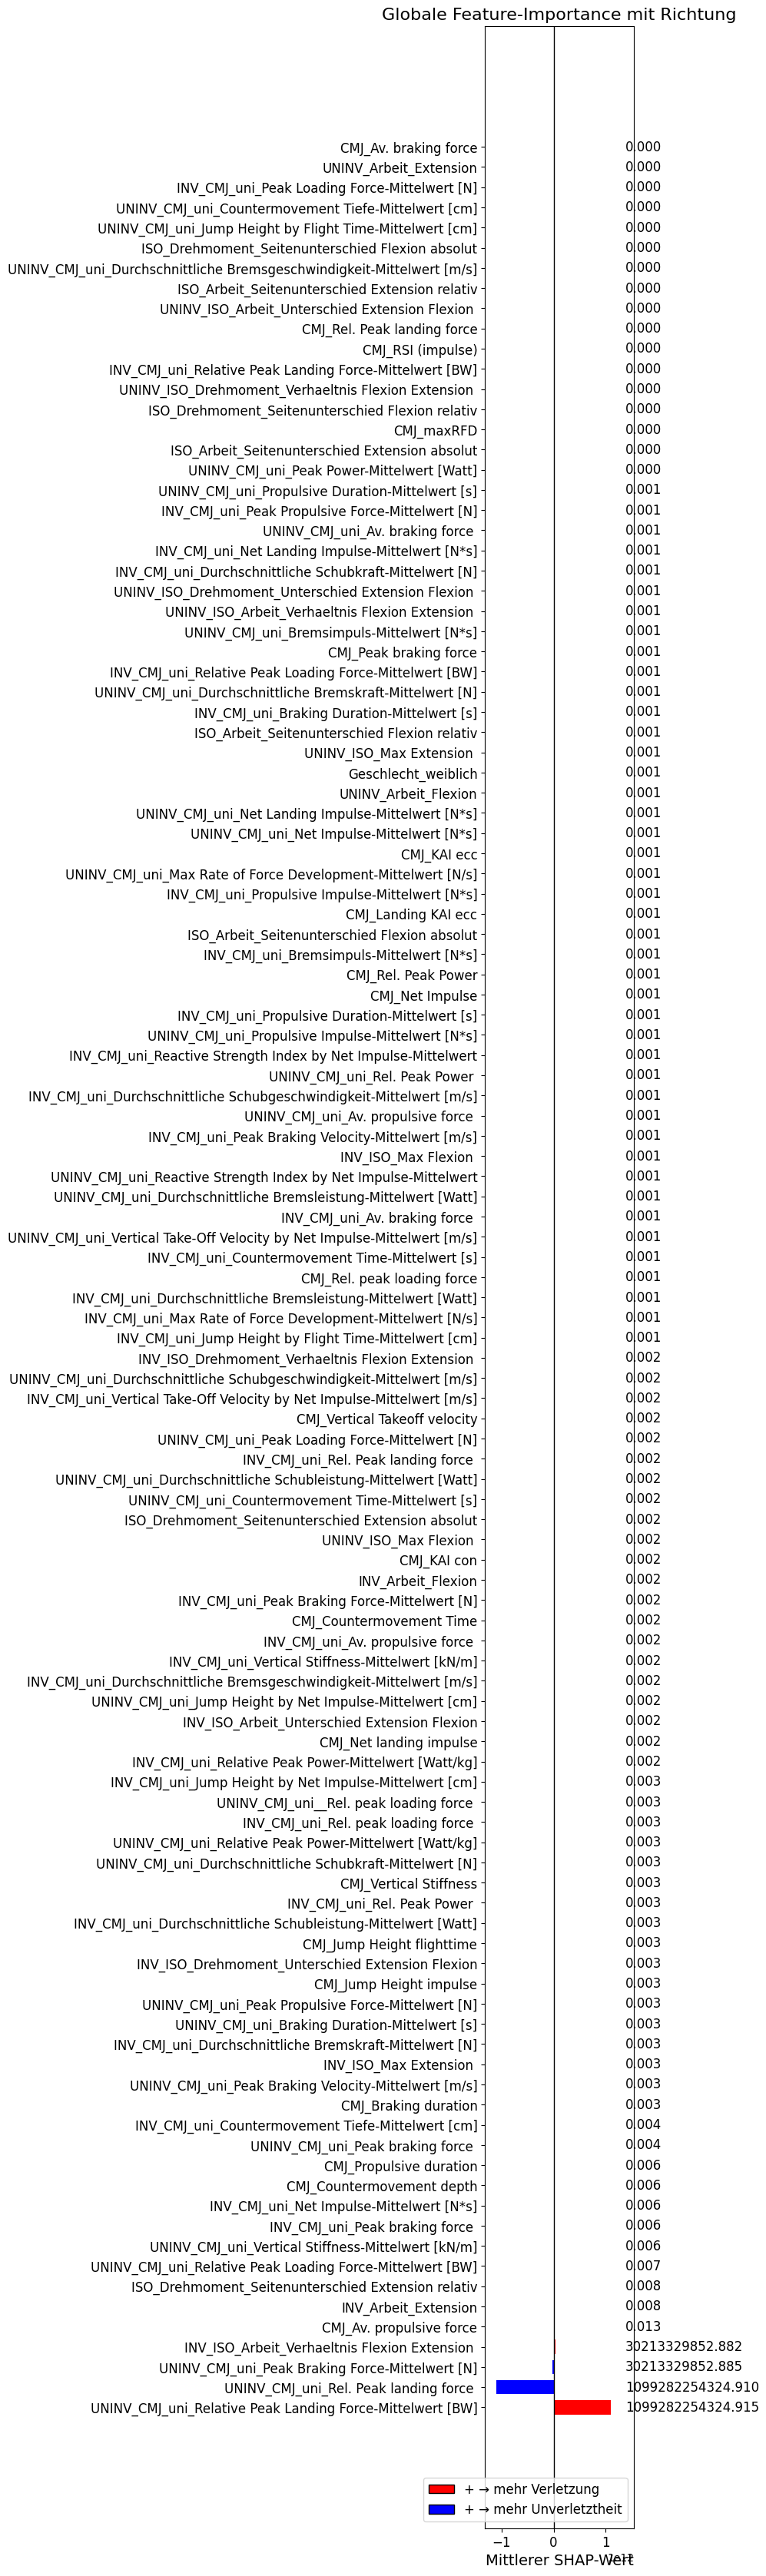

NameError: name 'exp_val' is not defined

In [7]:
import os
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import shap
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, fcluster
from joblib import Parallel, delayed
import warnings
warnings.filterwarnings("ignore")



# ─── Augmentationsfunktionen ──────────────────────────────────────────────────────────
def perform_clustering(X_sub, max_clusters=4):
            cols = [col for col in X_sub.columns if col not in ["Verletzungsstatus", "Geschlecht_weiblich"]]
            X_num = X_sub[cols]
            corr = X_num.corr().abs().fillna(0)
            corr = (corr + corr.T) / 2
            dist = np.clip(1 - corr, a_min=0, a_max=None)
            dists = squareform(dist.values)
            Z = linkage(dists, method='ward')
            cluster_labels = fcluster(Z, max_clusters, criterion='maxclust')
            clusters = {}
            for col, label in zip(cols, cluster_labels):
                clusters.setdefault(label, []).append(col)
            return clusters

def augment_subgroup(X_sub, clusters, p_augment=0.7):
    augmented_rows = []
    cluster_params = {}
    for cl_id, cols in clusters.items():
        cluster_data = X_sub[cols]
        mu = cluster_data.mean().values
        if len(cols) == 1:
            cov = np.cov(cluster_data.values.flatten(), ddof=0)
            cov = np.atleast_2d(cov)
        else:
            cov = np.cov(cluster_data.values, rowvar=False)
        cluster_params[cl_id] = (mu, cov, cols)
    for idx, row in X_sub.iterrows():
        new_row = row.copy()
        for cl_id, (mu, cov, cols) in cluster_params.items():
            if np.random.rand() < p_augment:
                new_values = np.random.multivariate_normal(mu, cov)
                for col, val in zip(cols, new_values):
                    new_row[col] = val
        augmented_rows.append(new_row)
    augmented_df = pd.DataFrame(augmented_rows)
    for col in ["Geschlecht_weiblich", "Verletzungsstatus"]:
        if col in augmented_df.columns:
            augmented_df[col] = augmented_df[col].astype(int)
    return augmented_df

def process_group_cluster(group_df, num_new_samples, max_clusters, p_augment):
    group_df = group_df.reset_index(drop=True)
    clusters = perform_clustering(group_df, max_clusters=max_clusters)
    aug_list = []
    for _ in range(num_new_samples):
        aug = augment_subgroup(group_df, clusters, p_augment)
        aug_list.append(aug)
    return pd.concat(aug_list, axis=0)

def augment_training_data_cluster(X_train, y_train, num_new_samples=1, max_clusters=4, p_augment=0.7, n_jobs=-1):
    df_train = X_train.copy()
    df_train["Verletzungsstatus"] = y_train
    groups = [group_df for _, group_df in df_train.groupby(["Verletzungsstatus", "Geschlecht_weiblich"])]
    augmented_groups = Parallel(n_jobs=n_jobs)(
        delayed(process_group_cluster)(group_df, num_new_samples, max_clusters, p_augment)
        for group_df in groups
    )
    augmented_df = pd.concat(augmented_groups, axis=0).reset_index(drop=True)
    y_aug = augmented_df["Verletzungsstatus"]
    X_aug = augmented_df.drop(columns=["Verletzungsstatus"])
    return X_aug, y_aug

def add_noise_to_data(df, noise_factor=0.1):
    df_noisy = df.copy()
    numeric_cols = [col for col in df_noisy.select_dtypes(include=['float64', 'int64']).columns 
                    if col not in ["Geschlecht_weiblich", "Verletzungsstatus"]]
    for col in numeric_cols:
        std = df_noisy[col].std()
        noise = np.random.normal(0, std * noise_factor, size=df_noisy.shape[0])
        df_noisy[col] += noise
    return df_noisy

def add_noise_to_group(df_group, noise_factor=0.1):
    return add_noise_to_data(df_group, noise_factor=noise_factor)

def process_group_cluster_noise(group_df, num_new_samples, max_clusters, p_augment, noise_factor):
    group_df = group_df.reset_index(drop=True)
    clusters = perform_clustering(group_df, max_clusters=max_clusters)
    aug_list = []
    for _ in range(num_new_samples):
        aug = augment_subgroup(group_df, clusters, p_augment)
        aug_list.append(aug)
    aug_group = pd.concat(aug_list, axis=0).reset_index(drop=True)
    n = len(aug_group)
    half = n // 2
    global_noise = add_noise_to_data(aug_group.copy(), noise_factor=noise_factor)
    group_noise = add_noise_to_group(aug_group.copy(), noise_factor=noise_factor)
    aug_noisy = pd.concat([global_noise.iloc[:half], group_noise.iloc[:half]], axis=0)
    return aug_noisy

def augment_training_data_cluster_noise(X_train, y_train, num_new_samples=1, max_clusters=4, 
                                        p_augment=0.7, noise_factor=0.1, n_jobs=-1):
    df_train = X_train.copy()
    df_train["Verletzungsstatus"] = y_train
    groups = [group_df for _, group_df in df_train.groupby(["Verletzungsstatus", "Geschlecht_weiblich"])]
    augmented_groups = Parallel(n_jobs=n_jobs)(
        delayed(process_group_cluster_noise)(group_df, num_new_samples, max_clusters, p_augment, noise_factor)
        for group_df in groups
    )
    augmented_df = pd.concat(augmented_groups, axis=0).reset_index(drop=True)
    y_aug = augmented_df["Verletzungsstatus"]
    X_aug = augmented_df.drop(columns=["Verletzungsstatus"])
    return X_aug, y_aug

def process_group_means(group_df, group_new_samples):
    group_df = group_df.reset_index(drop=True)
    new_group_samples = []
    if len(group_df) < 2:
        return None
    numeric_cols = [col for col in group_df.columns if col not in ["Geschlecht_weiblich", "Verletzungsstatus"]]
    pairs = np.random.choice(len(group_df), (group_new_samples, 2), replace=True)
    for i in range(group_new_samples):
        sample1 = group_df.iloc[pairs[i, 0]]
        sample2 = group_df.iloc[pairs[i, 1]]
        mean_sample = sample1.copy()
        for col in numeric_cols:
            mean_sample[col] = (sample1[col] + sample2[col]) / 2
        mean_sample["Verletzungsstatus"] = sample1["Verletzungsstatus"]
        mean_sample["Geschlecht_weiblich"] = sample1["Geschlecht_weiblich"]
        new_group_samples.append(mean_sample)
    if new_group_samples:
        return pd.DataFrame(new_group_samples)
    return None

def augment_data_by_group_means(X_train, y_train, augmentation_factor=2, n_jobs=-1):
    df_train = X_train.copy()
    df_train["Verletzungsstatus"] = y_train
    groups = df_train.groupby(["Verletzungsstatus", "Geschlecht_weiblich"])
    total_original_samples = len(df_train)
    total_new_samples = int(total_original_samples * (augmentation_factor - 1))
    group_sizes = groups.size()
    group_proportions = group_sizes / total_original_samples
    tasks = []
    for (injury_status, is_female), group_df in groups:
        group_new_samples = int(total_new_samples * group_proportions[(injury_status, is_female)])
        tasks.append((group_df, group_new_samples))
    augmented_groups = Parallel(n_jobs=n_jobs)(
        delayed(process_group_means)(group_df, group_new_samples)
        for group_df, group_new_samples in tasks
    )
    augmented_groups = [group for group in augmented_groups if group is not None]
    augmented_df = pd.concat([df_train] + augmented_groups, ignore_index=True)
    y_aug = augmented_df["Verletzungsstatus"]
    X_aug = augmented_df.drop(columns=["Verletzungsstatus"])
    return X_aug, y_aug

def augment_training_data_combined(X_train, y_train, target_size=1000, verbose=True, n_jobs=-1,
                                max_clusters=4, noise_factor=0.1):
    start_time = time.time()
    N = len(X_train)
    additional_needed = max(target_size - N, 0)
    per_method_needed = additional_needed // 3
    num_new_samples = max(per_method_needed // N, 1)
    augmentation_factor = 1 + (per_method_needed / N)
    if verbose:
        print(f"Starting combined augmentation to reach target size: {target_size}")
        print(f"Original dataset size: {N}")
        print(f"Samples needed per method: {per_method_needed}")
    funcs_and_params = [
        (augment_training_data_cluster, {"num_new_samples": num_new_samples, "n_jobs": n_jobs}),
        (augment_training_data_cluster_noise, {"num_new_samples": num_new_samples, "n_jobs": n_jobs}),
        (augment_data_by_group_means, {"augmentation_factor": augmentation_factor, "n_jobs": n_jobs})
    ]
    results = Parallel(n_jobs=min(3, n_jobs))(
        delayed(lambda f, p: f(X_train, y_train, **p))(func, params) for func, params in funcs_and_params
    )
    X_aug_cluster, y_aug_cluster = results[0]
    X_aug_cluster_noise, y_aug_cluster_noise = results[1]
    X_aug_group_means, y_aug_group_means = results[2]
    def subsample(X_aug, y_aug, required):
        if len(X_aug) > required:
            idx = np.random.choice(len(X_aug), required, replace=False)
            return X_aug.iloc[idx].reset_index(drop=True), y_aug.iloc[idx].reset_index(drop=True)
        else:
            return X_aug, y_aug
    X_aug_cluster, y_aug_cluster = subsample(X_aug_cluster, y_aug_cluster, per_method_needed)
    X_aug_cluster_noise, y_aug_cluster_noise = subsample(X_aug_cluster_noise, y_aug_cluster_noise, per_method_needed)
    X_aug_group_means, y_aug_group_means = subsample(X_aug_group_means, y_aug_group_means, per_method_needed)
    X_aug_combined = pd.concat([X_aug_cluster, X_aug_cluster_noise, X_aug_group_means], axis=0).reset_index(drop=True)
    y_aug_combined = pd.concat([y_aug_cluster, y_aug_cluster_noise, y_aug_group_means], axis=0).reset_index(drop=True)
    X_total = pd.concat([X_train.reset_index(drop=True), X_aug_combined], axis=0).reset_index(drop=True)
    y_total = pd.concat([y_train.reset_index(drop=True), y_aug_combined], axis=0).reset_index(drop=True)
    if len(X_total) > target_size:
        idx = np.random.choice(len(X_total), target_size, replace=False)
        X_total = X_total.iloc[idx].reset_index(drop=True)
        y_total = y_total.iloc[idx].reset_index(drop=True)
    elapsed_time = time.time() - start_time
    if verbose:
        print(f"Augmentation completed. Final dataset size: {len(X_total)}")
        print(f"Augmentation took {elapsed_time:.2f} seconds")
    return X_total, y_total


# ─── Modell erstellen ──────────────────────────────────────────────────────────
def create_model(input_dim):
    model = Sequential([
        Dense(256, activation='relu', input_shape=(input_dim,)),
        Dense(64, activation='relu'),
        Dense(8, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# ─── CV-Pipeline mit SHAP ──────────────────────────────────────────────────────
def run_cv_pipeline_with_shap(
    data_path,
    target_column="Verletzungsstatus",
    cv_splits=5,
    cv_repeats=2,
    target_augmentation_multiplier=11,
    shap_background_size=100,
    shap_max_display=20,
    shap_output_dir="shap_plots",
    verbose=True
):
    os.makedirs(shap_output_dir, exist_ok=True)

    # Daten einlesen
    df = pd.read_excel(data_path)
    y  = df[target_column]
    X  = df.drop(columns=[target_column])
    if verbose:
        print(f"Data: {len(df)} samples, {X.shape[1]} features, target dist: {y.value_counts().to_dict()}")

    # CV-Setup
    cv = RepeatedStratifiedKFold(n_splits=cv_splits, n_repeats=cv_repeats, random_state=42)
    metrics_results = []

    # Listen zum Aggregieren
    all_abs_shap = []   # mean(|shap|) pro Fold
    all_shap     = []   # alle shap_values
    all_X        = []   # zugehörige X_test_scaled

    shap.initjs()  # falls Du interaktive Plots im Notebook willst

    # ─── CV-Loop ───────────────────────────────────────────────────────
    for fold_idx, (train_idx, test_idx) in enumerate(cv.split(X, y), start=1):
        if verbose:
            print(f"\n=== Fold {fold_idx} ===")

        # --- Split, Augment & Scaling wie gehabt ---
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        target_size = int(len(X_train) * target_augmentation_multiplier)
        X_train, y_train = augment_training_data_combined(
            X_train, y_train,
            target_size=target_size,
            verbose=verbose,
            n_jobs=-1,
            max_clusters=4,
            noise_factor=0.1
        )

        scaler = MinMaxScaler()
        X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
        X_test_scaled  = pd.DataFrame(scaler.transform(X_test),  columns=X_test.columns)

        # --- Modell trainieren ---
        model = create_model(input_dim=X_train_scaled.shape[1])
        early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        model.fit(
            X_train_scaled, y_train,
            validation_split=0.2,
            epochs=100,
            batch_size=16,
            callbacks=[early_stop],
            verbose=0
        )

        # --- SHAP mit KernelExplainer ---
        f = lambda x: model.predict(x).flatten()
        bg = X_train_scaled.sample(
            n=min(shap_background_size, len(X_train_scaled)), random_state=42
        ).values
        #explainer = shap.KernelExplainer(f, bg, link="logit", approximate=True)
        explainer = shap.KernelExplainer(f, bg, link="identity", approximate=True)


        shap_values = explainer.shap_values(X_test_scaled.values, nsamples=50)
        assert shap_values.shape == X_test_scaled.shape

        # --- Sammeln für globale Plots ---
        all_abs_shap.append(np.abs(shap_values).mean(axis=0))
        all_shap.append(shap_values)
        all_X.append(X_test_scaled.values)

        # --- Metriken ---
        y_pred_prob = model.predict(X_test_scaled).flatten()
        y_pred      = (y_pred_prob > 0.5).astype(int)
        metrics_results.append({
            'fold':      fold_idx,
            'accuracy':  accuracy_score(y_test, y_pred),
            'f1':        f1_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall':    recall_score(y_test, y_pred),
            'roc_auc':   roc_auc_score(y_test, y_pred_prob)
        })

    # # ─── Nach CV: globale und lokale Plots aufbauen ─────────────────────────
    # features   = X_train_scaled.columns.tolist()
    # shap_stack = np.vstack(all_shap)   # (sum n_test, n_features)
    # # X_stack nicht mehr gebraucht im lokalen Plot – wir verzichten auf raw data
    # exp_val    = explainer.expected_value  # Baseline

    # # 1) Globaler Diverging Bar-Plot (mit absoluten Werten rechts)
    # mean_shap        = np.mean(shap_stack, axis=0)
    # idx_sort         = np.argsort(np.abs(mean_shap))[::-1]
    # feat_sorted      = [features[i] for i in idx_sort]
    # mean_shap_sorted = mean_shap[idx_sort]
    # abs_sorted       = np.abs(mean_shap_sorted)
    # colors           = ['red' if v>=0 else 'blue' for v in mean_shap_sorted]

    # # Höhe so wählen, dass pro Feature genug Platz ist
    # fig_height = max(12, len(feat_sorted) * 0.3)
    # fig, ax = plt.subplots(figsize=(10, fig_height))

    # bars = ax.barh(
    #     feat_sorted,
    #     mean_shap_sorted,
    #     color=colors,
    #     height=0.8
    # )
    # ax.axvline(0, color='black', linewidth=1)
    # ax.set_title("Globale Feature-Importance mit Richtung", fontsize=18, pad=20)
    # ax.set_xlabel("Mittlerer SHAP-Wert   (rot → zieht zu “Verletzt”, blau → zu “Unverletzt”)",
    #               fontsize=14, labelpad=15)
    # ax.tick_params(axis='y', labelsize=12, pad=5)
    # ax.tick_params(axis='x', labelsize=12)

    # # absolute Werte als Text rechts an den Balken, in gleicher fontsize
    # # wir setzen x-Grenze etwas weiter, damit der Text nicht ausbricht
    # xlim = ax.get_xlim()
    # ax.set_xlim(xlim[0], xlim[1] + 0.1 * (xlim[1] - xlim[0]))
    # for bar, val in zip(bars, abs_sorted):
    #     ax.text(
    #         bar.get_width() + np.sign(bar.get_width())*0.005,  # knapp neben Balken
    #         bar.get_y() + bar.get_height()/2,
    #         f"{val:.3f}",
    #         va='center', ha='left', fontsize=12
    #     )

    # from matplotlib.patches import Patch
    # legend_elements = [
    #     Patch(facecolor='red',  edgecolor='k', label='+ → mehr Verletzung'),
    #     Patch(facecolor='blue', edgecolor='k', label='+ → mehr Unverletztheit')
    # ]
    # ax.legend(handles=legend_elements, fontsize=12, loc='lower right')

    # plt.tight_layout(pad=3)
    # global_path = os.path.join(shap_output_dir, "global_diverging_bar.png")
    # fig.savefig(global_path, dpi=200)
    # print(f"→ Globaler Diverging Bar-Plot gespeichert: {global_path}")
    # plt.show()

    # ─── Nach CV: globale und lokale Plots aufbauen ─────────────────────────
    features         = X_train_scaled.columns.tolist()
    shap_stack       = np.vstack(all_shap)   # (sum n_test, n_features)
    mean_shap        = np.mean(shap_stack, axis=0)
    idx_sort         = np.argsort(np.abs(mean_shap))[::-1]
    feat_sorted      = [features[i] for i in idx_sort]
    mean_shap_sorted = mean_shap[idx_sort]
    abs_sorted       = np.abs(mean_shap_sorted)
    colors           = ['red' if v >= 0 else 'blue' for v in mean_shap_sorted]

    # dynamische Höhe je Featurezahl, Breite etwas großzügiger
    fig_height = max(8, len(feat_sorted) * 0.3)
    fig, ax = plt.subplots(figsize=(10, fig_height))

    # Balken zeichnen
    bars = ax.barh(
        feat_sorted,
        mean_shap_sorted,
        color=colors,
        height=0.7
    )
    ax.axvline(0, color='black', linewidth=1)
    ax.set_title("Globale Feature-Importance mit Richtung", fontsize=16)
    ax.set_xlabel("Mittlerer SHAP-Wert", fontsize=14)

    # Achsen-Optik
    ax.tick_params(axis='y', labelsize=12)
    ax.tick_params(axis='x', labelsize=12)

    # Legende
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='red',  edgecolor='k', label='+ → mehr Verletzung'),
        Patch(facecolor='blue', edgecolor='k', label='+ → mehr Unverletztheit')
    ]
    ax.legend(handles=legend_elements, fontsize=12, loc='lower right')

    # x-Limits setzen, damit rechts Platz für absolute Werte ist
    max_bar = np.max(np.abs(mean_shap_sorted))
    ax.set_xlim(-max_bar*1.2, max_bar*1.4)

    # absolute Werte in separater Spalte
    x_val_col = max_bar * 1.25
    for bar, val in zip(bars, abs_sorted):
        y = bar.get_y() + bar.get_height() / 2
        ax.text(
            x_val_col, y,
            f"{val:.3f}",
            va='center', ha='left',
            fontsize=12
        )

    plt.tight_layout(pad=2)
    global_path = os.path.join(shap_output_dir, "global_diverging_bar.png")
    fig.savefig(global_path, dpi=200)
    print(f"→ Globaler Diverging Bar-Plot gespeichert: {global_path}")
    plt.show()


    # 2) Lokaler Waterfall-Plot für ein zufälliges Sample
    np.random.seed(42)
    sample_idx = np.random.choice(shap_stack.shape[0], size=1)[0]

    # nur Werte & Baseline, ohne raw data → kein "feature = value" links
    exp = shap.Explanation(
        values      = shap_stack[sample_idx, :],
        base_values = exp_val,
        feature_names = features
    )

    fig_height = max(8, len(features) * 0.15)
    fig, ax = plt.subplots(figsize=(12, fig_height))
    plt.subplots_adjust(top=0.90, bottom=0.05)

    shap.plots.waterfall(
        exp,
        max_display=len(features),
        show=False
    )

    ax.set_title(f"Lokaler Waterfall-Plot (Sample {sample_idx})\n→ f(x) = {exp_val + exp.values.sum():.3f} (Modell-Vorhersage)", 
                 fontsize=16, pad=20)
    ax.tick_params(axis='y', labelsize=12)
    ax.tick_params(axis='x', labelsize=12)

    wp = os.path.join(shap_output_dir, "local_waterfall.png")
    fig.savefig(wp, dpi=200)
    print(f"→ Lokaler Waterfall-Plot gespeichert: {wp}")
    plt.show()

    # # # ─── Nach CV: globale und lokale Plots aufbauen ─────────────────────────
    # features   = X_train_scaled.columns.tolist()
    # shap_stack = np.vstack(all_shap)   # (sum n_test, n_features)
    # X_stack    = np.vstack(all_X)      # (sum n_test, n_features)
    # exp_val    = explainer.expected_value  # Baseline

    # # 1) Globaler Diverging Bar-Plot (mit absoluten Werten rechts)
    # mean_shap        = np.mean(shap_stack, axis=0)
    # idx_sort         = np.argsort(np.abs(mean_shap))[::-1]
    # feat_sorted      = [features[i] for i in idx_sort]
    # mean_shap_sorted = mean_shap[idx_sort]
    # abs_sorted       = np.abs(mean_shap_sorted)
    # colors           = ['red' if v>=0 else 'blue' for v in mean_shap_sorted]

    # fig_height = max(10, len(feat_sorted) * 0.3)
    # fig, ax = plt.subplots(figsize=(8, fig_height))

    # bars = ax.barh(feat_sorted, mean_shap_sorted, color=colors, height=0.7)
    # ax.axvline(0, color='black', linewidth=1)
    # ax.set_title("Globale Feature-Importance mit Richtung", fontsize=16)
    # ax.set_xlabel("Mittlerer SHAP-Wert (→ verletzter)", fontsize=14)
    # ax.tick_params(axis='y', labelsize=12)
    # ax.tick_params(axis='x', labelsize=12)

    # # absolute Werte als Labels rechts an die Balken
    # for bar, val in zip(bars, abs_sorted):
    #     ax.text(
    #         bar.get_width() + np.sign(bar.get_width())*0.01,  # ganz knapp rechts vom Balken
    #         bar.get_y() + bar.get_height()/2,
    #         f"{val:.3f}",
    #         va='center', fontsize=12
    #     )

    # from matplotlib.patches import Patch
    # legend_elements = [
    #     Patch(facecolor='red',  edgecolor='k', label='+ → mehr Verletzung'),
    #     Patch(facecolor='blue', edgecolor='k', label='+ → mehr Unverletztheit')
    # ]
    # ax.legend(handles=legend_elements, fontsize=12, loc='lower right')

    # plt.tight_layout(pad=2)
    # plt.subplots_adjust(top=0.95)
    # global_path = os.path.join(shap_output_dir, "global_diverging_bar.png")
    # fig.savefig(global_path, dpi=200)
    # print(f"→ Globaler Diverging Bar-Plot gespeichert: {global_path}")
    # plt.show()



    # ─── Performance Summary ───────────────────────────────────────────────────────
    results_df = pd.DataFrame(metrics_results).set_index('fold')
    print("\n=== Mittelwerte über Folds ===")
    print(results_df.mean().to_frame('mean')
                        .join(results_df.std().to_frame('std')))

    
    return results_df



# ─── Aufruf ────────────────────────────────────────────────────────────
if __name__ == "__main__":
    results_df = run_cv_pipeline_with_shap(
        data_path=r"K:\Team\Böhmer_Michael\TSA\ML\Basistabelle\Basistabelle_ML_neu.xlsx",
        cv_splits=5,
        cv_repeats=2,
        target_augmentation_multiplier=11,
        shap_background_size=100,
        shap_max_display=20,
        shap_output_dir=r"K:\Team\Böhmer_Michael\SHAP",
        verbose=False
    )
